<a href="https://colab.research.google.com/github/baussel/Satellite_Detection/blob/main/Mask_R_CNN_Satellites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MASK R-CNN Machine Learning Algorithm for Satellite Detection


---


*Ben Aussel, September 2021, ESA*


---

Script for the data preparation, creating, training and predictions for the satellite trails in Hubble images with the Mask-RCNN Network. The network backbone is a Resnet101 and Feature Pyramid Networks for Object Detection.

Sources: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb

https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46

https://arxiv.org/abs/1703.06870

https://arxiv.org/abs/1612.03144

# Code/Modules/Model Preparation

## Installation / Change versions

In [ ]:
#Install the Mask-RCNN module
!pip install mrcnn==0.2

     |████████████████████████████████| 51 kB 173 kB/s 
  Created wheel for mrcnn: filename=mrcnn-0.2-py3-none-any.whl size=54930 sha256=5ab978bfed4375acf73e065424de3b8599aa955e13eec6c04a6e4384d44b2364
  Stored in directory: /root/.cache/pip/wheels/1d/94/0d/03ff96abc43d2d6c8299a92cbb4eced2a1eda3ca7911c19427
Successfully built mrcnn


In [ ]:
#Adjust the different version that are compatible to each other
#NO CHANGES HERE
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip uninstall h5py -y

!pip install tensorflow-gpu==1.13.1
!pip install keras==2.2.5
!pip install h5py==2.10.0

Found existing installation: keras 2.6.0
Uninstalling keras-2.6.0:
  Successfully uninstalled keras-2.6.0
Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
Found existing installation: keras-vis 0.4.1
Uninstalling keras-vis-0.4.1:
  Successfully uninstalled keras-vis-0.4.1
Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 345.0 MB 3.2 kB/s 
     |████████████████████████████████| 42 kB 1.8 MB/s 
     |████████████████████████████████| 367 kB 80.1 MB/s 
     |████████████████████████████████| 3.2 MB 88.7 MB/s 
     |████████████████████████████████| 50 kB 9.5 MB/s 
     |████████████████████████████████| 4.1 MB 76.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found exis

## Import and setup

In [ ]:
#Import Modules
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import json
import skimage
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
from PIL import Image
from tqdm import tqdm

#Root directory of the project
ROOT_DIR = os.path.abspath("../../")

#Import Mask-RCNN modules
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

#Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

#Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
#Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

... done downloading pretrained model!


## GPU

In [ ]:
#Test if GPU is mounted and selected
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

#Select GPU
tf.device('/device:GPU:0')

Found GPU at: /device:GPU:0


# Data Preparation

## Satellite Config and Class

In [ ]:
class SatelliteConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "satellite"

    # Number of classes (including background)
    NUM_CLASSES = 2

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 1000

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

    DETECTION_NMS_THRESHOLD = 0.9

    #To get more accurate results use the full mask
    USE_MINI_MASK = False

#Set this as the used config
config = SatelliteConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.9
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

In [ ]:
class SatelliteDataset(utils.Dataset):

    def load_satellite(self, dataset_dir, subset):
        """Load a subset of the satellite dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add the satellite class
        self.add_class("satellite", 1, "satellite")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        #Load the annotations from the Zooniverse Images
        data_image_ids = pd.read_csv("/content/drive/MyDrive/ESA/Data/Zooniverse_Data/csv/image_ids.csv")
        data_points = pd.read_csv("/content/drive/MyDrive/ESA/Data/Zooniverse_Data/csv/point_reducer_dbscan_reductions.csv")
        filenames, points = self.load_annotations(data_image_ids, data_points)

        #Add images
        for i in range(len(filenames)):

            #Skip images that aren't in the folder
            if os.path.isfile(os.path.join(dataset_dir, filenames[i])):
                
                #Transform given lines into polygons with a given width
                width = 4 #>=2 in order to get a polygon (seems like a good value)
                for j in range(0, len(points[i])):
                    #Resize to 512x512
                    points[i][j][0] = list(np.round((np.array(points[i][j][0])*512/600)).astype(int))
                    points[i][j][1] = list(np.round((np.array(points[i][j][1])*512/600)).astype(int))

                    #Calculate the angle between the points in degrees
                    # atan2((y2-y1)/(x2-x1))
                    myradians = math.atan2(points[i][j][1][1]-points[i][j][1][0], \
                                        points[i][j][0][1]-points[i][j][0][0])
                    degree = math.degrees(myradians)

                    #The direction of the additional pixels depends on the angle of the trail
                    if 45 < np.abs(degree) < 135:
                        self.line_to_mask(points[i][j],"x",int(width/2))
                    else:
                        self.line_to_mask(points[i][j],"y",int(width/2))

                #Save the image path and size
                image_path = os.path.join(dataset_dir, filenames[i])
                height, width = 512, 512
                
                #Add the image to the dataset
                self.add_image(
                    "satellite",
                    image_id = filenames[i],  
                    path = image_path,
                    width = width, height = height,
                    polygons = points[i])
            else:
                continue

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        #Convert polygons to a bitmap mask of shape
        #[height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            #Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p[1], p[0])
            mask[rr, cc, i] = 1

        #Return mask, and array of class IDs of each instance. Since we have
        #one class ID only, we return an array of 1s
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "satellite":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
           Resize to 512x512px.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        #Resize image to 512x512
        image = skimage.transform.resize(image, (512,512), anti_aliasing=True)*255
        image = image.astype(np.uint8)
        return image
            
    def line_to_mask(self,line,x_or_y,diff):
        """ Transforms annotated lines into a mask with given width = 2*diff.
            The parameter 'x_or_y' gives the direction of added width of the line. 
        """
        if x_or_y == "y": 
            index = 1
            other = 0
        else: 
            index = 0
            other = 1

        #Add additional polygon points to line in given direction (x or y)
        #The points are added clockwise
        line[index].insert(1,line[index][0]-diff)
        line[index].insert(2,line[index][2]-diff)
        line[index].insert(4,line[index][3]+diff)
        line[index].insert(5,line[index][0]+diff)
        
        #Add the values in the other direction with same values
        line[other].insert(1,line[other][0])
        line[other].insert(2,line[other][2])
        line[other].insert(4,line[other][3])
        line[other].insert(5,line[other][0])

        #Search for indices out of the given range between 0 und 512
        incorrect_indices = []
        for j in range(0,len(line[index])):
            if line[index][j]<=0 or line[index][j]>=512:
                incorrect_indices.append(j)
        #Remove them in reversed order because the list gets shorter
        for k in range(len(incorrect_indices)-1,-1,-1):
            line[index].pop(incorrect_indices[k])
            line[other].pop(incorrect_indices[k])
    
    def get_image_filename(self,id,data_ids):
        """ Gets the index of the row with matching subject_id. 
            Return the corresponding filename from the metadata column
            (casted to a dictionary).
        """
        index_id = data_ids.index[data_ids["subject_id"] == id][0]
        dict_ids = json.loads(data_ids["metadata"][index_id])
        return dict_ids["filename"]

    def get_points(self,indices,data,question,data_ids):
        """ Extracts the points for the beginning and ending of the satellite trails.
            Saves them and the corresponding filenames in lists.
        """
        filenames, points = [], []
        for i in range(len(indices)):
            try:
                filename = self.get_image_filename(data["subject_id"][indices[i]],data_ids)
                points_x = json.loads(data["data.frame0."+question+"_tool0_clusters_x"][indices[i]])
                points_y = json.loads(data["data.frame0."+question+"_tool0_clusters_y"][indices[i]])
                cluster_count = json.loads(data["data.frame0."+question+"_tool0_clusters_count"][indices[i]])
                #If there are too many points, sort out the one that was picked the least
                while len(points_x)>=3:
                    crit_ind = np.argmin(cluster_count)
                    points_x.pop(crit_ind)
                    points_y.pop(crit_ind)
                #Sort out single points
                if len(points_x)>1:
                    #Round and save as integers
                    points_x_int, points_y_int = [], []
                    for i in range(len(points_x)):
                        points_x_int.append(int(np.round(points_x[i])))
                        points_y_int.append(int(np.round(points_y[i])))
                    points.append([[points_x_int,points_y_int]])
                    filenames.append(filename)
            except:
                continue
        return filenames, points
    
    def load_annotations(self,data_ids,data_points):
        """Loads the annotations from the Zooniverse Data."""
        #Mark of first trail if there is a satellite
        indices_t1 = data_points.index[data_points["task"] == "T1"].tolist()
        satellite_filenames, satellite_points = self.get_points(indices_t1,data_points,"T1",data_ids)

        #Mark of second trail if there is a satellite
        indices_t4 = data_points.index[data_points["task"] == "T4"].tolist()
        satellite_filenames_2, satellite_points_2 = self.get_points(indices_t4,data_points,"T4",data_ids)

        for i in range(len(satellite_filenames_2)):
            try:
                #Add point to previously annotated image (additional points)
                index = satellite_filenames.index(satellite_filenames_2[i])
                satellite_points[index].append(satellite_points_2[i][0])
            except:
                #Add as new file/image (new points)
                satellite_filenames.append(satellite_filenames_2[i])
                satellite_points.append(satellite_points_2[i])

        #Mark of third trail if there is a satellite
        indices_t7 = data_points.index[data_points["task"] == "T7"].tolist()
        satellite_filenames_3, satellite_points_3 = self.get_points(indices_t7,data_points,"T7",data_ids)

        for i in range(len(satellite_filenames_3)):
            try:
                #Add point to previously annotated image (additional points)
                index = satellite_filenames.index(satellite_filenames_3[i])
                satellite_points[index].append(satellite_points_3[i][0])
            except:
                #Add as new file/image (new points)
                satellite_filenames.append(satellite_filenames_3[i])
                satellite_points.append(satellite_points_3[i])

        #Mark of fourth trail if there is a satellite
        indices_t10 = data_points.index[data_points["task"] == "T10"].tolist()
        satellite_filenames_4, satellite_points_4 = self.get_points(indices_t10,data_points,"T10",data_ids)
        for i in range(len(satellite_filenames_4)):
            try:
                #Add point to previously annotated image (additional points)
                index = satellite_filenames.index(satellite_filenames_4[i])
                satellite_points[index].append(satellite_points_4[i][0])
            except:
                #Add as new file/image (new points)
                satellite_filenames.append(satellite_filenames_4[i])
                satellite_points.append(satellite_points_4[i])

        print(len(satellite_filenames),"marked satellite trails.")
        #Output format per point: [[x1,x2],[y1,y2]]
        return satellite_filenames, satellite_points

## Load and prepare Data

In [ ]:
#Mount Google Drive with this Colab
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#It's important that the image size can be divided by two six times
data_path = "/content/drive/MyDrive/ESA/Data/Zooniverse_Data/MRCNN/Images/Visible/"

#Training dataset
dataset_train = SatelliteDataset()
dataset_train.load_satellite(data_path,"train")
dataset_train.prepare()

#Validation dataset
dataset_val = SatelliteDataset()
dataset_val.load_satellite(data_path,"val")
dataset_val.prepare()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (29,30,31,32,33,34,35,36,37,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


2937 marked satellite trails.


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (29,30,31,32,33,34,35,36,37,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


2937 marked satellite trails.


In [ ]:
#Visualization method
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

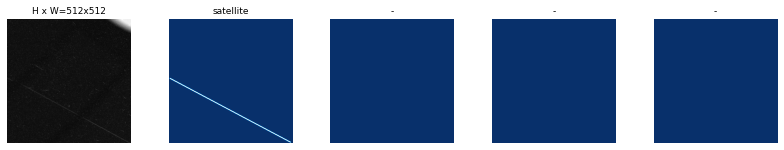

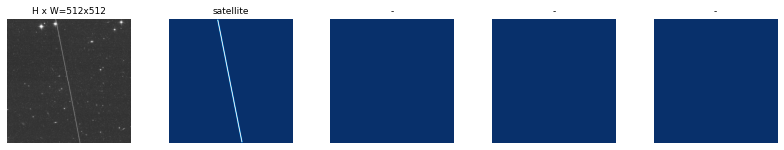

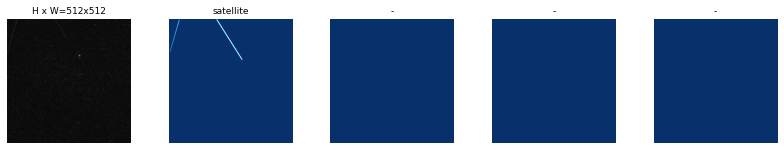

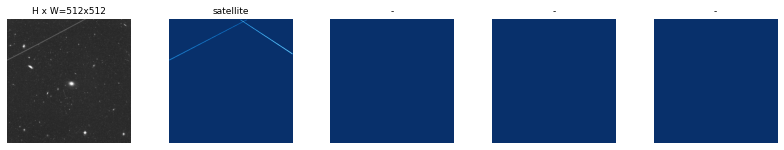

In [ ]:
#Load and display random samples to show that the annotations are correctly imported
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Training

## Model creation

In [ ]:
#Create the model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
#Which weights to start with?
init_with = "coco"  #Use the coco weights

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training with Dataset

In [ ]:
#Train the head branches
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers="heads")


Starting at epoch 0. LR=0.001

Checkpoint Path: /logs/satellite20210907T1821/mask_rcnn_satellite_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (T

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
1000/1000 [==============================] - 586s 586ms/step - loss: 1.4695 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.8178 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.5011 - mrcnn_mask_loss: 0.0919 - val_loss: 0.9274 - val_rpn_class_loss: 0.0066 - val_rpn_bbox_loss: 0.4629 - val_mrcnn_class_loss: 0.0515 - val_mrcnn_bbox_loss: 0.3428 - val_mrcnn_mask_loss: 0.0636
Epoch 2/10
1000/1000 [==============================] - 550s 550ms/step - loss: 1.1160 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.7347 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2645 - mrcnn_mask_loss: 0.0656 - val_loss: 1.0176 - val_rpn_class_loss: 0.0116 - val_rpn_bbox_loss: 0.5361 - val_mrcnn_class_loss: 0.0555 - val_mrcnn_bbox_loss: 0.3555 - val_mrcnn_mask_loss: 0.0589
Epoch 3/10
1000/1000 [==============================] - 553s 553ms/step - loss: 0.9966 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.6687 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.2147 - mrcnn_mask_loss: 0.0654 - val_loss: 1.2179 - 

In [ ]:
#Save the Model A
model_path = "/content/drive/MyDrive/ESA/ML_Checkpoints/MRCNN/mask_rcnn_7_A.h5"
model.keras_model.save_weights(model_path)

In [ ]:
#Create model in training mode again
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
model.load_weights(model_path, by_name=True)

In [ ]:
#Fine tune all layers
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 100,
            epochs=20, 
            layers="all")


Starting at epoch 0. LR=1e-05

Checkpoint Path: /logs/satellite20210907T2052/mask_rcnn_satellite_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (B

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
1000/1000 [==============================] - 773s 773ms/step - loss: 0.6079 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4426 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.0511 - val_loss: 0.6371 - val_rpn_class_loss: 0.0103 - val_rpn_bbox_loss: 0.3943 - val_mrcnn_class_loss: 0.0419 - val_mrcnn_bbox_loss: 0.1412 - val_mrcnn_mask_loss: 0.0493
Epoch 2/20
1000/1000 [==============================] - 725s 725ms/step - loss: 0.5696 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.4001 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.0499 - val_loss: 0.6780 - val_rpn_class_loss: 0.0100 - val_rpn_bbox_loss: 0.4347 - val_mrcnn_class_loss: 0.0382 - val_mrcnn_bbox_loss: 0.1384 - val_mrcnn_mask_loss: 0.0568
Epoch 3/20
1000/1000 [==============================] - 727s 727ms/step - loss: 0.4733 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3257 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.0466 - val_loss: 1.3942 - 

In [ ]:
#Save the Model B
model_path = "/content/drive/MyDrive/ESA/ML_Checkpoints/MRCNN/mask_rcnn_7_B.h5"
model.keras_model.save_weights(model_path)

# Prediction

In [ ]:
#Configuration of the inference process
class InferenceConfig(SatelliteConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    RPN_NMS_THRESHOLD = 0.9

#Load config
inference_config = InferenceConfig()
inference_config.display()

#Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

#Load trained weights
model_path = "/content/drive/MyDrive/ESA/ML_Checkpoints/MRCNN/mask_rcnn_6_B.h5"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.9
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

In [ ]:
def extract_points(result):
    """ Extracts the points for the detection of a given image.
        Search for mask with at least two points in order to get the
        correct angle of the satellite trail.
    """
    #The first box is the one with the highest confidence
    try:
        points = r["rois"][0]
    except:
        return 0, 0
    #Save all masks
    mask = r["masks"]
    #Check if there is only one detected mask
    only_one = False
    try:
        number_masks = len(r["masks"][0][0])
    except:
        only_one = True
    first_completed = False
    second_completed = False
    if only_one:
        for i in range(len(mask)): #For all y rows
            for j in range(len(mask[i])): #For all x rows
                if mask[i][j] == True and first_completed==False:
                    #Save first point
                    p1x, p1y = j, i
                    first_completed = True
                    print("First")
                elif mask[i][j] == True:
                    #Save second point (gets overwritten, last one is saved)
                    p2x, p2y = j, i
                    second_completed = True
                    print("Second")
    else:
        p1x, p2x = 0, 0
        #Search for mask
        for i in range(number_masks): #For all masks
            if second_completed == False:
                first_completed = False
                for j in range(len(mask)):
                    for k in range(len(mask[j])):
                        if mask[j][k][i] == True and first_completed==False:
                            #Save first point
                            p1x, p1y = k, j
                            first_completed = True
                            continue
                        elif mask[j][k][i] == True and first_completed:
                            #Save second point (gets overwritten, last one is saved)
                            p2x, p2y = k, j
                            second_completed = True
            if p1x-p2x == 0: #Do not divide by zero
                first_completed = False
                second_completed = False
    #Calculate the right angle of the trail
    if first_completed and second_completed:
        slope = (p1y-p2y)/(p1x-p2x)
        if slope < 0: #From left bottom to right top
            points = [[points[1],points[3]],[points[2],points[0]]]
            positive = True
        else: #From left top to right bottom
            points = [[points[1],points[3]],[points[0],points[2]]]
            positive = False
        angle = np.degrees(np.arctan(np.abs((points[1][1]-points[1][0])/(points[0][1]-points[0][0]))))
        if positive: pass
        else: angle = -angle
    else:
        points, angle = 0, 0
    return points, angle

## Single image

original_image           shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  512.00000  int64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:    3.00000  max:  320.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  uint8


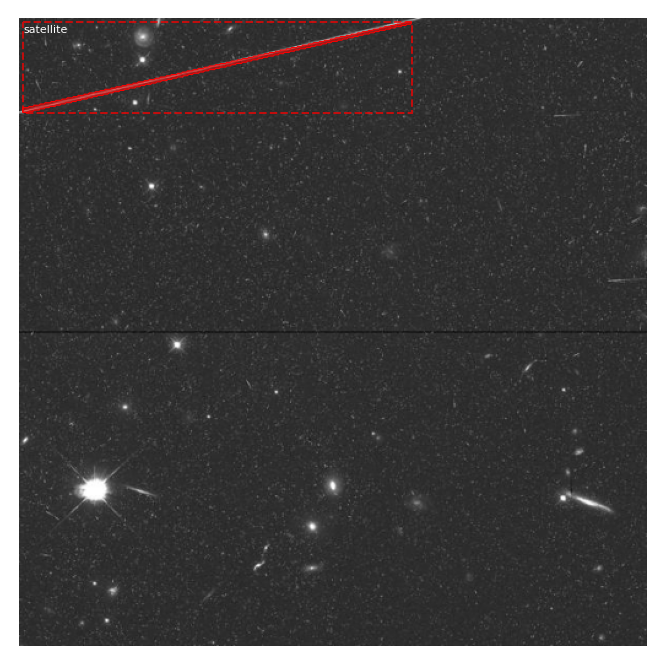

In [ ]:
#Test on a val image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(12,12))

Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 253], [157, 503]]
Angle of the trail: -54.259201942604754 degrees
________________________________


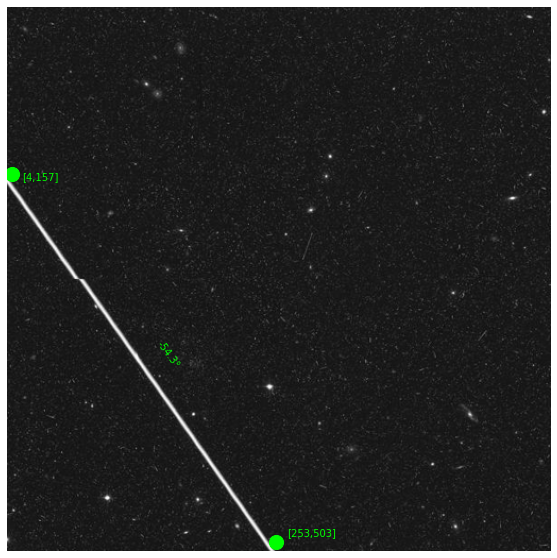

In [ ]:
# Load image
filename = "j6fl1e010_j6fl1elvq.jpg"
image_det = Image.open(filename)
image_det = image_det.resize((512,512))
image_det = image_det.convert("RGB")
image_det = np.asarray(image_det)

#image_det = original_image
#Detect
results = model.detect([image_det], verbose=1)

r = results[0]
print("-------------RESULT-------------")

#Show the original image
image = original_image
plt.figure(figsize=(10, 10))
plt.imshow(image_det,cmap="gray")
plt.axis("off")
#Extract points and angle
points, angle = extract_points(r)
if points == 0:
    print("Could not detect start and end points of the satellite trail.")
else:
    #If the detection was successful show points and angle
    distance_x_0, distance_x_1, distance_y_0, distance_y_1 = 10, 10, 5, 5
    sel_color = "lime"
    print("Detected points [x,y]:",points)
    print("Angle of the trail:", angle, "degrees")
    #Show points
    plt.scatter(points[0],points[1],s=200,c=sel_color)
    #Boundary conditions
    if points[0][0] > 450: distance_x_0 = -60
    if points[0][1] > 450: distance_x_1 = -60
    if points[1][0] > 500: distance_y_0 = -5
    if points[1][1] > 500: distance_y_1 = -5
    #Annotations points
    plt.annotate("["+str(points[0][0])+","+str(points[1][0])+"]",[points[0][0],points[1][0]],[points[0][0]+distance_x_0,points[1][0]+distance_y_0],color=sel_color)
    plt.annotate("["+str(points[0][1])+","+str(points[1][1])+"]",[points[0][1],points[1][1]],[points[0][1]+distance_x_1,points[1][1]+distance_y_1],color=sel_color)
    #Annotation angle
    x_mean = (points[0][1]+points[0][0])/2
    y_mean = (points[1][1]+points[1][0])/2
    plt.annotate(str(np.round(angle,1))+"°",[x_mean+10,y_mean+10],rotation=angle,color=sel_color)
    #Save image
    plt.savefig("detected_trail.png")
print("________________________________")

In [ ]:
visualize.display_instances(image_det, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'],figsize=(12,12))

##All Images

In [ ]:
# Load image
folder_path = "/content/drive/MyDrive/ESA/Results/processed/WFC3/"
pathout = "/content/drive/MyDrive/ESA/Results/trail_detection/WFC3/"

predictions = []
error_ids = []

plt.rcParams["figure.figsize"] = (10,10)

for img in tqdm(os.listdir(folder_path)):
    try:
        image_det = Image.open(folder_path+img)
    except:
        error_ids.append(img)
        continue
    image_det = image_det.resize((512,512))
    image_det = image_det.convert("RGB")
    image_det = np.asarray(image_det)

    #image_det = original_image
    results = model.detect([image_det], verbose=1)

    r = results[0]
    print("-------------RESULT-------------")

    plt.imshow(image_det,cmap="gray")
    plt.axis("off")
    #Extract points and angle
    points, angle = extract_points(r)
    if points == 0:
        print("Could not detect start and end points of the satellite trail.")
    else:
        #If the detection was successful show points and angle
        distance_x_0, distance_x_1, distance_y_0, distance_y_1 = 10, 10, 5, 5
        sel_color = "lime"
        print("Detected points [x,y]:",points)
        print("Angle of the trail:", angle, "degrees")
        predictions.append([img,points,angle])
        #Show points
        plt.scatter(points[0],points[1],s=200,c=sel_color)
        #Boundary conditions
        if points[0][0] > 450: distance_x_0 = -60
        if points[0][1] > 450: distance_x_1 = -60
        if points[1][0] > 500: distance_y_0 = -5
        if points[1][1] > 500: distance_y_1 = -5
        #Annotations points
        plt.annotate("["+str(points[0][0])+","+str(points[1][0])+"]",[points[0][0],points[1][0]],[points[0][0]+distance_x_0,points[1][0]+distance_y_0],color=sel_color)
        plt.annotate("["+str(points[0][1])+","+str(points[1][1])+"]",[points[0][1],points[1][1]],[points[0][1]+distance_x_1,points[1][1]+distance_y_1],color=sel_color)
        #Annotation angle
        x_mean = (points[0][1]+points[0][0])/2
        y_mean = (points[1][1]+points[1][0])/2
        plt.annotate(str(np.round(angle,1))+"°",[x_mean+10,y_mean+10],rotation=angle,color=sel_color)
        #Save image
        plt.savefig(pathout+"Images/"+img, bbox_inches = 'tight', dpi=100)
        plt.close()
    print("________________________________")

  0%|          | 0/840 [00:00<?, ?it/s]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[10, 512], [35, 164]]
Angle of the trail: -14.411596503888672 degrees


  0%|          | 1/840 [00:01<17:17,  1.24s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  0%|          | 2/840 [00:03<29:22,  2.10s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[85, 171], [8, 507]]
Angle of the trail: -80.22143806445654 degrees


  0%|          | 3/840 [00:05<26:21,  1.89s/it]

________________________________


  0%|          | 4/840 [00:06<19:37,  1.41s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 504], [187,

  1%|          | 5/840 [00:07<21:09,  1.52s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|          | 6/840 [00:09<21:16,  1.53s/it]

Detected points [x,y]: [[363, 512], [4, 214]]
Angle of the trail: -54.643391788790545 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|          | 7/840 [00:14<36:29,  2.63s/it]

Could not detect start and end points of the satellite trail.
________________________________


  1%|          | 8/840 [00:15<27:29,  1.98s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


  1%|          | 9/840 [00:15<21:19,  1.54s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 87], [73, 5

  1%|          | 10/840 [00:17<22:39,  1.64s/it]

________________________________


  1%|▏         | 11/840 [00:18<18:50,  1.36s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[428, 510], [1,

  1%|▏         | 12/840 [00:19<20:22,  1.48s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  221.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  117.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 13/840 [00:21<20:44,  1.50s/it]

Detected points [x,y]: [[4, 37], [6, 95]]
Angle of the trail: -69.65589874408161 degrees
________________________________


  2%|▏         | 14/840 [00:22<17:02,  1.24s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[207, 505], [0,

  2%|▏         | 15/840 [00:25<24:19,  1.77s/it]

________________________________


  2%|▏         | 16/840 [00:25<19:42,  1.43s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 466], [241,

  2%|▏         | 17/840 [00:27<20:38,  1.51s/it]

________________________________


  2%|▏         | 18/840 [00:28<17:42,  1.29s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


  2%|▏         | 19/840 [00:29<16:05,  1.18s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[185, 322], [4,

  2%|▏         | 20/840 [00:30<18:34,  1.36s/it]

________________________________


  2%|▎         | 21/840 [00:31<15:31,  1.14s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


  3%|▎         | 22/840 [00:32<14:23,  1.06s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 454], [242,

  3%|▎         | 23/840 [00:34<16:50,  1.24s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 24/840 [00:35<17:20,  1.28s/it]

Detected points [x,y]: [[485, 510], [512, 408]]
Angle of the trail: 76.48343189120868 degrees
________________________________


  3%|▎         | 25/840 [00:35<14:25,  1.06s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


  3%|▎         | 26/840 [00:36<12:30,  1.08it/s]

Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 141], [88, 

  3%|▎         | 27/840 [00:38<15:35,  1.15s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 28/840 [00:43<34:02,  2.52s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  221.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  117.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[150, 218], [0, 178]]
Angle of the trail: -69.09201952899035 degrees


  3%|▎         | 29/840 [00:45<30:35,  2.26s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▎         | 30/840 [00:49<38:54,  2.88s/it]

Detected points [x,y]: [[5, 237], [25, 506]]
Angle of the trail: -64.25066276137561 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▎         | 31/840 [00:52<36:07,  2.68s/it]

Detected points [x,y]: [[267, 512], [0, 421]]
Angle of the trail: -59.802831391744355 degrees
________________________________


  4%|▍         | 32/840 [00:52<27:14,  2.02s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 173], [448,

  4%|▍         | 33/840 [00:54<25:25,  1.89s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▍         | 34/840 [00:55<23:55,  1.78s/it]

Detected points [x,y]: [[0, 504], [190, 366]]
Angle of the trail: -19.24952587268173 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▍         | 35/840 [00:59<33:10,  2.47s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▍         | 36/840 [01:10<1:05:02,  4.85s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 152], [336, 492]]
Angle of the trail: -45.744059202888714 degrees


  4%|▍         | 37/840 [01:12<52:41,  3.94s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▍         | 38/840 [01:13<43:01,  3.22s/it]

Detected points [x,y]: [[0, 481], [242, 266]]
Angle of the trail: -2.8564641457189923 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▍         | 39/840 [01:21<59:59,  4.49s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 501], [103, 195]]
Angle of the trail: -10.508022140232413 degrees


  5%|▍         | 40/840 [01:22<48:09,  3.61s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▍         | 41/840 [01:24<39:43,  2.98s/it]

Detected points [x,y]: [[2, 92], [70, 5]]
Angle of the trail: 35.83765295427829 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▌         | 42/840 [01:30<53:07,  3.99s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[7, 494], [359, 296]]
Angle of the trail: 7.371043695512407 degrees


  5%|▌         | 43/840 [01:32<43:49,  3.30s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▌         | 44/840 [01:33<36:47,  2.77s/it]

Detected points [x,y]: [[97, 200], [4, 164]]
Angle of the trail: -57.228590733325674 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▌         | 45/840 [01:43<1:04:17,  4.85s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[35, 159], [506, 0]]
Angle of the trail: 76.23049473311087 degrees


  5%|▌         | 46/840 [01:45<51:37,  3.90s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▌         | 47/840 [01:46<42:07,  3.19s/it]

Detected points [x,y]: [[326, 506], [509, 426]]
Angle of the trail: 24.75495178196024 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▌         | 48/840 [01:48<35:23,  2.68s/it]

Detected points [x,y]: [[76, 511], [510, 450]]
Angle of the trail: 7.853313301978219 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▌         | 49/840 [01:49<31:10,  2.36s/it]

Detected points [x,y]: [[3, 107], [190, 5]]
Angle of the trail: 60.6569527657957 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▌         | 50/840 [01:50<24:48,  1.88s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▌         | 51/840 [01:55<38:52,  2.96s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[6, 502], [484, 348]]
Angle of the trail: 15.333284793053549 degrees


  6%|▌         | 52/840 [01:59<40:06,  3.05s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▋         | 53/840 [02:02<41:47,  3.19s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[231, 505], [180, 472]]
Angle of the trail: -46.82151335160111 degrees


  6%|▋         | 54/840 [02:04<35:53,  2.74s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 55/840 [02:05<30:27,  2.33s/it]

Detected points [x,y]: [[9, 152], [212, 0]]
Angle of the trail: 55.99922088044554 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   69.00000  max:  207.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -54.70000  max:  103.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 56/840 [02:07<27:29,  2.10s/it]

Detected points [x,y]: [[235, 296], [3, 53]]
Angle of the trail: -39.34051815983752 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 57/840 [02:08<24:10,  1.85s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  170.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:   66.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 51], [306, 507]]
Angle of the trail: -76.29960133462853 degrees


  7%|▋         | 58/840 [02:10<23:27,  1.80s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 59/840 [02:11<22:03,  1.69s/it]

Detected points [x,y]: [[281, 302], [16, 512]]
Angle of the trail: -87.57561855515905 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 60/840 [02:13<21:43,  1.67s/it]

Detected points [x,y]: [[2, 132], [248, 86]]
Angle of the trail: 51.25403274391647 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 61/840 [02:14<21:02,  1.62s/it]

Detected points [x,y]: [[2, 144], [363, 244]]
Angle of the trail: 39.96395570476113 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 62/840 [02:16<21:00,  1.62s/it]

Detected points [x,y]: [[353, 429], [512, 0]]
Angle of the trail: 81.55680907082336 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 63/840 [02:18<23:41,  1.83s/it]

Detected points [x,y]: [[232, 440], [512, 0]]
Angle of the trail: 67.89055165624833 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 64/840 [02:21<28:03,  2.17s/it]

Detected points [x,y]: [[4, 194], [169, 508]]
Angle of the trail: -60.73059143550565 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 65/840 [02:28<44:15,  3.43s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 410], [212, 2]]
Angle of the trail: 27.235146699302522 degrees


  8%|▊         | 66/840 [02:30<40:10,  3.11s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 67/840 [02:40<1:05:36,  5.09s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[318, 504], [164, 26]]
Angle of the trail: 36.573030978519334 degrees


  8%|▊         | 68/840 [02:42<52:34,  4.09s/it]  

________________________________


  8%|▊         | 69/840 [02:42<38:47,  3.02s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


  8%|▊         | 70/840 [02:43<29:10,  2.27s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 27], [460, 

  8%|▊         | 71/840 [02:44<26:53,  2.10s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▊         | 72/840 [02:46<24:41,  1.93s/it]

Detected points [x,y]: [[1, 260], [316, 382]]
Angle of the trail: -14.296204386029508 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  241.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  137.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▊         | 73/840 [02:47<23:38,  1.85s/it]

Detected points [x,y]: [[95, 215], [4, 133]]
Angle of the trail: -47.0700306530411 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 74/840 [02:57<51:34,  4.04s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[297, 509], [3, 421]]
Angle of the trail: -63.106923134857134 degrees


  9%|▉         | 75/840 [02:58<42:19,  3.32s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 76/840 [03:06<57:46,  4.54s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 367], [205, 507]]
Angle of the trail: -39.83669318562646 degrees


  9%|▉         | 77/840 [03:12<1:05:34,  5.16s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 78/840 [03:18<1:07:08,  5.29s/it]

Could not detect start and end points of the satellite trail.
________________________________


  9%|▉         | 79/840 [03:18<48:49,  3.85s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|▉         | 80/840 [03:25<1:00:20,  4.76s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[12, 497], [260, 140]]
Angle of the trail: 13.89717631501536 degrees


 10%|▉         | 81/840 [03:27<49:28,  3.91s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|▉         | 82/840 [03:29<40:46,  3.23s/it]

Detected points [x,y]: [[482, 511], [509, 467]]
Angle of the trail: 55.37584492005105 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|▉         | 83/840 [03:30<34:42,  2.75s/it]

Detected points [x,y]: [[418, 509], [509, 314]]
Angle of the trail: 64.98310652189997 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|█         | 84/840 [03:32<30:03,  2.39s/it]

Detected points [x,y]: [[78, 158], [224, 5]]
Angle of the trail: 69.93291291601584 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  225.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  121.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|█         | 85/840 [03:35<31:27,  2.50s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[7, 506], [181, 55]]
Angle of the trail: 14.171247411088817 degrees


 10%|█         | 86/840 [03:36<28:08,  2.24s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|█         | 87/840 [03:38<25:15,  2.01s/it]

Detected points [x,y]: [[210, 303], [178, 6]]
Angle of the trail: 61.60001367939148 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|█         | 88/840 [03:39<23:47,  1.90s/it]

Detected points [x,y]: [[0, 118], [17, 59]]
Angle of the trail: -19.592281891051528 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█         | 89/840 [03:47<44:33,  3.56s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[70, 217], [0, 502]]
Angle of the trail: -73.67845548846662 degrees


 11%|█         | 90/840 [03:48<36:42,  2.94s/it]

________________________________


 11%|█         | 91/840 [03:49<28:29,  2.28s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 11%|█         | 92/840 [03:50<23:30,  1.89s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  204.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  100.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 11%|█         | 93/840 [03:51<18:48,  1.51s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[267, 343], [21

 11%|█         | 94/840 [03:53<19:58,  1.61s/it]

________________________________


 11%|█▏        | 95/840 [03:53<15:50,  1.28s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  250.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 502], [155,

 11%|█▏        | 96/840 [03:55<16:53,  1.36s/it]

________________________________


 12%|█▏        | 97/840 [03:55<14:02,  1.13s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 98/840 [04:01<32:37,  2.64s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[393, 511], [510, 314]]
Angle of the trail: 58.95034281337738 degrees


 12%|█▏        | 99/840 [04:04<31:06,  2.52s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 100/840 [04:05<27:30,  2.23s/it]

Detected points [x,y]: [[0, 509], [320, 380]]
Angle of the trail: -6.722898651714646 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 101/840 [04:11<40:22,  3.28s/it]

Detected points [x,y]: [[29, 504], [277, 506]]
Angle of the trail: -25.738960627852418 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 102/840 [04:12<34:01,  2.77s/it]

Detected points [x,y]: [[2, 102], [120, 8]]
Angle of the trail: 48.239700296102136 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  136.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   32.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 103/840 [04:14<29:36,  2.41s/it]

Detected points [x,y]: [[3, 511], [304, 122]]
Angle of the trail: 19.710962687341876 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 104/840 [04:16<26:16,  2.14s/it]

Detected points [x,y]: [[461, 511], [512, 464]]
Angle of the trail: 43.830860672092584 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▎        | 105/840 [04:17<24:07,  1.97s/it]

Detected points [x,y]: [[1, 495], [349, 285]]
Angle of the trail: 7.381818421919884 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 106/840 [04:20<27:04,  2.21s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 107/840 [04:25<36:59,  3.03s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[6, 504], [168, 193]]
Angle of the trail: -2.873881596416573 degrees


 13%|█▎        | 108/840 [04:27<32:23,  2.66s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 109/840 [04:28<28:10,  2.31s/it]

Detected points [x,y]: [[0, 63], [424, 510]]
Angle of the trail: -53.77505574447968 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 110/840 [04:30<24:57,  2.05s/it]

Detected points [x,y]: [[439, 511], [509, 356]]
Angle of the trail: 64.79887635452492 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 111/840 [04:34<35:18,  2.91s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[383, 508], [507, 370]]
Angle of the trail: 47.6224014605411 degrees


 13%|█▎        | 112/840 [04:36<30:58,  2.55s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 113/840 [04:41<37:46,  3.12s/it]

Detected points [x,y]: [[16, 412], [0, 474]]
Angle of the trail: -50.12316553712815 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▎        | 114/840 [04:42<32:02,  2.65s/it]

Detected points [x,y]: [[309, 512], [1, 388]]
Angle of the trail: -62.32084175608345 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▎        | 115/840 [04:44<27:39,  2.29s/it]

Detected points [x,y]: [[29, 176], [0, 504]]
Angle of the trail: -73.73979529168804 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▍        | 116/840 [04:45<24:40,  2.04s/it]

Detected points [x,y]: [[7, 298], [130, 212]]
Angle of the trail: -15.737143189605709 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  121.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   17.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▍        | 117/840 [04:47<22:55,  1.90s/it]

Detected points [x,y]: [[256, 300], [26, 497]]
Angle of the trail: -84.66301729384817 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▍        | 118/840 [04:48<21:46,  1.81s/it]

Detected points [x,y]: [[17, 501], [297, 110]]
Angle of the trail: 21.124719146072483 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▍        | 119/840 [04:50<20:36,  1.71s/it]

Detected points [x,y]: [[1, 150], [302, 3]]
Angle of the trail: 63.511649954497386 degrees
________________________________


 14%|█▍        | 120/840 [04:51<17:04,  1.42s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▍        | 121/840 [04:55<29:35,  2.47s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[458, 512], [0, 278]]
Angle of the trail: -79.00749241973227 degrees


 15%|█▍        | 122/840 [04:57<26:58,  2.25s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▍        | 123/840 [05:00<29:09,  2.44s/it]

Detected points [x,y]: [[279, 508], [301, 510]]
Angle of the trail: -42.38557040340456 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▍        | 124/840 [05:02<25:58,  2.18s/it]

Detected points [x,y]: [[3, 492], [385, 504]]
Angle of the trail: -13.677286654143764 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▍        | 125/840 [05:03<23:46,  2.00s/it]

Detected points [x,y]: [[456, 511], [1, 84]]
Angle of the trail: -56.4695303328669 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▌        | 126/840 [05:05<22:37,  1.90s/it]

Detected points [x,y]: [[352, 511], [269, 373]]
Angle of the trail: -33.18821951757045 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▌        | 127/840 [05:08<28:41,  2.41s/it]

Detected points [x,y]: [[13, 501], [294, 62]]
Angle of the trail: 25.426874169589805 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▌        | 128/840 [05:11<28:02,  2.36s/it]

Detected points [x,y]: [[0, 229], [166, 507]]
Angle of the trail: -56.1164970863491 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▌        | 129/840 [05:12<25:08,  2.12s/it]

Detected points [x,y]: [[70, 511], [0, 221]]
Angle of the trail: -26.616996565849405 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▌        | 130/840 [05:14<23:10,  1.96s/it]

Detected points [x,y]: [[0, 124], [402, 511]]
Angle of the trail: -41.31651361083951 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 131/840 [05:15<21:31,  1.82s/it]

Detected points [x,y]: [[1, 76], [372, 0]]
Angle of the trail: 78.60123693124207 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 132/840 [05:17<20:18,  1.72s/it]

Detected points [x,y]: [[3, 73], [493, 375]]
Angle of the trail: 59.32271997820356 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 133/840 [05:18<19:33,  1.66s/it]

Detected points [x,y]: [[0, 477], [244, 263]]
Angle of the trail: -2.2810159738211184 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 134/840 [05:24<33:06,  2.81s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[73, 512], [510, 342]]
Angle of the trail: 20.941245104910102 degrees


 16%|█▌        | 135/840 [05:26<30:06,  2.56s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 136/840 [05:27<26:22,  2.25s/it]

Detected points [x,y]: [[296, 324], [0, 180]]
Angle of the trail: -81.15818543980834 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▋        | 137/840 [05:29<24:45,  2.11s/it]

Detected points [x,y]: [[1, 80], [123, 9]]
Angle of the trail: 55.278719804132265 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▋        | 138/840 [05:31<23:31,  2.01s/it]

Detected points [x,y]: [[90, 251], [4, 505]]
Angle of the trail: -72.18481308065932 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 139/840 [05:33<22:03,  1.89s/it]

Detected points [x,y]: [[378, 510], [2, 108]]
Angle of the trail: -38.76551990445877 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 140/840 [05:34<21:52,  1.87s/it]

Detected points [x,y]: [[7, 195], [223, 0]]
Angle of the trail: 49.86745917638738 degrees
________________________________


 17%|█▋        | 141/840 [05:35<17:36,  1.51s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 142/840 [05:41<31:31,  2.71s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[376, 438], [23, 506]]
Angle of the trail: -82.68526322027289 degrees


 17%|█▋        | 143/840 [05:42<28:26,  2.45s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 144/840 [05:44<25:01,  2.16s/it]

Detected points [x,y]: [[2, 437], [407, 508]]
Angle of the trail: -13.07154964868681 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 145/840 [05:45<22:44,  1.96s/it]

Detected points [x,y]: [[7, 28], [74, 1]]
Angle of the trail: 73.9509952074668 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 146/840 [05:47<21:09,  1.83s/it]

Detected points [x,y]: [[0, 505], [126, 274]]
Angle of the trail: -16.33424147553579 degrees
________________________________


 18%|█▊        | 147/840 [05:47<16:20,  1.41s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 148/840 [05:53<32:20,  2.80s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  223.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  119.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[318, 507], [508, 197]]
Angle of the trail: 58.71223685853204 degrees


 18%|█▊        | 149/840 [05:55<29:42,  2.58s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 150/840 [06:01<39:46,  3.46s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 342], [147, 292]]
Angle of the trail: -23.28061734309533 degrees


 18%|█▊        | 151/840 [06:03<33:16,  2.90s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 152/840 [06:04<28:26,  2.48s/it]

Detected points [x,y]: [[309, 432], [502, 4]]
Angle of the trail: 76.12629731451479 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 153/840 [06:06<25:11,  2.20s/it]

Detected points [x,y]: [[152, 193], [208, 256]]
Angle of the trail: -49.49715161466777 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 154/840 [06:09<27:38,  2.42s/it]

Detected points [x,y]: [[97, 327], [0, 511]]
Angle of the trail: -65.76759269836914 degrees
________________________________


 18%|█▊        | 155/840 [06:09<20:44,  1.82s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[323, 445], [39

 19%|█▊        | 156/840 [06:11<20:21,  1.79s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▊        | 157/840 [06:12<19:18,  1.70s/it]

Detected points [x,y]: [[14, 480], [237, 266]]
Angle of the trail: -3.561024881837829 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 158/840 [06:14<18:52,  1.66s/it]

Detected points [x,y]: [[401, 511], [509, 400]]
Angle of the trail: 44.73837725430521 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 159/840 [06:15<18:23,  1.62s/it]

Detected points [x,y]: [[15, 482], [264, 241]]
Angle of the trail: 2.8195695557212015 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 160/840 [06:17<20:33,  1.81s/it]

Detected points [x,y]: [[365, 491], [510, 299]]
Angle of the trail: 59.15619258685519 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 161/840 [06:23<33:06,  2.93s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 264], [102, 3]]
Angle of the trail: 20.556045219583467 degrees


 19%|█▉        | 162/840 [06:25<28:55,  2.56s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 163/840 [06:33<46:51,  4.15s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[179, 209], [8, 512]]
Angle of the trail: -86.59355624500529 degrees


 20%|█▉        | 164/840 [06:34<38:14,  3.39s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|█▉        | 165/840 [06:37<37:10,  3.30s/it]

Detected points [x,y]: [[9, 512], [451, 213]]
Angle of the trail: 25.32168847463131 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|█▉        | 166/840 [06:40<35:56,  3.20s/it]

Detected points [x,y]: [[0, 227], [350, 509]]
Angle of the trail: -35.008956579831 degrees
________________________________


 20%|█▉        | 167/840 [06:41<26:45,  2.39s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[9, 476], [466,

 20%|██        | 168/840 [06:49<44:44,  4.00s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|██        | 169/840 [06:51<38:44,  3.46s/it]

Detected points [x,y]: [[170, 507], [26, 327]]
Angle of the trail: -41.77043397291189 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|██        | 170/840 [06:52<32:23,  2.90s/it]

Detected points [x,y]: [[139, 234], [12, 500]]
Angle of the trail: -78.9838894606305 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|██        | 171/840 [06:54<27:53,  2.50s/it]

Detected points [x,y]: [[5, 122], [48, 2]]
Angle of the trail: 21.4628859247198 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  227.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  123.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|██        | 172/840 [06:56<26:52,  2.41s/it]

Detected points [x,y]: [[17, 450], [52, 454]]
Angle of the trail: -42.87382779014195 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 188], [457, 510]]
Angle of the trail: -15.743934777892923 degrees


 21%|██        | 173/840 [06:58<23:55,  2.15s/it]

________________________________


 21%|██        | 174/840 [06:58<18:53,  1.70s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[450, 503], [2,

 21%|██        | 175/840 [07:00<18:34,  1.68s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██        | 176/840 [07:01<18:04,  1.63s/it]

Detected points [x,y]: [[11, 390], [112, 4]]
Angle of the trail: 15.90545461808426 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██        | 177/840 [07:09<37:52,  3.43s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[360, 507], [2, 138]]
Angle of the trail: -42.77407610488597 degrees


 21%|██        | 178/840 [07:11<31:58,  2.90s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██▏       | 179/840 [07:12<26:58,  2.45s/it]

Detected points [x,y]: [[1, 117], [478, 22]]
Angle of the trail: 75.72748661559967 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██▏       | 180/840 [07:14<23:57,  2.18s/it]

Detected points [x,y]: [[4, 510], [64, 212]]
Angle of the trail: -16.303676459843604 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 181/840 [07:15<21:44,  1.98s/it]

Detected points [x,y]: [[372, 440], [445, 507]]
Angle of the trail: -42.357454705935275 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  132.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   28.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 182/840 [07:17<20:14,  1.85s/it]

Detected points [x,y]: [[429, 465], [1, 252]]
Angle of the trail: -81.83794239008701 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 183/840 [07:18<19:19,  1.76s/it]

Detected points [x,y]: [[25, 492], [367, 450]]
Angle of the trail: -10.077955071380487 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 184/840 [07:22<25:17,  2.31s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  225.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  121.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 41], [97, 2]]
Angle of the trail: 67.68055960702492 degrees


 22%|██▏       | 185/840 [07:24<23:01,  2.11s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 186/840 [07:25<20:55,  1.92s/it]

Detected points [x,y]: [[446, 499], [512, 0]]
Angle of the trail: 84.09004094930485 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 187/840 [07:27<19:35,  1.80s/it]

Detected points [x,y]: [[10, 498], [503, 441]]
Angle of the trail: 7.2405901296450095 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 188/840 [07:32<30:17,  2.79s/it]

Detected points [x,y]: [[2, 291], [93, 499]]
Angle of the trail: -54.55587716490699 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▎       | 189/840 [07:43<57:54,  5.34s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 25], [451, 511]]
Angle of the trail: -67.38013505195957 degrees


 23%|██▎       | 190/840 [07:45<45:53,  4.24s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 191/840 [07:46<36:58,  3.42s/it]

Detected points [x,y]: [[0, 95], [345, 512]]
Angle of the trail: -60.366085212823386 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 192/840 [07:54<52:25,  4.85s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 239], [377, 510]]
Angle of the trail: -29.508014471991967 degrees


 23%|██▎       | 193/840 [07:56<42:10,  3.91s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 194/840 [07:58<36:53,  3.43s/it]

Detected points [x,y]: [[369, 510], [483, 318]]
Angle of the trail: 49.48460600954463 degrees
________________________________


 23%|██▎       | 195/840 [07:59<27:43,  2.58s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 196/840 [08:05<39:30,  3.68s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 197/840 [08:13<51:59,  4.85s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▎       | 198/840 [08:17<51:23,  4.80s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▎       | 199/840 [08:23<53:54,  5.05s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 200/840 [08:29<55:42,  5.22s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  158.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   54.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 508], [415, 325]]
Angle of the trail: 10.065991033234665 degrees


 24%|██▍       | 201/840 [08:31<46:02,  4.32s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 202/840 [08:32<37:13,  3.50s/it]

Detected points [x,y]: [[3, 54], [91, 6]]
Angle of the trail: 59.03624346792648 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 203/840 [08:34<30:53,  2.91s/it]

Detected points [x,y]: [[416, 464], [504, 324]]
Angle of the trail: 75.06858282186245 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 204/840 [08:35<26:21,  2.49s/it]

Detected points [x,y]: [[393, 509], [511, 448]]
Angle of the trail: 28.506537567992368 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 205/840 [08:41<35:52,  3.39s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[413, 511], [3, 191]]
Angle of the trail: -62.468023251277714 degrees


 25%|██▍       | 206/840 [08:43<30:25,  2.88s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▍       | 207/840 [08:53<52:28,  4.97s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  252.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[77, 383], [225, 507]]
Angle of the trail: -42.66269414087618 degrees


 25%|██▍       | 208/840 [08:54<42:38,  4.05s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▍       | 209/840 [08:56<34:33,  3.29s/it]

Detected points [x,y]: [[39, 95], [15, 501]]
Angle of the trail: -83.42700501352664 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▌       | 210/840 [08:57<28:52,  2.75s/it]

Detected points [x,y]: [[348, 405], [14, 512]]
Angle of the trail: -83.47046400115276 degrees
________________________________


 25%|██▌       | 211/840 [08:58<21:58,  2.10s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[12, 208], [129

 25%|██▌       | 212/840 [08:59<19:58,  1.91s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▌       | 213/840 [09:02<21:31,  2.06s/it]

Detected points [x,y]: [[205, 360], [11, 511]]
Angle of the trail: -72.77656380886854 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▌       | 214/840 [09:03<19:18,  1.85s/it]

Detected points [x,y]: [[100, 508], [0, 109]]
Angle of the trail: -14.957635501283045 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 215/840 [09:05<18:09,  1.74s/it]

Detected points [x,y]: [[79, 475], [240, 265]]
Angle of the trail: -3.6123637867005014 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 216/840 [09:06<17:17,  1.66s/it]

Detected points [x,y]: [[373, 510], [507, 416]]
Angle of the trail: 33.593447416027594 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 217/840 [09:11<28:18,  2.73s/it]

Detected points [x,y]: [[5, 309], [161, 512]]
Angle of the trail: -49.10426572566971 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 218/840 [09:16<32:43,  3.16s/it]

Could not detect start and end points of the satellite trail.
________________________________


 26%|██▌       | 219/840 [09:16<24:41,  2.39s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 53], [463, 

 26%|██▌       | 220/840 [09:18<22:50,  2.21s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▋       | 221/840 [09:21<24:59,  2.42s/it]

Detected points [x,y]: [[41, 248], [0, 504]]
Angle of the trail: -67.67134362198085 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▋       | 222/840 [09:22<22:23,  2.17s/it]

Detected points [x,y]: [[305, 375], [375, 449]]
Angle of the trail: -46.59114027119459 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 223/840 [09:29<34:31,  3.36s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 224/840 [09:35<43:21,  4.22s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[46, 208], [405, 510]]
Angle of the trail: -32.94921511659045 degrees


 27%|██▋       | 225/840 [09:37<35:43,  3.49s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  245.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  141.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 226/840 [09:38<29:39,  2.90s/it]

Detected points [x,y]: [[0, 512], [191, 277]]
Angle of the trail: -9.534894404190942 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 227/840 [09:44<37:53,  3.71s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[42, 206], [1, 503]]
Angle of the trail: -71.90813557660152 degrees


 27%|██▋       | 228/840 [09:45<31:40,  3.11s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 229/840 [09:51<39:13,  3.85s/it]

Detected points [x,y]: [[2, 266], [310, 2]]
Angle of the trail: 49.398705354995535 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 230/840 [09:54<35:53,  3.53s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 231/840 [10:03<52:50,  5.21s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 232/840 [10:11<1:02:29,  6.17s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 233/840 [10:15<56:07,  5.55s/it]  

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[450, 511], [2, 134]]
Angle of the trail: -65.19733984658252 degrees


 28%|██▊       | 234/840 [10:17<45:15,  4.48s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 235/840 [10:19<36:21,  3.61s/it]

Detected points [x,y]: [[13, 487], [176, 106]]
Angle of the trail: 8.400682536317898 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 236/840 [10:20<29:46,  2.96s/it]

Detected points [x,y]: [[378, 498], [512, 4]]
Angle of the trail: 76.70919858871412 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 237/840 [10:22<25:21,  2.52s/it]

Detected points [x,y]: [[35, 79], [87, 132]]
Angle of the trail: -45.64374571417538 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 238/840 [10:23<22:14,  2.22s/it]

Detected points [x,y]: [[15, 496], [193, 175]]
Angle of the trail: 2.1431247614019453 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 239/840 [10:25<19:59,  2.00s/it]

Detected points [x,y]: [[1, 102], [259, 512]]
Angle of the trail: -68.23764693535142 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▊       | 240/840 [10:32<35:01,  3.50s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[472, 511], [512, 369]]
Angle of the trail: 74.74488129694222 degrees


 29%|██▊       | 241/840 [10:34<29:09,  2.92s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 242/840 [10:35<25:03,  2.51s/it]

Detected points [x,y]: [[25, 503], [144, 227]]
Angle of the trail: -9.850630593577096 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 243/840 [10:37<21:47,  2.19s/it]

Detected points [x,y]: [[360, 509], [0, 41]]
Angle of the trail: -15.385188353653577 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 244/840 [10:38<19:50,  2.00s/it]

Detected points [x,y]: [[0, 476], [221, 198]]
Angle of the trail: 2.766341974176916 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 245/840 [10:43<28:31,  2.88s/it]

Detected points [x,y]: [[219, 467], [17, 489]]
Angle of the trail: -62.28149837181665 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 246/840 [10:44<24:23,  2.46s/it]

Detected points [x,y]: [[82, 151], [509, 7]]
Angle of the trail: 82.17372393860569 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 247/840 [10:46<21:40,  2.19s/it]

Detected points [x,y]: [[6, 76], [203, 11]]
Angle of the trail: 69.96898731910227 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|██▉       | 248/840 [10:48<19:31,  1.98s/it]

Detected points [x,y]: [[135, 511], [511, 441]]
Angle of the trail: 10.546034013090217 degrees
________________________________


 30%|██▉       | 249/840 [10:48<15:28,  1.57s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|██▉       | 250/840 [10:56<34:56,  3.55s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|██▉       | 251/840 [11:02<40:18,  4.11s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  168.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   64.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[369, 494], [512, 23]]
Angle of the trail: 75.66089843270757 degrees


 30%|███       | 252/840 [11:04<33:29,  3.42s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|███       | 253/840 [11:05<27:42,  2.83s/it]

Detected points [x,y]: [[0, 271], [224, 512]]
Angle of the trail: -46.74191080418933 degrees
________________________________


 30%|███       | 254/840 [11:06<21:15,  2.18s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[12, 480], [308

 30%|███       | 255/840 [11:10<27:25,  2.81s/it]

________________________________


 30%|███       | 256/840 [11:11<20:58,  2.15s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 68], [438, 

 31%|███       | 257/840 [11:12<19:17,  1.99s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███       | 258/840 [11:21<39:43,  4.10s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[299, 512], [0, 77]]
Angle of the trail: -19.875042184718176 degrees


 31%|███       | 259/840 [11:23<32:44,  3.38s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███       | 260/840 [11:30<44:18,  4.58s/it]

Detected points [x,y]: [[7, 390], [303, 495]]
Angle of the trail: -26.624858858396546 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███       | 261/840 [11:44<1:10:35,  7.32s/it]

Could not detect start and end points of the satellite trail.
________________________________


 31%|███       | 262/840 [11:45<51:07,  5.31s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[223, 509], [51

 31%|███▏      | 263/840 [11:49<48:10,  5.01s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███▏      | 264/840 [11:50<37:55,  3.95s/it]

Detected points [x,y]: [[261, 297], [435, 512]]
Angle of the trail: -64.94238458169698 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 265/840 [11:52<30:41,  3.20s/it]

Detected points [x,y]: [[11, 134], [42, 1]]
Angle of the trail: 18.43494882292201 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 266/840 [11:53<25:21,  2.65s/it]

Detected points [x,y]: [[334, 483], [125, 4]]
Angle of the trail: 39.0793792859532 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  136.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   32.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 267/840 [11:55<23:59,  2.51s/it]

Detected points [x,y]: [[99, 294], [507, 326]]
Angle of the trail: 42.86763156344599 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 268/840 [12:07<49:55,  5.24s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 32], [149, 1]]
Angle of the trail: 78.91358698834037 degrees


 32%|███▏      | 269/840 [12:09<39:34,  4.16s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 270/840 [12:10<31:54,  3.36s/it]

Detected points [x,y]: [[5, 201], [194, 3]]
Angle of the trail: 44.259785635349594 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 271/840 [12:12<26:44,  2.82s/it]

Detected points [x,y]: [[465, 510], [0, 88]]
Angle of the trail: -62.91644913563134 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 272/840 [12:23<50:24,  5.32s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▎      | 273/840 [12:30<54:30,  5.77s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 340], [381, 512]]
Angle of the trail: -21.07138044778988 degrees


 33%|███▎      | 274/840 [12:31<42:54,  4.55s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 275/840 [12:33<34:19,  3.65s/it]

Detected points [x,y]: [[2, 156], [318, 510]]
Angle of the trail: -51.2674814048493 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 276/840 [12:34<28:04,  2.99s/it]

Detected points [x,y]: [[395, 507], [1, 76]]
Angle of the trail: -33.80795991004192 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 277/840 [12:36<23:52,  2.54s/it]

Detected points [x,y]: [[394, 512], [3, 159]]
Angle of the trail: -52.895765094293786 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 278/840 [12:37<20:36,  2.20s/it]

Detected points [x,y]: [[208, 273], [0, 508]]
Angle of the trail: -82.7084669597953 degrees
________________________________


 33%|███▎      | 279/840 [12:38<16:05,  1.72s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[109, 500], [0,

 33%|███▎      | 280/840 [12:41<19:30,  2.09s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 281/840 [12:43<20:13,  2.17s/it]

Detected points [x,y]: [[0, 231], [0, 300]]
Angle of the trail: -52.403728852788014 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▎      | 282/840 [12:45<18:19,  1.97s/it]

Detected points [x,y]: [[345, 512], [1, 104]]
Angle of the trail: -31.664893658954092 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▎      | 283/840 [12:46<17:40,  1.90s/it]

Detected points [x,y]: [[283, 508], [507, 431]]
Angle of the trail: 18.663825552955657 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▍      | 284/840 [12:48<16:37,  1.79s/it]

Detected points [x,y]: [[0, 257], [301, 508]]
Angle of the trail: -38.84961847149519 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▍      | 285/840 [12:49<15:40,  1.69s/it]

Detected points [x,y]: [[0, 478], [250, 265]]
Angle of the trail: -1.7973948717412305 degrees
________________________________


 34%|███▍      | 286/840 [12:50<12:34,  1.36s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[226, 383], [9,

 34%|███▍      | 287/840 [12:52<13:12,  1.43s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▍      | 288/840 [12:53<13:37,  1.48s/it]

Detected points [x,y]: [[5, 412], [268, 509]]
Angle of the trail: -30.631369951883965 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▍      | 289/840 [12:55<13:39,  1.49s/it]

Detected points [x,y]: [[97, 166], [75, 10]]
Angle of the trail: 43.29018595585847 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  179.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:   75.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▍      | 290/840 [12:56<13:47,  1.51s/it]

Detected points [x,y]: [[0, 70], [475, 501]]
Angle of the trail: -20.37643521383639 degrees
________________________________


 35%|███▍      | 291/840 [12:57<11:23,  1.25s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▍      | 292/840 [13:03<24:46,  2.71s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[97, 210], [512, 3]]
Angle of the trail: 77.4831115291856 degrees


 35%|███▍      | 293/840 [13:05<22:12,  2.44s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▌      | 294/840 [13:09<25:40,  2.82s/it]

Detected points [x,y]: [[10, 246], [10, 507]]
Angle of the trail: -64.59933686304589 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▌      | 295/840 [13:10<22:03,  2.43s/it]

Detected points [x,y]: [[415, 512], [6, 372]]
Angle of the trail: -75.15631021428352 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▌      | 296/840 [13:12<19:37,  2.16s/it]

Detected points [x,y]: [[230, 259], [0, 183]]
Angle of the trail: -80.9952208747227 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▌      | 297/840 [13:13<17:53,  1.98s/it]

Detected points [x,y]: [[287, 381], [511, 5]]
Angle of the trail: 79.4760883579527 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▌      | 298/840 [13:19<27:20,  3.03s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[11, 268], [423, 0]]
Angle of the trail: 58.71859860300841 degrees


 36%|███▌      | 299/840 [13:27<40:30,  4.49s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 300/840 [13:28<32:24,  3.60s/it]

Detected points [x,y]: [[0, 117], [418, 510]]
Angle of the trail: -38.17884763521565 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 301/840 [13:30<26:50,  2.99s/it]

Detected points [x,y]: [[442, 510], [5, 41]]
Angle of the trail: -27.89727103094763 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 302/840 [13:35<32:14,  3.60s/it]

Detected points [x,y]: [[46, 263], [508, 0]]
Angle of the trail: 66.8695052226674 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 303/840 [13:42<41:07,  4.59s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[294, 489], [8, 205]]
Angle of the trail: -45.292322869228556 degrees


 36%|███▌      | 304/840 [13:44<35:23,  3.96s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▋      | 305/840 [13:51<43:10,  4.84s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 257], [224, 502]]
Angle of the trail: -47.24783923876394 degrees


 36%|███▋      | 306/840 [13:55<41:51,  4.70s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 307/840 [13:57<32:58,  3.71s/it]

Detected points [x,y]: [[4, 493], [241, 314]]
Angle of the trail: -8.490654559736079 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 308/840 [13:58<27:09,  3.06s/it]

Detected points [x,y]: [[87, 188], [509, 11]]
Angle of the trail: 78.53527421035024 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 309/840 [14:00<22:53,  2.59s/it]

Detected points [x,y]: [[497, 511], [3, 60]]
Angle of the trail: -76.20051460398064 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 310/840 [14:01<19:55,  2.26s/it]

Detected points [x,y]: [[411, 501], [6, 492]]
Angle of the trail: -79.50852298766841 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 311/840 [14:04<21:35,  2.45s/it]

Detected points [x,y]: [[293, 449], [509, 0]]
Angle of the trail: 72.9605725154949 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  135.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   31.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 312/840 [14:06<20:54,  2.38s/it]

Detected points [x,y]: [[29, 295], [127, 497]]
Angle of the trail: -54.286927512496995 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 313/840 [14:07<16:24,  1.87s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 127], [392, 292]]
Angle of the trail: 38.437301491062534 degrees


 37%|███▋      | 314/840 [14:09<15:32,  1.77s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 315/840 [14:10<14:41,  1.68s/it]

Detected points [x,y]: [[0, 499], [359, 261]]
Angle of the trail: 11.111066317097414 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 316/840 [14:12<14:29,  1.66s/it]

Detected points [x,y]: [[251, 338], [224, 77]]
Angle of the trail: 59.381394591090604 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  232.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  128.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 317/840 [14:13<14:06,  1.62s/it]

Detected points [x,y]: [[5, 217], [130, 7]]
Angle of the trail: 30.121821776539363 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 318/840 [14:15<15:38,  1.80s/it]

Detected points [x,y]: [[3, 323], [346, 511]]
Angle of the trail: -27.276763383113682 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 319/840 [14:17<14:53,  1.71s/it]

Detected points [x,y]: [[397, 509], [1, 189]]
Angle of the trail: -59.215853473673555 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  111.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:    7.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 320/840 [14:18<14:31,  1.68s/it]

Detected points [x,y]: [[1, 173], [383, 509]]
Angle of the trail: -36.22494425552033 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 321/840 [14:20<14:03,  1.62s/it]

Detected points [x,y]: [[6, 262], [136, 5]]
Angle of the trail: 27.099677459872325 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 322/840 [14:22<13:51,  1.61s/it]

Detected points [x,y]: [[0, 32], [460, 511]]
Angle of the trail: -57.89374404488216 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 323/840 [14:23<13:32,  1.57s/it]

Detected points [x,y]: [[0, 334], [418, 512]]
Angle of the trail: -15.718572938940982 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▊      | 324/840 [14:25<13:24,  1.56s/it]

Detected points [x,y]: [[0, 503], [214, 265]]
Angle of the trail: -5.789528426389053 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▊      | 325/840 [14:26<13:15,  1.54s/it]

Detected points [x,y]: [[401, 470], [12, 512]]
Angle of the trail: -82.14280907353441 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 326/840 [14:28<13:03,  1.52s/it]

Detected points [x,y]: [[0, 105], [333, 509]]
Angle of the trail: -59.1800819427709 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 327/840 [14:29<12:47,  1.50s/it]

Detected points [x,y]: [[2, 84], [343, 510]]
Angle of the trail: -63.84813237794959 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 328/840 [14:30<12:29,  1.46s/it]

Detected points [x,y]: [[1, 86], [81, 4]]
Angle of the trail: 42.172875421838725 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 329/840 [14:34<17:42,  2.08s/it]

Detected points [x,y]: [[5, 503], [132, 316]]
Angle of the trail: -20.278157815341526 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 330/840 [14:35<15:59,  1.88s/it]

Detected points [x,y]: [[1, 507], [264, 402]]
Angle of the trail: -15.255118703057775 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 331/840 [14:37<15:06,  1.78s/it]

Detected points [x,y]: [[435, 482], [11, 512]]
Angle of the trail: -84.64063227616788 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|███▉      | 332/840 [14:46<34:56,  4.13s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|███▉      | 333/840 [14:53<42:01,  4.97s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 500], [112, 403]]
Angle of the trail: -30.199405175882184 degrees


 40%|███▉      | 334/840 [14:56<35:37,  4.23s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|███▉      | 335/840 [14:57<28:36,  3.40s/it]

Detected points [x,y]: [[0, 180], [366, 4]]
Angle of the trail: 63.56170919024968 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|████      | 336/840 [15:03<33:46,  4.02s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 205], [366, 509]]
Angle of the trail: -35.295470678794835 degrees


 40%|████      | 337/840 [15:04<27:41,  3.30s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|████      | 338/840 [15:06<22:49,  2.73s/it]

Detected points [x,y]: [[2, 163], [344, 509]]
Angle of the trail: -45.702980422735585 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|████      | 339/840 [15:07<19:38,  2.35s/it]

Detected points [x,y]: [[5, 512], [412, 251]]
Angle of the trail: 17.617466422262364 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  250.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|████      | 340/840 [15:11<22:05,  2.65s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[275, 507], [1, 198]]
Angle of the trail: -40.33584924065261 degrees


 41%|████      | 341/840 [15:12<19:28,  2.34s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████      | 342/840 [15:15<20:25,  2.46s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[55, 497], [16, 116]]
Angle of the trail: -12.748225610237649 degrees


 41%|████      | 343/840 [15:17<18:20,  2.21s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  168.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   64.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████      | 344/840 [15:18<16:36,  2.01s/it]

Detected points [x,y]: [[215, 512], [247, 194]]
Angle of the trail: 10.1179946038591 degrees
________________________________


 41%|████      | 345/840 [15:19<13:04,  1.58s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 478], [240,

 41%|████      | 346/840 [15:20<12:37,  1.53s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████▏     | 347/840 [15:22<12:23,  1.51s/it]

Detected points [x,y]: [[419, 511], [2, 136]]
Angle of the trail: -55.52778611996356 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████▏     | 348/840 [15:30<30:27,  3.72s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  135.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   31.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[191, 475], [0, 278]]
Angle of the trail: -44.38832452528621 degrees


 42%|████▏     | 349/840 [15:32<25:23,  3.10s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 350/840 [15:34<21:28,  2.63s/it]

Detected points [x,y]: [[0, 95], [173, 510]]
Angle of the trail: -74.25690298993484 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 351/840 [15:35<19:22,  2.38s/it]

Detected points [x,y]: [[369, 511], [3, 410]]
Angle of the trail: -70.76640898649737 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 352/840 [15:37<16:42,  2.05s/it]

Detected points [x,y]: [[0, 507], [92, 266]]
Angle of the trail: -18.941977883836785 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 353/840 [15:38<15:30,  1.91s/it]

Detected points [x,y]: [[2, 310], [182, 506]]
Angle of the trail: -46.450216290933426 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   62.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -61.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 354/840 [15:40<14:34,  1.80s/it]

Detected points [x,y]: [[2, 501], [160, 42]]
Angle of the trail: 13.30450177526205 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 355/840 [15:41<13:41,  1.69s/it]

Detected points [x,y]: [[297, 421], [21, 507]]
Angle of the trail: -75.68669979639519 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  185.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   81.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 356/840 [15:43<13:19,  1.65s/it]

Detected points [x,y]: [[9, 242], [118, 53]]
Angle of the trail: 15.587505283247333 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▎     | 357/840 [15:47<19:47,  2.46s/it]

Detected points [x,y]: [[225, 486], [0, 275]]
Angle of the trail: -46.49619137082923 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 358/840 [15:49<17:52,  2.22s/it]

Detected points [x,y]: [[5, 152], [375, 318]]
Angle of the trail: 21.194056481542283 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 359/840 [15:50<16:05,  2.01s/it]

Detected points [x,y]: [[1, 71], [463, 512]]
Angle of the trail: -34.99202019855866 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 360/840 [15:54<20:48,  2.60s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 325], [60, 8]]
Angle of the trail: 9.22988624372772 degrees


 43%|████▎     | 361/840 [15:56<18:06,  2.27s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 362/840 [16:00<22:18,  2.80s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[26, 494], [187, 247]]
Angle of the trail: -7.305759533310825 degrees


 43%|████▎     | 363/840 [16:02<19:36,  2.47s/it]

________________________________


 43%|████▎     | 364/840 [16:02<15:08,  1.91s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 43%|████▎     | 365/840 [16:03<11:57,  1.51s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 147], [7, 3

 44%|████▎     | 366/840 [16:05<12:20,  1.56s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▎     | 367/840 [16:06<11:58,  1.52s/it]

Detected points [x,y]: [[327, 511], [0, 171]]
Angle of the trail: -42.90278181804827 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 368/840 [16:07<11:47,  1.50s/it]

Detected points [x,y]: [[3, 72], [121, 7]]
Angle of the trail: 58.81502534126161 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 369/840 [16:14<22:40,  2.89s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[365, 443], [507, 255]]
Angle of the trail: 72.80145877993414 degrees


 44%|████▍     | 370/840 [16:15<19:42,  2.52s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 371/840 [16:17<17:17,  2.21s/it]

Detected points [x,y]: [[5, 182], [59, 2]]
Angle of the trail: 17.85031830221683 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 372/840 [16:18<15:38,  2.01s/it]

Detected points [x,y]: [[1, 48], [40, 2]]
Angle of the trail: 38.95590783775889 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 373/840 [16:20<14:23,  1.85s/it]

Detected points [x,y]: [[472, 512], [1, 85]]
Angle of the trail: -64.5366549381284 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▍     | 374/840 [16:21<13:38,  1.76s/it]

Detected points [x,y]: [[5, 299], [114, 3]]
Angle of the trail: 20.684080267946808 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▍     | 375/840 [16:23<13:11,  1.70s/it]

Detected points [x,y]: [[0, 511], [225, 277]]
Angle of the trail: -5.810488816134036 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▍     | 376/840 [16:24<12:35,  1.63s/it]

Detected points [x,y]: [[0, 45], [470, 511]]
Angle of the trail: -42.33699923393286 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▍     | 377/840 [16:26<12:06,  1.57s/it]

Detected points [x,y]: [[167, 206], [8, 496]]
Angle of the trail: -85.43074528020229 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▌     | 378/840 [16:27<11:59,  1.56s/it]

Detected points [x,y]: [[0, 512], [322, 368]]
Angle of the trail: -5.133883900844793 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▌     | 379/840 [16:29<11:36,  1.51s/it]

Detected points [x,y]: [[2, 79], [364, 0]]
Angle of the trail: 78.05582281155368 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▌     | 380/840 [16:30<11:16,  1.47s/it]

Detected points [x,y]: [[0, 240], [182, 512]]
Angle of the trail: -53.97262661489639 degrees
________________________________


 45%|████▌     | 381/840 [16:31<09:06,  1.19s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[478, 512], [51

 45%|████▌     | 382/840 [16:32<09:31,  1.25s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 383/840 [16:33<09:46,  1.28s/it]

Detected points [x,y]: [[216, 302], [512, 0]]
Angle of the trail: 80.46510559580906 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 384/840 [16:35<10:00,  1.32s/it]

Detected points [x,y]: [[414, 441], [498, 0]]
Angle of the trail: 86.89664067825663 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 385/840 [16:40<19:36,  2.58s/it]

Could not detect start and end points of the satellite trail.
________________________________


 46%|████▌     | 386/840 [16:41<14:47,  1.95s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 500], [287,

 46%|████▌     | 387/840 [16:42<14:23,  1.91s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 388/840 [16:44<13:23,  1.78s/it]

Detected points [x,y]: [[14, 489], [182, 235]]
Angle of the trail: -6.366668536776227 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▋     | 389/840 [16:46<12:52,  1.71s/it]

Detected points [x,y]: [[247, 507], [508, 442]]
Angle of the trail: 14.243460573547825 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▋     | 390/840 [16:52<24:27,  3.26s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  245.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[311, 510], [0, 248]]
Angle of the trail: -51.255767770397874 degrees


 47%|████▋     | 391/840 [16:54<21:09,  2.83s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 392/840 [16:56<18:15,  2.44s/it]

Detected points [x,y]: [[6, 487], [418, 221]]
Angle of the trail: 22.272210940249664 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 393/840 [16:57<16:11,  2.17s/it]

Detected points [x,y]: [[8, 499], [210, 313]]
Angle of the trail: -11.847484609019869 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 394/840 [16:59<14:23,  1.94s/it]

Detected points [x,y]: [[284, 421], [503, 0]]
Angle of the trail: 74.76415982229581 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 395/840 [17:04<20:49,  2.81s/it]

Detected points [x,y]: [[141, 359], [498, 0]]
Angle of the trail: 66.35855237706058 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 396/840 [17:05<17:57,  2.43s/it]

Detected points [x,y]: [[0, 184], [362, 510]]
Angle of the trail: -38.8113840367584 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  100.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   -3.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 397/840 [17:06<15:38,  2.12s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 226], [208, 3]]
Angle of the trail: 42.59178355887178 degrees


 47%|████▋     | 398/840 [17:08<14:21,  1.95s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 399/840 [17:10<13:28,  1.83s/it]

Detected points [x,y]: [[159, 252], [505, 20]]
Angle of the trail: 79.14514754712121 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 400/840 [17:18<27:46,  3.79s/it]

Detected points [x,y]: [[29, 495], [76, 480]]
Angle of the trail: -40.92374374592013 degrees
________________________________


 48%|████▊     | 401/840 [17:19<20:42,  2.83s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 48%|████▊     | 402/840 [17:19<15:42,  2.15s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  212.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  108.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[130, 301], [0,

 48%|████▊     | 403/840 [17:21<14:29,  1.99s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  247.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  143.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 404/840 [17:22<13:27,  1.85s/it]

Detected points [x,y]: [[0, 495], [472, 387]]
Angle of the trail: 9.74364128703716 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 405/840 [17:30<25:56,  3.58s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  111.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:    7.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 147], [26, 103]]
Angle of the trail: -27.64597536373868 degrees


 48%|████▊     | 406/840 [17:31<21:28,  2.97s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 407/840 [17:33<18:16,  2.53s/it]

Detected points [x,y]: [[385, 510], [509, 361]]
Angle of the trail: 49.815744537394465 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▊     | 408/840 [17:34<15:57,  2.22s/it]

Detected points [x,y]: [[0, 295], [289, 511]]
Angle of the trail: -36.96301096503015 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▊     | 409/840 [17:36<14:24,  2.01s/it]

Detected points [x,y]: [[299, 509], [3, 84]]
Angle of the trail: -21.0923395058275 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 410/840 [17:37<13:14,  1.85s/it]

Detected points [x,y]: [[3, 509], [420, 367]]
Angle of the trail: 5.979532822484551 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 411/840 [17:39<12:31,  1.75s/it]

Detected points [x,y]: [[81, 488], [233, 260]]
Angle of the trail: -3.7953873660968136 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 412/840 [17:51<33:57,  4.76s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 413/840 [17:54<30:52,  4.34s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[358, 507], [509, 448]]
Angle of the trail: 22.263995117418553 degrees


 49%|████▉     | 414/840 [17:56<25:22,  3.57s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 415/840 [17:57<21:02,  2.97s/it]

Detected points [x,y]: [[29, 108], [500, 10]]
Angle of the trail: 80.84132929559588 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|████▉     | 416/840 [17:59<17:52,  2.53s/it]

Detected points [x,y]: [[8, 170], [216, 2]]
Angle of the trail: 52.87393813172563 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  121.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   17.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|████▉     | 417/840 [18:00<15:48,  2.24s/it]

Detected points [x,y]: [[3, 141], [26, 177]]
Angle of the trail: -47.57558255631633 degrees
________________________________


 50%|████▉     | 418/840 [18:01<12:09,  1.73s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  219.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  115.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|████▉     | 419/840 [18:08<22:56,  3.27s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 93], [405, 509]]
Angle of the trail: -48.19593801359591 degrees


 50%|█████     | 420/840 [18:09<19:22,  2.77s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  240.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  136.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|█████     | 421/840 [18:11<16:33,  2.37s/it]

Detected points [x,y]: [[87, 280], [512, 0]]
Angle of the trail: 69.34590862240735 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  135.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   31.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|█████     | 422/840 [18:12<14:33,  2.09s/it]

Detected points [x,y]: [[1, 78], [15, 96]]
Angle of the trail: -46.450216290933426 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|█████     | 423/840 [18:14<13:10,  1.90s/it]

Detected points [x,y]: [[314, 443], [96, 2]]
Angle of the trail: 36.08015621633773 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|█████     | 424/840 [18:21<25:07,  3.62s/it]

Detected points [x,y]: [[9, 429], [0, 473]]
Angle of the trail: -48.39654903115789 degrees
________________________________


 51%|█████     | 425/840 [18:22<18:31,  2.68s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 69], [296, 

 51%|█████     | 426/840 [18:24<16:18,  2.36s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████     | 427/840 [18:25<14:20,  2.08s/it]

Detected points [x,y]: [[0, 502], [245, 433]]
Angle of the trail: -20.531025230120076 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████     | 428/840 [18:34<28:26,  4.14s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 99], [125, 91]]
Angle of the trail: 19.31635281950415 degrees


 51%|█████     | 429/840 [18:36<23:13,  3.39s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████     | 430/840 [18:37<19:15,  2.82s/it]

Detected points [x,y]: [[466, 511], [181, 107]]
Angle of the trail: 58.69587650440903 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████▏    | 431/840 [18:39<16:41,  2.45s/it]

Detected points [x,y]: [[400, 509], [2, 58]]
Angle of the trail: -27.19235216430358 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████▏    | 432/840 [18:45<24:10,  3.55s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 267], [350, 508]]
Angle of the trail: -30.615361945594827 degrees


 52%|█████▏    | 433/840 [18:49<25:40,  3.79s/it]

________________________________


 52%|█████▏    | 434/840 [18:50<19:26,  2.87s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 435/840 [18:54<21:48,  3.23s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 436/840 [18:59<25:41,  3.82s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  169.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:   65.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 287], [262, 424]]
Angle of the trail: -29.701409545410577 degrees


 52%|█████▏    | 437/840 [19:01<21:50,  3.25s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 438/840 [19:06<25:09,  3.75s/it]

Detected points [x,y]: [[191, 471], [0, 284]]
Angle of the trail: -45.40634623330903 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 439/840 [19:07<20:23,  3.05s/it]

Detected points [x,y]: [[213, 254], [493, 19]]
Angle of the trail: 85.05634074291828 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 440/840 [19:13<24:53,  3.73s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 386], [248, 505]]
Angle of the trail: -33.72439692841047 degrees


 52%|█████▎    | 441/840 [19:17<26:14,  3.95s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 442/840 [19:19<21:28,  3.24s/it]

Detected points [x,y]: [[1, 72], [74, 5]]
Angle of the trail: 44.18154453831139 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 443/840 [19:20<18:03,  2.73s/it]

Detected points [x,y]: [[380, 494], [510, 441]]
Angle of the trail: 31.184974658738387 degrees
________________________________


 53%|█████▎    | 444/840 [19:21<13:38,  2.07s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[166, 299], [51

 53%|█████▎    | 445/840 [19:22<12:50,  1.95s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 446/840 [19:24<12:05,  1.84s/it]

Detected points [x,y]: [[432, 506], [511, 466]]
Angle of the trail: 31.304123495590975 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 447/840 [19:25<11:15,  1.72s/it]

Detected points [x,y]: [[415, 511], [3, 103]]
Angle of the trail: -46.16913932790742 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 448/840 [19:27<10:49,  1.66s/it]

Detected points [x,y]: [[1, 155], [303, 13]]
Angle of the trail: 62.030156772887054 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 449/840 [19:29<10:42,  1.64s/it]

Detected points [x,y]: [[10, 499], [38, 116]]
Angle of the trail: -9.062856114342923 degrees
________________________________


 54%|█████▎    | 450/840 [19:29<08:16,  1.27s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 54%|█████▎    | 451/840 [19:30<06:51,  1.06s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[72, 162], [0, 

 54%|█████▍    | 452/840 [19:31<07:51,  1.22s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 453/840 [19:36<15:07,  2.34s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 454/840 [19:40<17:19,  2.69s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[329, 509], [512, 374]]
Angle of the trail: 37.47617956136138 degrees


 54%|█████▍    | 455/840 [19:42<16:40,  2.60s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 456/840 [19:44<14:34,  2.28s/it]

Detected points [x,y]: [[3, 157], [367, 511]]
Angle of the trail: -43.078044041068566 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 457/840 [19:45<12:58,  2.03s/it]

Detected points [x,y]: [[8, 277], [229, 512]]
Angle of the trail: -46.4528423693766 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▍    | 458/840 [19:47<13:23,  2.10s/it]

Detected points [x,y]: [[114, 315], [0, 512]]
Angle of the trail: -68.56611410581833 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▍    | 459/840 [19:49<12:20,  1.94s/it]

Detected points [x,y]: [[11, 503], [262, 191]]
Angle of the trail: 8.211604119260333 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▍    | 460/840 [19:50<11:19,  1.79s/it]

Detected points [x,y]: [[53, 511], [5, 124]]
Angle of the trail: -14.564841505192698 degrees
________________________________


 55%|█████▍    | 461/840 [19:51<09:05,  1.44s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▌    | 462/840 [19:57<18:04,  2.87s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 45], [303, 505]]
Angle of the trail: -77.98274815743554 degrees


 55%|█████▌    | 463/840 [19:59<15:49,  2.52s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   63.00000  max:  215.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -60.70000  max:  111.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▌    | 464/840 [20:00<14:03,  2.24s/it]

Detected points [x,y]: [[0, 148], [358, 509]]
Angle of the trail: -45.574854752242956 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▌    | 465/840 [20:02<13:46,  2.20s/it]

Detected points [x,y]: [[269, 483], [512, 0]]
Angle of the trail: 67.3165966477167 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  225.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  121.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▌    | 466/840 [20:04<12:15,  1.97s/it]

Detected points [x,y]: [[3, 81], [261, 3]]
Angle of the trail: 73.17859010995916 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▌    | 467/840 [20:05<11:26,  1.84s/it]

Detected points [x,y]: [[214, 338], [511, 0]]
Angle of the trail: 76.36016934541688 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▌    | 468/840 [20:07<10:44,  1.73s/it]

Detected points [x,y]: [[301, 404], [1, 506]]
Angle of the trail: -78.47204810824717 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▌    | 469/840 [20:08<10:21,  1.67s/it]

Detected points [x,y]: [[0, 497], [193, 371]]
Angle of the trail: -19.70492884274136 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   59.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -64.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▌    | 470/840 [20:12<13:39,  2.21s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[463, 511], [510, 456]]
Angle of the trail: 48.366460663429805 degrees


 56%|█████▌    | 471/840 [20:14<12:32,  2.04s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▌    | 472/840 [20:15<11:39,  1.90s/it]

Detected points [x,y]: [[0, 72], [459, 511]]
Angle of the trail: -35.83765295427829 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▋    | 473/840 [20:17<10:54,  1.78s/it]

Detected points [x,y]: [[48, 512], [3, 100]]
Angle of the trail: -11.80773185119258 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▋    | 474/840 [20:18<10:04,  1.65s/it]

Detected points [x,y]: [[254, 319], [508, 408]]
Angle of the trail: 56.97613244420336 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 475/840 [20:19<09:26,  1.55s/it]

Detected points [x,y]: [[136, 201], [509, 457]]
Angle of the trail: 38.659808254090095 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 476/840 [20:21<09:34,  1.58s/it]

Detected points [x,y]: [[0, 362], [314, 511]]
Angle of the trail: -28.554983521882804 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 477/840 [20:22<09:18,  1.54s/it]

Detected points [x,y]: [[0, 257], [102, 4]]
Angle of the trail: 20.8729973625078 degrees
________________________________


 57%|█████▋    | 478/840 [20:23<07:32,  1.25s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 505], [300,

 57%|█████▋    | 479/840 [20:26<10:33,  1.75s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 480/840 [20:28<10:14,  1.71s/it]

Detected points [x,y]: [[174, 505], [0, 184]]
Angle of the trail: -29.069299092218152 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 481/840 [20:35<19:53,  3.33s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 480], [242, 268]]
Angle of the trail: -3.1330635191736165 degrees


 57%|█████▋    | 482/840 [20:36<16:50,  2.82s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▊    | 483/840 [20:38<14:18,  2.40s/it]

Detected points [x,y]: [[12, 504], [216, 119]]
Angle of the trail: 11.15308090785917 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 484/840 [20:39<12:40,  2.14s/it]

Detected points [x,y]: [[436, 512], [510, 478]]
Angle of the trail: 22.83365417791754 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 485/840 [20:43<14:54,  2.52s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[35, 181], [126, 512]]
Angle of the trail: -69.28146009551094 degrees


 58%|█████▊    | 486/840 [20:44<13:10,  2.23s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 487/840 [20:52<22:34,  3.84s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[10, 498], [318, 301]]
Angle of the trail: 1.9951527197304495 degrees


 58%|█████▊    | 488/840 [20:53<18:40,  3.18s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 489/840 [20:55<15:26,  2.64s/it]

Detected points [x,y]: [[0, 493], [94, 69]]
Angle of the trail: 2.9029788618780947 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 490/840 [20:56<13:13,  2.27s/it]

Detected points [x,y]: [[3, 494], [343, 496]]
Angle of the trail: -17.30750214833067 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 491/840 [21:00<16:00,  2.75s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 489], [481, 445]]
Angle of the trail: 4.210498403302206 degrees


 59%|█████▊    | 492/840 [21:02<13:56,  2.40s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▊    | 493/840 [21:03<12:01,  2.08s/it]

Detected points [x,y]: [[480, 511], [510, 485]]
Angle of the trail: 38.884496433714595 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 494/840 [21:05<11:02,  1.91s/it]

Detected points [x,y]: [[3, 493], [106, 10]]
Angle of the trail: 11.084891292242348 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 495/840 [21:06<10:43,  1.86s/it]

Detected points [x,y]: [[1, 486], [141, 9]]
Angle of the trail: 15.225126149779275 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 496/840 [21:08<09:59,  1.74s/it]

Detected points [x,y]: [[6, 388], [105, 4]]
Angle of the trail: 14.809988417378527 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 497/840 [21:09<09:27,  1.65s/it]

Detected points [x,y]: [[0, 510], [209, 267]]
Angle of the trail: -6.488115116510543 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  252.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 498/840 [21:11<09:12,  1.61s/it]

Detected points [x,y]: [[478, 512], [4, 68]]
Angle of the trail: -62.02052561151985 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 499/840 [21:12<09:04,  1.60s/it]

Detected points [x,y]: [[441, 490], [2, 102]]
Angle of the trail: -63.895145990900716 degrees
________________________________


 60%|█████▉    | 500/840 [21:13<07:26,  1.31s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[275, 505], [6,

 60%|█████▉    | 501/840 [21:16<10:16,  1.82s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|█████▉    | 502/840 [21:20<13:56,  2.47s/it]

Could not detect start and end points of the satellite trail.
________________________________


 60%|█████▉    | 503/840 [21:21<10:49,  1.93s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|██████    | 504/840 [21:22<10:50,  1.94s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [486, 322]]
Angle of the trail: 17.760911924937506 degrees


 60%|██████    | 505/840 [21:24<10:50,  1.94s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|██████    | 506/840 [21:29<15:19,  2.75s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|██████    | 507/840 [21:34<18:34,  3.35s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[229, 511], [510, 433]]
Angle of the trail: 15.272309155441175 degrees


 60%|██████    | 508/840 [21:36<15:52,  2.87s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████    | 509/840 [21:41<19:15,  3.49s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[271, 393], [511, 1]]
Angle of the trail: 76.5467646935446 degrees


 61%|██████    | 510/840 [21:42<16:00,  2.91s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████    | 511/840 [21:44<13:33,  2.47s/it]

Detected points [x,y]: [[215, 510], [1, 74]]
Angle of the trail: -13.899063092750808 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  169.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   65.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████    | 512/840 [21:45<12:02,  2.20s/it]

Detected points [x,y]: [[5, 228], [313, 5]]
Angle of the trail: 54.094485204289825 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████    | 513/840 [21:47<10:46,  1.98s/it]

Detected points [x,y]: [[1, 198], [372, 504]]
Angle of the trail: -33.824092496764194 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████    | 514/840 [21:56<23:11,  4.27s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[99, 512], [0, 176]]
Angle of the trail: -23.081284314117898 degrees


 61%|██████▏   | 515/840 [21:58<19:00,  3.51s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  220.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  116.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████▏   | 516/840 [21:59<15:49,  2.93s/it]

Detected points [x,y]: [[396, 512], [1, 123]]
Angle of the trail: -46.44412553093584 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 517/840 [22:01<13:34,  2.52s/it]

Detected points [x,y]: [[153, 314], [506, 9]]
Angle of the trail: 72.05059700708613 degrees
________________________________


 62%|██████▏   | 518/840 [22:02<10:24,  1.94s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 138], [494,

 62%|██████▏   | 519/840 [22:03<09:43,  1.82s/it]

________________________________


 62%|██████▏   | 520/840 [22:04<07:36,  1.43s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  240.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  136.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [379,

 62%|██████▏   | 521/840 [22:05<07:45,  1.46s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 522/840 [22:07<07:28,  1.41s/it]

Detected points [x,y]: [[2, 500], [270, 181]]
Angle of the trail: 10.132635485982862 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 523/840 [22:08<07:37,  1.44s/it]

Detected points [x,y]: [[396, 512], [505, 305]]
Angle of the trail: 59.88626684901757 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 524/840 [22:10<07:46,  1.48s/it]

Detected points [x,y]: [[4, 85], [193, 3]]
Angle of the trail: 66.91068293208285 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▎   | 525/840 [22:11<08:07,  1.55s/it]

Detected points [x,y]: [[215, 319], [508, 326]]
Angle of the trail: 60.25511870305778 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  116.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   12.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 526/840 [22:13<08:01,  1.53s/it]

Detected points [x,y]: [[371, 508], [44, 174]]
Angle of the trail: -43.498207477640655 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 527/840 [22:14<07:49,  1.50s/it]

Detected points [x,y]: [[3, 504], [429, 500]]
Angle of the trail: -8.066048966069065 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 528/840 [22:19<12:14,  2.36s/it]

Detected points [x,y]: [[82, 363], [60, 493]]
Angle of the trail: -57.01801191498905 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 529/840 [22:20<11:01,  2.13s/it]

Detected points [x,y]: [[422, 446], [4, 512]]
Angle of the trail: -87.29512401426435 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 530/840 [22:22<10:00,  1.94s/it]

Detected points [x,y]: [[6, 483], [363, 299]]
Angle of the trail: 7.64184570269889 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  170.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   66.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 531/840 [22:29<18:32,  3.60s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[372, 504], [509, 452]]
Angle of the trail: 23.355564859286005 degrees


 63%|██████▎   | 532/840 [22:31<15:22,  3.00s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 533/840 [22:32<12:47,  2.50s/it]

Detected points [x,y]: [[397, 509], [3, 28]]
Angle of the trail: -12.582962494076925 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▎   | 534/840 [22:34<11:06,  2.18s/it]

Detected points [x,y]: [[0, 499], [291, 375]]
Angle of the trail: -9.555395192294986 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▎   | 535/840 [22:35<10:01,  1.97s/it]

Detected points [x,y]: [[0, 95], [421, 509]]
Angle of the trail: -42.80942613596178 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 536/840 [22:36<09:11,  1.82s/it]

Detected points [x,y]: [[378, 508], [512, 257]]
Angle of the trail: 62.98733465206146 degrees
________________________________


 64%|██████▍   | 537/840 [22:37<07:16,  1.44s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 503], [248,

 64%|██████▍   | 538/840 [22:39<07:32,  1.50s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 539/840 [22:40<07:31,  1.50s/it]

Detected points [x,y]: [[290, 512], [1, 107]]
Angle of the trail: -25.523424501068014 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 540/840 [22:42<07:29,  1.50s/it]

Detected points [x,y]: [[13, 512], [84, 16]]
Angle of the trail: 7.760042088952938 degrees
________________________________


 64%|██████▍   | 541/840 [22:42<06:10,  1.24s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 310], [406,

 65%|██████▍   | 542/840 [22:44<06:40,  1.34s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  112.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:    8.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▍   | 543/840 [22:45<06:43,  1.36s/it]

Detected points [x,y]: [[154, 187], [510, 0]]
Angle of the trail: 86.29778714680059 degrees
________________________________


 65%|██████▍   | 544/840 [22:46<05:24,  1.10s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 53], [172, 

 65%|██████▍   | 545/840 [22:47<05:51,  1.19s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▌   | 546/840 [22:53<12:18,  2.51s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[479, 512], [3, 93]]
Angle of the trail: -69.86369657175187 degrees


 65%|██████▌   | 547/840 [22:54<11:00,  2.26s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 65%|██████▌   | 549/840 [22:56<06:46,  1.40s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 502], [343,

 65%|██████▌   | 550/840 [22:57<07:22,  1.53s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  174.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   70.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▌   | 551/840 [23:04<15:12,  3.16s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 95], [153, 6]]
Angle of the trail: 58.240519915187214 degrees


 66%|██████▌   | 552/840 [23:06<12:59,  2.71s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▌   | 553/840 [23:09<13:33,  2.83s/it]

Detected points [x,y]: [[103, 269], [512, 9]]
Angle of the trail: 71.73608284672791 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▌   | 554/840 [23:11<11:41,  2.45s/it]

Detected points [x,y]: [[0, 356], [408, 512]]
Angle of the trail: -16.284922471883405 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   81.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -42.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▌   | 555/840 [23:18<18:51,  3.97s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[473, 511], [2, 69]]
Angle of the trail: -60.439645535319265 degrees


 66%|██████▌   | 556/840 [23:20<15:33,  3.29s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  251.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▋   | 557/840 [23:21<12:59,  2.75s/it]

Detected points [x,y]: [[355, 382], [4, 264]]
Angle of the trail: -84.07130445378485 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▋   | 558/840 [23:24<13:15,  2.82s/it]

Detected points [x,y]: [[262, 508], [0, 308]]
Angle of the trail: -51.38559251256707 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 559/840 [23:26<11:21,  2.43s/it]

Detected points [x,y]: [[265, 510], [2, 225]]
Angle of the trail: -42.30858998422161 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 560/840 [23:32<16:15,  3.48s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[227, 508], [0, 251]]
Angle of the trail: -41.77245323115243 degrees


 67%|██████▋   | 561/840 [23:34<13:42,  2.95s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 562/840 [23:39<17:13,  3.72s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 563/840 [23:49<25:14,  5.47s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[300, 489], [512, 22]]
Angle of the trail: 68.9076604941725 degrees


 67%|██████▋   | 564/840 [23:51<20:39,  4.49s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 565/840 [23:52<16:28,  3.59s/it]

Detected points [x,y]: [[0, 166], [396, 511]]
Angle of the trail: -34.71309771464762 degrees
________________________________


 67%|██████▋   | 566/840 [23:53<12:21,  2.71s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 567/840 [23:57<14:07,  3.10s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[199, 510], [0, 242]]
Angle of the trail: -37.887735883140714 degrees


 68%|██████▊   | 568/840 [23:59<12:15,  2.70s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 569/840 [24:00<10:36,  2.35s/it]

Detected points [x,y]: [[55, 512], [0, 190]]
Angle of the trail: -22.575339172489368 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 570/840 [24:04<12:41,  2.82s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[308, 341], [10, 512]]
Angle of the trail: -86.2389557543735 degrees


 68%|██████▊   | 571/840 [24:06<10:57,  2.44s/it]

________________________________


 68%|██████▊   | 572/840 [24:06<08:23,  1.88s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[438, 512], [2,

 68%|██████▊   | 573/840 [24:08<07:51,  1.76s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 574/840 [24:14<13:41,  3.09s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[9, 500], [254, 459]]
Angle of the trail: -22.66128158063668 degrees


 68%|██████▊   | 575/840 [24:18<14:28,  3.28s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▊   | 576/840 [24:20<12:42,  2.89s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 505], [476, 411]]
Angle of the trail: 7.334378801416705 degrees


 69%|██████▊   | 577/840 [24:21<11:01,  2.52s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▉   | 578/840 [24:23<09:46,  2.24s/it]

Detected points [x,y]: [[167, 246], [510, 462]]
Angle of the trail: 31.282653681639676 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▉   | 579/840 [24:26<10:11,  2.34s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▉   | 580/840 [24:29<11:31,  2.66s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[454, 510], [2, 33]]
Angle of the trail: -28.967660646064033 degrees


 69%|██████▉   | 581/840 [24:31<10:17,  2.39s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▉   | 582/840 [24:32<09:13,  2.15s/it]

Detected points [x,y]: [[0, 184], [290, 506]]
Angle of the trail: -49.57392125990087 degrees
________________________________


 69%|██████▉   | 583/840 [24:33<07:07,  1.66s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[309, 509], [13

 70%|██████▉   | 584/840 [24:34<06:58,  1.63s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|██████▉   | 585/840 [24:36<06:44,  1.59s/it]

Detected points [x,y]: [[1, 450], [284, 502]]
Angle of the trail: -25.89765740803238 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|██████▉   | 586/840 [24:37<06:26,  1.52s/it]

Detected points [x,y]: [[5, 506], [397, 472]]
Angle of the trail: -8.513987929750348 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|██████▉   | 587/840 [24:39<06:27,  1.53s/it]

Detected points [x,y]: [[95, 276], [512, 6]]
Angle of the trail: 70.31748860950195 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|███████   | 588/840 [24:40<06:28,  1.54s/it]

Detected points [x,y]: [[480, 512], [511, 457]]
Angle of the trail: 59.34933204294713 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|███████   | 589/840 [24:42<06:26,  1.54s/it]

Detected points [x,y]: [[98, 186], [24, 494]]
Angle of the trail: -79.3950661468285 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|███████   | 590/840 [24:43<06:23,  1.53s/it]

Detected points [x,y]: [[137, 511], [0, 182]]
Angle of the trail: -25.94899126867876 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|███████   | 591/840 [24:45<06:22,  1.54s/it]

Detected points [x,y]: [[475, 508], [512, 377]]
Angle of the trail: 76.26373169437744 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|███████   | 592/840 [24:49<09:31,  2.31s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████   | 593/840 [24:58<17:41,  4.30s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████   | 594/840 [25:00<14:53,  3.63s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[153, 231], [18, 505]]
Angle of the trail: -80.90054621059065 degrees


 71%|███████   | 595/840 [25:02<12:46,  3.13s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████   | 596/840 [25:03<10:42,  2.63s/it]

Detected points [x,y]: [[1, 183], [420, 330]]
Angle of the trail: 26.31264849478884 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████   | 597/840 [25:05<09:21,  2.31s/it]

Detected points [x,y]: [[160, 191], [508, 7]]
Angle of the trail: 86.4592663284571 degrees
________________________________


 71%|███████   | 598/840 [25:06<07:13,  1.79s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████▏  | 599/840 [25:10<10:45,  2.68s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████▏  | 600/840 [25:16<14:01,  3.51s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 435], [245, 267]]
Angle of the trail: -2.8952507737136184 degrees


 72%|███████▏  | 601/840 [25:18<11:56,  3.00s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 72%|███████▏  | 602/840 [25:19<10:00,  2.52s/it]

Detected points [x,y]: [[1, 132], [435, 512]]
Angle of the trail: -30.446427209287453 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 72%|███████▏  | 603/840 [25:25<14:16,  3.61s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  189.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:   85.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[390, 512], [252, 396]]
Angle of the trail: -49.7279878188422 degrees


 72%|███████▏  | 604/840 [25:27<11:46,  3.00s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 72%|███████▏  | 605/840 [25:28<09:43,  2.48s/it]

Detected points [x,y]: [[461, 511], [1, 57]]
Angle of the trail: -48.239700296102136 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 72%|███████▏  | 606/840 [25:30<08:28,  2.17s/it]

Detected points [x,y]: [[2, 80], [82, 4]]
Angle of the trail: 45.0 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 72%|███████▏  | 607/840 [25:31<07:42,  1.99s/it]

Detected points [x,y]: [[254, 311], [1, 102]]
Angle of the trail: -60.561510325328484 degrees
________________________________


 72%|███████▏  | 608/840 [25:32<06:05,  1.57s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 485], [324,

 72%|███████▎  | 609/840 [25:34<06:55,  1.80s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 73%|███████▎  | 610/840 [25:36<06:35,  1.72s/it]

Detected points [x,y]: [[115, 251], [504, 12]]
Angle of the trail: 74.54798935887031 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 73%|███████▎  | 611/840 [25:37<06:24,  1.68s/it]

Detected points [x,y]: [[138, 265], [5, 89]]
Angle of the trail: -33.48134065512052 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 73%|███████▎  | 612/840 [25:39<06:09,  1.62s/it]

Detected points [x,y]: [[381, 511], [4, 144]]
Angle of the trail: -47.12109639666146 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 73%|███████▎  | 613/840 [25:40<06:03,  1.60s/it]

Detected points [x,y]: [[57, 237], [0, 507]]
Angle of the trail: -70.45363226665816 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 73%|███████▎  | 614/840 [25:42<05:48,  1.54s/it]

Detected points [x,y]: [[2, 496], [89, 12]]
Angle of the trail: 8.859429319028497 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 73%|███████▎  | 615/840 [25:43<05:45,  1.54s/it]

Detected points [x,y]: [[1, 87], [88, 3]]
Angle of the trail: 44.664940781390875 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 73%|███████▎  | 616/840 [25:49<10:24,  2.79s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 504], [436, 464]]
Angle of the trail: -3.1798301198642345 degrees


 73%|███████▎  | 617/840 [25:51<09:12,  2.48s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 74%|███████▎  | 618/840 [25:52<08:11,  2.21s/it]

Detected points [x,y]: [[225, 439], [11, 117]]
Angle of the trail: -26.350461245948594 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 74%|███████▎  | 619/840 [25:57<10:56,  2.97s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[251, 411], [0, 509]]
Angle of the trail: -72.5498845892612 degrees


 74%|███████▍  | 620/840 [25:59<09:26,  2.57s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 74%|███████▍  | 621/840 [26:04<12:35,  3.45s/it]

Could not detect start and end points of the satellite trail.
________________________________


 74%|███████▍  | 622/840 [26:05<09:26,  2.60s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[6, 502], [339,

 74%|███████▍  | 623/840 [26:06<08:25,  2.33s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 74%|███████▍  | 624/840 [26:08<07:25,  2.06s/it]

Detected points [x,y]: [[320, 511], [3, 126]]
Angle of the trail: -32.780687076780644 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 74%|███████▍  | 625/840 [26:14<11:49,  3.30s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  213.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  109.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 125], [438, 509]]
Angle of the trail: -29.59657503753038 degrees


 75%|███████▍  | 626/840 [26:16<09:58,  2.80s/it]

________________________________


 75%|███████▍  | 627/840 [26:16<07:37,  2.15s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[372, 504], [51

 75%|███████▍  | 628/840 [26:18<06:58,  1.97s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 75%|███████▍  | 629/840 [26:19<06:32,  1.86s/it]

Detected points [x,y]: [[329, 502], [394, 511]]
Angle of the trail: -34.07051199781962 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 75%|███████▌  | 630/840 [26:24<09:25,  2.69s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 75%|███████▌  | 631/840 [26:25<07:59,  2.29s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 227], [279, 508]]
Angle of the trail: -45.377768896228986 degrees


 75%|███████▌  | 632/840 [26:27<07:21,  2.12s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 75%|███████▌  | 633/840 [26:29<06:57,  2.02s/it]

Detected points [x,y]: [[40, 106], [57, 496]]
Angle of the trail: -81.4500889977438 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 75%|███████▌  | 634/840 [26:31<07:12,  2.10s/it]

Detected points [x,y]: [[314, 509], [0, 288]]
Angle of the trail: -55.89872580575286 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  237.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  133.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▌  | 635/840 [26:33<06:28,  1.90s/it]

Detected points [x,y]: [[168, 512], [0, 224]]
Angle of the trail: -33.070677822761674 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▌  | 636/840 [26:34<05:52,  1.73s/it]

Detected points [x,y]: [[1, 28], [60, 3]]
Angle of the trail: 64.6538240580533 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▌  | 637/840 [26:36<05:43,  1.69s/it]

Detected points [x,y]: [[164, 508], [0, 181]]
Angle of the trail: -27.75167554244046 degrees
________________________________


 76%|███████▌  | 638/840 [26:36<04:32,  1.35s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[276, 512], [50

 76%|███████▌  | 639/840 [26:38<04:47,  1.43s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▌  | 640/840 [26:39<04:57,  1.49s/it]

Detected points [x,y]: [[0, 503], [242, 270]]
Angle of the trail: -3.186138838129103 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▋  | 641/840 [26:41<05:03,  1.52s/it]

Detected points [x,y]: [[0, 129], [308, 506]]
Angle of the trail: -56.915147071265025 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▋  | 642/840 [26:42<05:01,  1.52s/it]

Detected points [x,y]: [[0, 501], [475, 511]]
Angle of the trail: -4.1099979612747735 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 77%|███████▋  | 643/840 [26:44<04:59,  1.52s/it]

Detected points [x,y]: [[0, 313], [160, 0]]
Angle of the trail: 27.075305443703577 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 77%|███████▋  | 644/840 [26:45<04:55,  1.51s/it]

Detected points [x,y]: [[6, 209], [140, 7]]
Angle of the trail: 33.231711067979354 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 77%|███████▋  | 645/840 [26:47<04:53,  1.50s/it]

Detected points [x,y]: [[45, 153], [512, 7]]
Angle of the trail: 77.9284897892453 degrees
________________________________


 77%|███████▋  | 646/840 [26:47<03:46,  1.17s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 77%|███████▋  | 647/840 [26:48<03:18,  1.03s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[23, 199], [281

 77%|███████▋  | 648/840 [26:50<04:02,  1.26s/it]

________________________________


 77%|███████▋  | 649/840 [26:50<03:19,  1.05s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[373, 419], [2,

 77%|███████▋  | 650/840 [26:52<03:45,  1.19s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 651/840 [26:53<04:02,  1.28s/it]

Detected points [x,y]: [[246, 503], [130, 4]]
Angle of the trail: 26.117437006217436 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 652/840 [26:59<08:09,  2.60s/it]

Detected points [x,y]: [[20, 512], [492, 254]]
Angle of the trail: 25.814903802975017 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 653/840 [27:05<11:38,  3.74s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 51], [244, 2]]
Angle of the trail: 78.09941031133312 degrees


 78%|███████▊  | 654/840 [27:07<09:38,  3.11s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 655/840 [27:09<08:03,  2.61s/it]

Detected points [x,y]: [[294, 512], [0, 99]]
Angle of the trail: -24.42414981075489 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 656/840 [27:10<07:00,  2.29s/it]

Detected points [x,y]: [[368, 500], [0, 240]]
Angle of the trail: -61.18920625702693 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 657/840 [27:12<06:15,  2.05s/it]

Detected points [x,y]: [[170, 298], [503, 0]]
Angle of the trail: 75.72279439401017 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 658/840 [27:15<07:22,  2.43s/it]

Could not detect start and end points of the satellite trail.
________________________________


 78%|███████▊  | 659/840 [27:15<05:39,  1.88s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 511], [350,

 79%|███████▊  | 660/840 [27:17<05:28,  1.83s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▊  | 661/840 [27:19<05:12,  1.74s/it]

Detected points [x,y]: [[197, 212], [12, 477]]
Angle of the trail: -88.15238973400541 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 662/840 [27:21<05:39,  1.91s/it]

Detected points [x,y]: [[2, 212], [458, 0]]
Angle of the trail: 65.36782060263788 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 663/840 [27:23<05:17,  1.80s/it]

Detected points [x,y]: [[8, 140], [231, 5]]
Angle of the trail: 59.71204700933399 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 664/840 [27:33<12:53,  4.40s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 68], [128, 6]]
Angle of the trail: 61.95189424544694 degrees


 79%|███████▉  | 665/840 [27:35<10:26,  3.58s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 666/840 [27:45<16:14,  5.60s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[6, 270], [83, 2]]
Angle of the trail: 17.056965576617063 degrees


 79%|███████▉  | 667/840 [27:47<12:47,  4.44s/it]

________________________________


 80%|███████▉  | 668/840 [27:47<09:24,  3.28s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[452, 511], [51

 80%|███████▉  | 669/840 [27:49<07:50,  2.75s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|███████▉  | 670/840 [27:50<06:45,  2.38s/it]

Detected points [x,y]: [[264, 510], [3, 74]]
Angle of the trail: -16.099085927998484 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|███████▉  | 671/840 [27:52<05:56,  2.11s/it]

Detected points [x,y]: [[0, 490], [228, 263]]
Angle of the trail: -4.085616779974877 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|████████  | 672/840 [27:53<05:21,  1.91s/it]

Detected points [x,y]: [[325, 351], [505, 7]]
Angle of the trail: 87.01136754477055 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|████████  | 673/840 [27:59<08:48,  3.17s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[307, 509], [4, 189]]
Angle of the trail: -42.48474814296123 degrees


 80%|████████  | 674/840 [28:01<07:33,  2.73s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|████████  | 675/840 [28:03<06:30,  2.37s/it]

Detected points [x,y]: [[61, 107], [102, 145]]
Angle of the trail: -43.069412558833015 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|████████  | 676/840 [28:12<12:18,  4.50s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[102, 309], [315, 0]]
Angle of the trail: 56.6893691754392 degrees


 81%|████████  | 677/840 [28:18<13:16,  4.89s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 678/840 [28:19<10:27,  3.87s/it]

Detected points [x,y]: [[7, 504], [151, 248]]
Angle of the trail: -11.043648816425959 degrees
________________________________


 81%|████████  | 679/840 [28:20<07:42,  2.87s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  247.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[120, 153], [8,

 81%|████████  | 680/840 [28:21<06:34,  2.46s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  162.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   58.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 681/840 [28:23<05:46,  2.18s/it]

Detected points [x,y]: [[254, 450], [6, 281]]
Angle of the trail: -54.5214916666951 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 682/840 [28:27<07:17,  2.77s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 210], [331, 508]]
Angle of the trail: -40.53284093861073 degrees


 81%|████████▏ | 683/840 [28:29<06:21,  2.43s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████▏ | 684/840 [28:30<05:36,  2.16s/it]

Detected points [x,y]: [[3, 194], [204, 512]]
Angle of the trail: -58.195712589209165 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 82%|████████▏ | 685/840 [28:32<05:04,  1.97s/it]

Detected points [x,y]: [[376, 511], [2, 188]]
Angle of the trail: -54.027612950715096 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 82%|████████▏ | 686/840 [28:33<04:45,  1.85s/it]

Detected points [x,y]: [[229, 510], [511, 455]]
Angle of the trail: 11.27071565638462 degrees
________________________________


 82%|████████▏ | 687/840 [28:34<03:44,  1.47s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[144, 501], [0,

 82%|████████▏ | 688/840 [28:36<04:19,  1.71s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 82%|████████▏ | 689/840 [28:46<10:16,  4.08s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[378, 506], [508, 397]]
Angle of the trail: 40.93142032315459 degrees


 82%|████████▏ | 690/840 [28:47<08:23,  3.35s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 82%|████████▏ | 691/840 [28:49<06:59,  2.82s/it]

Detected points [x,y]: [[0, 499], [299, 387]]
Angle of the trail: -10.001429466553553 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 82%|████████▏ | 692/840 [28:55<09:04,  3.68s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[177, 509], [0, 229]]
Angle of the trail: -34.596321329642436 degrees


 82%|████████▎ | 693/840 [28:56<07:34,  3.09s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 694/840 [28:58<06:12,  2.55s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  235.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  131.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 69], [170, 7]]
Angle of the trail: 67.65523270867979 degrees


 83%|████████▎ | 695/840 [28:59<05:31,  2.29s/it]

________________________________


 83%|████████▎ | 696/840 [29:00<04:17,  1.78s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 344], [446,

 83%|████████▎ | 697/840 [29:02<04:34,  1.92s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 698/840 [29:04<04:14,  1.79s/it]

Detected points [x,y]: [[0, 90], [421, 511]]
Angle of the trail: -45.0 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  226.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  122.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 699/840 [29:05<04:02,  1.72s/it]

Detected points [x,y]: [[255, 315], [478, 62]]
Angle of the trail: 81.79278358808185 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 700/840 [29:07<03:58,  1.70s/it]

Detected points [x,y]: [[323, 464], [4, 145]]
Angle of the trail: -45.0 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 701/840 [29:08<03:41,  1.59s/it]

Detected points [x,y]: [[2, 72], [221, 8]]
Angle of the trail: 71.80748603282792 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▎ | 702/840 [29:10<03:36,  1.57s/it]

Detected points [x,y]: [[27, 225], [90, 177]]
Angle of the trail: -23.720395572304596 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▎ | 703/840 [29:11<03:30,  1.53s/it]

Detected points [x,y]: [[6, 492], [166, 59]]
Angle of the trail: 12.416414214340698 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▍ | 704/840 [29:13<03:54,  1.72s/it]

Detected points [x,y]: [[154, 365], [5, 511]]
Angle of the trail: -67.36405653982008 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▍ | 705/840 [29:17<05:02,  2.24s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[252, 508], [4, 417]]
Angle of the trail: -58.20710016590736 degrees


 84%|████████▍ | 706/840 [29:19<05:02,  2.26s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▍ | 707/840 [29:21<04:24,  1.99s/it]

Detected points [x,y]: [[423, 510], [1, 129]]
Angle of the trail: -55.79654317182435 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▍ | 708/840 [29:22<04:00,  1.82s/it]

Detected points [x,y]: [[104, 128], [512, 11]]
Angle of the trail: 87.25738864251839 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▍ | 709/840 [29:23<03:46,  1.73s/it]

Detected points [x,y]: [[0, 340], [75, 0]]
Angle of the trail: 12.439562018846548 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▍ | 710/840 [29:27<04:59,  2.30s/it]

Detected points [x,y]: [[302, 488], [512, 24]]
Angle of the trail: 69.13577785357802 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▍ | 711/840 [29:29<04:21,  2.03s/it]

Detected points [x,y]: [[5, 212], [309, 386]]
Angle of the trail: -20.404228459055435 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▍ | 712/840 [29:32<04:56,  2.32s/it]

Detected points [x,y]: [[311, 509], [510, 203]]
Angle of the trail: 57.179960958322944 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▍ | 713/840 [29:36<06:29,  3.07s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 485], [244, 265]]
Angle of the trail: -2.479299561422661 degrees


 85%|████████▌ | 714/840 [29:38<05:30,  2.62s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▌ | 715/840 [29:40<04:52,  2.34s/it]

Detected points [x,y]: [[5, 48], [499, 439]]
Angle of the trail: 54.37209270857909 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▌ | 716/840 [29:41<04:13,  2.04s/it]

Detected points [x,y]: [[9, 512], [297, 495]]
Angle of the trail: -21.48649253658266 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▌ | 717/840 [29:42<03:50,  1.88s/it]

Detected points [x,y]: [[15, 505], [131, 222]]
Angle of the trail: -10.520784313874362 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▌ | 718/840 [29:51<08:02,  3.96s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▌ | 719/840 [29:58<09:44,  4.83s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  238.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  134.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[32, 109], [0, 500]]
Angle of the trail: -81.24522701020076 degrees


 86%|████████▌ | 720/840 [30:00<07:48,  3.90s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▌ | 721/840 [30:06<09:07,  4.60s/it]

Could not detect start and end points of the satellite trail.
________________________________


 86%|████████▌ | 722/840 [30:07<06:51,  3.49s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[310, 512], [0,

 86%|████████▌ | 723/840 [30:09<05:50,  2.99s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▌ | 724/840 [30:10<04:53,  2.53s/it]

Detected points [x,y]: [[6, 512], [219, 321]]
Angle of the trail: -11.397008059737342 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▋ | 725/840 [30:12<04:15,  2.22s/it]

Detected points [x,y]: [[6, 504], [221, 101]]
Angle of the trail: 13.547938988000494 degrees
________________________________


 86%|████████▋ | 726/840 [30:12<03:16,  1.72s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 134], [212,

 87%|████████▋ | 727/840 [30:14<03:11,  1.70s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 728/840 [30:16<03:26,  1.84s/it]

Detected points [x,y]: [[168, 508], [0, 274]]
Angle of the trail: -38.864727907927524 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 729/840 [30:18<03:13,  1.75s/it]

Detected points [x,y]: [[4, 492], [253, 308]]
Angle of the trail: -6.430380665482202 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 730/840 [30:19<03:01,  1.65s/it]

Detected points [x,y]: [[472, 507], [512, 302]]
Angle of the trail: 80.53767779197439 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 731/840 [30:20<02:49,  1.55s/it]

Detected points [x,y]: [[273, 512], [0, 339]]
Angle of the trail: -54.815598882753676 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 732/840 [30:22<02:46,  1.54s/it]

Detected points [x,y]: [[144, 212], [12, 508]]
Angle of the trail: -82.19359917076424 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 733/840 [30:23<02:44,  1.54s/it]

Detected points [x,y]: [[426, 510], [506, 377]]
Angle of the trail: 56.92932217723833 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 734/840 [30:25<02:44,  1.55s/it]

Detected points [x,y]: [[371, 512], [457, 379]]
Angle of the trail: 28.950995207466804 degrees
________________________________


 88%|████████▊ | 735/840 [30:26<02:11,  1.25s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 736/840 [30:30<03:54,  2.26s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 737/840 [30:36<05:54,  3.44s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 137], [475, 19]]
Angle of the trail: 73.39301942138299 degrees


 88%|████████▊ | 738/840 [30:38<05:01,  2.96s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 739/840 [30:42<05:17,  3.14s/it]

Detected points [x,y]: [[241, 449], [0, 504]]
Angle of the trail: -67.5741380786482 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 740/840 [30:46<05:38,  3.39s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 741/840 [30:50<06:10,  3.74s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 509], [338, 381]]
Angle of the trail: -4.828845768672701 degrees


 88%|████████▊ | 742/840 [30:52<05:07,  3.14s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 743/840 [30:53<04:14,  2.62s/it]

Detected points [x,y]: [[76, 151], [1, 503]]
Angle of the trail: -81.50272436939215 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▊ | 744/840 [30:54<03:14,  2.03s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 27], [427, 510]]
Angle of the trail: -72.60667785308797 degrees


 89%|████████▊ | 745/840 [30:56<02:59,  1.89s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▉ | 746/840 [30:57<02:44,  1.75s/it]

Detected points [x,y]: [[1, 107], [469, 511]]
Angle of the trail: -21.61477894278625 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▉ | 747/840 [31:07<06:40,  4.31s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[263, 512], [2, 176]]
Angle of the trail: -34.945664400005654 degrees


 89%|████████▉ | 748/840 [31:09<05:21,  3.50s/it]

________________________________


 89%|████████▉ | 749/840 [31:10<03:57,  2.60s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[195, 278], [51

 89%|████████▉ | 750/840 [31:11<03:25,  2.28s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▉ | 751/840 [31:13<03:05,  2.08s/it]

Detected points [x,y]: [[1, 57], [9, 70]]
Angle of the trail: -47.447048642323615 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|████████▉ | 752/840 [31:20<05:11,  3.54s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[11, 512], [225, 447]]
Angle of the trail: -23.898791636158652 degrees


 90%|████████▉ | 753/840 [31:23<04:55,  3.39s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|████████▉ | 754/840 [31:25<04:20,  3.03s/it]

Detected points [x,y]: [[0, 500], [257, 488]]
Angle of the trail: -24.796937085475008 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  132.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   28.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|████████▉ | 755/840 [31:26<03:39,  2.58s/it]

Detected points [x,y]: [[6, 223], [103, 5]]
Angle of the trail: 24.304549265936718 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|█████████ | 756/840 [31:33<05:12,  3.73s/it]

Detected points [x,y]: [[80, 499], [1, 261]]
Angle of the trail: -31.820638213623567 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|█████████ | 757/840 [31:38<05:54,  4.27s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 214], [105, 506]]
Angle of the trail: -61.912683045191805 degrees


 90%|█████████ | 758/840 [31:40<04:41,  3.44s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  246.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  142.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|█████████ | 759/840 [31:41<03:48,  2.82s/it]

Detected points [x,y]: [[404, 510], [512, 403]]
Angle of the trail: 45.799424113317556 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|█████████ | 760/840 [31:49<05:36,  4.20s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[311, 370], [509, 407]]
Angle of the trail: 59.953564753189504 degrees


 91%|█████████ | 761/840 [31:50<04:31,  3.43s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 762/840 [31:52<03:42,  2.85s/it]

Detected points [x,y]: [[0, 504], [130, 180]]
Angle of the trail: -5.665566993909531 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 763/840 [31:53<03:06,  2.43s/it]

Detected points [x,y]: [[0, 370], [444, 511]]
Angle of the trail: -10.263959858546643 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 764/840 [31:56<03:03,  2.41s/it]

Detected points [x,y]: [[1, 171], [244, 508]]
Angle of the trail: -57.22091933193044 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 765/840 [31:57<02:40,  2.13s/it]

Detected points [x,y]: [[246, 348], [9, 501]]
Angle of the trail: -78.28752768891249 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 766/840 [32:03<04:08,  3.35s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[27, 152], [0, 492]]
Angle of the trail: -75.74475796354731 degrees


 91%|█████████▏| 767/840 [32:05<03:33,  2.92s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████▏| 768/840 [32:12<04:44,  3.96s/it]

Detected points [x,y]: [[131, 508], [487, 251]]
Angle of the trail: 32.04634777177533 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 769/840 [32:13<03:50,  3.24s/it]

Detected points [x,y]: [[2, 507], [108, 224]]
Angle of the trail: -12.936599965717264 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 770/840 [32:15<03:25,  2.93s/it]

Detected points [x,y]: [[312, 510], [1, 154]]
Angle of the trail: -37.69424046668917 degrees
________________________________


 92%|█████████▏| 771/840 [32:16<02:34,  2.23s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[178, 511], [0,

 92%|█████████▏| 772/840 [32:18<02:32,  2.24s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  249.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  145.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 773/840 [32:20<02:17,  2.05s/it]

Detected points [x,y]: [[2, 47], [85, 26]]
Angle of the trail: 52.66680426181418 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 774/840 [32:21<02:05,  1.91s/it]

Detected points [x,y]: [[1, 52], [54, 1]]
Angle of the trail: 46.10170611520638 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  193.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   89.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 775/840 [32:23<01:55,  1.78s/it]

Detected points [x,y]: [[395, 511], [512, 275]]
Angle of the trail: 63.920494652930145 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 776/840 [32:34<04:55,  4.62s/it]

Detected points [x,y]: [[38, 420], [114, 484]]
Angle of the trail: -44.085783239551006 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[216, 311], [499, 0]]
Angle of the trail: 79.22097847274048 degrees


 92%|█████████▎| 777/840 [32:36<03:53,  3.71s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 778/840 [32:42<04:39,  4.51s/it]

Detected points [x,y]: [[325, 494], [511, 59]]
Angle of the trail: 69.4995412577748 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   75.00000  max:  233.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.70000  max:  129.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 779/840 [32:44<03:40,  3.61s/it]

Detected points [x,y]: [[476, 499], [500, 1]]
Angle of the trail: 87.36098016615192 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 780/840 [32:45<02:54,  2.92s/it]

Detected points [x,y]: [[12, 505], [293, 366]]
Angle of the trail: -8.422757025640795 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 781/840 [32:46<02:28,  2.52s/it]

Detected points [x,y]: [[326, 408], [24, 492]]
Angle of the trail: -80.06187602777511 degrees
________________________________


 93%|█████████▎| 782/840 [32:47<01:52,  1.94s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  155.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:   51.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 93%|█████████▎| 783/840 [32:47<01:23,  1.47s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 784/840 [32:50<01:42,  1.83s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 250], [123, 3]]
Angle of the trail: 26.00334584451144 degrees


 93%|█████████▎| 785/840 [32:52<01:42,  1.87s/it]

________________________________


 94%|█████████▎| 786/840 [32:53<01:18,  1.45s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▎| 787/840 [32:57<01:59,  2.26s/it]

Could not detect start and end points of the satellite trail.
________________________________


 94%|█████████▍| 788/840 [32:57<01:32,  1.78s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[189, 508], [0,

 94%|█████████▍| 789/840 [32:59<01:31,  1.80s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 790/840 [33:01<01:24,  1.69s/it]

Detected points [x,y]: [[1, 412], [112, 2]]
Angle of the trail: 14.98346480607368 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 791/840 [33:05<01:58,  2.42s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[9, 379], [1, 274]]
Angle of the trail: -36.421310017178115 degrees


 94%|█████████▍| 792/840 [33:10<02:33,  3.19s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  174.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   70.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 793/840 [33:11<02:06,  2.69s/it]

Detected points [x,y]: [[0, 44], [469, 511]]
Angle of the trail: -43.66778014613036 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▍| 794/840 [33:13<01:46,  2.32s/it]

Detected points [x,y]: [[376, 509], [504, 397]]
Angle of the trail: 38.81706983405174 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▍| 795/840 [33:14<01:32,  2.06s/it]

Detected points [x,y]: [[0, 74], [426, 510]]
Angle of the trail: -48.62148470411734 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▍| 796/840 [33:17<01:39,  2.26s/it]

Detected points [x,y]: [[8, 221], [284, 499]]
Angle of the trail: -45.26773533870221 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▍| 797/840 [33:24<02:46,  3.86s/it]

Detected points [x,y]: [[22, 497], [188, 467]]
Angle of the trail: -30.42863093868686 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  219.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  115.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▌| 798/840 [33:29<02:46,  3.96s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▌| 799/840 [33:42<04:38,  6.79s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[141, 186], [2, 37]]
Angle of the trail: -37.874983651098205 degrees


 95%|█████████▌| 800/840 [33:44<03:31,  5.28s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▌| 801/840 [33:45<02:41,  4.14s/it]

Detected points [x,y]: [[259, 289], [0, 270]]
Angle of the trail: -83.6598082540901 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▌| 802/840 [33:47<02:05,  3.31s/it]

Detected points [x,y]: [[4, 59], [321, 510]]
Angle of the trail: -73.7747246388218 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 803/840 [33:50<01:58,  3.20s/it]

Detected points [x,y]: [[263, 510], [271, 24]]
Angle of the trail: 45.0 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 804/840 [33:51<01:36,  2.69s/it]

Detected points [x,y]: [[238, 336], [179, 5]]
Angle of the trail: 60.61098853367965 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 805/840 [33:59<02:25,  4.15s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[398, 511], [4, 123]]
Angle of the trail: -46.481457170887076 degrees


 96%|█████████▌| 806/840 [34:00<01:54,  3.37s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 807/840 [34:06<02:17,  4.18s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 246], [66, 505]]
Angle of the trail: -61.234317088018635 degrees


 96%|█████████▌| 808/840 [34:11<02:15,  4.24s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▋| 809/840 [34:16<02:24,  4.66s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 131], [123, 502]]
Angle of the trail: -71.61041599698324 degrees


 96%|█████████▋| 810/840 [34:19<01:58,  3.96s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 811/840 [34:20<01:33,  3.22s/it]

Detected points [x,y]: [[6, 512], [418, 385]]
Angle of the trail: 3.7313969991604465 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 812/840 [34:25<01:43,  3.68s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 422], [391, 510]]
Angle of the trail: -15.74794882079796 degrees


 97%|█████████▋| 813/840 [34:26<01:21,  3.03s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 814/840 [34:28<01:06,  2.57s/it]

Detected points [x,y]: [[125, 205], [512, 14]]
Angle of the trail: 80.87382909514159 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 815/840 [34:30<01:00,  2.41s/it]

Detected points [x,y]: [[16, 512], [21, 110]]
Angle of the trail: -10.172641319355865 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 816/840 [34:32<00:51,  2.16s/it]

Detected points [x,y]: [[4, 512], [285, 473]]
Angle of the trail: -20.30844183652194 degrees
________________________________


 97%|█████████▋| 817/840 [34:32<00:39,  1.71s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[375, 510], [4,

 97%|█████████▋| 818/840 [34:34<00:36,  1.67s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 819/840 [34:35<00:33,  1.61s/it]

Detected points [x,y]: [[58, 99], [12, 512]]
Angle of the trail: -85.31223415237183 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  229.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  125.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 820/840 [34:37<00:31,  1.56s/it]

Detected points [x,y]: [[424, 510], [0, 54]]
Angle of the trail: -32.12499844038752 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 821/840 [34:42<00:48,  2.55s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[202, 321], [505, 0]]
Angle of the trail: 76.74051006690546 degrees


 98%|█████████▊| 822/840 [34:43<00:41,  2.28s/it]

________________________________


 98%|█████████▊| 823/840 [34:44<00:30,  1.77s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[12, 506], [114

 98%|█████████▊| 824/840 [34:45<00:27,  1.72s/it]

________________________________


 98%|█████████▊| 825/840 [34:46<00:20,  1.38s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[262, 481], [5,

 98%|█████████▊| 826/840 [34:48<00:23,  1.65s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 827/840 [34:50<00:21,  1.62s/it]

Detected points [x,y]: [[1, 43], [430, 511]]
Angle of the trail: -62.59242456218159 degrees
________________________________


 99%|█████████▊| 828/840 [34:50<00:15,  1.31s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[92, 512], [0, 

 99%|█████████▊| 829/840 [34:53<00:17,  1.60s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 830/840 [34:54<00:15,  1.58s/it]

Detected points [x,y]: [[20, 64], [271, 313]]
Angle of the trail: -43.66778014613036 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 831/840 [34:56<00:14,  1.57s/it]

Detected points [x,y]: [[430, 510], [1, 33]]
Angle of the trail: -21.80140948635181 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 832/840 [34:58<00:14,  1.87s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 833/840 [35:03<00:19,  2.83s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[437, 511], [510, 266]]
Angle of the trail: 73.12856761567284 degrees


 99%|█████████▉| 834/840 [35:05<00:15,  2.53s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 835/840 [35:11<00:17,  3.49s/it]

Detected points [x,y]: [[5, 489], [14, 252]]
Angle of the trail: -26.184985245841304 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


100%|█████████▉| 836/840 [35:12<00:11,  2.88s/it]

Detected points [x,y]: [[8, 220], [82, 507]]
Angle of the trail: -63.488899635143646 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


100%|█████████▉| 837/840 [35:14<00:07,  2.45s/it]

Detected points [x,y]: [[0, 181], [394, 510]]
Angle of the trail: -32.655159555761514 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


100%|█████████▉| 838/840 [35:15<00:04,  2.10s/it]

Detected points [x,y]: [[34, 115], [78, 7]]
Angle of the trail: 41.23596513509429 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


100%|█████████▉| 839/840 [35:19<00:02,  2.57s/it]

Detected points [x,y]: [[53, 501], [6, 254]]
Angle of the trail: -28.967660646064033 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


100%|██████████| 840/840 [35:20<00:00,  2.52s/it]

Detected points [x,y]: [[347, 445], [21, 509]]
Angle of the trail: -78.64491719685981 degrees
________________________________


In [ ]:
#Save the filename, points and angle in a csv-file
data = pd.DataFrame(predictions,columns=["filename","points","angle"])
data.to_csv(pathout+"sat_trails_WFC3.csv")
data
#Save errors
data_error = pd.DataFrame(error_ids,columns=["error_id"])
data_error.to_csv(pathout+"sat_trails_WFC3_errors.csv")

In [ ]:
# Load image
folder_path = "/content/drive/MyDrive/ESA/Results/processed/ACS/"
pathout = "/content/drive/MyDrive/ESA/Results/trail_detection/ACS/"

predictions = []
error_ids = []

plt.rcParams["figure.figsize"] = (10,10)

for img in tqdm(os.listdir(folder_path)):
    try:
        image_det = Image.open(folder_path+img)
    except:
        error_ids.append(img)
        continue
    image_det = image_det.resize((512,512))
    image_det = image_det.convert("RGB")
    image_det = np.asarray(image_det)

    #image_det = original_image
    results = model.detect([image_det], verbose=1)

    r = results[0]
    print("-------------RESULT-------------")

    plt.imshow(image_det,cmap="gray")
    plt.axis("off")
    #Extract points and angle
    points, angle = extract_points(r)
    if points == 0:
        print("Could not detect start and end points of the satellite trail.")
    else:
        distance_x_0, distance_x_1, distance_y_0, distance_y_1 = 10, 10, 5, 5
        sel_color = "lime"
        print("Detected points [x,y]:",points)
        print("Angle of the trail:", angle, "degrees")
        predictions.append([img,points,angle])
        plt.scatter(points[0],points[1],s=200,c=sel_color)
        if points[0][0] > 450: distance_x_0 = -60
        if points[0][1] > 450: distance_x_1 = -60
        if points[1][0] > 500: distance_y_0 = -5
        if points[1][1] > 500: distance_y_1 = -5
        plt.annotate("["+str(points[0][0])+","+str(points[1][0])+"]",[points[0][0],points[1][0]],[points[0][0]+distance_x_0,points[1][0]+distance_y_0],color=sel_color)
        plt.annotate("["+str(points[0][1])+","+str(points[1][1])+"]",[points[0][1],points[1][1]],[points[0][1]+distance_x_1,points[1][1]+distance_y_1],color=sel_color)
        x_mean = (points[0][1]+points[0][0])/2
        y_mean = (points[1][1]+points[1][0])/2
        plt.annotate(str(np.round(angle,1))+"°",[x_mean+10,y_mean+10],rotation=angle,color=sel_color)
        plt.savefig(pathout+"Images/"+img, bbox_inches = 'tight', dpi=100)
        plt.close()
    print("________________________________")

  0%|          | 0/2646 [00:00<?, ?it/s]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  0%|          | 1/2646 [00:07<5:15:11,  7.15s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  0%|          | 2/2646 [00:10<3:40:33,  5.01s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 153], [360, 415]]
Angle of the trail: -20.013566795220125 degrees


  0%|          | 3/2646 [00:12<2:39:32,  3.62s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  0%|          | 4/2646 [00:14<2:02:48,  2.79s/it]

Detected points [x,y]: [[0, 298], [294, 511]]
Angle of the trail: -36.06165486057784 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  0%|          | 5/2646 [00:16<1:52:19,  2.55s/it]

Detected points [x,y]: [[0, 267], [225, 511]]
Angle of the trail: -46.96779701795513 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  0%|          | 6/2646 [00:18<1:42:13,  2.32s/it]

Detected points [x,y]: [[377, 497], [511, 356]]
Angle of the trail: 52.25319461272534 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  0%|          | 7/2646 [00:19<1:33:10,  2.12s/it]

Detected points [x,y]: [[249, 508], [1, 120]]
Angle of the trail: -24.67686317033706 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  0%|          | 8/2646 [00:22<1:34:40,  2.15s/it]

Detected points [x,y]: [[360, 509], [512, 73]]
Angle of the trail: 71.25238972668934 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  0%|          | 9/2646 [00:23<1:26:37,  1.97s/it]

Detected points [x,y]: [[0, 481], [207, 190]]
Angle of the trail: 2.024164226044285 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   69.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -54.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  0%|          | 10/2646 [00:30<2:36:23,  3.56s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 163], [308, 505]]
Angle of the trail: -50.395264568213086 degrees


  0%|          | 11/2646 [00:32<2:10:43,  2.98s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  0%|          | 12/2646 [00:34<2:01:58,  2.78s/it]

Detected points [x,y]: [[1, 338], [249, 502]]
Angle of the trail: -36.897090704795644 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  0%|          | 13/2646 [00:36<1:45:31,  2.40s/it]

Detected points [x,y]: [[210, 268], [173, 5]]
Angle of the trail: 70.9533757023642 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|          | 14/2646 [00:37<1:35:24,  2.17s/it]

Detected points [x,y]: [[2, 117], [287, 7]]
Angle of the trail: 67.67134362198085 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|          | 15/2646 [00:39<1:27:04,  1.99s/it]

Detected points [x,y]: [[0, 508], [375, 491]]
Angle of the trail: -12.862751018958216 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|          | 16/2646 [00:41<1:22:12,  1.88s/it]

Detected points [x,y]: [[0, 504], [223, 261]]
Angle of the trail: -4.311761901982418 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|          | 17/2646 [00:46<2:11:27,  3.00s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|          | 18/2646 [00:50<2:27:35,  3.37s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|          | 19/2646 [00:55<2:37:11,  3.59s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 396], [407, 335]]
Angle of the trail: 10.35602624927001 degrees


  1%|          | 20/2646 [00:56<2:14:44,  3.08s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|          | 21/2646 [00:58<1:54:37,  2.62s/it]

Detected points [x,y]: [[463, 511], [2, 49]]
Angle of the trail: -44.39690880561947 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|          | 22/2646 [01:01<1:53:20,  2.59s/it]

Detected points [x,y]: [[27, 450], [486, 9]]
Angle of the trail: 48.43363036245052 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|          | 23/2646 [01:02<1:39:35,  2.28s/it]

Detected points [x,y]: [[3, 75], [119, 498]]
Angle of the trail: -79.24349200755329 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|          | 24/2646 [01:08<2:22:52,  3.27s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 198], [165, 2]]
Angle of the trail: 39.74801633561884 degrees


  1%|          | 25/2646 [01:10<2:10:59,  3.00s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|          | 26/2646 [01:12<1:52:48,  2.58s/it]

Detected points [x,y]: [[417, 510], [509, 356]]
Angle of the trail: 58.706961004079815 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|          | 27/2646 [01:22<3:30:04,  4.81s/it]

Could not detect start and end points of the satellite trail.
________________________________


  1%|          | 28/2646 [01:22<2:35:14,  3.56s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[251, 348], [16

  1%|          | 29/2646 [01:24<2:10:36,  2.99s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|          | 30/2646 [01:27<2:17:15,  3.15s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[411, 510], [4, 117]]
Angle of the trail: -48.77819770716159 degrees


  1%|          | 31/2646 [01:29<1:57:14,  2.69s/it]

________________________________


  1%|          | 32/2646 [01:30<1:29:18,  2.05s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 492], [389,

  1%|          | 33/2646 [01:31<1:22:20,  1.89s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|▏         | 34/2646 [01:35<1:42:39,  2.36s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[406, 509], [511, 331]]
Angle of the trail: 60.220850896430164 degrees


  1%|▏         | 35/2646 [01:36<1:33:10,  2.14s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|▏         | 36/2646 [01:38<1:24:13,  1.94s/it]

Detected points [x,y]: [[286, 365], [508, 372]]
Angle of the trail: 59.8484520181779 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|▏         | 37/2646 [01:41<1:38:16,  2.26s/it]

Detected points [x,y]: [[276, 512], [509, 317]]
Angle of the trail: 39.130399556985296 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|▏         | 38/2646 [01:42<1:28:40,  2.04s/it]

Detected points [x,y]: [[5, 512], [301, 153]]
Angle of the trail: 16.27322253136418 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  1%|▏         | 39/2646 [01:44<1:22:38,  1.90s/it]

Detected points [x,y]: [[1, 251], [124, 509]]
Angle of the trail: -57.00229489878371 degrees
________________________________


  2%|▏         | 40/2646 [01:44<1:05:32,  1.51s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   76.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -47.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[464, 511], [0,

  2%|▏         | 41/2646 [01:46<1:06:53,  1.54s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 42/2646 [01:48<1:06:46,  1.54s/it]

Detected points [x,y]: [[332, 510], [9, 378]]
Angle of the trail: -64.24804394475322 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 43/2646 [01:49<1:05:38,  1.51s/it]

Detected points [x,y]: [[356, 510], [2, 172]]
Angle of the trail: -47.827124578161275 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 44/2646 [01:51<1:05:27,  1.51s/it]

Detected points [x,y]: [[1, 509], [53, 168]]
Angle of the trail: -12.755507861149104 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 45/2646 [01:58<2:27:47,  3.41s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 40], [66, 1]]
Angle of the trail: 59.03624346792648 degrees


  2%|▏         | 46/2646 [02:00<2:05:26,  2.89s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 47/2646 [02:07<3:00:53,  4.18s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[22, 231], [19, 505]]
Angle of the trail: -66.73030530404901 degrees


  2%|▏         | 48/2646 [02:10<2:37:31,  3.64s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 49/2646 [02:11<2:12:55,  3.07s/it]

Detected points [x,y]: [[408, 511], [7, 470]]
Angle of the trail: -77.45809012334006 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   69.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -54.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 50/2646 [02:13<1:53:35,  2.63s/it]

Detected points [x,y]: [[188, 289], [6, 229]]
Angle of the trail: -65.63352425215824 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 51/2646 [02:14<1:39:09,  2.29s/it]

Detected points [x,y]: [[3, 150], [107, 4]]
Angle of the trail: 35.01817071226684 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 52/2646 [02:19<2:13:50,  3.10s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 53/2646 [02:24<2:37:56,  3.65s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   66.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -57.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 54/2646 [02:29<2:45:14,  3.83s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[29, 319], [64, 496]]
Angle of the trail: -56.12668433706991 degrees


  2%|▏         | 55/2646 [02:35<3:15:38,  4.53s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 56/2646 [02:36<2:36:55,  3.64s/it]

Detected points [x,y]: [[9, 508], [435, 321]]
Angle of the trail: 12.868765963020337 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 57/2646 [02:38<2:09:24,  3.00s/it]

Detected points [x,y]: [[402, 512], [1, 136]]
Angle of the trail: -50.826342029555775 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 58/2646 [02:39<1:49:48,  2.55s/it]

Detected points [x,y]: [[0, 134], [453, 512]]
Angle of the trail: -23.763822019328085 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 59/2646 [02:42<1:53:25,  2.63s/it]

Detected points [x,y]: [[212, 511], [0, 158]]
Angle of the trail: -27.853231239841165 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 60/2646 [02:44<1:38:45,  2.29s/it]

Detected points [x,y]: [[0, 71], [413, 510]]
Angle of the trail: -53.79741070999107 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 61/2646 [02:45<1:29:20,  2.07s/it]

Detected points [x,y]: [[5, 497], [493, 347]]
Angle of the trail: 16.52814872311449 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 62/2646 [02:51<2:16:40,  3.17s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 75], [207, 9]]
Angle of the trail: 70.01689347810003 degrees


  2%|▏         | 63/2646 [02:53<1:56:57,  2.72s/it]

________________________________


  2%|▏         | 64/2646 [02:53<1:30:14,  2.10s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[471, 511], [1,

  2%|▏         | 65/2646 [02:55<1:24:17,  1.96s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  2%|▏         | 66/2646 [02:57<1:19:46,  1.86s/it]

Detected points [x,y]: [[405, 510], [512, 48]]
Angle of the trail: 77.24911673815504 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 67/2646 [03:06<2:53:36,  4.04s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [42, 212]]
Angle of the trail: -18.36777912390129 degrees


  3%|▎         | 68/2646 [03:07<2:22:21,  3.31s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 69/2646 [03:09<1:58:08,  2.75s/it]

Detected points [x,y]: [[209, 230], [8, 512]]
Angle of the trail: -87.61405596961119 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 70/2646 [03:12<2:05:57,  2.93s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[382, 512], [3, 49]]
Angle of the trail: -19.486129572465757 degrees


  3%|▎         | 71/2646 [03:14<1:48:38,  2.53s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 72/2646 [03:15<1:33:59,  2.19s/it]

Detected points [x,y]: [[0, 465], [320, 302]]
Angle of the trail: 2.216794340740191 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 73/2646 [03:20<2:15:24,  3.16s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 267], [164, 496]]
Angle of the trail: -51.72102957563821 degrees


  3%|▎         | 74/2646 [03:22<1:56:21,  2.71s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 75/2646 [03:27<2:24:28,  3.37s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[67, 144], [8, 501]]
Angle of the trail: -81.12288616099761 degrees


  3%|▎         | 76/2646 [03:29<2:04:10,  2.90s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 77/2646 [03:34<2:37:34,  3.68s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[129, 512], [2, 80]]
Angle of the trail: -11.511171213295185 degrees


  3%|▎         | 78/2646 [03:36<2:11:53,  3.08s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 79/2646 [03:39<2:11:16,  3.07s/it]

Detected points [x,y]: [[270, 512], [0, 315]]
Angle of the trail: -52.46658572854089 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 80/2646 [03:41<1:52:22,  2.63s/it]

Detected points [x,y]: [[6, 503], [369, 288]]
Angle of the trail: 9.256559601042904 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 81/2646 [03:42<1:37:30,  2.28s/it]

Detected points [x,y]: [[110, 279], [3, 63]]
Angle of the trail: -19.546367733341853 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 82/2646 [03:44<1:27:04,  2.04s/it]

Detected points [x,y]: [[389, 509], [512, 79]]
Angle of the trail: 74.51001800773504 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 83/2646 [03:47<1:46:33,  2.49s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 100], [68, 1]]
Angle of the trail: 35.19390724010291 degrees


  3%|▎         | 84/2646 [03:49<1:35:31,  2.24s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 85/2646 [03:52<1:44:42,  2.45s/it]

Detected points [x,y]: [[0, 512], [276, 474]]
Angle of the trail: -21.142420784348563 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 86/2646 [03:53<1:32:28,  2.17s/it]

Detected points [x,y]: [[0, 169], [222, 511]]
Angle of the trail: -59.68196774139361 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 87/2646 [03:58<2:07:53,  3.00s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[174, 206], [119, 0]]
Angle of the trail: 74.94878000740903 degrees


  3%|▎         | 88/2646 [04:00<1:51:16,  2.61s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 89/2646 [04:01<1:37:15,  2.28s/it]

Detected points [x,y]: [[2, 45], [117, 0]]
Angle of the trail: 69.82054133548908 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  232.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  128.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 90/2646 [04:06<2:11:17,  3.08s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  3%|▎         | 91/2646 [04:11<2:28:05,  3.48s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[41, 490], [510, 272]]
Angle of the trail: 27.926578332490394 degrees


  3%|▎         | 92/2646 [04:14<2:25:10,  3.41s/it]

________________________________


  4%|▎         | 93/2646 [04:15<1:49:24,  2.57s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[260, 309], [13

  4%|▎         | 94/2646 [04:16<1:38:20,  2.31s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▎         | 95/2646 [04:18<1:27:40,  2.06s/it]

Detected points [x,y]: [[0, 483], [429, 446]]
Angle of the trail: -2.0157895227204166 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▎         | 96/2646 [04:19<1:20:13,  1.89s/it]

Detected points [x,y]: [[255, 386], [510, 0]]
Angle of the trail: 75.59428173038867 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▎         | 97/2646 [04:21<1:15:44,  1.78s/it]

Detected points [x,y]: [[196, 360], [0, 510]]
Angle of the trail: -72.17383820159739 degrees
________________________________


  4%|▎         | 98/2646 [04:21<1:00:19,  1.42s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▎         | 99/2646 [04:25<1:28:40,  2.09s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   68.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -55.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 503], [423, 456]]
Angle of the trail: -3.753588417580753 degrees


  4%|▍         | 100/2646 [04:27<1:25:28,  2.01s/it]

________________________________


  4%|▍         | 101/2646 [04:28<1:08:06,  1.61s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[339, 511], [50

  4%|▍         | 102/2646 [04:30<1:17:20,  1.82s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▍         | 103/2646 [04:33<1:39:34,  2.35s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   69.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -54.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 497], [271, 340]]
Angle of the trail: -7.904020970247175 degrees


  4%|▍         | 104/2646 [04:35<1:30:45,  2.14s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▍         | 105/2646 [04:37<1:24:51,  2.00s/it]

Detected points [x,y]: [[2, 507], [419, 359]]
Angle of the trail: 6.775656169399013 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▍         | 106/2646 [04:42<2:02:40,  2.90s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[8, 502], [137, 69]]
Angle of the trail: 7.837613677898446 degrees


  4%|▍         | 107/2646 [04:44<1:47:37,  2.54s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▍         | 108/2646 [04:48<2:17:33,  3.25s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[302, 510], [10, 325]]
Angle of the trail: -56.56252060775186 degrees


  4%|▍         | 109/2646 [04:50<1:57:17,  2.77s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▍         | 110/2646 [04:52<1:41:13,  2.39s/it]

Detected points [x,y]: [[1, 154], [410, 510]]
Angle of the trail: -33.16842082125948 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▍         | 111/2646 [04:53<1:29:12,  2.11s/it]

Detected points [x,y]: [[0, 500], [36, 179]]
Angle of the trail: -15.960529492624033 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▍         | 112/2646 [04:55<1:21:14,  1.92s/it]

Detected points [x,y]: [[0, 124], [325, 509]]
Angle of the trail: -56.02345596374314 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  210.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  106.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▍         | 113/2646 [04:55<1:05:12,  1.54s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 512], [117, 17]]
Angle of the trail: 11.136309431181727 degrees


  4%|▍         | 114/2646 [04:57<1:05:19,  1.55s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▍         | 115/2646 [04:58<1:05:48,  1.56s/it]

Detected points [x,y]: [[74, 506], [0, 147]]
Angle of the trail: -18.79229832348605 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▍         | 116/2646 [05:00<1:05:34,  1.56s/it]

Detected points [x,y]: [[101, 185], [146, 5]]
Angle of the trail: 59.215853473673555 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▍         | 117/2646 [05:01<1:04:58,  1.54s/it]

Detected points [x,y]: [[90, 134], [502, 21]]
Angle of the trail: 84.77335228806243 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  4%|▍         | 118/2646 [05:02<53:35,  1.27s/it]  

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[390, 511], [508, 402]]
Angle of the trail: 41.21943146569891 degrees


  4%|▍         | 119/2646 [05:04<58:23,  1.39s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▍         | 120/2646 [05:05<1:00:44,  1.44s/it]

Detected points [x,y]: [[0, 205], [405, 512]]
Angle of the trail: -27.562362465029587 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▍         | 121/2646 [05:07<1:01:04,  1.45s/it]

Detected points [x,y]: [[0, 506], [379, 484]]
Angle of the trail: -11.723063762225147 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▍         | 122/2646 [05:08<1:01:36,  1.46s/it]

Detected points [x,y]: [[56, 508], [1, 198]]
Angle of the trail: -23.54953231095206 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▍         | 123/2646 [05:10<1:02:25,  1.48s/it]

Detected points [x,y]: [[6, 160], [410, 511]]
Angle of the trail: -33.2586315575472 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▍         | 124/2646 [05:11<1:02:30,  1.49s/it]

Detected points [x,y]: [[0, 27], [32, 3]]
Angle of the trail: 47.04540848888723 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▍         | 125/2646 [05:13<1:05:07,  1.55s/it]

Detected points [x,y]: [[0, 169], [401, 512]]
Angle of the trail: -33.29709851977864 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▍         | 126/2646 [05:14<1:03:38,  1.52s/it]

Detected points [x,y]: [[419, 509], [508, 444]]
Angle of the trail: 35.41705527646743 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▍         | 127/2646 [05:19<1:46:35,  2.54s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -63.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[8, 160], [75, 508]]
Angle of the trail: -70.65692397122947 degrees


  5%|▍         | 128/2646 [05:21<1:35:25,  2.27s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▍         | 129/2646 [05:22<1:25:42,  2.04s/it]

Detected points [x,y]: [[41, 221], [0, 507]]
Angle of the trail: -70.45363226665816 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▍         | 130/2646 [05:24<1:18:44,  1.88s/it]

Detected points [x,y]: [[1, 104], [40, 1]]
Angle of the trail: 20.738709147522215 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▍         | 131/2646 [05:25<1:14:34,  1.78s/it]

Detected points [x,y]: [[2, 94], [445, 509]]
Angle of the trail: -34.824489156956794 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▍         | 132/2646 [05:28<1:29:10,  2.13s/it]

Detected points [x,y]: [[3, 321], [295, 507]]
Angle of the trail: -33.690067525979785 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▌         | 133/2646 [05:30<1:21:48,  1.95s/it]

Detected points [x,y]: [[16, 104], [2, 67]]
Angle of the trail: -36.45092317958131 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▌         | 134/2646 [05:35<1:57:20,  2.80s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 128], [255, 506]]
Angle of the trail: -62.980229961228865 degrees


  5%|▌         | 135/2646 [05:36<1:42:01,  2.44s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▌         | 136/2646 [05:38<1:31:30,  2.19s/it]

Detected points [x,y]: [[425, 511], [511, 467]]
Angle of the trail: 27.0955524937518 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▌         | 137/2646 [05:39<1:23:16,  1.99s/it]

Detected points [x,y]: [[251, 373], [511, 0]]
Angle of the trail: 76.5721376041839 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▌         | 138/2646 [05:41<1:17:04,  1.84s/it]

Detected points [x,y]: [[10, 512], [241, 300]]
Angle of the trail: -6.703214549405344 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▌         | 139/2646 [05:43<1:22:06,  1.97s/it]

Detected points [x,y]: [[139, 303], [27, 499]]
Angle of the trail: -70.83982687801874 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▌         | 140/2646 [05:49<2:13:01,  3.18s/it]

Detected points [x,y]: [[0, 233], [472, 1]]
Angle of the trail: 63.678759179026095 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▌         | 141/2646 [05:59<3:29:21,  5.01s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 510], [321, 440]]
Angle of the trail: -13.183928404220344 degrees


  5%|▌         | 142/2646 [06:00<2:47:08,  4.01s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▌         | 143/2646 [06:02<2:16:53,  3.28s/it]

Detected points [x,y]: [[367, 508], [4, 103]]
Angle of the trail: -35.0737544933483 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▌         | 144/2646 [06:03<1:54:30,  2.75s/it]

Detected points [x,y]: [[426, 512], [2, 94]]
Angle of the trail: -46.93058744116699 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  5%|▌         | 145/2646 [06:05<1:38:36,  2.37s/it]

Detected points [x,y]: [[0, 153], [114, 504]]
Angle of the trail: -68.5795408807901 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▌         | 146/2646 [06:06<1:28:43,  2.13s/it]

Detected points [x,y]: [[288, 510], [1, 173]]
Angle of the trail: -37.76762129172234 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▌         | 147/2646 [06:08<1:21:29,  1.96s/it]

Detected points [x,y]: [[1, 167], [375, 504]]
Angle of the trail: -37.85108053212071 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▌         | 148/2646 [06:09<1:16:25,  1.84s/it]

Detected points [x,y]: [[1, 511], [137, 176]]
Angle of the trail: -4.372931276881127 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▌         | 149/2646 [06:11<1:11:16,  1.71s/it]

Detected points [x,y]: [[0, 268], [443, 511]]
Angle of the trail: -14.237280465761087 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▌         | 150/2646 [06:13<1:11:15,  1.71s/it]

Detected points [x,y]: [[488, 509], [0, 199]]
Angle of the trail: -83.97600691768038 degrees
________________________________


  6%|▌         | 151/2646 [06:13<57:08,  1.37s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


  6%|▌         | 152/2646 [06:14<47:13,  1.14s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


  6%|▌         | 153/2646 [06:14<38:38,  1.08it/s]

Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


  6%|▌         | 154/2646 [06:15<33:35,  1.24it/s]

Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▌         | 155/2646 [06:16<39:50,  1.04it/s]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▌         | 156/2646 [06:23<1:56:09,  2.80s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▌         | 157/2646 [06:28<2:15:52,  3.28s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[122, 203], [15, 500]]
Angle of the trail: -80.51852173133305 degrees


  6%|▌         | 158/2646 [06:30<2:04:59,  3.01s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   66.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -57.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▌         | 159/2646 [06:31<1:46:34,  2.57s/it]

Detected points [x,y]: [[2, 129], [43, 3]]
Angle of the trail: 17.482375182121544 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▌         | 160/2646 [06:33<1:33:36,  2.26s/it]

Detected points [x,y]: [[0, 487], [434, 452]]
Angle of the trail: -2.1167449286427007 degrees
________________________________


  6%|▌         | 161/2646 [06:34<1:12:26,  1.75s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▌         | 162/2646 [06:41<2:26:03,  3.53s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▌         | 163/2646 [06:46<2:42:45,  3.93s/it]

Could not detect start and end points of the satellite trail.
________________________________


  6%|▌         | 164/2646 [06:47<2:01:15,  2.93s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 466], [291,

  6%|▌         | 165/2646 [06:49<1:49:13,  2.64s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▋         | 166/2646 [06:53<2:08:46,  3.12s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 229], [325, 503]]
Angle of the trail: -38.34791269847426 degrees


  6%|▋         | 167/2646 [06:55<1:50:18,  2.67s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▋         | 168/2646 [06:59<2:12:54,  3.22s/it]

Detected points [x,y]: [[38, 252], [503, 0]]
Angle of the trail: 66.95280321872379 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  6%|▋         | 169/2646 [07:01<1:54:06,  2.76s/it]

Detected points [x,y]: [[451, 512], [508, 394]]
Angle of the trail: 61.8493114118251 degrees
________________________________


  6%|▋         | 170/2646 [07:01<1:26:41,  2.10s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 83], [324, 

  6%|▋         | 171/2646 [07:03<1:18:51,  1.91s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -63.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 172/2646 [07:04<1:14:02,  1.80s/it]

Detected points [x,y]: [[0, 504], [443, 478]]
Angle of the trail: -3.9724959407506595 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 173/2646 [07:06<1:10:37,  1.71s/it]

Detected points [x,y]: [[5, 262], [8, 165]]
Angle of the trail: -31.42054691831091 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   59.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -64.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 174/2646 [07:07<1:08:15,  1.66s/it]

Detected points [x,y]: [[2, 177], [44, 2]]
Angle of the trail: 13.495733280795811 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 175/2646 [07:09<1:06:13,  1.61s/it]

Detected points [x,y]: [[21, 138], [505, 5]]
Angle of the trail: 76.8297581020486 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 176/2646 [07:12<1:24:26,  2.05s/it]

Detected points [x,y]: [[308, 508], [4, 269]]
Angle of the trail: -52.95752522691714 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 177/2646 [07:13<1:18:24,  1.91s/it]

Detected points [x,y]: [[9, 512], [245, 442]]
Angle of the trail: -21.387799837262968 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 178/2646 [07:15<1:13:27,  1.79s/it]

Detected points [x,y]: [[2, 489], [88, 127]]
Angle of the trail: -4.578597321223465 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 179/2646 [07:18<1:27:20,  2.12s/it]

Detected points [x,y]: [[4, 354], [223, 509]]
Angle of the trail: -39.25373079020376 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 180/2646 [07:23<2:09:40,  3.16s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[386, 457], [502, 295]]
Angle of the trail: 71.06827941015332 degrees


  7%|▋         | 181/2646 [07:25<1:51:15,  2.71s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 182/2646 [07:27<1:37:30,  2.37s/it]

Detected points [x,y]: [[447, 510], [1, 39]]
Angle of the trail: -31.09731288577945 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   68.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -55.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 183/2646 [07:30<1:43:31,  2.52s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[298, 510], [1, 184]]
Angle of the trail: -40.80100801728168 degrees


  7%|▋         | 184/2646 [07:32<1:41:37,  2.48s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 185/2646 [07:49<4:40:35,  6.84s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[16, 506], [505, 357]]
Angle of the trail: 16.806459265126673 degrees


  7%|▋         | 186/2646 [07:51<3:37:58,  5.32s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 187/2646 [07:52<2:51:04,  4.17s/it]

Detected points [x,y]: [[6, 77], [58, 495]]
Angle of the trail: -80.77171049510399 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 188/2646 [07:54<2:18:42,  3.39s/it]

Detected points [x,y]: [[392, 511], [3, 72]]
Angle of the trail: -30.106527041158394 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 189/2646 [07:55<1:55:53,  2.83s/it]

Detected points [x,y]: [[0, 492], [356, 322]]
Angle of the trail: 3.9531795017972415 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 190/2646 [07:57<1:40:25,  2.45s/it]

Detected points [x,y]: [[412, 510], [74, 113]]
Angle of the trail: -21.700536739317464 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 191/2646 [07:59<1:30:25,  2.21s/it]

Detected points [x,y]: [[131, 380], [350, 510]]
Angle of the trail: -32.723594973137644 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 192/2646 [08:08<2:56:24,  4.31s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 193/2646 [08:09<2:19:54,  3.42s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 270], [400, 510]]
Angle of the trail: -22.16634582208246 degrees


  7%|▋         | 194/2646 [08:11<1:58:52,  2.91s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 195/2646 [08:13<1:50:23,  2.70s/it]

Detected points [x,y]: [[39, 288], [68, 502]]
Angle of the trail: -60.15569628014288 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 196/2646 [08:15<1:36:43,  2.37s/it]

Detected points [x,y]: [[1, 118], [256, 8]]
Angle of the trail: 64.74327099590225 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 197/2646 [08:16<1:27:25,  2.14s/it]

Detected points [x,y]: [[195, 512], [0, 202]]
Angle of the trail: -32.50626417762079 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  7%|▋         | 198/2646 [08:18<1:19:46,  1.96s/it]

Detected points [x,y]: [[0, 511], [197, 345]]
Angle of the trail: -16.152506001483474 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 199/2646 [08:19<1:14:50,  1.84s/it]

Detected points [x,y]: [[408, 510], [510, 475]]
Angle of the trail: 18.939004260240065 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 200/2646 [08:23<1:35:33,  2.34s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[263, 511], [509, 368]]
Angle of the trail: 29.620325450734974 degrees


  8%|▊         | 201/2646 [08:25<1:34:26,  2.32s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 202/2646 [08:27<1:25:56,  2.11s/it]

Detected points [x,y]: [[1, 164], [400, 511]]
Angle of the trail: -34.25414277042215 degrees
________________________________


  8%|▊         | 203/2646 [08:27<1:07:31,  1.66s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 231], [301,

  8%|▊         | 204/2646 [08:31<1:33:38,  2.30s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 205/2646 [08:33<1:26:36,  2.13s/it]

Detected points [x,y]: [[189, 322], [504, 9]]
Angle of the trail: 74.96057280871287 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 206/2646 [08:35<1:21:50,  2.01s/it]

Detected points [x,y]: [[154, 340], [0, 506]]
Angle of the trail: -69.81713087242686 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 207/2646 [08:40<1:58:23,  2.91s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 392], [413, 512]]
Angle of the trail: -14.173725578423312 degrees


  8%|▊         | 208/2646 [08:41<1:42:39,  2.53s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 209/2646 [08:45<1:56:52,  2.88s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[265, 511], [1, 355]]
Angle of the trail: -55.203973721731685 degrees


  8%|▊         | 210/2646 [08:47<1:41:22,  2.50s/it]

________________________________


  8%|▊         | 211/2646 [08:47<1:17:42,  1.91s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[132, 506], [0,

  8%|▊         | 212/2646 [08:49<1:14:23,  1.83s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 213/2646 [08:50<1:09:56,  1.72s/it]

Detected points [x,y]: [[4, 506], [316, 207]]
Angle of the trail: 12.250557589027794 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 214/2646 [08:52<1:08:00,  1.68s/it]

Detected points [x,y]: [[214, 325], [503, 7]]
Angle of the trail: 77.38560326859793 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 215/2646 [08:52<54:53,  1.35s/it]  

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   61.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -62.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[314, 508], [3, 421]]
Angle of the trail: -65.10328627121532 degrees


  8%|▊         | 216/2646 [08:55<1:07:00,  1.65s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 217/2646 [08:56<1:05:57,  1.63s/it]

Detected points [x,y]: [[2, 502], [197, 106]]
Angle of the trail: 10.314930203176718 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 218/2646 [08:58<1:04:09,  1.59s/it]

Detected points [x,y]: [[2, 276], [162, 3]]
Angle of the trail: 30.126249295071062 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 219/2646 [08:59<1:03:05,  1.56s/it]

Detected points [x,y]: [[418, 509], [510, 428]]
Angle of the trail: 42.02197934805025 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 220/2646 [09:04<1:44:35,  2.59s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   66.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -57.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[288, 510], [0, 187]]
Angle of the trail: -40.10885425621857 degrees


  8%|▊         | 221/2646 [09:07<1:41:37,  2.51s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 222/2646 [09:08<1:30:57,  2.25s/it]

Detected points [x,y]: [[244, 388], [510, 0]]
Angle of the trail: 74.23281745752432 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  8%|▊         | 223/2646 [09:14<2:12:16,  3.28s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 148], [286, 7]]
Angle of the trail: 62.53850195804339 degrees


  8%|▊         | 224/2646 [09:16<1:52:19,  2.78s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▊         | 225/2646 [09:22<2:30:56,  3.74s/it]

Detected points [x,y]: [[76, 324], [0, 489]]
Angle of the trail: -63.10781497430656 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▊         | 226/2646 [09:27<2:53:25,  4.30s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▊         | 227/2646 [09:31<2:51:56,  4.26s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 511], [79, 302]]
Angle of the trail: -23.576418721848533 degrees


  9%|▊         | 228/2646 [09:37<3:13:23,  4.80s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▊         | 229/2646 [09:39<2:34:44,  3.84s/it]

Detected points [x,y]: [[296, 512], [0, 186]]
Angle of the trail: -40.73210669970919 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▊         | 230/2646 [09:41<2:07:04,  3.16s/it]

Detected points [x,y]: [[1, 250], [171, 4]]
Angle of the trail: 33.84907483149485 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▊         | 231/2646 [09:43<1:58:29,  2.94s/it]

Detected points [x,y]: [[2, 202], [307, 511]]
Angle of the trail: -45.567266409857936 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 232/2646 [09:45<1:50:27,  2.75s/it]

Detected points [x,y]: [[49, 259], [5, 505]]
Angle of the trail: -67.21759426951832 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 233/2646 [09:47<1:35:32,  2.38s/it]

Detected points [x,y]: [[485, 511], [0, 59]]
Angle of the trail: -66.21796957677863 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 234/2646 [09:48<1:24:50,  2.11s/it]

Detected points [x,y]: [[445, 510], [508, 330]]
Angle of the trail: 69.93939697957889 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 235/2646 [09:54<2:06:19,  3.14s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[104, 512], [1, 130]]
Angle of the trail: -17.545728745696305 degrees


  9%|▉         | 236/2646 [09:56<1:49:13,  2.72s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 237/2646 [09:57<1:35:12,  2.37s/it]

Detected points [x,y]: [[6, 324], [205, 503]]
Angle of the trail: -43.14040066125444 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 238/2646 [09:59<1:32:33,  2.31s/it]

Detected points [x,y]: [[182, 512], [511, 343]]
Angle of the trail: 26.980230718222852 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 239/2646 [10:01<1:22:53,  2.07s/it]

Detected points [x,y]: [[374, 451], [3, 42]]
Angle of the trail: -26.861917844402683 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 240/2646 [10:02<1:16:32,  1.91s/it]

Detected points [x,y]: [[2, 396], [400, 512]]
Angle of the trail: -15.868540441299878 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 241/2646 [10:04<1:12:43,  1.81s/it]

Detected points [x,y]: [[2, 81], [130, 491]]
Angle of the trail: -77.65617948917627 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 242/2646 [10:05<1:08:39,  1.71s/it]

Detected points [x,y]: [[3, 503], [80, 102]]
Angle of the trail: -2.519389291206267 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 243/2646 [10:07<1:05:47,  1.64s/it]

Detected points [x,y]: [[431, 497], [512, 107]]
Angle of the trail: 80.74427225544778 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 244/2646 [10:13<1:54:32,  2.86s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 245/2646 [10:18<2:28:24,  3.71s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[24, 511], [217, 380]]
Angle of the trail: -18.505510092068633 degrees


  9%|▉         | 246/2646 [10:20<2:05:41,  3.14s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 247/2646 [10:23<2:04:59,  3.13s/it]

Detected points [x,y]: [[5, 358], [184, 4]]
Angle of the trail: 27.017717217564662 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   59.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -64.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 248/2646 [10:27<2:18:21,  3.46s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 249/2646 [10:32<2:26:05,  3.66s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 457], [442, 509]]
Angle of the trail: -8.340618661637873 degrees


  9%|▉         | 250/2646 [10:33<2:03:12,  3.09s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


  9%|▉         | 251/2646 [10:35<1:43:44,  2.60s/it]

Detected points [x,y]: [[0, 497], [455, 417]]
Angle of the trail: 4.372257081979611 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|▉         | 252/2646 [10:42<2:37:39,  3.95s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|▉         | 253/2646 [10:47<2:49:03,  4.24s/it]

Could not detect start and end points of the satellite trail.
________________________________


 10%|▉         | 254/2646 [10:47<2:05:09,  3.14s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|▉         | 255/2646 [10:54<2:42:39,  4.08s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[7, 459], [103, 122]]
Angle of the trail: -2.407033853495633 degrees


 10%|▉         | 256/2646 [10:56<2:16:42,  3.43s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|▉         | 257/2646 [10:57<1:54:30,  2.88s/it]

Detected points [x,y]: [[15, 114], [498, 4]]
Angle of the trail: 78.6677647713596 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|▉         | 258/2646 [10:59<1:37:23,  2.45s/it]

Detected points [x,y]: [[1, 40], [397, 511]]
Angle of the trail: -71.11391263029071 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|▉         | 259/2646 [11:00<1:25:52,  2.16s/it]

Detected points [x,y]: [[478, 512], [1, 59]]
Angle of the trail: -59.62087398863166 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|▉         | 260/2646 [11:02<1:18:23,  1.97s/it]

Detected points [x,y]: [[239, 510], [1, 231]]
Angle of the trail: -40.32154939396155 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|▉         | 261/2646 [11:09<2:18:43,  3.49s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [140, 460]]
Angle of the trail: -32.005383208083494 degrees


 10%|▉         | 262/2646 [11:12<2:14:16,  3.38s/it]

________________________________


 10%|▉         | 263/2646 [11:12<1:41:01,  2.54s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|▉         | 264/2646 [11:22<3:03:16,  4.62s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|█         | 265/2646 [11:26<2:57:59,  4.49s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 512], [102, 191]]
Angle of the trail: -9.898991653637479 degrees


 10%|█         | 266/2646 [11:28<2:27:16,  3.71s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|█         | 267/2646 [11:34<2:59:26,  4.53s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 499], [184, 154]]
Angle of the trail: 3.4682292589171477 degrees


 10%|█         | 268/2646 [11:36<2:25:18,  3.67s/it]

________________________________


 10%|█         | 269/2646 [11:37<1:48:35,  2.74s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|█         | 270/2646 [11:41<2:14:16,  3.39s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 306], [279, 506]]
Angle of the trail: -37.021875484407914 degrees


 10%|█         | 271/2646 [11:50<3:12:48,  4.87s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|█         | 272/2646 [11:51<2:33:12,  3.87s/it]

Detected points [x,y]: [[417, 503], [20, 496]]
Angle of the trail: -79.75872130786595 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|█         | 273/2646 [11:53<2:07:46,  3.23s/it]

Detected points [x,y]: [[23, 512], [69, 22]]
Angle of the trail: 5.490091935084649 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|█         | 274/2646 [11:55<1:48:07,  2.74s/it]

Detected points [x,y]: [[7, 502], [493, 442]]
Angle of the trail: 5.88244559009534 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|█         | 275/2646 [11:56<1:34:22,  2.39s/it]

Detected points [x,y]: [[338, 511], [10, 313]]
Angle of the trail: -60.27548691390012 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|█         | 276/2646 [12:06<2:58:15,  4.51s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 10%|█         | 277/2646 [12:12<3:20:13,  5.07s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█         | 278/2646 [12:19<3:43:15,  5.66s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   70.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -53.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 338], [161, 7]]
Angle of the trail: 24.623564786163612 degrees


 11%|█         | 279/2646 [12:22<3:05:32,  4.70s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█         | 280/2646 [12:23<2:28:35,  3.77s/it]

Detected points [x,y]: [[15, 134], [489, 1]]
Angle of the trail: 76.29574188201656 degrees
________________________________


 11%|█         | 281/2646 [12:24<1:50:58,  2.82s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█         | 282/2646 [12:29<2:22:48,  3.62s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[260, 507], [297, 510]]
Angle of the trail: -40.77278133467326 degrees


 11%|█         | 283/2646 [12:33<2:23:07,  3.63s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█         | 284/2646 [12:35<2:07:00,  3.23s/it]

Detected points [x,y]: [[16, 186], [4, 505]]
Angle of the trail: -71.2568281995847 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█         | 285/2646 [12:40<2:27:26,  3.75s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[338, 509], [501, 183]]
Angle of the trail: 61.73148721287088 degrees


 11%|█         | 286/2646 [12:42<2:02:38,  3.12s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  162.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:   58.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█         | 287/2646 [12:46<2:15:47,  3.45s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[349, 509], [5, 191]]
Angle of the trail: -49.2973866639417 degrees


 11%|█         | 288/2646 [12:48<1:53:46,  2.89s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█         | 289/2646 [12:56<2:59:56,  4.58s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[12, 181], [486, 3]]
Angle of the trail: 70.71523790691573 degrees


 11%|█         | 290/2646 [12:58<2:25:36,  3.71s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█         | 291/2646 [13:02<2:30:54,  3.84s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█         | 292/2646 [13:04<2:09:51,  3.31s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[278, 441], [512, 15]]
Angle of the trail: 71.84217491454962 degrees


 11%|█         | 293/2646 [13:07<2:08:52,  3.29s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█         | 294/2646 [13:09<1:47:54,  2.75s/it]

Detected points [x,y]: [[7, 320], [86, 2]]
Angle of the trail: 15.02252547664112 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█         | 295/2646 [13:10<1:34:18,  2.41s/it]

Detected points [x,y]: [[102, 139], [0, 511]]
Angle of the trail: -85.85860929012539 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█         | 296/2646 [13:14<1:48:42,  2.78s/it]

Detected points [x,y]: [[163, 511], [510, 324]]
Angle of the trail: 28.12373538328881 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█         | 297/2646 [13:16<1:34:55,  2.42s/it]

Detected points [x,y]: [[8, 502], [160, 69]]
Angle of the trail: 10.437475351118179 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█▏        | 298/2646 [13:17<1:23:57,  2.15s/it]

Detected points [x,y]: [[5, 512], [185, 355]]
Angle of the trail: -18.536597053676275 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█▏        | 299/2646 [13:19<1:17:09,  1.97s/it]

Detected points [x,y]: [[285, 512], [0, 314]]
Angle of the trail: -54.13570714085862 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█▏        | 300/2646 [13:21<1:27:14,  2.23s/it]

Detected points [x,y]: [[0, 303], [419, 512]]
Angle of the trail: -17.062857173461396 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█▏        | 301/2646 [13:23<1:19:39,  2.04s/it]

Detected points [x,y]: [[225, 512], [4, 63]]
Angle of the trail: -11.616734251270143 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█▏        | 302/2646 [13:25<1:16:39,  1.96s/it]

Detected points [x,y]: [[0, 507], [489, 403]]
Angle of the trail: 9.627175338670082 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 11%|█▏        | 303/2646 [13:29<1:44:05,  2.67s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[92, 507], [2, 130]]
Angle of the trail: -17.1415275272074 degrees


 11%|█▏        | 304/2646 [13:31<1:32:02,  2.36s/it]

________________________________


 12%|█▏        | 305/2646 [13:31<1:11:01,  1.82s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   71.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -52.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[197, 510], [0,

 12%|█▏        | 306/2646 [13:34<1:17:06,  1.98s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 307/2646 [13:35<1:12:48,  1.87s/it]

Detected points [x,y]: [[0, 321], [492, 509]]
Angle of the trail: -3.0315238604523884 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 505], [285, 431]]
Angle of the trail: -16.125052838686816 degrees


 12%|█▏        | 308/2646 [13:37<1:08:42,  1.76s/it]

________________________________


 12%|█▏        | 309/2646 [13:37<54:37,  1.40s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 310/2646 [13:44<1:52:24,  2.89s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 311/2646 [13:48<2:11:28,  3.38s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[368, 489], [503, 461]]
Angle of the trail: 19.14226819146627 degrees


 12%|█▏        | 312/2646 [13:50<1:53:52,  2.93s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 313/2646 [13:52<1:36:57,  2.49s/it]

Detected points [x,y]: [[25, 490], [126, 18]]
Angle of the trail: 13.07558109908988 degrees
________________________________


 12%|█▏        | 314/2646 [13:52<1:13:57,  1.90s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   67.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -56.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[126, 269], [8,

 12%|█▏        | 315/2646 [13:54<1:10:47,  1.82s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 316/2646 [13:55<1:06:52,  1.72s/it]

Detected points [x,y]: [[270, 349], [387, 510]]
Angle of the trail: -57.288323163275344 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 317/2646 [13:57<1:04:11,  1.65s/it]

Detected points [x,y]: [[359, 499], [59, 5]]
Angle of the trail: 21.0923395058275 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 318/2646 [13:58<1:02:38,  1.61s/it]

Detected points [x,y]: [[0, 113], [436, 510]]
Angle of the trail: -33.219476223084584 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 319/2646 [14:00<1:01:02,  1.57s/it]

Detected points [x,y]: [[222, 363], [497, 5]]
Angle of the trail: 74.00847224148293 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 320/2646 [14:02<1:08:40,  1.77s/it]

Detected points [x,y]: [[3, 237], [135, 3]]
Angle of the trail: 29.427456403189737 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 321/2646 [14:04<1:06:25,  1.71s/it]

Detected points [x,y]: [[4, 129], [84, 3]]
Angle of the trail: 32.943237466167375 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 322/2646 [14:09<1:51:22,  2.88s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   64.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -59.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[463, 512], [510, 415]]
Angle of the trail: 62.71579270637694 degrees


 12%|█▏        | 323/2646 [14:11<1:36:34,  2.49s/it]

________________________________


 12%|█▏        | 324/2646 [14:11<1:15:07,  1.94s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 325/2646 [14:16<1:50:42,  2.86s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 486], [404, 420]]
Angle of the trail: -1.8855997707796843 degrees


 12%|█▏        | 326/2646 [14:18<1:38:13,  2.54s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 327/2646 [14:20<1:26:26,  2.24s/it]

Detected points [x,y]: [[179, 351], [512, 12]]
Angle of the trail: 71.0167829407738 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 328/2646 [14:21<1:19:10,  2.05s/it]

Detected points [x,y]: [[341, 512], [3, 413]]
Angle of the trail: -67.36029235854922 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 329/2646 [14:23<1:12:25,  1.88s/it]

Detected points [x,y]: [[1, 62], [330, 509]]
Angle of the trail: -71.18180753144324 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 12%|█▏        | 330/2646 [14:25<1:16:46,  1.99s/it]

Detected points [x,y]: [[74, 510], [4, 254]]
Angle of the trail: -29.829721974588555 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 331/2646 [14:27<1:11:10,  1.84s/it]

Detected points [x,y]: [[0, 510], [298, 421]]
Angle of the trail: -13.559451870534042 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 332/2646 [14:28<1:05:12,  1.69s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[260, 510], [2, 157]]
Angle of the trail: -31.79891282429442 degrees


 13%|█▎        | 333/2646 [14:29<1:03:35,  1.65s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 334/2646 [14:31<1:02:07,  1.61s/it]

Detected points [x,y]: [[353, 497], [0, 506]]
Angle of the trail: -74.11444301153819 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 335/2646 [14:34<1:16:36,  1.99s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[173, 201], [497, 16]]
Angle of the trail: 86.66845449343847 degrees


 13%|█▎        | 336/2646 [14:36<1:12:28,  1.88s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 337/2646 [14:37<1:08:19,  1.78s/it]

Detected points [x,y]: [[107, 510], [1, 115]]
Angle of the trail: -15.795062944460895 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 338/2646 [14:41<1:37:42,  2.54s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   81.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -42.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[6, 186], [159, 3]]
Angle of the trail: 40.91438322002513 degrees


 13%|█▎        | 339/2646 [14:43<1:27:33,  2.28s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 340/2646 [14:47<1:50:45,  2.88s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 144], [269, 510]]
Angle of the trail: -59.84714496964466 degrees


 13%|█▎        | 341/2646 [14:49<1:36:59,  2.52s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 342/2646 [14:52<1:41:48,  2.65s/it]

Detected points [x,y]: [[122, 505], [510, 252]]
Angle of the trail: 33.96536044420786 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 343/2646 [14:54<1:29:17,  2.33s/it]

Detected points [x,y]: [[276, 340], [18, 504]]
Angle of the trail: -82.49804317150107 degrees
________________________________


 13%|█▎        | 344/2646 [14:54<1:08:51,  1.79s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 345/2646 [14:59<1:43:14,  2.69s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 105], [318, 512]]
Angle of the trail: -61.57610335617337 degrees


 13%|█▎        | 346/2646 [15:01<1:31:55,  2.40s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 347/2646 [15:09<2:41:58,  4.23s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[98, 500], [302, 30]]
Angle of the trail: 34.08294671350964 degrees


 13%|█▎        | 348/2646 [15:15<3:00:36,  4.72s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 349/2646 [15:16<2:24:20,  3.77s/it]

Detected points [x,y]: [[356, 373], [12, 500]]
Angle of the trail: -88.00484728026956 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 350/2646 [15:18<1:57:33,  3.07s/it]

Detected points [x,y]: [[6, 330], [90, 2]]
Angle of the trail: 15.19524852681988 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 351/2646 [15:19<1:40:03,  2.62s/it]

Detected points [x,y]: [[0, 125], [331, 9]]
Angle of the trail: 68.78384962561839 degrees
________________________________


 13%|█▎        | 352/2646 [15:20<1:15:26,  1.97s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   65.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -58.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 13%|█▎        | 353/2646 [15:21<59:17,  1.55s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 173], [358,

 13%|█▎        | 354/2646 [15:22<59:41,  1.56s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 355/2646 [15:24<58:25,  1.53s/it]

Detected points [x,y]: [[267, 503], [508, 406]]
Angle of the trail: 23.37416436504821 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 13%|█▎        | 356/2646 [15:30<1:53:34,  2.98s/it]

Could not detect start and end points of the satellite trail.
________________________________


 13%|█▎        | 357/2646 [15:31<1:26:04,  2.26s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   66.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -57.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[124, 507], [9,

 14%|█▎        | 358/2646 [15:32<1:19:32,  2.09s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▎        | 359/2646 [15:34<1:12:34,  1.90s/it]

Detected points [x,y]: [[0, 160], [406, 511]]
Angle of the trail: -33.274887984834926 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▎        | 360/2646 [15:35<1:08:02,  1.79s/it]

Detected points [x,y]: [[0, 510], [355, 205]]
Angle of the trail: 16.389540334034784 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  249.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  145.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▎        | 361/2646 [15:45<2:35:19,  4.08s/it]

Detected points [x,y]: [[0, 206], [283, 507]]
Angle of the trail: -47.3970285300596 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▎        | 362/2646 [15:46<2:06:41,  3.33s/it]

Detected points [x,y]: [[347, 453], [499, 2]]
Angle of the trail: 77.96036528869044 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▎        | 363/2646 [15:48<1:46:11,  2.79s/it]

Detected points [x,y]: [[425, 511], [0, 57]]
Angle of the trail: -33.53604698430745 degrees
________________________________


 14%|█▍        | 364/2646 [15:48<1:20:40,  2.12s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 42], [70, 2

 14%|█▍        | 365/2646 [15:50<1:14:42,  1.97s/it]

________________________________


 14%|█▍        | 366/2646 [15:51<59:21,  1.56s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 14%|█▍        | 367/2646 [15:51<47:06,  1.24s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[263, 401], [2,

 14%|█▍        | 368/2646 [15:53<52:36,  1.39s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▍        | 369/2646 [15:54<53:37,  1.41s/it]

Detected points [x,y]: [[15, 503], [69, 40]]
Angle of the trail: 3.400872538879542 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▍        | 370/2646 [15:56<55:22,  1.46s/it]

Detected points [x,y]: [[3, 241], [176, 4]]
Angle of the trail: 35.85522834621572 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▍        | 371/2646 [15:57<55:33,  1.47s/it]

Detected points [x,y]: [[1, 278], [341, 512]]
Angle of the trail: -31.688216714206142 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▍        | 372/2646 [16:03<1:42:48,  2.71s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[380, 446], [504, 14]]
Angle of the trail: 82.32877851673801 degrees


 14%|█▍        | 373/2646 [16:05<1:31:11,  2.41s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▍        | 374/2646 [16:06<1:21:29,  2.15s/it]

Detected points [x,y]: [[262, 509], [0, 284]]
Angle of the trail: -48.985918696462555 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▍        | 375/2646 [16:08<1:14:43,  1.97s/it]

Detected points [x,y]: [[3, 239], [427, 509]]
Angle of the trail: -19.160173121981263 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  196.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:   92.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▍        | 376/2646 [16:09<1:09:03,  1.83s/it]

Detected points [x,y]: [[383, 503], [508, 457]]
Angle of the trail: 23.025492008528037 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▍        | 377/2646 [16:11<1:04:28,  1.71s/it]

Detected points [x,y]: [[0, 498], [462, 445]]
Angle of the trail: 1.9551208228228971 degrees
________________________________


 14%|█▍        | 378/2646 [16:11<51:28,  1.36s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   63.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -60.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 506], [146,

 14%|█▍        | 379/2646 [16:13<53:35,  1.42s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▍        | 380/2646 [16:14<54:07,  1.43s/it]

Detected points [x,y]: [[378, 512], [2, 130]]
Angle of the trail: -43.68811221749589 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▍        | 381/2646 [16:16<53:34,  1.42s/it]

Detected points [x,y]: [[0, 73], [416, 512]]
Angle of the trail: -52.750036422919294 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 14%|█▍        | 382/2646 [16:19<1:18:56,  2.09s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 203], [142, 505]]
Angle of the trail: -61.38954033403479 degrees


 14%|█▍        | 383/2646 [16:21<1:14:04,  1.96s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▍        | 384/2646 [16:22<1:09:37,  1.85s/it]

Detected points [x,y]: [[0, 327], [344, 504]]
Angle of the trail: -26.072347773593343 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▍        | 385/2646 [16:24<1:05:29,  1.74s/it]

Detected points [x,y]: [[292, 380], [19, 498]]
Angle of the trail: -79.5899272408842 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▍        | 386/2646 [16:25<1:02:53,  1.67s/it]

Detected points [x,y]: [[448, 512], [506, 351]]
Angle of the trail: 67.56411169332523 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▍        | 387/2646 [16:27<1:00:56,  1.62s/it]

Detected points [x,y]: [[80, 512], [0, 231]]
Angle of the trail: -28.134405981826976 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▍        | 388/2646 [16:29<1:00:24,  1.61s/it]

Detected points [x,y]: [[208, 509], [5, 300]]
Angle of the trail: -44.423216335069796 degrees
________________________________


 15%|█▍        | 389/2646 [16:29<48:13,  1.28s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 62], [32, 1

 15%|█▍        | 390/2646 [16:31<52:08,  1.39s/it]

________________________________


 15%|█▍        | 391/2646 [16:31<45:36,  1.21s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 110], [492,

 15%|█▍        | 392/2646 [16:33<51:23,  1.37s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▍        | 393/2646 [16:35<52:53,  1.41s/it]

Detected points [x,y]: [[2, 512], [210, 108]]
Angle of the trail: 11.309932474020215 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▍        | 394/2646 [16:38<1:11:07,  1.90s/it]

Detected points [x,y]: [[13, 487], [203, 26]]
Angle of the trail: 20.476523022882816 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▍        | 395/2646 [16:42<1:36:41,  2.58s/it]

Could not detect start and end points of the satellite trail.
________________________________


 15%|█▍        | 396/2646 [16:43<1:15:44,  2.02s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 38], [475, 

 15%|█▌        | 397/2646 [16:45<1:14:47,  2.00s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▌        | 398/2646 [16:47<1:17:25,  2.07s/it]

Detected points [x,y]: [[4, 209], [262, 424]]
Angle of the trail: -38.31733905400584 degrees
________________________________


 15%|█▌        | 399/2646 [16:47<1:00:44,  1.62s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   63.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -60.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 504], [158,

 15%|█▌        | 400/2646 [16:49<1:00:52,  1.63s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▌        | 401/2646 [16:55<1:46:06,  2.84s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 176], [136, 503]]
Angle of the trail: -64.37929922650166 degrees


 15%|█▌        | 402/2646 [16:56<1:33:45,  2.51s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▌        | 403/2646 [16:58<1:22:19,  2.20s/it]

Detected points [x,y]: [[347, 512], [3, 114]]
Angle of the trail: -33.929797422060645 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▌        | 404/2646 [16:59<1:12:56,  1.95s/it]

Detected points [x,y]: [[0, 493], [377, 395]]
Angle of the trail: -2.0910063359127653 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▌        | 405/2646 [17:01<1:07:31,  1.81s/it]

Detected points [x,y]: [[0, 219], [292, 507]]
Angle of the trail: -44.471943251099816 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▌        | 406/2646 [17:02<1:04:46,  1.73s/it]

Detected points [x,y]: [[95, 259], [0, 501]]
Angle of the trail: -71.87438351389555 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▌        | 407/2646 [17:04<1:01:31,  1.65s/it]

Detected points [x,y]: [[187, 511], [2, 259]]
Angle of the trail: -38.42179845447323 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▌        | 408/2646 [17:05<59:40,  1.60s/it]  

Detected points [x,y]: [[263, 508], [11, 286]]
Angle of the trail: -48.30186567443501 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▌        | 409/2646 [17:07<1:00:19,  1.62s/it]

Detected points [x,y]: [[378, 512], [510, 467]]
Angle of the trail: 17.79120310874663 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 15%|█▌        | 410/2646 [17:09<1:00:13,  1.62s/it]

Detected points [x,y]: [[272, 507], [0, 294]]
Angle of the trail: -51.36396592691606 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 411/2646 [17:11<1:06:46,  1.79s/it]

Detected points [x,y]: [[2, 504], [333, 134]]
Angle of the trail: 21.62408473765538 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   59.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -64.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 412/2646 [17:17<1:57:48,  3.16s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[219, 509], [0, 331]]
Angle of the trail: -48.77733107307285 degrees


 16%|█▌        | 413/2646 [17:19<1:49:01,  2.93s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 414/2646 [17:21<1:32:15,  2.48s/it]

Detected points [x,y]: [[335, 512], [3, 144]]
Angle of the trail: -38.54118362128134 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 415/2646 [17:30<2:48:11,  4.52s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 374], [190, 508]]
Angle of the trail: -40.37342929062848 degrees


 16%|█▌        | 416/2646 [17:34<2:40:47,  4.33s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 417/2646 [17:37<2:26:07,  3.93s/it]

Detected points [x,y]: [[154, 368], [0, 512]]
Angle of the trail: -67.3165966477167 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 418/2646 [17:39<2:07:01,  3.42s/it]

Detected points [x,y]: [[170, 511], [0, 211]]
Angle of the trail: -31.747909854858385 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 419/2646 [17:46<2:39:30,  4.30s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 420/2646 [17:50<2:39:04,  4.29s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[174, 273], [505, 0]]
Angle of the trail: 78.90841928717039 degrees


 16%|█▌        | 421/2646 [17:52<2:11:20,  3.54s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 422/2646 [17:53<1:48:46,  2.93s/it]

Detected points [x,y]: [[47, 95], [508, 0]]
Angle of the trail: 84.60225122351962 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 423/2646 [18:02<2:49:40,  4.58s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 369], [373, 509]]
Angle of the trail: -20.487014193330708 degrees


 16%|█▌        | 424/2646 [18:03<2:16:46,  3.69s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 425/2646 [18:05<1:53:08,  3.06s/it]

Detected points [x,y]: [[201, 244], [503, 0]]
Angle of the trail: 85.11383092019248 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 426/2646 [18:06<1:35:38,  2.58s/it]

Detected points [x,y]: [[84, 511], [0, 136]]
Angle of the trail: -17.66673811261539 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 427/2646 [18:08<1:23:53,  2.27s/it]

Detected points [x,y]: [[162, 254], [502, 0]]
Angle of the trail: 79.61482301322333 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  229.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  125.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▌        | 428/2646 [18:12<1:45:16,  2.85s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 508], [341, 322]]
Angle of the trail: 2.1419539783804673 degrees


 16%|█▌        | 429/2646 [18:14<1:31:12,  2.47s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▋        | 430/2646 [18:17<1:36:16,  2.61s/it]

Detected points [x,y]: [[0, 506], [52, 266]]
Angle of the trail: -22.92471220042724 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▋        | 431/2646 [18:18<1:24:20,  2.28s/it]

Detected points [x,y]: [[385, 512], [5, 128]]
Angle of the trail: -44.08334574361471 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▋        | 432/2646 [18:20<1:15:45,  2.05s/it]

Detected points [x,y]: [[192, 256], [497, 18]]
Angle of the trail: 82.38968706267217 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▋        | 433/2646 [18:22<1:17:56,  2.11s/it]

Detected points [x,y]: [[6, 232], [23, 510]]
Angle of the trail: -65.10560209432198 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▋        | 434/2646 [18:25<1:27:11,  2.37s/it]

Detected points [x,y]: [[11, 509], [33, 311]]
Angle of the trail: -29.171693403747575 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▋        | 435/2646 [18:26<1:18:03,  2.12s/it]

Detected points [x,y]: [[268, 386], [511, 15]]
Angle of the trail: 76.61791398146286 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 16%|█▋        | 436/2646 [18:28<1:12:40,  1.97s/it]

Detected points [x,y]: [[0, 65], [393, 509]]
Angle of the trail: -60.73613540145896 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 437/2646 [18:34<1:53:25,  3.08s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 438/2646 [18:41<2:39:54,  4.35s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 52], [166, 6]]
Angle of the trail: 73.30075576600639 degrees


 17%|█▋        | 439/2646 [18:43<2:11:10,  3.57s/it]

________________________________


 17%|█▋        | 440/2646 [18:43<1:38:20,  2.67s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[78, 236], [0, 

 17%|█▋        | 441/2646 [18:46<1:35:17,  2.59s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   73.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -50.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 442/2646 [18:47<1:24:41,  2.31s/it]

Detected points [x,y]: [[5, 510], [64, 229]]
Angle of the trail: -18.09390654406316 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 443/2646 [18:49<1:14:55,  2.04s/it]

Detected points [x,y]: [[3, 204], [146, 2]]
Angle of the trail: 35.618489839251765 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 444/2646 [18:50<1:08:58,  1.88s/it]

Detected points [x,y]: [[450, 509], [0, 46]]
Angle of the trail: -37.94215335011893 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   73.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -50.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 445/2646 [18:52<1:04:53,  1.77s/it]

Detected points [x,y]: [[11, 479], [430, 469]]
Angle of the trail: -4.763641690726177 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 446/2646 [18:54<1:08:45,  1.88s/it]

Detected points [x,y]: [[3, 210], [113, 499]]
Angle of the trail: -61.79670100944232 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 447/2646 [18:56<1:06:34,  1.82s/it]

Detected points [x,y]: [[4, 510], [250, 110]]
Angle of the trail: 15.46569362352889 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 448/2646 [18:57<1:03:59,  1.75s/it]

Detected points [x,y]: [[213, 301], [16, 492]]
Angle of the trail: -79.52576517177418 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 449/2646 [18:59<1:09:26,  1.90s/it]

Detected points [x,y]: [[267, 512], [0, 338]]
Angle of the trail: -54.06344408297728 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 450/2646 [19:01<1:06:54,  1.83s/it]

Detected points [x,y]: [[426, 510], [1, 59]]
Angle of the trail: -34.62415507994895 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 451/2646 [19:05<1:26:45,  2.37s/it]

Detected points [x,y]: [[297, 509], [508, 88]]
Angle of the trail: 63.217095197824854 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 452/2646 [19:07<1:23:35,  2.29s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[8, 502], [74, 292]]
Angle of the trail: -23.811654250972754 degrees


 17%|█▋        | 453/2646 [19:09<1:25:50,  2.35s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 454/2646 [19:12<1:24:54,  2.32s/it]

Detected points [x,y]: [[129, 502], [461, 0]]
Angle of the trail: 51.023310233695426 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 455/2646 [19:13<1:16:39,  2.10s/it]

Detected points [x,y]: [[0, 498], [326, 267]]
Angle of the trail: 6.756559823564095 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 456/2646 [19:15<1:09:39,  1.91s/it]

Detected points [x,y]: [[2, 506], [449, 497]]
Angle of the trail: -5.440332031005506 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 457/2646 [19:16<1:05:23,  1.79s/it]

Detected points [x,y]: [[2, 127], [317, 509]]
Angle of the trail: -56.93419592505858 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 458/2646 [19:19<1:17:31,  2.13s/it]

Detected points [x,y]: [[0, 335], [284, 509]]
Angle of the trail: -33.8869594640517 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 459/2646 [19:21<1:11:36,  1.96s/it]

Detected points [x,y]: [[403, 512], [2, 153]]
Angle of the trail: -54.17620334037614 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 17%|█▋        | 460/2646 [19:22<1:06:41,  1.83s/it]

Detected points [x,y]: [[297, 512], [0, 171]]
Angle of the trail: -38.496944055118306 degrees
________________________________


 17%|█▋        | 461/2646 [19:23<53:18,  1.46s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 17%|█▋        | 462/2646 [19:23<43:26,  1.19s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [477,

 17%|█▋        | 463/2646 [19:25<48:02,  1.32s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 464/2646 [19:26<50:22,  1.39s/it]

Detected points [x,y]: [[95, 205], [10, 499]]
Angle of the trail: -77.32240462396938 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 465/2646 [19:28<51:37,  1.42s/it]

Detected points [x,y]: [[309, 332], [18, 512]]
Angle of the trail: -87.33430777491975 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 466/2646 [19:32<1:15:39,  2.08s/it]

Detected points [x,y]: [[0, 512], [331, 129]]
Angle of the trail: 21.53078366043852 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 467/2646 [19:33<1:09:41,  1.92s/it]

Detected points [x,y]: [[3, 506], [481, 349]]
Angle of the trail: 14.704307634959868 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 468/2646 [19:45<2:59:00,  4.93s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[320, 509], [512, 39]]
Angle of the trail: 68.21947851108703 degrees


 18%|█▊        | 469/2646 [19:47<2:22:55,  3.94s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 470/2646 [19:48<1:57:04,  3.23s/it]

Detected points [x,y]: [[416, 511], [508, 445]]
Angle of the trail: 33.550662011499966 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 471/2646 [19:54<2:22:15,  3.92s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 134], [166, 4]]
Angle of the trail: 51.03954198916355 degrees


 18%|█▊        | 472/2646 [19:55<1:56:47,  3.22s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 473/2646 [19:58<1:46:54,  2.95s/it]

Detected points [x,y]: [[18, 404], [502, 244]]
Angle of the trail: 33.75852123237353 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 474/2646 [19:59<1:32:03,  2.54s/it]

Detected points [x,y]: [[65, 511], [5, 46]]
Angle of the trail: -5.252338509516776 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 475/2646 [20:04<1:58:44,  3.28s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 259], [270, 509]]
Angle of the trail: -42.70020057820801 degrees


 18%|█▊        | 476/2646 [20:06<1:41:19,  2.80s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 477/2646 [20:12<2:11:48,  3.65s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 478/2646 [20:18<2:41:19,  4.46s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[6, 512], [375, 283]]
Angle of the trail: 10.304846468766033 degrees


 18%|█▊        | 479/2646 [20:20<2:12:30,  3.67s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   62.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -61.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 480/2646 [20:21<1:48:48,  3.01s/it]

Detected points [x,y]: [[426, 508], [237, 259]]
Angle of the trail: -15.018360631150669 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 481/2646 [20:23<1:33:19,  2.59s/it]

Detected points [x,y]: [[0, 127], [205, 264]]
Angle of the trail: -24.91802251581925 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 482/2646 [20:24<1:20:59,  2.25s/it]

Detected points [x,y]: [[118, 149], [512, 27]]
Angle of the trail: 86.3427705979384 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 483/2646 [20:26<1:11:49,  1.99s/it]

Detected points [x,y]: [[4, 472], [149, 178]]
Angle of the trail: -3.5458457363887903 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 484/2646 [20:30<1:35:52,  2.66s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 485/2646 [20:36<2:08:27,  3.57s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[11, 498], [454, 434]]
Angle of the trail: 2.3516879312427283 degrees


 18%|█▊        | 486/2646 [20:37<1:49:09,  3.03s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 487/2646 [20:46<2:47:57,  4.67s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   65.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -58.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 434], [5, 223]]
Angle of the trail: -26.937787978779543 degrees


 18%|█▊        | 488/2646 [20:48<2:15:30,  3.77s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 18%|█▊        | 489/2646 [20:49<1:51:13,  3.09s/it]

Detected points [x,y]: [[5, 329], [174, 0]]
Angle of the trail: 28.23744553816726 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▊        | 490/2646 [20:54<2:14:17,  3.74s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▊        | 491/2646 [20:59<2:27:22,  4.10s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 20], [69, 109]]
Angle of the trail: -63.43494882292201 degrees


 19%|█▊        | 492/2646 [21:01<2:02:24,  3.41s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▊        | 493/2646 [21:03<1:40:55,  2.81s/it]

Detected points [x,y]: [[0, 512], [72, 252]]
Angle of the trail: -19.369762034901356 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▊        | 494/2646 [21:04<1:27:05,  2.43s/it]

Detected points [x,y]: [[380, 511], [505, 372]]
Angle of the trail: 45.43405063213941 degrees
________________________________


 19%|█▊        | 495/2646 [21:05<1:06:07,  1.84s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▊        | 496/2646 [21:08<1:23:22,  2.33s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 503], [276, 355]]
Angle of the trail: -8.960880862803231 degrees


 19%|█▉        | 497/2646 [21:10<1:17:24,  2.16s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 498/2646 [21:11<1:09:58,  1.95s/it]

Detected points [x,y]: [[1, 155], [337, 502]]
Angle of the trail: -46.97493401088198 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 499/2646 [21:13<1:05:04,  1.82s/it]

Detected points [x,y]: [[0, 208], [396, 510]]
Angle of the trail: -28.726130665304368 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 500/2646 [21:14<1:01:22,  1.72s/it]

Detected points [x,y]: [[284, 509], [9, 392]]
Angle of the trail: -59.567154414687174 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 501/2646 [21:16<1:07:02,  1.88s/it]

Detected points [x,y]: [[4, 253], [157, 503]]
Angle of the trail: -54.259201942604754 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 502/2646 [21:20<1:24:45,  2.37s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 503/2646 [21:26<2:07:58,  3.58s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 499], [404, 368]]
Angle of the trail: 4.126414109674298 degrees


 19%|█▉        | 504/2646 [21:28<1:48:53,  3.05s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 505/2646 [21:30<1:31:16,  2.56s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[228, 307], [298, 416]]
Angle of the trail: -56.198026796954004 degrees


 19%|█▉        | 506/2646 [21:31<1:21:52,  2.30s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 507/2646 [21:33<1:13:13,  2.05s/it]

Detected points [x,y]: [[0, 512], [314, 210]]
Angle of the trail: 11.481991354748095 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 508/2646 [21:34<1:06:53,  1.88s/it]

Detected points [x,y]: [[6, 217], [98, 3]]
Angle of the trail: 24.239035126579104 degrees
________________________________


 19%|█▉        | 509/2646 [21:35<52:58,  1.49s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 510/2646 [21:38<1:14:29,  2.09s/it]

Could not detect start and end points of the satellite trail.
________________________________


 19%|█▉        | 511/2646 [21:39<58:26,  1.64s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[52, 86], [0, 4

 19%|█▉        | 512/2646 [21:41<1:01:00,  1.72s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 513/2646 [21:42<59:10,  1.66s/it]  

Detected points [x,y]: [[6, 239], [172, 3]]
Angle of the trail: 35.95419873840923 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 514/2646 [21:45<1:10:26,  1.98s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 19%|█▉        | 515/2646 [21:46<1:02:53,  1.77s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 118], [405, 510]]
Angle of the trail: -41.66366329778668 degrees


 20%|█▉        | 516/2646 [21:48<1:02:54,  1.77s/it]

________________________________


 20%|█▉        | 517/2646 [21:49<50:02,  1.41s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|█▉        | 518/2646 [21:55<1:41:47,  2.87s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|█▉        | 519/2646 [22:00<2:05:25,  3.54s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|█▉        | 520/2646 [22:05<2:20:07,  3.95s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[391, 512], [6, 370]]
Angle of the trail: -71.61228593926508 degrees


 20%|█▉        | 521/2646 [22:07<1:59:02,  3.36s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|█▉        | 522/2646 [22:08<1:39:28,  2.81s/it]

Detected points [x,y]: [[426, 492], [18, 495]]
Angle of the trail: -82.12230032813318 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|█▉        | 523/2646 [22:10<1:26:23,  2.44s/it]

Detected points [x,y]: [[2, 179], [111, 506]]
Angle of the trail: -65.8627883360467 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|█▉        | 524/2646 [22:13<1:36:41,  2.73s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   59.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -64.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|█▉        | 525/2646 [22:19<2:06:45,  3.59s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 501], [425, 500]]
Angle of the trail: -8.513987929750348 degrees


 20%|█▉        | 526/2646 [22:21<1:47:03,  3.03s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|█▉        | 527/2646 [22:22<1:30:53,  2.57s/it]

Detected points [x,y]: [[468, 512], [0, 95]]
Angle of the trail: -65.14841414028784 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|█▉        | 528/2646 [22:24<1:20:05,  2.27s/it]

Detected points [x,y]: [[3, 308], [177, 2]]
Angle of the trail: 29.8459319496874 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|█▉        | 529/2646 [22:31<2:12:06,  3.74s/it]

Detected points [x,y]: [[3, 271], [4, 408]]
Angle of the trail: -56.44104386876742 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|██        | 530/2646 [22:33<1:48:00,  3.06s/it]

Detected points [x,y]: [[478, 512], [0, 109]]
Angle of the trail: -72.67591046002903 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|██        | 531/2646 [22:34<1:33:40,  2.66s/it]

Detected points [x,y]: [[3, 507], [279, 118]]
Angle of the trail: 17.715792706376934 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|██        | 532/2646 [22:36<1:22:08,  2.33s/it]

Detected points [x,y]: [[0, 236], [355, 510]]
Angle of the trail: -33.29609489772348 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|██        | 533/2646 [22:41<1:48:23,  3.08s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[180, 304], [512, 19]]
Angle of the trail: 75.88174927006851 degrees


 20%|██        | 534/2646 [22:42<1:33:23,  2.65s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|██        | 535/2646 [22:44<1:21:46,  2.32s/it]

Detected points [x,y]: [[9, 506], [49, 130]]
Angle of the trail: -9.256559601042904 degrees
________________________________


 20%|██        | 536/2646 [22:44<1:03:30,  1.81s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 274], [195,

 20%|██        | 537/2646 [22:46<1:01:46,  1.76s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|██        | 538/2646 [22:48<58:57,  1.68s/it]  

Detected points [x,y]: [[439, 509], [511, 449]]
Angle of the trail: 41.53177074108285 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|██        | 539/2646 [22:50<1:07:02,  1.91s/it]

Detected points [x,y]: [[14, 505], [502, 297]]
Angle of the trail: 22.66128158063668 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|██        | 540/2646 [22:52<1:04:16,  1.83s/it]

Detected points [x,y]: [[89, 129], [10, 512]]
Angle of the trail: -85.4442246712464 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 20%|██        | 541/2646 [22:56<1:29:24,  2.55s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 36], [280, 508]]
Angle of the trail: -81.27272230482723 degrees


 20%|██        | 542/2646 [22:58<1:20:13,  2.29s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██        | 543/2646 [22:59<1:12:47,  2.08s/it]

Detected points [x,y]: [[1, 42], [376, 328]]
Angle of the trail: 49.49715161466777 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██        | 544/2646 [23:01<1:06:25,  1.90s/it]

Detected points [x,y]: [[5, 138], [161, 4]]
Angle of the trail: 49.73093862377924 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██        | 545/2646 [23:02<1:03:10,  1.80s/it]

Detected points [x,y]: [[271, 296], [504, 14]]
Angle of the trail: 87.07927847899963 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██        | 546/2646 [23:05<1:15:31,  2.16s/it]

Detected points [x,y]: [[4, 222], [168, 508]]
Angle of the trail: -57.33296266268805 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██        | 547/2646 [23:09<1:30:15,  2.58s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   70.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -53.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██        | 548/2646 [23:14<2:02:39,  3.51s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 325], [234, 507]]
Angle of the trail: -40.0302592718897 degrees


 21%|██        | 549/2646 [23:16<1:43:37,  2.96s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██        | 550/2646 [23:18<1:28:37,  2.54s/it]

Detected points [x,y]: [[0, 506], [124, 49]]
Angle of the trail: 8.431072715751917 degrees
________________________________


 21%|██        | 551/2646 [23:18<1:08:03,  1.95s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██        | 552/2646 [23:26<2:07:44,  3.66s/it]

Could not detect start and end points of the satellite trail.
________________________________


 21%|██        | 553/2646 [23:27<1:36:17,  2.76s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[9, 486], [316,

 21%|██        | 554/2646 [23:28<1:26:58,  2.49s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██        | 555/2646 [23:32<1:38:57,  2.84s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██        | 556/2646 [23:40<2:31:18,  4.34s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   58.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -65.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 420], [190, 510]]
Angle of the trail: -37.30394827798343 degrees


 21%|██        | 557/2646 [23:45<2:34:16,  4.43s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██        | 558/2646 [23:46<2:04:21,  3.57s/it]

Detected points [x,y]: [[6, 75], [87, 109]]
Angle of the trail: -17.684392026557745 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██        | 559/2646 [23:48<1:43:46,  2.98s/it]

Detected points [x,y]: [[164, 218], [496, 2]]
Angle of the trail: 83.76166731036069 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██        | 560/2646 [23:49<1:28:20,  2.54s/it]

Detected points [x,y]: [[0, 489], [468, 422]]
Angle of the trail: 5.373972698245116 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██        | 561/2646 [23:51<1:18:06,  2.25s/it]

Detected points [x,y]: [[431, 511], [511, 237]]
Angle of the trail: 73.72373705794004 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██        | 562/2646 [23:52<1:10:25,  2.03s/it]

Detected points [x,y]: [[153, 245], [23, 511]]
Angle of the trail: -79.3236443173042 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██▏       | 563/2646 [23:54<1:05:41,  1.89s/it]

Detected points [x,y]: [[99, 234], [512, 5]]
Angle of the trail: 75.08968623877668 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██▏       | 564/2646 [23:55<1:01:25,  1.77s/it]

Detected points [x,y]: [[361, 505], [512, 19]]
Angle of the trail: 73.71748385219544 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██▏       | 565/2646 [24:01<1:46:01,  3.06s/it]

Could not detect start and end points of the satellite trail.
________________________________


 21%|██▏       | 566/2646 [24:02<1:20:06,  2.31s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 508], [256,

 21%|██▏       | 567/2646 [24:04<1:14:26,  2.15s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 21%|██▏       | 568/2646 [24:05<1:07:51,  1.96s/it]

Detected points [x,y]: [[2, 86], [58, 4]]
Angle of the trail: 32.7352262721076 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 569/2646 [24:14<2:17:41,  3.98s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 570/2646 [24:20<2:36:22,  4.52s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 571/2646 [24:27<3:09:12,  5.47s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[78, 267], [512, 2]]
Angle of the trail: 69.66588696749947 degrees


 22%|██▏       | 572/2646 [24:33<3:09:18,  5.48s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 573/2646 [24:35<2:28:53,  4.31s/it]

Detected points [x,y]: [[2, 498], [269, 377]]
Angle of the trail: -12.283955441107167 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 574/2646 [24:36<2:00:10,  3.48s/it]

Detected points [x,y]: [[3, 191], [277, 508]]
Angle of the trail: -50.859483323177585 degrees
________________________________


 22%|██▏       | 575/2646 [24:37<1:30:24,  2.62s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[112, 159], [33

 22%|██▏       | 576/2646 [24:38<1:19:29,  2.30s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 577/2646 [24:45<2:02:25,  3.55s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[274, 510], [1, 313]]
Angle of the trail: -52.895765094293786 degrees


 22%|██▏       | 578/2646 [24:46<1:43:39,  3.01s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -63.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 579/2646 [24:48<1:29:05,  2.59s/it]

Detected points [x,y]: [[9, 495], [343, 316]]
Angle of the trail: 3.1798301198642345 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 580/2646 [24:50<1:18:35,  2.28s/it]

Detected points [x,y]: [[434, 511], [0, 66]]
Angle of the trail: -40.60129464500447 degrees
________________________________


 22%|██▏       | 581/2646 [24:50<1:00:23,  1.75s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[191, 214], [50

 22%|██▏       | 582/2646 [24:52<59:08,  1.72s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 583/2646 [24:55<1:16:40,  2.23s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[289, 309], [503, 12]]
Angle of the trail: 87.66744917464369 degrees


 22%|██▏       | 584/2646 [24:57<1:10:16,  2.04s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 585/2646 [24:58<1:04:47,  1.89s/it]

Detected points [x,y]: [[407, 458], [3, 80]]
Angle of the trail: -56.4819913547481 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 586/2646 [25:00<1:00:42,  1.77s/it]

Detected points [x,y]: [[183, 249], [7, 495]]
Angle of the trail: -82.29771573373378 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 587/2646 [25:02<59:30,  1.73s/it]  

Detected points [x,y]: [[28, 502], [325, 381]]
Angle of the trail: -6.737888594750847 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 588/2646 [25:05<1:19:49,  2.33s/it]

Detected points [x,y]: [[0, 511], [91, 302]]
Angle of the trail: -22.436506324121964 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 589/2646 [25:07<1:11:18,  2.08s/it]

Detected points [x,y]: [[6, 187], [198, 2]]
Angle of the trail: 47.27847110648264 degrees
________________________________


 22%|██▏       | 590/2646 [25:07<55:24,  1.62s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 591/2646 [25:14<1:44:24,  3.05s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 592/2646 [25:19<2:03:42,  3.61s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 22%|██▏       | 593/2646 [25:24<2:25:58,  4.27s/it]

Could not detect start and end points of the satellite trail.
________________________________


 22%|██▏       | 594/2646 [25:25<1:48:30,  3.17s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -63.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [229,

 22%|██▏       | 595/2646 [25:27<1:37:20,  2.85s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 596/2646 [25:29<1:31:09,  2.67s/it]

Detected points [x,y]: [[342, 498], [199, 0]]
Angle of the trail: 51.90640708206178 degrees
________________________________


 23%|██▎       | 597/2646 [25:30<1:09:42,  2.04s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[424, 510], [0,

 23%|██▎       | 598/2646 [25:32<1:05:49,  1.93s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 599/2646 [25:35<1:17:03,  2.26s/it]

Detected points [x,y]: [[151, 375], [0, 509]]
Angle of the trail: -66.24673331808654 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 600/2646 [25:36<1:09:04,  2.03s/it]

Detected points [x,y]: [[0, 325], [257, 509]]
Angle of the trail: -37.78944938821748 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 601/2646 [25:41<1:39:20,  2.91s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 84], [102, 5]]
Angle of the trail: 49.447384850090494 degrees


 23%|██▎       | 602/2646 [25:43<1:26:42,  2.55s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 603/2646 [25:45<1:23:32,  2.45s/it]

Detected points [x,y]: [[1, 512], [329, 135]]
Angle of the trail: 20.7891531005711 degrees
________________________________


 23%|██▎       | 604/2646 [25:46<1:05:15,  1.92s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[104, 507], [53

 23%|██▎       | 605/2646 [25:48<1:10:13,  2.06s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   65.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -58.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 606/2646 [25:50<1:05:39,  1.93s/it]

Detected points [x,y]: [[293, 510], [509, 360]]
Angle of the trail: 34.474892128971675 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 607/2646 [25:51<1:01:04,  1.80s/it]

Detected points [x,y]: [[160, 511], [1, 175]]
Angle of the trail: -26.36883352118407 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 608/2646 [25:58<1:56:34,  3.43s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 609/2646 [26:01<1:49:57,  3.24s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 40], [460, 511]]
Angle of the trail: -51.89242312248514 degrees


 23%|██▎       | 610/2646 [26:03<1:33:37,  2.76s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 611/2646 [26:05<1:29:16,  2.63s/it]

Detected points [x,y]: [[8, 452], [499, 38]]
Angle of the trail: 46.0761477472142 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 612/2646 [26:07<1:18:38,  2.32s/it]

Detected points [x,y]: [[75, 146], [512, 19]]
Angle of the trail: 81.80482580611812 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 613/2646 [26:08<1:10:16,  2.07s/it]

Detected points [x,y]: [[126, 178], [0, 512]]
Angle of the trail: -84.20078237090158 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 614/2646 [26:10<1:06:53,  1.98s/it]

Detected points [x,y]: [[27, 93], [495, 7]]
Angle of the trail: 82.29771573373378 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 615/2646 [26:12<1:03:00,  1.86s/it]

Detected points [x,y]: [[336, 477], [2, 503]]
Angle of the trail: -74.28142706105902 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 616/2646 [26:13<59:29,  1.76s/it]  

Detected points [x,y]: [[480, 511], [2, 31]]
Angle of the trail: -43.09084756700362 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 617/2646 [26:15<57:39,  1.71s/it]

Detected points [x,y]: [[358, 503], [2, 136]]
Angle of the trail: -42.742196011327565 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 618/2646 [26:17<1:03:59,  1.89s/it]

Detected points [x,y]: [[148, 512], [0, 244]]
Angle of the trail: -33.835119822451404 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 619/2646 [26:19<1:00:42,  1.80s/it]

Detected points [x,y]: [[321, 512], [508, 447]]
Angle of the trail: 17.712012054484497 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 620/2646 [26:23<1:27:48,  2.60s/it]

Detected points [x,y]: [[97, 509], [257, 512]]
Angle of the trail: -31.75469227004053 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 23%|██▎       | 621/2646 [26:25<1:16:30,  2.27s/it]

Detected points [x,y]: [[70, 194], [0, 508]]
Angle of the trail: -76.28265368163969 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▎       | 622/2646 [26:26<1:07:34,  2.00s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▎       | 623/2646 [26:28<1:08:23,  2.03s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[202, 505], [508, 478]]
Angle of the trail: 5.6544208226407005 degrees


 24%|██▎       | 624/2646 [26:30<1:05:49,  1.95s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▎       | 625/2646 [26:31<1:02:09,  1.85s/it]

Detected points [x,y]: [[430, 510], [0, 324]]
Angle of the trail: -76.13031356149496 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▎       | 626/2646 [26:33<58:52,  1.75s/it]  

Detected points [x,y]: [[0, 508], [107, 235]]
Angle of the trail: -14.142346642032694 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▎       | 627/2646 [26:34<56:11,  1.67s/it]

Detected points [x,y]: [[1, 512], [507, 465]]
Angle of the trail: 4.69868051729944 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▎       | 628/2646 [26:37<1:07:22,  2.00s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[358, 511], [5, 267]]
Angle of the trail: -59.716376229014934 degrees


 24%|██▍       | 629/2646 [26:39<1:04:12,  1.91s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 630/2646 [26:40<59:36,  1.77s/it]  

Detected points [x,y]: [[169, 341], [254, 231]]
Angle of the trail: 7.616462019293469 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 631/2646 [26:42<57:24,  1.71s/it]

Detected points [x,y]: [[394, 475], [498, 10]]
Angle of the trail: 80.57576072389564 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 632/2646 [26:43<54:35,  1.63s/it]

Detected points [x,y]: [[359, 508], [508, 453]]
Angle of the trail: 20.26049113025188 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 633/2646 [26:49<1:36:31,  2.88s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[7, 239], [2, 445]]
Angle of the trail: -62.35885768386801 degrees


 24%|██▍       | 634/2646 [26:59<2:51:11,  5.11s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 635/2646 [27:01<2:15:29,  4.04s/it]

Detected points [x,y]: [[460, 511], [511, 490]]
Angle of the trail: 22.380135051959574 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 636/2646 [27:03<1:50:08,  3.29s/it]

Detected points [x,y]: [[424, 510], [0, 286]]
Angle of the trail: -73.26400414852392 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 637/2646 [27:04<1:33:09,  2.78s/it]

Detected points [x,y]: [[382, 506], [511, 455]]
Angle of the trail: 24.304549265936718 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 638/2646 [27:06<1:21:37,  2.44s/it]

Detected points [x,y]: [[144, 287], [512, 0]]
Angle of the trail: 74.39511764267674 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 639/2646 [27:10<1:34:34,  2.83s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 640/2646 [27:18<2:33:40,  4.60s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 641/2646 [27:25<2:58:12,  5.33s/it]

Could not detect start and end points of the satellite trail.
________________________________


 24%|██▍       | 642/2646 [27:26<2:11:19,  3.93s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[328, 509], [4,

 24%|██▍       | 643/2646 [27:28<1:52:12,  3.36s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 644/2646 [27:30<1:34:33,  2.83s/it]

Detected points [x,y]: [[4, 512], [456, 306]]
Angle of the trail: 16.450584184273485 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 645/2646 [27:31<1:21:04,  2.43s/it]

Detected points [x,y]: [[3, 198], [449, 511]]
Angle of the trail: -17.63799556229734 degrees
________________________________


 24%|██▍       | 646/2646 [27:32<1:01:19,  1.84s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 126], [420,

 24%|██▍       | 647/2646 [27:33<59:03,  1.77s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 24%|██▍       | 648/2646 [27:47<2:56:12,  5.29s/it]

Detected points [x,y]: [[6, 482], [436, 19]]
Angle of the trail: 41.219994303667356 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▍       | 649/2646 [27:48<2:18:32,  4.16s/it]

Detected points [x,y]: [[393, 510], [3, 83]]
Angle of the trail: -34.362785490709925 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▍       | 650/2646 [27:50<1:51:56,  3.36s/it]

Detected points [x,y]: [[146, 509], [511, 380]]
Angle of the trail: 19.843577558260478 degrees
________________________________


 25%|██▍       | 651/2646 [27:50<1:23:50,  2.52s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 25%|██▍       | 652/2646 [27:51<1:04:37,  1.94s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[367, 510], [1,

 25%|██▍       | 653/2646 [27:53<1:02:29,  1.88s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▍       | 654/2646 [27:54<58:41,  1.77s/it]  

Detected points [x,y]: [[1, 503], [403, 457]]
Angle of the trail: -6.139682399923862 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▍       | 655/2646 [27:59<1:29:17,  2.69s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▍       | 656/2646 [28:11<3:03:33,  5.53s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[319, 506], [509, 164]]
Angle of the trail: 61.541023636485825 degrees


 25%|██▍       | 657/2646 [28:13<2:25:56,  4.40s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▍       | 658/2646 [28:14<1:57:41,  3.55s/it]

Detected points [x,y]: [[4, 510], [213, 368]]
Angle of the trail: -17.03108938209839 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▍       | 659/2646 [28:16<1:36:55,  2.93s/it]

Detected points [x,y]: [[3, 502], [400, 239]]
Angle of the trail: 17.882051346087117 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▍       | 660/2646 [28:17<1:23:19,  2.52s/it]

Detected points [x,y]: [[470, 510], [512, 26]]
Angle of the trail: 85.29490302273376 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▍       | 661/2646 [28:19<1:13:28,  2.22s/it]

Detected points [x,y]: [[3, 91], [440, 511]]
Angle of the trail: -38.89722034634421 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▌       | 662/2646 [28:21<1:06:22,  2.01s/it]

Detected points [x,y]: [[8, 502], [300, 194]]
Angle of the trail: 12.110597767654413 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▌       | 663/2646 [28:22<1:00:52,  1.84s/it]

Detected points [x,y]: [[357, 512], [2, 161]]
Angle of the trail: -45.7298430640241 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   65.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -58.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▌       | 664/2646 [28:23<57:12,  1.73s/it]  

Detected points [x,y]: [[1, 194], [198, 10]]
Angle of the trail: 44.2481300440395 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▌       | 665/2646 [28:25<55:33,  1.68s/it]

Detected points [x,y]: [[458, 511], [0, 65]]
Angle of the trail: -50.806726905531576 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   69.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -54.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▌       | 666/2646 [28:30<1:23:50,  2.54s/it]

Detected points [x,y]: [[50, 372], [82, 493]]
Angle of the trail: -51.92289869749699 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▌       | 667/2646 [28:31<1:15:07,  2.28s/it]

Detected points [x,y]: [[9, 500], [248, 63]]
Angle of the trail: 20.645509892935408 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   62.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -61.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▌       | 668/2646 [28:33<1:07:43,  2.05s/it]

Detected points [x,y]: [[103, 500], [313, 505]]
Angle of the trail: -25.809673916883458 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▌       | 669/2646 [28:36<1:21:57,  2.49s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▌       | 670/2646 [28:44<2:14:00,  4.07s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 233], [182, 5]]
Angle of the trail: 37.70136060825972 degrees


 25%|██▌       | 671/2646 [28:46<1:51:19,  3.38s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▌       | 672/2646 [28:47<1:33:37,  2.85s/it]

Detected points [x,y]: [[2, 311], [7, 306]]
Angle of the trail: -44.057720166483 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▌       | 673/2646 [28:50<1:35:19,  2.90s/it]

Detected points [x,y]: [[8, 490], [451, 40]]
Angle of the trail: 40.45413115138162 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 25%|██▌       | 674/2646 [28:53<1:36:31,  2.94s/it]

Detected points [x,y]: [[236, 512], [510, 314]]
Angle of the trail: 35.38027220030115 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 675/2646 [28:58<1:49:59,  3.35s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 301], [457, 510]]
Angle of the trail: -9.98626040160485 degrees


 26%|██▌       | 676/2646 [28:59<1:34:17,  2.87s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 677/2646 [29:01<1:20:19,  2.45s/it]

Detected points [x,y]: [[316, 512], [0, 155]]
Angle of the trail: -38.33752289340374 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 678/2646 [29:02<1:10:48,  2.16s/it]

Detected points [x,y]: [[420, 437], [4, 512]]
Angle of the trail: -88.08333681401353 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 679/2646 [29:04<1:04:02,  1.95s/it]

Detected points [x,y]: [[7, 322], [120, 2]]
Angle of the trail: 20.536109319374393 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 680/2646 [29:05<59:20,  1.81s/it]  

Detected points [x,y]: [[391, 511], [0, 172]]
Angle of the trail: -55.097504384075286 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 681/2646 [29:08<1:09:51,  2.13s/it]

Detected points [x,y]: [[455, 510], [512, 441]]
Angle of the trail: 52.236922025968006 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 682/2646 [29:10<1:07:08,  2.05s/it]

Detected points [x,y]: [[444, 510], [3, 215]]
Angle of the trail: -72.70755060012232 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 683/2646 [29:12<1:01:15,  1.87s/it]

Detected points [x,y]: [[335, 367], [7, 512]]
Angle of the trail: -86.37422401294127 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 684/2646 [29:15<1:18:46,  2.41s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[241, 512], [510, 471]]
Angle of the trail: 8.189292187968906 degrees


 26%|██▌       | 685/2646 [29:17<1:11:20,  2.18s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 686/2646 [29:23<1:45:02,  3.22s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[57, 218], [6, 505]]
Angle of the trail: -72.11794865391289 degrees


 26%|██▌       | 687/2646 [29:25<1:37:07,  2.97s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 688/2646 [29:27<1:23:34,  2.56s/it]

Detected points [x,y]: [[3, 196], [117, 501]]
Angle of the trail: -63.315706998171706 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 689/2646 [29:28<1:13:24,  2.25s/it]

Detected points [x,y]: [[4, 42], [134, 2]]
Angle of the trail: 73.94001269283936 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 690/2646 [29:31<1:20:29,  2.47s/it]

Detected points [x,y]: [[225, 512], [511, 283]]
Angle of the trail: 38.46451023068756 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 691/2646 [29:33<1:11:52,  2.21s/it]

Detected points [x,y]: [[8, 512], [57, 132]]
Angle of the trail: -8.464045663962684 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 692/2646 [29:34<1:05:30,  2.01s/it]

Detected points [x,y]: [[393, 506], [510, 445]]
Angle of the trail: 29.908427321405124 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 693/2646 [29:39<1:29:00,  2.73s/it]

Detected points [x,y]: [[72, 507], [36, 499]]
Angle of the trail: -46.78592675485845 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▌       | 694/2646 [29:40<1:19:25,  2.44s/it]

Detected points [x,y]: [[0, 496], [105, 39]]
Angle of the trail: 7.579509776890266 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▋       | 695/2646 [29:42<1:10:50,  2.18s/it]

Detected points [x,y]: [[0, 505], [253, 270]]
Angle of the trail: -1.9280407357053797 degrees
________________________________


 26%|██▋       | 696/2646 [29:43<55:28,  1.71s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[382, 510], [50

 26%|██▋       | 697/2646 [29:44<55:02,  1.69s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▋       | 698/2646 [29:46<53:32,  1.65s/it]

Detected points [x,y]: [[5, 508], [247, 163]]
Angle of the trail: 9.480792800394502 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 26%|██▋       | 699/2646 [29:48<59:51,  1.84s/it]

Detected points [x,y]: [[46, 509], [512, 324]]
Angle of the trail: 22.099489633623733 degrees
________________________________


 26%|██▋       | 700/2646 [29:49<47:53,  1.48s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [377,

 26%|██▋       | 701/2646 [29:50<49:18,  1.52s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 702/2646 [29:56<1:32:22,  2.85s/it]

Detected points [x,y]: [[248, 505], [7, 416]]
Angle of the trail: -57.85631256752862 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 703/2646 [30:00<1:41:22,  3.13s/it]

Detected points [x,y]: [[9, 492], [249, 20]]
Angle of the trail: 25.366569526959502 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 704/2646 [30:02<1:27:00,  2.69s/it]

Detected points [x,y]: [[323, 382], [497, 4]]
Angle of the trail: 83.1755583031131 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 705/2646 [30:05<1:36:19,  2.98s/it]

Detected points [x,y]: [[0, 495], [473, 330]]
Angle of the trail: 16.11341823308929 degrees
________________________________


 27%|██▋       | 706/2646 [30:06<1:13:15,  2.27s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 453], [332,

 27%|██▋       | 707/2646 [30:08<1:13:51,  2.29s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 708/2646 [30:10<1:07:02,  2.08s/it]

Detected points [x,y]: [[0, 507], [200, 252]]
Angle of the trail: -5.856013585428957 degrees
________________________________


 27%|██▋       | 709/2646 [30:10<52:46,  1.63s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 178], [90, 

 27%|██▋       | 710/2646 [30:12<52:31,  1.63s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 711/2646 [30:17<1:24:40,  2.63s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[401, 512], [1, 48]]
Angle of the trail: -22.948937280923275 degrees


 27%|██▋       | 712/2646 [30:19<1:15:48,  2.35s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 713/2646 [30:20<1:07:13,  2.09s/it]

Detected points [x,y]: [[0, 495], [277, 476]]
Angle of the trail: -21.901123586016993 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 714/2646 [30:22<1:01:20,  1.90s/it]

Detected points [x,y]: [[150, 197], [5, 64]]
Angle of the trail: -51.45881637871866 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   72.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -51.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 715/2646 [30:32<2:18:59,  4.32s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 184], [293, 4]]
Angle of the trail: 57.799008124628564 degrees


 27%|██▋       | 716/2646 [30:33<1:53:29,  3.53s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 717/2646 [30:35<1:33:42,  2.91s/it]

Detected points [x,y]: [[430, 510], [511, 461]]
Angle of the trail: 32.005383208083494 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 718/2646 [30:41<2:00:24,  3.75s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[464, 511], [2, 52]]
Angle of the trail: -46.77146974003408 degrees


 27%|██▋       | 719/2646 [30:42<1:38:57,  3.08s/it]

________________________________


 27%|██▋       | 720/2646 [30:43<1:14:03,  2.31s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 444], [408,

 27%|██▋       | 721/2646 [30:44<1:07:29,  2.10s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 722/2646 [30:54<2:24:44,  4.51s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[467, 506], [2, 220]]
Angle of the trail: -79.8571363212373 degrees


 27%|██▋       | 723/2646 [30:56<1:57:04,  3.65s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 724/2646 [30:57<1:36:39,  3.02s/it]

Detected points [x,y]: [[259, 318], [4, 281]]
Angle of the trail: -77.97589119731043 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 725/2646 [31:01<1:43:53,  3.25s/it]

Detected points [x,y]: [[3, 512], [369, 59]]
Angle of the trail: 31.342974859036524 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 726/2646 [31:03<1:27:36,  2.74s/it]

Detected points [x,y]: [[0, 104], [265, 511]]
Angle of the trail: -67.08309738155327 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 27%|██▋       | 727/2646 [31:05<1:21:50,  2.56s/it]

Detected points [x,y]: [[26, 175], [503, 2]]
Angle of the trail: 73.43724902688858 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 728/2646 [31:07<1:12:26,  2.27s/it]

Detected points [x,y]: [[5, 131], [59, 487]]
Angle of the trail: -73.5959654139311 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 729/2646 [31:08<1:05:52,  2.06s/it]

Detected points [x,y]: [[0, 490], [384, 192]]
Angle of the trail: 21.397070542359106 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 730/2646 [31:10<1:06:45,  2.09s/it]

Detected points [x,y]: [[243, 512], [330, 509]]
Angle of the trail: -33.64088661143791 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 731/2646 [31:11<53:04,  1.66s/it]  

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 161], [326, 5]]
Angle of the trail: 63.36359670599285 degrees


 28%|██▊       | 732/2646 [31:13<53:02,  1.66s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 733/2646 [31:14<51:08,  1.60s/it]

Detected points [x,y]: [[1, 512], [61, 248]]
Angle of the trail: -20.100054881025688 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 734/2646 [31:20<1:29:59,  2.82s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 507], [494, 398]]
Angle of the trail: 10.721969059390979 degrees


 28%|██▊       | 735/2646 [31:21<1:19:35,  2.50s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 736/2646 [31:30<2:14:00,  4.21s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 737/2646 [31:35<2:26:55,  4.62s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   58.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -65.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 185], [4, 131]]
Angle of the trail: -34.61411287875249 degrees


 28%|██▊       | 738/2646 [31:37<2:00:23,  3.79s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 739/2646 [31:39<1:38:52,  3.11s/it]

Detected points [x,y]: [[0, 321], [312, 510]]
Angle of the trail: -31.667216429436177 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 740/2646 [31:41<1:28:35,  2.79s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[326, 512], [3, 141]]
Angle of the trail: -36.573030978519334 degrees


 28%|██▊       | 741/2646 [31:42<1:17:54,  2.45s/it]

________________________________


 28%|██▊       | 742/2646 [31:43<1:00:20,  1.90s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 128], [359,

 28%|██▊       | 743/2646 [31:45<58:19,  1.84s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 744/2646 [31:55<2:15:51,  4.29s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 745/2646 [32:00<2:30:16,  4.74s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [268, 426]]
Angle of the trail: -17.149898919575314 degrees


 28%|██▊       | 746/2646 [32:02<2:02:32,  3.87s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 747/2646 [32:04<1:40:11,  3.17s/it]

Detected points [x,y]: [[184, 512], [2, 95]]
Angle of the trail: -15.829973455300728 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 748/2646 [32:07<1:36:37,  3.05s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 749/2646 [32:14<2:20:30,  4.44s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 750/2646 [32:18<2:11:38,  4.17s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 751/2646 [32:21<2:05:05,  3.96s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[23, 137], [502, 9]]
Angle of the trail: 76.97992219086754 degrees


 28%|██▊       | 752/2646 [32:23<1:46:41,  3.38s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 753/2646 [32:31<2:29:18,  4.73s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 28%|██▊       | 754/2646 [32:35<2:23:23,  4.55s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 295], [263, 510]]
Angle of the trail: -39.93903855687269 degrees


 29%|██▊       | 755/2646 [32:39<2:11:13,  4.16s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▊       | 756/2646 [32:40<1:46:33,  3.38s/it]

Detected points [x,y]: [[2, 474], [122, 5]]
Angle of the trail: 13.921937825034837 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▊       | 757/2646 [32:49<2:35:10,  4.93s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[239, 313], [1, 498]]
Angle of the trail: -81.53125498919397 degrees


 29%|██▊       | 758/2646 [32:51<2:07:11,  4.04s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  250.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▊       | 759/2646 [32:52<1:43:03,  3.28s/it]

Detected points [x,y]: [[15, 138], [10, 501]]
Angle of the trail: -75.93630287844238 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▊       | 760/2646 [32:54<1:26:04,  2.74s/it]

Detected points [x,y]: [[357, 503], [510, 401]]
Angle of the trail: 36.744111284783266 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 761/2646 [32:55<1:14:48,  2.38s/it]

Detected points [x,y]: [[0, 246], [65, 2]]
Angle of the trail: 14.364582449697206 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 762/2646 [32:57<1:14:04,  2.36s/it]

Detected points [x,y]: [[94, 512], [0, 244]]
Angle of the trail: -30.273479334208446 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 763/2646 [33:02<1:31:37,  2.92s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 764/2646 [33:05<1:37:37,  3.11s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 765/2646 [33:07<1:21:05,  2.59s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[291, 509], [145, 512]]
Angle of the trail: -59.28945739778839 degrees


 29%|██▉       | 766/2646 [33:09<1:20:01,  2.55s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 767/2646 [33:11<1:10:00,  2.24s/it]

Detected points [x,y]: [[141, 209], [16, 512]]
Angle of the trail: -82.19359917076424 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 768/2646 [33:12<1:03:02,  2.01s/it]

Detected points [x,y]: [[1, 126], [287, 11]]
Angle of the trail: 65.63429671355941 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   59.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -64.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 769/2646 [33:18<1:38:16,  3.14s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[14, 159], [492, 10]]
Angle of the trail: 73.25714338279232 degrees


 29%|██▉       | 770/2646 [33:20<1:24:27,  2.70s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 771/2646 [33:21<1:13:59,  2.37s/it]

Detected points [x,y]: [[21, 510], [8, 186]]
Angle of the trail: -20.00191977997056 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 772/2646 [33:26<1:38:42,  3.16s/it]

Could not detect start and end points of the satellite trail.
________________________________


 29%|██▉       | 773/2646 [33:27<1:14:49,  2.40s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 29%|██▉       | 774/2646 [33:27<57:36,  1.85s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[415, 511], [2,

 29%|██▉       | 775/2646 [33:29<57:56,  1.86s/it]

________________________________


 29%|██▉       | 776/2646 [33:30<45:31,  1.46s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 438], [437,

 29%|██▉       | 777/2646 [33:32<48:27,  1.56s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 778/2646 [33:34<55:23,  1.78s/it]

Detected points [x,y]: [[10, 383], [3, 205]]
Angle of the trail: -28.437979947616885 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 29%|██▉       | 779/2646 [33:39<1:26:00,  2.76s/it]

Could not detect start and end points of the satellite trail.
________________________________


 29%|██▉       | 780/2646 [33:40<1:05:55,  2.12s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  235.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  131.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[294, 507], [32

 30%|██▉       | 781/2646 [33:42<1:09:29,  2.24s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|██▉       | 782/2646 [33:44<1:03:11,  2.03s/it]

Detected points [x,y]: [[3, 500], [361, 309]]
Angle of the trail: 5.972997302229227 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|██▉       | 783/2646 [33:47<1:16:25,  2.46s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[422, 508], [512, 420]]
Angle of the trail: 46.93058744116699 degrees


 30%|██▉       | 784/2646 [33:49<1:09:07,  2.23s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|██▉       | 785/2646 [33:55<1:48:05,  3.48s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[380, 509], [512, 96]]
Angle of the trail: 72.77153775308959 degrees


 30%|██▉       | 786/2646 [33:57<1:31:40,  2.96s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|██▉       | 787/2646 [33:58<1:18:36,  2.54s/it]

Detected points [x,y]: [[1, 75], [255, 510]]
Angle of the trail: -73.81747858479469 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|██▉       | 788/2646 [34:00<1:09:17,  2.24s/it]

Detected points [x,y]: [[0, 511], [363, 502]]
Angle of the trail: -15.217161915292737 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|██▉       | 789/2646 [34:01<1:02:41,  2.03s/it]

Detected points [x,y]: [[335, 405], [2, 57]]
Angle of the trail: -38.15722658736906 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|██▉       | 790/2646 [34:03<58:17,  1.88s/it]  

Detected points [x,y]: [[295, 403], [255, 24]]
Angle of the trail: 64.94238458169698 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|██▉       | 791/2646 [34:05<55:30,  1.80s/it]

Detected points [x,y]: [[11, 512], [204, 140]]
Angle of the trail: 7.279793372863948 degrees
________________________________


 30%|██▉       | 792/2646 [34:05<44:39,  1.45s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[6, 499], [300,

 30%|██▉       | 793/2646 [34:07<47:12,  1.53s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|███       | 794/2646 [34:09<47:36,  1.54s/it]

Detected points [x,y]: [[415, 510], [0, 45]]
Angle of the trail: -25.34617594194669 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|███       | 795/2646 [34:10<47:06,  1.53s/it]

Detected points [x,y]: [[7, 507], [307, 263]]
Angle of the trail: 5.029073581785447 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|███       | 796/2646 [34:13<59:01,  1.91s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[8, 177], [41, 502]]
Angle of the trail: -69.86734854316084 degrees


 30%|███       | 797/2646 [34:15<56:39,  1.84s/it]

________________________________


 30%|███       | 798/2646 [34:15<44:48,  1.45s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|███       | 799/2646 [34:25<2:04:21,  4.04s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|███       | 800/2646 [34:34<2:46:23,  5.41s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 74], [103, 4]]
Angle of the trail: 53.97262661489639 degrees


 30%|███       | 801/2646 [34:36<2:14:56,  4.39s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|███       | 802/2646 [34:37<1:48:24,  3.53s/it]

Detected points [x,y]: [[128, 510], [0, 97]]
Angle of the trail: -14.247796153987375 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|███       | 803/2646 [34:43<2:08:26,  4.18s/it]

Could not detect start and end points of the satellite trail.
________________________________


 30%|███       | 804/2646 [34:43<1:34:10,  3.07s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   69.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -54.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|███       | 805/2646 [34:47<1:38:47,  3.22s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 512], [161, 359]]
Angle of the trail: -21.21796957677863 degrees


 30%|███       | 806/2646 [34:50<1:32:48,  3.03s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   59.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -64.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 30%|███       | 807/2646 [34:51<1:18:59,  2.58s/it]

Detected points [x,y]: [[3, 210], [404, 509]]
Angle of the trail: -26.896236965493376 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███       | 808/2646 [34:53<1:08:15,  2.23s/it]

Detected points [x,y]: [[0, 505], [190, 31]]
Angle of the trail: 17.476685835993827 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███       | 809/2646 [34:54<1:01:43,  2.02s/it]

Detected points [x,y]: [[430, 506], [8, 489]]
Angle of the trail: -81.02125661566885 degrees
________________________________


 31%|███       | 810/2646 [34:55<48:19,  1.58s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 92], [59, 1

 31%|███       | 811/2646 [34:56<48:22,  1.58s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███       | 812/2646 [34:58<47:10,  1.54s/it]

Detected points [x,y]: [[209, 510], [0, 314]]
Angle of the trail: -46.210949959642306 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███       | 813/2646 [34:59<46:57,  1.54s/it]

Detected points [x,y]: [[0, 110], [338, 509]]
Angle of the trail: -57.24784235146058 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███       | 814/2646 [35:01<45:51,  1.50s/it]

Detected points [x,y]: [[0, 46], [380, 509]]
Angle of the trail: -70.37431728522067 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   59.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -64.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███       | 815/2646 [35:02<46:17,  1.52s/it]

Detected points [x,y]: [[0, 132], [276, 510]]
Angle of the trail: -60.57254359681026 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███       | 816/2646 [35:04<46:01,  1.51s/it]

Detected points [x,y]: [[0, 486], [416, 302]]
Angle of the trail: 13.20108717570558 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███       | 817/2646 [35:06<53:11,  1.74s/it]

Detected points [x,y]: [[5, 177], [63, 499]]
Angle of the trail: -68.47099311816089 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███       | 818/2646 [35:08<51:23,  1.69s/it]

Detected points [x,y]: [[183, 243], [512, 8]]
Angle of the trail: 83.21102542556122 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███       | 819/2646 [35:09<49:38,  1.63s/it]

Detected points [x,y]: [[321, 504], [510, 447]]
Angle of the trail: 18.996654155488557 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███       | 820/2646 [35:14<1:19:52,  2.62s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███       | 821/2646 [35:18<1:34:18,  3.10s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 130], [406, 512]]
Angle of the trail: -39.193273094468424 degrees


 31%|███       | 822/2646 [35:20<1:21:10,  2.67s/it]

________________________________


 31%|███       | 823/2646 [35:20<1:01:51,  2.04s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███       | 824/2646 [35:25<1:27:23,  2.88s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 136], [364, 511]]
Angle of the trail: -47.22592389511403 degrees


 31%|███       | 825/2646 [35:27<1:16:30,  2.52s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███       | 826/2646 [35:28<1:07:11,  2.22s/it]

Detected points [x,y]: [[1, 73], [20, 69]]
Angle of the trail: -34.23746277685754 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███▏      | 827/2646 [35:30<1:01:02,  2.01s/it]

Detected points [x,y]: [[345, 510], [2, 163]]
Angle of the trail: -44.29701957726442 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███▏      | 828/2646 [35:31<56:16,  1.86s/it]  

Detected points [x,y]: [[127, 301], [512, 9]]
Angle of the trail: 70.91824573074456 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  181.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:   77.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███▏      | 829/2646 [35:33<53:06,  1.75s/it]

Detected points [x,y]: [[438, 508], [512, 446]]
Angle of the trail: 43.31531568210371 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███▏      | 830/2646 [35:34<50:33,  1.67s/it]

Detected points [x,y]: [[5, 36], [217, 1]]
Angle of the trail: 81.8327649358691 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███▏      | 831/2646 [35:39<1:13:51,  2.44s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[188, 508], [511, 248]]
Angle of the trail: 39.41593037582711 degrees


 31%|███▏      | 832/2646 [35:42<1:20:12,  2.65s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 31%|███▏      | 833/2646 [35:43<1:10:09,  2.32s/it]

Detected points [x,y]: [[1, 127], [368, 509]]
Angle of the trail: -48.215483991748215 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 834/2646 [35:45<1:02:29,  2.07s/it]

Detected points [x,y]: [[1, 154], [413, 510]]
Angle of the trail: -32.374163121092685 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 835/2646 [35:50<1:28:37,  2.94s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[363, 508], [507, 396]]
Angle of the trail: 37.43467893156771 degrees


 32%|███▏      | 836/2646 [35:51<1:17:13,  2.56s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 837/2646 [35:53<1:06:57,  2.22s/it]

Detected points [x,y]: [[0, 100], [132, 198]]
Angle of the trail: -33.424811182603804 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 838/2646 [35:57<1:25:45,  2.85s/it]

Detected points [x,y]: [[4, 512], [492, 208]]
Angle of the trail: 29.207596471142715 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 839/2646 [35:59<1:13:56,  2.46s/it]

Detected points [x,y]: [[13, 331], [226, 264]]
Angle of the trail: -6.81435288940975 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 840/2646 [36:00<1:04:36,  2.15s/it]

Detected points [x,y]: [[168, 510], [402, 512]]
Angle of the trail: -17.829734225677196 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 841/2646 [36:02<1:05:29,  2.18s/it]

Detected points [x,y]: [[0, 492], [179, 475]]
Angle of the trail: -31.03221023846727 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 842/2646 [36:08<1:36:27,  3.21s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 499], [131, 276]]
Angle of the trail: -16.20286925414797 degrees


 32%|███▏      | 843/2646 [36:10<1:22:36,  2.75s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 844/2646 [36:11<1:12:04,  2.40s/it]

Detected points [x,y]: [[101, 512], [0, 84]]
Angle of the trail: -11.55100726252528 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 845/2646 [36:13<1:08:58,  2.30s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 846/2646 [36:19<1:39:55,  3.33s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   69.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -54.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[459, 510], [1, 29]]
Angle of the trail: -28.7676493388438 degrees


 32%|███▏      | 847/2646 [36:21<1:26:42,  2.89s/it]

________________________________


 32%|███▏      | 848/2646 [36:22<1:05:40,  2.19s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   54.00000  max:  203.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:   99.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 267], [96, 

 32%|███▏      | 849/2646 [36:23<1:00:24,  2.02s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 850/2646 [36:28<1:27:45,  2.93s/it]

Detected points [x,y]: [[62, 512], [42, 368]]
Angle of the trail: -35.92124213401104 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 851/2646 [36:29<1:07:10,  2.25s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 310], [91, 2]]
Angle of the trail: 16.01860171225397 degrees


 32%|███▏      | 852/2646 [36:31<1:01:44,  2.07s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 853/2646 [36:32<55:40,  1.86s/it]  

Detected points [x,y]: [[375, 510], [505, 320]]
Angle of the trail: 53.88065915052025 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 854/2646 [36:34<53:53,  1.80s/it]

Detected points [x,y]: [[5, 501], [266, 146]]
Angle of the trail: 13.600542516658743 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 855/2646 [36:37<1:04:44,  2.17s/it]

Detected points [x,y]: [[76, 297], [507, 3]]
Angle of the trail: 66.32293044432558 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 856/2646 [36:38<59:42,  2.00s/it]  

Detected points [x,y]: [[128, 512], [0, 49]]
Angle of the trail: -7.271881210235984 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 857/2646 [36:40<55:43,  1.87s/it]

Detected points [x,y]: [[489, 511], [0, 117]]
Angle of the trail: -79.35078034075505 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 858/2646 [36:44<1:13:43,  2.47s/it]

Detected points [x,y]: [[9, 502], [344, 11]]
Angle of the trail: 34.037310423065556 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 32%|███▏      | 859/2646 [36:51<1:54:50,  3.86s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 860/2646 [36:54<1:51:37,  3.75s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[266, 510], [3, 43]]
Angle of the trail: -9.309940174986036 degrees


 33%|███▎      | 861/2646 [36:56<1:34:37,  3.18s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 862/2646 [37:03<2:04:04,  4.17s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   58.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -65.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[205, 512], [0, 376]]
Angle of the trail: -50.76872769598037 degrees


 33%|███▎      | 863/2646 [37:06<1:53:59,  3.84s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 864/2646 [37:07<1:33:18,  3.14s/it]

Detected points [x,y]: [[0, 127], [319, 508]]
Angle of the trail: -56.100570021505305 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 865/2646 [37:09<1:25:04,  2.87s/it]

Detected points [x,y]: [[320, 506], [512, 244]]
Angle of the trail: 55.23819766651298 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 866/2646 [37:15<1:49:08,  3.68s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 256], [343, 508]]
Angle of the trail: -32.80304527319826 degrees


 33%|███▎      | 867/2646 [37:17<1:31:00,  3.07s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 868/2646 [37:18<1:17:28,  2.61s/it]

Detected points [x,y]: [[8, 274], [150, 0]]
Angle of the trail: 29.419076151748392 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 869/2646 [37:20<1:08:33,  2.31s/it]

Detected points [x,y]: [[3, 186], [66, 3]]
Angle of the trail: 18.996654155488557 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 870/2646 [37:21<1:01:28,  2.08s/it]

Detected points [x,y]: [[0, 498], [179, 213]]
Angle of the trail: -3.9056991370721277 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 871/2646 [37:23<56:02,  1.89s/it]  

Detected points [x,y]: [[254, 512], [0, 82]]
Angle of the trail: -17.63178957111176 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 872/2646 [37:28<1:24:01,  2.84s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 873/2646 [37:33<1:44:16,  3.53s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 502], [256, 110]]
Angle of the trail: 16.370814183863857 degrees


 33%|███▎      | 874/2646 [37:35<1:28:40,  3.00s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 875/2646 [37:36<1:14:59,  2.54s/it]

Detected points [x,y]: [[0, 139], [413, 512]]
Angle of the trail: -35.45961819515736 degrees
________________________________


 33%|███▎      | 876/2646 [37:37<57:19,  1.94s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[366, 446], [51

 33%|███▎      | 877/2646 [37:38<54:33,  1.85s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 878/2646 [37:43<1:17:38,  2.63s/it]

Detected points [x,y]: [[0, 512], [57, 287]]
Angle of the trail: -24.190510048126743 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 879/2646 [37:47<1:27:01,  2.96s/it]

Detected points [x,y]: [[4, 502], [278, 14]]
Angle of the trail: 27.928978708680912 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 880/2646 [37:48<1:14:59,  2.55s/it]

Detected points [x,y]: [[0, 77], [59, 1]]
Angle of the trail: 36.98876838714398 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 881/2646 [37:50<1:05:54,  2.24s/it]

Detected points [x,y]: [[163, 275], [489, 4]]
Angle of the trail: 76.99675562502672 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 882/2646 [37:51<59:10,  2.01s/it]  

Detected points [x,y]: [[4, 160], [209, 6]]
Angle of the trail: 52.458698171306004 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 883/2646 [37:53<1:01:41,  2.10s/it]

Detected points [x,y]: [[0, 212], [334, 511]]
Angle of the trail: -39.85869651006172 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 884/2646 [37:58<1:26:54,  2.96s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 885/2646 [38:03<1:44:08,  3.55s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 33%|███▎      | 886/2646 [38:09<2:02:13,  4.17s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 507], [30, 107]]
Angle of the trail: -8.635733172654234 degrees


 34%|███▎      | 887/2646 [38:11<1:41:29,  3.46s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▎      | 888/2646 [38:16<1:54:42,  3.91s/it]

Could not detect start and end points of the satellite trail.
________________________________


 34%|███▎      | 889/2646 [38:16<1:27:03,  2.97s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 34%|███▎      | 890/2646 [38:17<1:06:37,  2.28s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[7, 507], [249,

 34%|███▎      | 891/2646 [38:21<1:16:19,  2.61s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▎      | 892/2646 [38:29<2:08:38,  4.40s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▎      | 893/2646 [38:37<2:42:47,  5.57s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 492], [155, 100]]
Angle of the trail: 6.417340414966769 degrees


 34%|███▍      | 894/2646 [38:39<2:09:35,  4.44s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▍      | 895/2646 [38:41<1:43:53,  3.56s/it]

Detected points [x,y]: [[6, 485], [329, 237]]
Angle of the trail: 10.8722169001406 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   61.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -62.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▍      | 896/2646 [38:42<1:26:09,  2.95s/it]

Detected points [x,y]: [[337, 509], [0, 232]]
Angle of the trail: -53.44752724790847 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▍      | 897/2646 [38:51<2:20:14,  4.81s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 156], [370, 509]]
Angle of the trail: -41.7018570063156 degrees


 34%|███▍      | 898/2646 [38:53<1:52:56,  3.88s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▍      | 899/2646 [38:55<1:32:20,  3.17s/it]

Detected points [x,y]: [[2, 491], [151, 93]]
Angle of the trail: 6.764216461152685 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  248.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  144.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▍      | 900/2646 [38:58<1:35:54,  3.30s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[330, 508], [508, 446]]
Angle of the trail: 19.203973505500052 degrees


 34%|███▍      | 901/2646 [39:00<1:22:38,  2.84s/it]

________________________________


 34%|███▍      | 902/2646 [39:01<1:02:51,  2.16s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   64.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -59.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 79], [285, 

 34%|███▍      | 903/2646 [39:02<57:50,  1.99s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▍      | 904/2646 [39:04<53:15,  1.83s/it]

Detected points [x,y]: [[438, 511], [1, 76]]
Angle of the trail: -45.77422016492807 degrees
________________________________


 34%|███▍      | 905/2646 [39:04<42:38,  1.47s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 507], [298,

 34%|███▍      | 906/2646 [39:06<44:20,  1.53s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▍      | 907/2646 [39:07<44:08,  1.52s/it]

Detected points [x,y]: [[320, 353], [482, 0]]
Angle of the trail: 86.08337190421351 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▍      | 908/2646 [39:09<43:41,  1.51s/it]

Detected points [x,y]: [[431, 511], [7, 491]]
Angle of the trail: -80.61448173995693 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▍      | 909/2646 [39:11<50:08,  1.73s/it]

Detected points [x,y]: [[0, 141], [239, 512]]
Angle of the trail: -62.68439202655774 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▍      | 910/2646 [39:13<49:21,  1.71s/it]

Detected points [x,y]: [[434, 510], [0, 27]]
Angle of the trail: -19.55825153699744 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▍      | 911/2646 [39:14<48:13,  1.67s/it]

Detected points [x,y]: [[7, 193], [144, 10]]
Angle of the trail: 35.77011375627228 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 34%|███▍      | 912/2646 [39:16<46:54,  1.62s/it]

Detected points [x,y]: [[293, 375], [499, 14]]
Angle of the trail: 80.40363042405065 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▍      | 913/2646 [39:17<45:50,  1.59s/it]

Detected points [x,y]: [[449, 510], [6, 120]]
Angle of the trail: -61.8493114118251 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▍      | 914/2646 [39:20<51:24,  1.78s/it]

Detected points [x,y]: [[293, 511], [508, 57]]
Angle of the trail: 64.2022571380117 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▍      | 915/2646 [39:28<1:44:12,  3.61s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[354, 472], [2, 42]]
Angle of the trail: -18.72578784527256 degrees


 35%|███▍      | 916/2646 [39:29<1:27:13,  3.02s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▍      | 917/2646 [39:33<1:30:22,  3.14s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▍      | 918/2646 [39:38<1:46:04,  3.68s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 269], [227, 506]]
Angle of the trail: -46.58235392261861 degrees


 35%|███▍      | 919/2646 [39:40<1:36:11,  3.34s/it]

________________________________


 35%|███▍      | 920/2646 [39:41<1:13:09,  2.54s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[9, 199], [492,

 35%|███▍      | 921/2646 [39:44<1:17:29,  2.70s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▍      | 922/2646 [39:45<1:07:55,  2.36s/it]

Detected points [x,y]: [[450, 512], [0, 37]]
Angle of the trail: -30.82766229986804 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▍      | 923/2646 [39:47<1:00:51,  2.12s/it]

Detected points [x,y]: [[336, 512], [7, 284]]
Angle of the trail: -57.568977681195484 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▍      | 924/2646 [39:56<2:03:33,  4.30s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[7, 201], [5, 425]]
Angle of the trail: -65.2075599813577 degrees


 35%|███▍      | 925/2646 [39:59<1:53:31,  3.96s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▍      | 926/2646 [40:05<2:02:35,  4.28s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[423, 512], [0, 108]]
Angle of the trail: -50.508949698216064 degrees


 35%|███▌      | 927/2646 [40:06<1:40:14,  3.50s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▌      | 928/2646 [40:08<1:23:26,  2.91s/it]

Detected points [x,y]: [[432, 500], [510, 437]]
Angle of the trail: 47.03091423685311 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▌      | 929/2646 [40:10<1:16:31,  2.67s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[392, 507], [21, 48]]
Angle of the trail: -13.212746878335242 degrees


 35%|███▌      | 930/2646 [40:12<1:07:58,  2.38s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▌      | 931/2646 [40:14<1:07:43,  2.37s/it]

Detected points [x,y]: [[218, 512], [395, 182]]
Angle of the trail: 35.92294619907056 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▌      | 932/2646 [40:15<53:37,  1.88s/it]  

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[246, 508], [2, 450]]
Angle of the trail: -59.67998918210186 degrees


 35%|███▌      | 933/2646 [40:19<1:15:44,  2.65s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▌      | 934/2646 [40:21<1:06:09,  2.32s/it]

Detected points [x,y]: [[131, 304], [8, 500]]
Angle of the trail: -70.62699913130874 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▌      | 935/2646 [40:22<59:42,  2.09s/it]  

Detected points [x,y]: [[433, 512], [507, 132]]
Angle of the trail: 78.10364194973258 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▌      | 936/2646 [40:24<54:20,  1.91s/it]

Detected points [x,y]: [[130, 511], [510, 404]]
Angle of the trail: 15.547376742435345 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▌      | 937/2646 [40:26<57:33,  2.02s/it]

Detected points [x,y]: [[251, 509], [365, 512]]
Angle of the trail: -29.67308211207783 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▌      | 938/2646 [40:37<2:12:15,  4.65s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 35%|███▌      | 939/2646 [40:40<2:02:52,  4.32s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  226.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  122.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[346, 445], [5, 507]]
Angle of the trail: -78.84379289746852 degrees


 36%|███▌      | 940/2646 [40:42<1:41:43,  3.58s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 941/2646 [40:45<1:36:13,  3.39s/it]

Detected points [x,y]: [[162, 376], [512, 8]]
Angle of the trail: 66.99376869484362 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 942/2646 [40:46<1:19:25,  2.80s/it]

Detected points [x,y]: [[460, 511], [1, 187]]
Angle of the trail: -74.66671520694645 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 943/2646 [40:48<1:08:12,  2.40s/it]

Detected points [x,y]: [[0, 309], [314, 512]]
Angle of the trail: -32.650802296595565 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   69.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -54.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 944/2646 [40:49<1:00:25,  2.13s/it]

Detected points [x,y]: [[1, 45], [38, 3]]
Angle of the trail: 38.50065372034543 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 945/2646 [40:51<55:39,  1.96s/it]  

Detected points [x,y]: [[132, 220], [13, 501]]
Angle of the trail: -79.77783136636388 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 946/2646 [40:57<1:26:16,  3.05s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 947/2646 [41:02<1:48:23,  3.83s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[389, 456], [0, 511]]
Angle of the trail: -82.53024786221592 degrees


 36%|███▌      | 948/2646 [41:04<1:31:17,  3.23s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 949/2646 [41:06<1:16:26,  2.70s/it]

Detected points [x,y]: [[6, 496], [325, 489]]
Angle of the trail: -18.505078260988736 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 950/2646 [41:08<1:16:28,  2.71s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[435, 511], [1, 152]]
Angle of the trail: -63.28337304025371 degrees


 36%|███▌      | 951/2646 [41:10<1:06:51,  2.37s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 952/2646 [41:15<1:28:08,  3.12s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  250.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[228, 511], [201, 360]]
Angle of the trail: -29.328908547990547 degrees


 36%|███▌      | 953/2646 [41:16<1:16:22,  2.71s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 954/2646 [41:18<1:06:25,  2.36s/it]

Detected points [x,y]: [[0, 93], [172, 507]]
Angle of the trail: -74.48471052427121 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 955/2646 [41:19<58:53,  2.09s/it]  

Detected points [x,y]: [[17, 512], [436, 457]]
Angle of the trail: -2.429273323499968 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 956/2646 [41:25<1:29:11,  3.17s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 957/2646 [41:30<1:41:27,  3.60s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[305, 509], [507, 412]]
Angle of the trail: 24.97074923611986 degrees


 36%|███▌      | 958/2646 [41:32<1:26:11,  3.06s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▌      | 959/2646 [41:35<1:25:29,  3.04s/it]

Detected points [x,y]: [[3, 177], [462, 2]]
Angle of the trail: 69.2803309143851 degrees
________________________________


 36%|███▋      | 960/2646 [41:35<1:05:13,  2.32s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 40], [31, 5

 36%|███▋      | 961/2646 [41:37<59:31,  2.12s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▋      | 962/2646 [41:38<54:59,  1.96s/it]

Detected points [x,y]: [[0, 506], [346, 209]]
Angle of the trail: 15.14967234818358 degrees
________________________________


 36%|███▋      | 963/2646 [41:39<43:20,  1.55s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[13, 444], [22,

 36%|███▋      | 964/2646 [41:49<1:50:38,  3.95s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   58.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -65.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 36%|███▋      | 965/2646 [41:50<1:30:42,  3.24s/it]

Detected points [x,y]: [[210, 400], [0, 498]]
Angle of the trail: -69.1168414554688 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 966/2646 [41:56<1:50:23,  3.94s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   63.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -60.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 506], [83, 198]]
Angle of the trail: -12.80426606528675 degrees


 37%|███▋      | 967/2646 [41:58<1:31:55,  3.28s/it]

________________________________


 37%|███▋      | 968/2646 [41:58<1:08:44,  2.46s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   68.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -55.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 129], [283,

 37%|███▋      | 969/2646 [42:00<1:01:42,  2.21s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 970/2646 [42:01<56:05,  2.01s/it]  

Detected points [x,y]: [[282, 356], [496, 1]]
Angle of the trail: 81.49753698581004 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 971/2646 [42:03<51:50,  1.86s/it]

Detected points [x,y]: [[191, 319], [5, 164]]
Angle of the trail: -51.164841782235456 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 972/2646 [42:10<1:33:51,  3.36s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 201], [323, 506]]
Angle of the trail: -42.316224840531014 degrees


 37%|███▋      | 973/2646 [42:12<1:25:32,  3.07s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 974/2646 [42:14<1:13:02,  2.62s/it]

Detected points [x,y]: [[324, 511], [506, 394]]
Angle of the trail: 30.91867724986222 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 975/2646 [42:15<1:03:27,  2.28s/it]

Detected points [x,y]: [[2, 74], [478, 8]]
Angle of the trail: 81.29048357799503 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 976/2646 [42:16<56:34,  2.03s/it]  

Detected points [x,y]: [[387, 511], [507, 76]]
Angle of the trail: 73.94931335172674 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 977/2646 [42:18<52:17,  1.88s/it]

Detected points [x,y]: [[221, 350], [20, 495]]
Angle of the trail: -74.80613834364468 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 978/2646 [42:24<1:23:52,  3.02s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[19, 512], [12, 206]]
Angle of the trail: -21.480090572356172 degrees


 37%|███▋      | 979/2646 [42:25<1:12:53,  2.62s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 980/2646 [42:27<1:03:02,  2.27s/it]

Detected points [x,y]: [[416, 486], [18, 499]]
Angle of the trail: -81.7198653976586 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 981/2646 [42:32<1:25:50,  3.09s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 512], [263, 389]]
Angle of the trail: -13.877529803208008 degrees


 37%|███▋      | 982/2646 [42:34<1:13:55,  2.67s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 983/2646 [42:35<1:04:33,  2.33s/it]

Detected points [x,y]: [[5, 177], [203, 1]]
Angle of the trail: 49.58609889617087 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 984/2646 [42:37<1:04:19,  2.32s/it]

Detected points [x,y]: [[326, 509], [6, 341]]
Angle of the trail: -61.35360319918245 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 985/2646 [42:40<1:10:11,  2.54s/it]

Detected points [x,y]: [[8, 465], [183, 10]]
Angle of the trail: 20.73445066304434 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 986/2646 [42:42<1:02:23,  2.26s/it]

Detected points [x,y]: [[3, 222], [353, 508]]
Angle of the trail: -35.28943073398653 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 987/2646 [42:43<56:10,  2.03s/it]  

Detected points [x,y]: [[449, 509], [0, 290]]
Angle of the trail: -78.3106308245608 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 988/2646 [42:45<51:56,  1.88s/it]

Detected points [x,y]: [[2, 93], [127, 5]]
Angle of the trail: 53.280682242721745 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 989/2646 [42:47<48:50,  1.77s/it]

Detected points [x,y]: [[0, 503], [144, 229]]
Angle of the trail: -9.591574472364757 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 990/2646 [42:48<47:54,  1.74s/it]

Detected points [x,y]: [[165, 284], [14, 498]]
Angle of the trail: -76.18680466862352 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 37%|███▋      | 991/2646 [42:52<1:08:18,  2.48s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[403, 511], [5, 108]]
Angle of the trail: -43.6425341554694 degrees


 37%|███▋      | 992/2646 [42:54<1:02:07,  2.25s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 993/2646 [42:56<56:46,  2.06s/it]  

Detected points [x,y]: [[150, 246], [499, 2]]
Angle of the trail: 79.06744612597724 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 994/2646 [42:57<52:15,  1.90s/it]

Detected points [x,y]: [[178, 207], [6, 512]]
Angle of the trail: -86.71983809342461 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 995/2646 [42:59<49:06,  1.78s/it]

Detected points [x,y]: [[419, 508], [167, 55]]
Angle of the trail: 51.527841007885 degrees
________________________________


 38%|███▊      | 996/2646 [42:59<38:53,  1.41s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 997/2646 [43:06<1:19:19,  2.89s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   61.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -62.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 998/2646 [43:10<1:30:15,  3.29s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[6, 512], [288, 446]]
Angle of the trail: -17.341128894972645 degrees


 38%|███▊      | 999/2646 [43:12<1:18:39,  2.87s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 1000/2646 [43:15<1:23:06,  3.03s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 84], [419, 511]]
Angle of the trail: -47.60256220249981 degrees


 38%|███▊      | 1001/2646 [43:17<1:11:38,  2.61s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 1002/2646 [43:18<1:03:01,  2.30s/it]

Detected points [x,y]: [[255, 509], [0, 392]]
Angle of the trail: -57.05840957955366 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 1003/2646 [43:23<1:18:40,  2.87s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[317, 509], [256, 288]]
Angle of the trail: -9.462322208025617 degrees


 38%|███▊      | 1004/2646 [43:24<1:09:14,  2.53s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 1005/2646 [43:27<1:11:20,  2.61s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 491], [383, 399]]
Angle of the trail: -1.8664117943323644 degrees


 38%|███▊      | 1006/2646 [43:29<1:02:49,  2.30s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 1007/2646 [43:34<1:24:51,  3.11s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[241, 277], [503, 0]]
Angle of the trail: 85.90628830915597 degrees


 38%|███▊      | 1008/2646 [43:35<1:12:53,  2.67s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 1009/2646 [43:37<1:04:31,  2.36s/it]

Detected points [x,y]: [[477, 506], [507, 363]]
Angle of the trail: 78.61357120359081 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 1010/2646 [43:44<1:42:09,  3.75s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 1011/2646 [43:50<1:56:54,  4.29s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 1012/2646 [43:57<2:25:45,  5.35s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[89, 227], [510, 3]]
Angle of the trail: 74.77357222068989 degrees


 38%|███▊      | 1013/2646 [43:59<1:57:48,  4.33s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 1014/2646 [44:05<2:10:50,  4.81s/it]

Detected points [x,y]: [[49, 281], [6, 512]]
Angle of the trail: -65.36863774797366 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 38%|███▊      | 1015/2646 [44:10<2:12:08,  4.86s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 140], [142, 8]]
Angle of the trail: 43.95074405911993 degrees


 38%|███▊      | 1016/2646 [44:12<1:45:53,  3.90s/it]

________________________________


 38%|███▊      | 1017/2646 [44:12<1:18:42,  2.90s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [52, 

 38%|███▊      | 1018/2646 [44:15<1:14:40,  2.75s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   64.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -59.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▊      | 1019/2646 [44:16<1:04:19,  2.37s/it]

Detected points [x,y]: [[0, 512], [36, 177]]
Angle of the trail: -15.39705675996767 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▊      | 1020/2646 [44:18<58:28,  2.16s/it]  

Detected points [x,y]: [[31, 56], [0, 512]]
Angle of the trail: -87.20457470968496 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▊      | 1021/2646 [44:20<53:30,  1.98s/it]

Detected points [x,y]: [[181, 270], [6, 512]]
Angle of the trail: -80.02432134493539 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▊      | 1022/2646 [44:21<48:19,  1.79s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▊      | 1023/2646 [44:31<2:00:05,  4.44s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▊      | 1024/2646 [44:34<1:40:49,  3.73s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 271], [400, 509]]
Angle of the trail: -21.910682932082846 degrees


 39%|███▊      | 1025/2646 [44:35<1:26:05,  3.19s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 1026/2646 [44:37<1:12:51,  2.70s/it]

Detected points [x,y]: [[411, 512], [3, 76]]
Angle of the trail: -35.858359776475105 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 1027/2646 [44:43<1:36:44,  3.58s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[218, 299], [0, 493]]
Angle of the trail: -80.66965204248017 degrees


 39%|███▉      | 1028/2646 [44:44<1:20:47,  3.00s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 1029/2646 [44:46<1:08:59,  2.56s/it]

Detected points [x,y]: [[6, 508], [242, 139]]
Angle of the trail: 11.594983751604042 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 1030/2646 [44:47<1:00:00,  2.23s/it]

Detected points [x,y]: [[154, 285], [15, 500]]
Angle of the trail: -74.88491958533515 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 1031/2646 [44:49<54:22,  2.02s/it]  

Detected points [x,y]: [[172, 210], [509, 14]]
Angle of the trail: 85.61014614802583 degrees
________________________________


 39%|███▉      | 1032/2646 [44:49<41:39,  1.55s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 295], [371,

 39%|███▉      | 1033/2646 [44:53<59:35,  2.22s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 1034/2646 [44:58<1:21:08,  3.02s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[6, 509], [315, 251]]
Angle of the trail: 7.251156559885405 degrees


 39%|███▉      | 1035/2646 [45:00<1:10:51,  2.64s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 1036/2646 [45:01<1:01:45,  2.30s/it]

Detected points [x,y]: [[401, 441], [20, 512]]
Angle of the trail: -85.35202930861297 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 1037/2646 [45:08<1:39:30,  3.71s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 1038/2646 [45:18<2:24:15,  5.38s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 502], [141, 296]]
Angle of the trail: -17.2884913473124 degrees


 39%|███▉      | 1039/2646 [45:19<1:55:03,  4.30s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 1040/2646 [45:21<1:32:50,  3.47s/it]

Detected points [x,y]: [[0, 512], [172, 336]]
Angle of the trail: -17.760911924937506 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 1041/2646 [45:22<1:16:37,  2.86s/it]

Detected points [x,y]: [[370, 511], [3, 160]]
Angle of the trail: -48.07333251107335 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 1042/2646 [45:25<1:18:32,  2.94s/it]

Detected points [x,y]: [[3, 510], [404, 181]]
Angle of the trail: 23.741919693927148 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 1043/2646 [45:27<1:07:46,  2.54s/it]

Detected points [x,y]: [[107, 152], [9, 508]]
Angle of the trail: -84.84698473124972 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 1044/2646 [45:29<1:00:12,  2.26s/it]

Detected points [x,y]: [[178, 326], [0, 499]]
Angle of the trail: -73.48000219112056 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 39%|███▉      | 1045/2646 [45:30<54:21,  2.04s/it]  

Detected points [x,y]: [[183, 509], [0, 199]]
Angle of the trail: -31.401120399594255 degrees
________________________________


 40%|███▉      | 1046/2646 [45:31<42:35,  1.60s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[479, 512], [1,

 40%|███▉      | 1047/2646 [45:32<43:02,  1.62s/it]

________________________________


 40%|███▉      | 1048/2646 [45:33<34:02,  1.28s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 492], [498,

 40%|███▉      | 1049/2646 [45:34<36:56,  1.39s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|███▉      | 1050/2646 [45:42<1:22:59,  3.12s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[397, 422], [496, 0]]
Angle of the trail: 87.11454971549774 degrees


 40%|███▉      | 1051/2646 [45:43<1:11:13,  2.68s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  216.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  112.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|███▉      | 1052/2646 [45:45<1:01:10,  2.30s/it]

Detected points [x,y]: [[166, 366], [402, 444]]
Angle of the trail: -11.859779120947978 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|███▉      | 1053/2646 [45:50<1:22:29,  3.11s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|███▉      | 1054/2646 [45:58<2:05:43,  4.74s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[369, 509], [1, 234]]
Angle of the trail: -59.00009471593227 degrees


 40%|███▉      | 1055/2646 [46:00<1:41:58,  3.85s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|███▉      | 1056/2646 [46:02<1:23:23,  3.15s/it]

Detected points [x,y]: [[334, 508], [510, 468]]
Angle of the trail: 13.570434385161485 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|███▉      | 1057/2646 [46:03<1:10:35,  2.67s/it]

Detected points [x,y]: [[453, 510], [1, 44]]
Angle of the trail: -37.03038960567864 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|███▉      | 1058/2646 [46:06<1:12:34,  2.74s/it]

Detected points [x,y]: [[67, 506], [272, 509]]
Angle of the trail: -28.362983033978512 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|████      | 1059/2646 [46:10<1:25:37,  3.24s/it]

Detected points [x,y]: [[2, 456], [218, 2]]
Angle of the trail: 25.443746711511256 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|████      | 1060/2646 [46:12<1:12:36,  2.75s/it]

Detected points [x,y]: [[440, 504], [1, 80]]
Angle of the trail: -50.988148375775516 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|████      | 1061/2646 [46:15<1:18:44,  2.98s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[370, 506], [241, 207]]
Angle of the trail: 14.036243467926479 degrees


 40%|████      | 1062/2646 [46:17<1:08:31,  2.60s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|████      | 1063/2646 [46:23<1:32:49,  3.52s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[423, 510], [508, 420]]
Angle of the trail: 45.327400890844395 degrees


 40%|████      | 1064/2646 [46:25<1:18:01,  2.96s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|████      | 1065/2646 [46:26<1:06:28,  2.52s/it]

Detected points [x,y]: [[158, 297], [1, 504]]
Angle of the trail: -74.55229116676921 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|████      | 1066/2646 [46:28<58:34,  2.22s/it]  

Detected points [x,y]: [[3, 81], [247, 512]]
Angle of the trail: -73.5987547060641 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|████      | 1067/2646 [46:29<53:07,  2.02s/it]

Detected points [x,y]: [[385, 492], [507, 15]]
Angle of the trail: 77.73039159323012 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|████      | 1068/2646 [46:31<49:13,  1.87s/it]

Detected points [x,y]: [[124, 149], [126, 1]]
Angle of the trail: 78.69006752597979 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|████      | 1069/2646 [46:34<1:02:17,  2.37s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[322, 512], [0, 89]]
Angle of the trail: -25.099380866421395 degrees


 40%|████      | 1070/2646 [46:36<56:51,  2.16s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 40%|████      | 1071/2646 [46:42<1:27:53,  3.35s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   74.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -49.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 467], [363, 502]]
Angle of the trail: -16.744744148600653 degrees


 41%|████      | 1072/2646 [46:44<1:14:46,  2.85s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████      | 1073/2646 [46:45<1:04:38,  2.47s/it]

Detected points [x,y]: [[137, 202], [31, 501]]
Angle of the trail: -82.12606186827438 degrees
________________________________


 41%|████      | 1074/2646 [46:46<50:32,  1.93s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████      | 1075/2646 [46:51<1:14:11,  2.83s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████      | 1076/2646 [46:55<1:25:14,  3.26s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 183], [351, 511]]
Angle of the trail: -41.792088304449436 degrees


 41%|████      | 1077/2646 [46:59<1:30:49,  3.47s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████      | 1078/2646 [47:01<1:22:05,  3.14s/it]

Detected points [x,y]: [[4, 201], [180, 2]]
Angle of the trail: 42.09949411484605 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████      | 1079/2646 [47:08<1:47:19,  4.11s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[125, 510], [508, 419]]
Angle of the trail: 13.01635267081047 degrees


 41%|████      | 1080/2646 [47:10<1:28:39,  3.40s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████      | 1081/2646 [47:11<1:14:16,  2.85s/it]

Detected points [x,y]: [[3, 512], [216, 114]]
Angle of the trail: 11.331578026263239 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████      | 1082/2646 [47:13<1:04:02,  2.46s/it]

Detected points [x,y]: [[228, 506], [1, 184]]
Angle of the trail: -33.35584593639174 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████      | 1083/2646 [47:14<56:26,  2.17s/it]  

Detected points [x,y]: [[452, 511], [509, 386]]
Angle of the trail: 64.3741397686576 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  160.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   56.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████      | 1084/2646 [47:16<51:11,  1.97s/it]

Detected points [x,y]: [[373, 431], [95, 4]]
Angle of the trail: 57.488085768948515 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████      | 1085/2646 [47:20<1:10:11,  2.70s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████      | 1086/2646 [47:26<1:33:43,  3.60s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   74.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -49.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[448, 509], [10, 436]]
Angle of the trail: -81.85106893159802 degrees


 41%|████      | 1087/2646 [47:28<1:19:43,  3.07s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████      | 1088/2646 [47:29<1:07:25,  2.60s/it]

Detected points [x,y]: [[19, 512], [506, 423]]
Angle of the trail: 9.556527613948674 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████      | 1089/2646 [47:31<1:04:17,  2.48s/it]

Detected points [x,y]: [[356, 509], [512, 231]]
Angle of the trail: 61.43241569109514 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████      | 1090/2646 [47:33<56:55,  2.19s/it]  

Detected points [x,y]: [[234, 512], [1, 74]]
Angle of the trail: -14.713124139398216 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████      | 1091/2646 [47:34<51:16,  1.98s/it]

Detected points [x,y]: [[2, 483], [317, 235]]
Angle of the trail: 9.674670822905885 degrees
________________________________


 41%|████▏     | 1092/2646 [47:35<40:09,  1.55s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   69.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -54.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 508], [207,

 41%|████▏     | 1093/2646 [47:36<39:57,  1.54s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████▏     | 1094/2646 [47:43<1:23:12,  3.22s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 250], [203, 3]]
Angle of the trail: 39.22567409733672 degrees


 41%|████▏     | 1095/2646 [47:45<1:11:07,  2.75s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   61.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -62.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████▏     | 1096/2646 [47:47<1:02:12,  2.41s/it]

Detected points [x,y]: [[5, 494], [152, 44]]
Angle of the trail: 12.454349298158563 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████▏     | 1097/2646 [47:48<55:15,  2.14s/it]  

Detected points [x,y]: [[161, 207], [32, 488]]
Angle of the trail: -84.23964935914873 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 41%|████▏     | 1098/2646 [47:50<50:45,  1.97s/it]

Detected points [x,y]: [[4, 203], [224, 7]]
Angle of the trail: 47.477598868445696 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1099/2646 [47:52<51:20,  1.99s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   61.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -62.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [63, 17]]
Angle of the trail: 5.133883900844793 degrees


 42%|████▏     | 1100/2646 [47:54<48:44,  1.89s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1101/2646 [48:00<1:22:49,  3.22s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[153, 325], [0, 500]]
Angle of the trail: -71.0167829407738 degrees


 42%|████▏     | 1102/2646 [48:02<1:10:57,  2.76s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1103/2646 [48:03<1:01:29,  2.39s/it]

Detected points [x,y]: [[396, 499], [18, 490]]
Angle of the trail: -77.68987741027146 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1104/2646 [48:05<54:48,  2.13s/it]  

Detected points [x,y]: [[418, 505], [510, 9]]
Angle of the trail: 80.14867265719194 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1105/2646 [48:11<1:27:15,  3.40s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  247.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  143.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[293, 421], [6, 503]]
Angle of the trail: -75.55760232741174 degrees


 42%|████▏     | 1106/2646 [48:13<1:13:55,  2.88s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1107/2646 [48:14<1:02:57,  2.45s/it]

Detected points [x,y]: [[323, 511], [2, 216]]
Angle of the trail: -48.70054305517834 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1108/2646 [48:16<55:29,  2.16s/it]  

Detected points [x,y]: [[212, 275], [507, 328]]
Angle of the trail: 70.6102099232058 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1109/2646 [48:17<50:31,  1.97s/it]

Detected points [x,y]: [[324, 511], [6, 351]]
Angle of the trail: -61.541023636485825 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1110/2646 [48:19<47:01,  1.84s/it]

Detected points [x,y]: [[12, 512], [244, 325]]
Angle of the trail: -9.20197316795726 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1111/2646 [48:23<1:06:14,  2.59s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1112/2646 [48:29<1:35:00,  3.72s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[12, 512], [273, 365]]
Angle of the trail: -10.425808525884786 degrees


 42%|████▏     | 1113/2646 [48:31<1:19:57,  3.13s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1114/2646 [48:33<1:07:50,  2.66s/it]

Detected points [x,y]: [[0, 149], [427, 510]]
Angle of the trail: -29.119861222924726 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1115/2646 [48:36<1:09:51,  2.74s/it]

Detected points [x,y]: [[2, 258], [219, 503]]
Angle of the trail: -47.96823402987172 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1116/2646 [48:37<59:26,  2.33s/it]  

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[63, 220], [0, 512]]
Angle of the trail: -72.95233285592337 degrees


 42%|████▏     | 1117/2646 [48:39<54:10,  2.13s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1118/2646 [48:40<49:11,  1.93s/it]

Detected points [x,y]: [[0, 462], [431, 512]]
Angle of the trail: -9.944294263185931 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1119/2646 [48:42<46:08,  1.81s/it]

Detected points [x,y]: [[317, 509], [1, 268]]
Angle of the trail: -54.28004568770969 degrees
________________________________


 42%|████▏     | 1120/2646 [48:42<35:35,  1.40s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[264, 508], [2,

 42%|████▏     | 1121/2646 [48:44<37:20,  1.47s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1122/2646 [48:45<37:44,  1.49s/it]

Detected points [x,y]: [[4, 504], [354, 382]]
Angle of the trail: -3.2052159310134973 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1123/2646 [48:47<43:11,  1.70s/it]

Detected points [x,y]: [[0, 157], [208, 512]]
Angle of the trail: -62.686027040098175 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 42%|████▏     | 1124/2646 [48:49<41:33,  1.64s/it]

Detected points [x,y]: [[267, 340], [491, 4]]
Angle of the trail: 81.47498755596416 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 1125/2646 [48:54<1:06:44,  2.63s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[190, 378], [449, 511]]
Angle of the trail: -18.25189583707854 degrees


 43%|████▎     | 1126/2646 [48:55<59:08,  2.33s/it]  

________________________________


 43%|████▎     | 1127/2646 [48:56<46:05,  1.82s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 101], [61, 

 43%|████▎     | 1128/2646 [48:58<44:39,  1.76s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 1129/2646 [48:59<42:48,  1.69s/it]

Detected points [x,y]: [[269, 384], [363, 512]]
Angle of the trail: -52.33860633623624 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 1130/2646 [49:16<2:38:15,  6.26s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 86], [257, 332]]
Angle of the trail: -42.101423200718294 degrees


 43%|████▎     | 1131/2646 [49:18<2:03:28,  4.89s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 1132/2646 [49:23<2:03:26,  4.89s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[81, 119], [0, 509]]
Angle of the trail: -85.73043592784622 degrees


 43%|████▎     | 1133/2646 [49:24<1:39:11,  3.93s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 1134/2646 [49:26<1:20:13,  3.18s/it]

Detected points [x,y]: [[3, 153], [433, 510]]
Angle of the trail: -27.17294114691672 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 1135/2646 [49:27<1:07:34,  2.68s/it]

Detected points [x,y]: [[100, 509], [0, 196]]
Angle of the trail: -25.60456103029349 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 1136/2646 [49:29<58:49,  2.34s/it]  

Detected points [x,y]: [[322, 509], [0, 478]]
Angle of the trail: -68.63389739456738 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 1137/2646 [49:33<1:13:26,  2.92s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 66], [464, 510]]
Angle of the trail: -34.87532834460219 degrees


 43%|████▎     | 1138/2646 [49:35<1:03:36,  2.53s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 1139/2646 [49:48<2:27:25,  5.87s/it]

Could not detect start and end points of the satellite trail.
________________________________


 43%|████▎     | 1140/2646 [49:49<1:47:45,  4.29s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 512], [25, 

 43%|████▎     | 1141/2646 [49:51<1:28:40,  3.53s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 1142/2646 [49:58<1:56:15,  4.64s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[14, 509], [427, 113]]
Angle of the trail: 32.388730804588945 degrees


 43%|████▎     | 1143/2646 [50:01<1:39:34,  3.98s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 1144/2646 [50:02<1:21:00,  3.24s/it]

Detected points [x,y]: [[0, 191], [340, 510]]
Angle of the trail: -41.670756466453156 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   59.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -64.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 1145/2646 [50:08<1:38:32,  3.94s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[300, 511], [508, 339]]
Angle of the trail: 38.69290806526234 degrees


 43%|████▎     | 1146/2646 [50:09<1:21:21,  3.25s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 1147/2646 [50:11<1:08:41,  2.75s/it]

Detected points [x,y]: [[299, 504], [508, 410]]
Angle of the trail: 25.55007465241349 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 1148/2646 [50:12<59:41,  2.39s/it]  

Detected points [x,y]: [[476, 510], [1, 88]]
Angle of the trail: -68.65421335091024 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 1149/2646 [50:15<58:36,  2.35s/it]

Detected points [x,y]: [[17, 236], [16, 504]]
Angle of the trail: -65.83086427324375 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 1150/2646 [50:16<52:30,  2.11s/it]

Detected points [x,y]: [[0, 512], [341, 380]]
Angle of the trail: -4.3559153857193085 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   75.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 43%|████▎     | 1151/2646 [50:18<48:23,  1.94s/it]

Detected points [x,y]: [[1, 47], [373, 0]]
Angle of the trail: 82.96953105622501 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▎     | 1152/2646 [50:19<44:23,  1.78s/it]

Detected points [x,y]: [[0, 510], [151, 39]]
Angle of the trail: 12.385985122926536 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▎     | 1153/2646 [50:21<41:35,  1.67s/it]

Detected points [x,y]: [[358, 431], [2, 35]]
Angle of the trail: -24.32557523912611 degrees
________________________________


 44%|████▎     | 1154/2646 [50:21<33:31,  1.35s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   66.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -57.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[15, 99], [27, 

 44%|████▎     | 1155/2646 [50:23<34:50,  1.40s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▎     | 1156/2646 [50:24<36:17,  1.46s/it]

Detected points [x,y]: [[4, 512], [21, 196]]
Angle of the trail: -19.008224719234903 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▎     | 1157/2646 [50:33<1:30:20,  3.64s/it]

Could not detect start and end points of the satellite trail.
________________________________


 44%|████▍     | 1158/2646 [50:34<1:07:33,  2.72s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 1159/2646 [50:40<1:35:16,  3.84s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [9, 73]]
Angle of the trail: -7.125016348901798 degrees


 44%|████▍     | 1160/2646 [50:42<1:20:37,  3.26s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   63.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -60.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 1161/2646 [50:43<1:07:45,  2.74s/it]

Detected points [x,y]: [[5, 510], [364, 174]]
Angle of the trail: 20.61818812310449 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 1162/2646 [50:45<57:59,  2.34s/it]  

Detected points [x,y]: [[416, 509], [509, 437]]
Angle of the trail: 37.74680538727467 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 1163/2646 [50:55<1:54:11,  4.62s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 466], [437, 507]]
Angle of the trail: -8.542789907675715 degrees


 44%|████▍     | 1164/2646 [50:56<1:32:23,  3.74s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 1165/2646 [50:58<1:16:44,  3.11s/it]

Detected points [x,y]: [[0, 511], [507, 451]]
Angle of the trail: 6.254032743916468 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 1166/2646 [51:00<1:04:53,  2.63s/it]

Detected points [x,y]: [[418, 490], [510, 17]]
Angle of the trail: 81.69100138511686 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 1167/2646 [51:05<1:28:05,  3.57s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   70.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -53.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 1168/2646 [51:18<2:31:59,  6.17s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 506], [389, 503]]
Angle of the trail: -12.696548951612758 degrees


 44%|████▍     | 1169/2646 [51:19<1:59:28,  4.85s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 1170/2646 [51:21<1:34:27,  3.84s/it]

Detected points [x,y]: [[451, 509], [1, 18]]
Angle of the trail: -16.336042889718467 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 1171/2646 [51:22<1:17:20,  3.15s/it]

Detected points [x,y]: [[220, 512], [0, 250]]
Angle of the trail: -40.56896068708647 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 1172/2646 [51:25<1:11:07,  2.90s/it]

Detected points [x,y]: [[382, 496], [512, 63]]
Angle of the trail: 75.75377293996526 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 1173/2646 [51:26<1:00:39,  2.47s/it]

Detected points [x,y]: [[1, 177], [446, 509]]
Angle of the trail: -19.69505886886373 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 1174/2646 [51:28<53:52,  2.20s/it]  

Detected points [x,y]: [[449, 469], [5, 512]]
Angle of the trail: -87.74098274317828 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 1175/2646 [51:29<48:30,  1.98s/it]

Detected points [x,y]: [[375, 507], [512, 391]]
Angle of the trail: 42.510447078000844 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 1176/2646 [51:31<45:33,  1.86s/it]

Detected points [x,y]: [[8, 504], [195, 111]]
Angle of the trail: 9.612114754365887 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  221.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  117.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 44%|████▍     | 1177/2646 [51:32<43:16,  1.77s/it]

Detected points [x,y]: [[4, 510], [251, 388]]
Angle of the trail: -15.14967234818358 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▍     | 1178/2646 [51:34<41:47,  1.71s/it]

Detected points [x,y]: [[11, 512], [13, 160]]
Angle of the trail: -16.352383543191127 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▍     | 1179/2646 [51:36<40:39,  1.66s/it]

Detected points [x,y]: [[305, 481], [6, 500]]
Angle of the trail: -70.39027222327087 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▍     | 1180/2646 [51:41<1:06:01,  2.70s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[169, 279], [25, 489]]
Angle of the trail: -76.66316162208905 degrees


 45%|████▍     | 1181/2646 [51:42<58:32,  2.40s/it]  

________________________________


 45%|████▍     | 1182/2646 [51:43<45:10,  1.85s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▍     | 1183/2646 [51:48<1:08:57,  2.83s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▍     | 1184/2646 [51:58<2:02:01,  5.01s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[321, 507], [512, 68]]
Angle of the trail: 67.27026792005532 degrees


 45%|████▍     | 1185/2646 [52:00<1:39:35,  4.09s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▍     | 1186/2646 [52:02<1:20:25,  3.31s/it]

Detected points [x,y]: [[0, 496], [239, 151]]
Angle of the trail: 10.060689795322972 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▍     | 1187/2646 [52:03<1:07:09,  2.76s/it]

Detected points [x,y]: [[5, 507], [255, 163]]
Angle of the trail: 10.385176986776676 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▍     | 1188/2646 [52:05<58:13,  2.40s/it]  

Detected points [x,y]: [[4, 236], [454, 511]]
Angle of the trail: -13.803571530623273 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▍     | 1189/2646 [52:06<51:22,  2.12s/it]

Detected points [x,y]: [[2, 60], [347, 510]]
Angle of the trail: -70.41300613657657 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▍     | 1190/2646 [52:08<46:52,  1.93s/it]

Detected points [x,y]: [[7, 111], [190, 145]]
Angle of the trail: 23.397763915926063 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▌     | 1191/2646 [52:10<52:57,  2.18s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[342, 502], [509, 448]]
Angle of the trail: 20.86934779483387 degrees


 45%|████▌     | 1192/2646 [52:12<50:06,  2.07s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▌     | 1193/2646 [52:14<45:30,  1.88s/it]

Detected points [x,y]: [[446, 511], [3, 62]]
Angle of the trail: -42.22978420279981 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▌     | 1194/2646 [52:15<42:52,  1.77s/it]

Detected points [x,y]: [[5, 241], [93, 208]]
Angle of the trail: -25.97942476227027 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▌     | 1195/2646 [52:17<40:41,  1.68s/it]

Detected points [x,y]: [[0, 510], [334, 209]]
Angle of the trail: 13.771599717082417 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▌     | 1196/2646 [52:18<40:32,  1.68s/it]

Detected points [x,y]: [[206, 299], [6, 492]]
Angle of the trail: -79.1669536080293 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▌     | 1197/2646 [52:19<37:43,  1.56s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 248], [191, 500]]
Angle of the trail: -51.58979554297666 degrees


 45%|████▌     | 1198/2646 [52:22<43:39,  1.81s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▌     | 1199/2646 [52:23<42:12,  1.75s/it]

Detected points [x,y]: [[35, 161], [502, 11]]
Angle of the trail: 75.60737589667862 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▌     | 1200/2646 [52:25<40:10,  1.67s/it]

Detected points [x,y]: [[1, 512], [128, 258]]
Angle of the trail: -14.273437152288704 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 45%|████▌     | 1201/2646 [52:26<39:03,  1.62s/it]

Detected points [x,y]: [[1, 44], [43, 6]]
Angle of the trail: 40.71084667118098 degrees
________________________________


 45%|████▌     | 1202/2646 [52:27<31:33,  1.31s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 196], [287,

 45%|████▌     | 1203/2646 [52:30<44:10,  1.84s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 1204/2646 [52:32<42:01,  1.75s/it]

Detected points [x,y]: [[0, 342], [435, 510]]
Angle of the trail: -12.369061525925504 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   62.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -61.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 1205/2646 [52:33<40:18,  1.68s/it]

Detected points [x,y]: [[51, 512], [2, 178]]
Angle of the trail: -20.895793250741015 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   61.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -62.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 1206/2646 [52:35<39:13,  1.63s/it]

Detected points [x,y]: [[0, 496], [130, 102]]
Angle of the trail: 3.231009900368214 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 1207/2646 [52:36<38:16,  1.60s/it]

Detected points [x,y]: [[4, 452], [293, 273]]
Angle of the trail: 2.5561500785782822 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 1208/2646 [52:38<37:28,  1.56s/it]

Detected points [x,y]: [[7, 512], [325, 464]]
Angle of the trail: -15.38943542170617 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 1209/2646 [52:39<36:27,  1.52s/it]

Detected points [x,y]: [[18, 133], [135, 5]]
Angle of the trail: 48.50353164478446 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 1210/2646 [52:41<36:23,  1.52s/it]

Detected points [x,y]: [[281, 512], [5, 357]]
Angle of the trail: -56.725112015165074 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 1211/2646 [52:42<36:16,  1.52s/it]

Detected points [x,y]: [[0, 59], [302, 509]]
Angle of the trail: -74.09116808869754 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   74.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -49.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 1212/2646 [52:44<36:26,  1.52s/it]

Detected points [x,y]: [[371, 511], [3, 153]]
Angle of the trail: -46.97493401088198 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 1213/2646 [52:50<1:10:45,  2.96s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 188], [149, 15]]
Angle of the trail: 36.21309649317615 degrees


 46%|████▌     | 1214/2646 [52:52<1:01:21,  2.57s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 1215/2646 [52:55<1:09:34,  2.92s/it]

Detected points [x,y]: [[250, 510], [3, 421]]
Angle of the trail: -58.117992526105866 degrees
________________________________


 46%|████▌     | 1216/2646 [52:56<52:56,  2.22s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[323, 418], [50

 46%|████▌     | 1217/2646 [52:58<49:09,  2.06s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 1218/2646 [53:00<50:30,  2.12s/it]

Detected points [x,y]: [[0, 512], [55, 262]]
Angle of the trail: -22.013329695025792 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 1219/2646 [53:04<1:01:38,  2.59s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 1220/2646 [53:06<58:20,  2.45s/it]  

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[378, 511], [6, 371]]
Angle of the trail: -69.97909112190953 degrees


 46%|████▌     | 1221/2646 [53:08<53:06,  2.24s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 1222/2646 [53:09<48:11,  2.03s/it]

Detected points [x,y]: [[443, 489], [85, 5]]
Angle of the trail: 60.10109816138544 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▌     | 1223/2646 [53:12<54:06,  2.28s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 508], [312, 477]]
Angle of the trail: -17.99395982021873 degrees


 46%|████▋     | 1224/2646 [53:14<49:30,  2.09s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▋     | 1225/2646 [53:17<58:59,  2.49s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[104, 152], [0, 509]]
Angle of the trail: -84.61279338679101 degrees


 46%|████▋     | 1226/2646 [53:19<53:09,  2.25s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  218.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  114.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▋     | 1227/2646 [53:20<47:54,  2.03s/it]

Detected points [x,y]: [[434, 468], [497, 3]]
Angle of the trail: 86.06277483517592 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▋     | 1228/2646 [53:24<59:31,  2.52s/it]

Detected points [x,y]: [[0, 512], [85, 398]]
Angle of the trail: -31.438617795743223 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 46%|████▋     | 1229/2646 [53:29<1:16:48,  3.25s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[157, 214], [0, 512]]
Angle of the trail: -83.64752620079203 degrees


 46%|████▋     | 1230/2646 [53:31<1:05:49,  2.79s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1231/2646 [53:32<56:25,  2.39s/it]  

Detected points [x,y]: [[125, 512], [1, 144]]
Angle of the trail: -20.27972729039605 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1232/2646 [53:33<50:04,  2.12s/it]

Detected points [x,y]: [[25, 512], [504, 410]]
Angle of the trail: 10.92479464031833 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1233/2646 [53:35<46:25,  1.97s/it]

Detected points [x,y]: [[56, 205], [508, 8]]
Angle of the trail: 73.40594342002281 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1234/2646 [53:37<43:15,  1.84s/it]

Detected points [x,y]: [[140, 220], [504, 25]]
Angle of the trail: 80.51828179423424 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1235/2646 [53:39<46:01,  1.96s/it]

Detected points [x,y]: [[3, 198], [289, 511]]
Angle of the trail: -48.70462744207712 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1236/2646 [53:40<43:04,  1.83s/it]

Detected points [x,y]: [[201, 285], [428, 377]]
Angle of the trail: 31.26373169437743 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1237/2646 [53:42<41:15,  1.76s/it]

Detected points [x,y]: [[307, 438], [146, 249]]
Angle of the trail: -38.17653760096648 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1238/2646 [53:44<39:37,  1.69s/it]

Detected points [x,y]: [[3, 185], [32, 3]]
Angle of the trail: 9.053438662173772 degrees
________________________________


 47%|████▋     | 1239/2646 [53:44<31:58,  1.36s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[314, 511], [0,

 47%|████▋     | 1240/2646 [53:46<33:25,  1.43s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1241/2646 [53:47<33:55,  1.45s/it]

Detected points [x,y]: [[424, 511], [0, 207]]
Angle of the trail: -67.2034785320574 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1242/2646 [53:49<34:27,  1.47s/it]

Detected points [x,y]: [[0, 506], [437, 352]]
Angle of the trail: 9.535754759312665 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1243/2646 [53:50<34:57,  1.49s/it]

Detected points [x,y]: [[54, 506], [211, 347]]
Angle of the trail: -16.745750538320095 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1244/2646 [53:52<35:58,  1.54s/it]

Detected points [x,y]: [[371, 426], [6, 510]]
Angle of the trail: -83.77212830528943 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1245/2646 [53:57<1:01:02,  2.61s/it]

Detected points [x,y]: [[299, 505], [512, 67]]
Angle of the trail: 65.1595744236569 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1246/2646 [54:03<1:27:52,  3.77s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1247/2646 [54:08<1:30:56,  3.90s/it]

Could not detect start and end points of the satellite trail.
________________________________


 47%|████▋     | 1248/2646 [54:08<1:07:41,  2.91s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 43], [111, 

 47%|████▋     | 1249/2646 [54:10<1:00:18,  2.59s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1250/2646 [54:12<52:44,  2.27s/it]  

Detected points [x,y]: [[10, 504], [303, 480]]
Angle of the trail: -19.712581406524205 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   58.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -65.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1251/2646 [54:18<1:20:49,  3.48s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[23, 490], [494, 51]]
Angle of the trail: 43.48925272929292 degrees


 47%|████▋     | 1252/2646 [54:34<2:48:59,  7.27s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1253/2646 [54:36<2:09:06,  5.56s/it]

Detected points [x,y]: [[34, 512], [9, 141]]
Angle of the trail: -15.437524176531939 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1254/2646 [54:37<1:40:58,  4.35s/it]

Detected points [x,y]: [[288, 511], [3, 100]]
Angle of the trail: -23.50795996665543 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1255/2646 [54:39<1:20:54,  3.49s/it]

Detected points [x,y]: [[296, 512], [2, 372]]
Angle of the trail: -59.724310223111644 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  213.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  109.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 47%|████▋     | 1256/2646 [54:40<1:06:41,  2.88s/it]

Detected points [x,y]: [[286, 510], [2, 113]]
Angle of the trail: -26.360058207353113 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1257/2646 [54:42<56:53,  2.46s/it]  

Detected points [x,y]: [[367, 507], [2, 178]]
Angle of the trail: -51.49934627965457 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   68.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -55.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1258/2646 [54:45<1:04:07,  2.77s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 166], [384, 511]]
Angle of the trail: -37.418165882148216 degrees


 48%|████▊     | 1259/2646 [54:47<56:29,  2.44s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1260/2646 [54:48<49:39,  2.15s/it]

Detected points [x,y]: [[497, 512], [510, 462]]
Angle of the trail: 72.64597536373867 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1261/2646 [54:50<44:49,  1.94s/it]

Detected points [x,y]: [[0, 114], [427, 512]]
Angle of the trail: -36.70872850830894 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   87.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -36.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1262/2646 [54:51<41:39,  1.81s/it]

Detected points [x,y]: [[81, 499], [0, 104]]
Angle of the trail: -13.971721220974871 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1263/2646 [54:55<57:43,  2.50s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 308], [187, 4]]
Angle of the trail: 31.046833969521103 degrees


 48%|████▊     | 1264/2646 [54:57<51:58,  2.26s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1265/2646 [54:59<47:15,  2.05s/it]

Detected points [x,y]: [[346, 509], [3, 123]]
Angle of the trail: -36.36036363238797 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1266/2646 [55:01<48:39,  2.12s/it]

Detected points [x,y]: [[86, 474], [465, 60]]
Angle of the trail: 46.22809468037136 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -63.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1267/2646 [55:02<44:13,  1.92s/it]

Detected points [x,y]: [[0, 400], [319, 347]]
Angle of the trail: -4.004172940709388 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1268/2646 [55:04<41:17,  1.80s/it]

Detected points [x,y]: [[4, 63], [35, 0]]
Angle of the trail: 30.677280021796445 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1269/2646 [55:21<2:25:17,  6.33s/it]

Could not detect start and end points of the satellite trail.
________________________________


 48%|████▊     | 1270/2646 [55:21<1:45:42,  4.61s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   65.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -58.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 500], [416,

 48%|████▊     | 1271/2646 [55:23<1:25:39,  3.74s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1272/2646 [55:26<1:20:05,  3.50s/it]

Detected points [x,y]: [[7, 453], [192, 16]]
Angle of the trail: 21.535125828757558 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1273/2646 [55:28<1:11:04,  3.11s/it]

Detected points [x,y]: [[3, 200], [194, 5]]
Angle of the trail: 43.81269268427118 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1274/2646 [55:34<1:28:35,  3.87s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[237, 332], [500, 24]]
Angle of the trail: 78.71321733462433 degrees


 48%|████▊     | 1275/2646 [55:35<1:13:00,  3.20s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1276/2646 [55:37<1:01:56,  2.71s/it]

Detected points [x,y]: [[127, 154], [497, 11]]
Angle of the trail: 86.82016988013577 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1277/2646 [55:41<1:11:33,  3.14s/it]

Could not detect start and end points of the satellite trail.
________________________________


 48%|████▊     | 1278/2646 [55:42<54:00,  2.37s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[46, 200], [2, 

 48%|████▊     | 1279/2646 [55:43<49:37,  2.18s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1280/2646 [55:45<44:45,  1.97s/it]

Detected points [x,y]: [[350, 500], [1, 51]]
Angle of the trail: -18.43494882292201 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1281/2646 [55:46<41:14,  1.81s/it]

Detected points [x,y]: [[7, 509], [258, 419]]
Angle of the trail: -17.78193582096022 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1282/2646 [55:48<39:13,  1.73s/it]

Detected points [x,y]: [[288, 510], [2, 35]]
Angle of the trail: -8.455027677177455 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 48%|████▊     | 1283/2646 [55:49<37:38,  1.66s/it]

Detected points [x,y]: [[142, 296], [3, 502]]
Angle of the trail: -72.84887252393472 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▊     | 1284/2646 [55:51<36:35,  1.61s/it]

Detected points [x,y]: [[101, 276], [512, 0]]
Angle of the trail: 71.12973218154664 degrees
________________________________


 49%|████▊     | 1285/2646 [55:51<29:18,  1.29s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[162, 191], [2,

 49%|████▊     | 1286/2646 [55:53<31:31,  1.39s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▊     | 1287/2646 [55:55<32:13,  1.42s/it]

Detected points [x,y]: [[233, 355], [512, 13]]
Angle of the trail: 76.26132400519478 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▊     | 1288/2646 [56:00<1:00:52,  2.69s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 216], [141, 2]]
Angle of the trail: 33.127749686015456 degrees


 49%|████▊     | 1289/2646 [56:02<54:26,  2.41s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 1290/2646 [56:03<48:13,  2.13s/it]

Detected points [x,y]: [[311, 508], [509, 410]]
Angle of the trail: 26.68126963739054 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 1291/2646 [56:05<44:05,  1.95s/it]

Detected points [x,y]: [[439, 511], [338, 506]]
Angle of the trail: -66.80140948635182 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 1292/2646 [56:06<41:03,  1.82s/it]

Detected points [x,y]: [[416, 511], [509, 404]]
Angle of the trail: 47.862405226111754 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 1293/2646 [56:08<39:25,  1.75s/it]

Detected points [x,y]: [[0, 75], [164, 506]]
Angle of the trail: -77.6309384740745 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 1294/2646 [56:10<38:18,  1.70s/it]

Detected points [x,y]: [[152, 209], [6, 508]]
Angle of the trail: -83.52204817536902 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 1295/2646 [56:11<37:00,  1.64s/it]

Detected points [x,y]: [[93, 173], [511, 16]]
Angle of the trail: 80.81945804237385 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 1296/2646 [56:13<35:31,  1.58s/it]

Detected points [x,y]: [[394, 435], [482, 2]]
Angle of the trail: 85.11783592115933 degrees
________________________________


 49%|████▉     | 1297/2646 [56:13<28:43,  1.28s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 1298/2646 [56:15<33:46,  1.50s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[356, 510], [1, 82]]
Angle of the trail: -27.743204472006287 degrees


 49%|████▉     | 1299/2646 [56:17<35:37,  1.59s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 1300/2646 [56:19<35:41,  1.59s/it]

Detected points [x,y]: [[4, 506], [175, 286]]
Angle of the trail: -12.468369145584173 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 1301/2646 [56:23<54:12,  2.42s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 1302/2646 [56:27<1:07:08,  3.00s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[346, 449], [486, 0]]
Angle of the trail: 78.03412397543404 degrees


 49%|████▉     | 1303/2646 [56:29<59:49,  2.67s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 1304/2646 [56:35<1:19:30,  3.55s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 1305/2646 [56:40<1:28:10,  3.95s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 1306/2646 [56:45<1:39:14,  4.44s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   67.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -56.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[443, 510], [4, 82]]
Angle of the trail: -49.3382667914282 degrees


 49%|████▉     | 1307/2646 [56:47<1:21:55,  3.67s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 1308/2646 [56:49<1:08:21,  3.07s/it]

Detected points [x,y]: [[353, 510], [4, 155]]
Angle of the trail: -43.88398960859273 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 49%|████▉     | 1309/2646 [56:50<57:50,  2.60s/it]  

Detected points [x,y]: [[14, 512], [90, 28]]
Angle of the trail: 7.096694166575359 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   75.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|████▉     | 1310/2646 [56:52<50:39,  2.28s/it]

Detected points [x,y]: [[0, 483], [473, 502]]
Angle of the trail: -3.4359943422945856 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|████▉     | 1311/2646 [56:53<46:05,  2.07s/it]

Detected points [x,y]: [[7, 511], [213, 134]]
Angle of the trail: 8.908400250822085 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|████▉     | 1312/2646 [56:55<43:09,  1.94s/it]

Detected points [x,y]: [[225, 355], [8, 502]]
Angle of the trail: -75.25643716352927 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|████▉     | 1313/2646 [56:57<40:11,  1.81s/it]

Detected points [x,y]: [[5, 479], [430, 467]]
Angle of the trail: -4.46340454617476 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|████▉     | 1314/2646 [56:58<39:10,  1.76s/it]

Detected points [x,y]: [[442, 492], [512, 48]]
Angle of the trail: 83.84961847149519 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|████▉     | 1315/2646 [57:00<41:47,  1.88s/it]

Detected points [x,y]: [[1, 179], [327, 28]]
Angle of the trail: 59.23391171108993 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|████▉     | 1316/2646 [57:10<1:31:01,  4.11s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[398, 509], [188, 243]]
Angle of the trail: -26.358208106300665 degrees


 50%|████▉     | 1317/2646 [57:11<1:14:39,  3.37s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|████▉     | 1318/2646 [57:13<1:02:22,  2.82s/it]

Detected points [x,y]: [[1, 79], [198, 233]]
Angle of the trail: -24.166629842985486 degrees
________________________________


 50%|████▉     | 1319/2646 [57:13<47:17,  2.14s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 115], [69, 

 50%|████▉     | 1320/2646 [57:15<43:39,  1.98s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|████▉     | 1321/2646 [57:20<1:06:55,  3.03s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[268, 505], [3, 478]]
Angle of the trail: -63.483218212945665 degrees


 50%|████▉     | 1322/2646 [57:24<1:07:15,  3.05s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|█████     | 1323/2646 [57:25<56:46,  2.57s/it]  

Detected points [x,y]: [[3, 164], [51, 5]]
Angle of the trail: 15.945395900922854 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|█████     | 1324/2646 [57:27<49:24,  2.24s/it]

Detected points [x,y]: [[23, 503], [271, 176]]
Angle of the trail: 11.195111426299977 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|█████     | 1325/2646 [57:28<43:29,  1.98s/it]

Detected points [x,y]: [[1, 202], [50, 507]]
Angle of the trail: -66.25890911216437 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|█████     | 1326/2646 [57:29<39:57,  1.82s/it]

Detected points [x,y]: [[4, 324], [186, 3]]
Angle of the trail: 29.764159822295806 degrees
________________________________


 50%|█████     | 1327/2646 [57:30<31:39,  1.44s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[11, 512], [185

 50%|█████     | 1328/2646 [57:32<32:52,  1.50s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|█████     | 1329/2646 [57:33<32:44,  1.49s/it]

Detected points [x,y]: [[3, 346], [289, 248]]
Angle of the trail: 6.816424470127375 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|█████     | 1330/2646 [57:34<32:32,  1.48s/it]

Detected points [x,y]: [[375, 505], [511, 344]]
Angle of the trail: 52.101271725514735 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   62.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -61.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|█████     | 1331/2646 [57:40<59:20,  2.71s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 144], [121, 6]]
Angle of the trail: 39.200782370901585 degrees


 50%|█████     | 1332/2646 [57:42<52:34,  2.40s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|█████     | 1333/2646 [57:43<47:18,  2.16s/it]

Detected points [x,y]: [[0, 77], [382, 510]]
Angle of the trail: -58.97046189004089 degrees
________________________________


 50%|█████     | 1334/2646 [57:44<36:15,  1.66s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   66.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -57.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 34], [419, 

 50%|█████     | 1335/2646 [57:45<36:11,  1.66s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 50%|█████     | 1336/2646 [57:47<34:26,  1.58s/it]

Detected points [x,y]: [[351, 509], [4, 111]]
Angle of the trail: -34.10645394196282 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████     | 1337/2646 [57:48<32:43,  1.50s/it]

Detected points [x,y]: [[267, 318], [503, 5]]
Angle of the trail: 84.15274455872678 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████     | 1338/2646 [57:50<32:21,  1.48s/it]

Detected points [x,y]: [[477, 510], [3, 23]]
Angle of the trail: -31.218402764346376 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████     | 1339/2646 [57:51<32:53,  1.51s/it]

Detected points [x,y]: [[237, 512], [2, 63]]
Angle of the trail: -12.506745415473684 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████     | 1340/2646 [57:55<45:36,  2.10s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 452], [466, 511]]
Angle of the trail: -5.68549093559507 degrees


 51%|█████     | 1341/2646 [57:56<42:40,  1.96s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████     | 1342/2646 [57:58<39:25,  1.81s/it]

Detected points [x,y]: [[0, 53], [382, 512]]
Angle of the trail: -67.81965569798277 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████     | 1343/2646 [58:00<42:41,  1.97s/it]

Detected points [x,y]: [[111, 290], [506, 8]]
Angle of the trail: 70.22964725143898 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████     | 1344/2646 [58:02<40:03,  1.85s/it]

Detected points [x,y]: [[162, 273], [512, 4]]
Angle of the trail: 77.67436796231488 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████     | 1345/2646 [58:04<42:41,  1.97s/it]

Detected points [x,y]: [[2, 216], [226, 4]]
Angle of the trail: 46.05118074954375 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████     | 1346/2646 [58:05<39:57,  1.84s/it]

Detected points [x,y]: [[407, 510], [512, 41]]
Angle of the trail: 77.66454064413544 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████     | 1347/2646 [58:07<37:55,  1.75s/it]

Detected points [x,y]: [[3, 131], [460, 9]]
Angle of the trail: 74.15532906917178 degrees
________________________________


 51%|█████     | 1348/2646 [58:08<30:03,  1.39s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[382, 510], [50

 51%|█████     | 1349/2646 [58:09<31:56,  1.48s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████     | 1350/2646 [58:11<32:15,  1.49s/it]

Detected points [x,y]: [[342, 510], [2, 226]]
Angle of the trail: -53.13010235415598 degrees
________________________________


 51%|█████     | 1351/2646 [58:11<26:31,  1.23s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 51%|█████     | 1352/2646 [58:12<21:47,  1.01s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 32], [21, 1

 51%|█████     | 1353/2646 [58:14<26:04,  1.21s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  248.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  144.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████     | 1354/2646 [58:15<27:40,  1.29s/it]

Detected points [x,y]: [[5, 496], [446, 280]]
Angle of the trail: 18.679651701527863 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████     | 1355/2646 [58:17<29:28,  1.37s/it]

Detected points [x,y]: [[3, 101], [99, 5]]
Angle of the trail: 43.80651057601796 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████     | 1356/2646 [58:18<29:58,  1.39s/it]

Detected points [x,y]: [[0, 109], [369, 511]]
Angle of the trail: -52.48995268463244 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████▏    | 1357/2646 [58:19<30:34,  1.42s/it]

Detected points [x,y]: [[72, 258], [1, 503]]
Angle of the trail: -69.66942891846324 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████▏    | 1358/2646 [58:27<1:06:38,  3.10s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 120], [170, 504]]
Angle of the trail: -70.23757906760527 degrees


 51%|█████▏    | 1359/2646 [58:28<57:10,  2.67s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████▏    | 1360/2646 [58:30<49:19,  2.30s/it]

Detected points [x,y]: [[478, 512], [1, 63]]
Angle of the trail: -61.26020470831195 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████▏    | 1361/2646 [58:31<43:10,  2.02s/it]

Detected points [x,y]: [[101, 504], [510, 417]]
Angle of the trail: 12.994616791916506 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 51%|█████▏    | 1362/2646 [58:35<52:59,  2.48s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [72, 174]]
Angle of the trail: -11.266885314942506 degrees


 52%|█████▏    | 1363/2646 [58:36<48:18,  2.26s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1364/2646 [58:38<43:33,  2.04s/it]

Detected points [x,y]: [[4, 509], [43, 153]]
Angle of the trail: -12.28832316327534 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1365/2646 [58:41<48:54,  2.29s/it]

Detected points [x,y]: [[3, 221], [297, 509]]
Angle of the trail: -44.20057588668245 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1366/2646 [58:42<45:43,  2.14s/it]

Detected points [x,y]: [[412, 436], [502, 4]]
Angle of the trail: 87.24089234137973 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1367/2646 [58:45<45:39,  2.14s/it]

Detected points [x,y]: [[20, 243], [489, 1]]
Angle of the trail: 65.44115332766147 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1368/2646 [58:46<41:43,  1.96s/it]

Detected points [x,y]: [[0, 32], [420, 511]]
Angle of the trail: -70.62586023134241 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1369/2646 [58:48<38:49,  1.82s/it]

Detected points [x,y]: [[0, 44], [27, 6]]
Angle of the trail: 25.513870427534243 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1370/2646 [58:49<36:39,  1.72s/it]

Detected points [x,y]: [[4, 501], [392, 255]]
Angle of the trail: 15.411078248495885 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1371/2646 [58:51<35:14,  1.66s/it]

Detected points [x,y]: [[1, 62], [330, 510]]
Angle of the trail: -71.27905132528292 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1372/2646 [58:52<34:32,  1.63s/it]

Detected points [x,y]: [[320, 508], [11, 420]]
Angle of the trail: -65.31375894014337 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1373/2646 [58:54<33:34,  1.58s/it]

Detected points [x,y]: [[2, 114], [424, 510]]
Angle of the trail: -37.51911382047633 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1374/2646 [58:55<33:33,  1.58s/it]

Detected points [x,y]: [[7, 320], [163, 5]]
Angle of the trail: 26.784294161264892 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   68.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -55.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1375/2646 [58:57<33:06,  1.56s/it]

Detected points [x,y]: [[343, 512], [0, 66]]
Angle of the trail: -21.332263127888584 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1376/2646 [59:01<49:39,  2.35s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 128], [436, 511]]
Angle of the trail: -30.367636984148543 degrees


 52%|█████▏    | 1377/2646 [59:03<45:17,  2.14s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1378/2646 [59:04<41:20,  1.96s/it]

Detected points [x,y]: [[346, 508], [0, 476]]
Angle of the trail: -71.20470511369076 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   62.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -61.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1379/2646 [59:08<55:36,  2.63s/it]

Could not detect start and end points of the satellite trail.
________________________________


 52%|█████▏    | 1380/2646 [59:09<42:40,  2.02s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [408,

 52%|█████▏    | 1381/2646 [59:11<40:35,  1.93s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1382/2646 [59:15<56:44,  2.69s/it]

Detected points [x,y]: [[326, 512], [511, 124]]
Angle of the trail: 64.33012253313309 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1383/2646 [59:20<1:10:39,  3.36s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[431, 508], [511, 442]]
Angle of the trail: 41.86364163166741 degrees


 52%|█████▏    | 1384/2646 [59:22<1:00:03,  2.86s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1385/2646 [59:23<51:36,  2.46s/it]  

Detected points [x,y]: [[461, 511], [3, 103]]
Angle of the trail: -63.43494882292201 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1386/2646 [59:25<45:22,  2.16s/it]

Detected points [x,y]: [[0, 512], [7, 63]]
Angle of the trail: -6.241914347415048 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 52%|█████▏    | 1387/2646 [59:28<50:10,  2.39s/it]

Detected points [x,y]: [[2, 229], [192, 4]]
Angle of the trail: 39.631344671583406 degrees
________________________________


 52%|█████▏    | 1388/2646 [59:28<39:15,  1.87s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 272], [128,

 52%|█████▏    | 1389/2646 [59:30<37:12,  1.78s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1390/2646 [59:31<35:05,  1.68s/it]

Detected points [x,y]: [[361, 512], [5, 285]]
Angle of the trail: -61.66264910621723 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1391/2646 [59:33<34:44,  1.66s/it]

Detected points [x,y]: [[285, 511], [0, 169]]
Angle of the trail: -36.788684688874845 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1392/2646 [59:34<33:31,  1.60s/it]

Detected points [x,y]: [[245, 480], [0, 102]]
Angle of the trail: -23.462895156350143 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1393/2646 [59:41<1:03:42,  3.05s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[343, 432], [508, 6]]
Angle of the trail: 79.94644919844292 degrees


 53%|█████▎    | 1394/2646 [59:43<55:10,  2.64s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1395/2646 [59:44<49:32,  2.38s/it]

Detected points [x,y]: [[479, 504], [8, 135]]
Angle of the trail: -78.86369056881827 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   59.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -64.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1396/2646 [59:46<43:59,  2.11s/it]

Detected points [x,y]: [[0, 505], [333, 306]]
Angle of the trail: 3.0604248072893516 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1397/2646 [59:47<40:24,  1.94s/it]

Detected points [x,y]: [[234, 340], [460, 510]]
Angle of the trail: -25.253163394573882 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1398/2646 [59:57<1:25:55,  4.13s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[170, 367], [6, 504]]
Angle of the trail: -68.4171239805068 degrees


 53%|█████▎    | 1399/2646 [59:58<1:10:31,  3.39s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1400/2646 [1:00:01<1:03:42,  3.07s/it]

Detected points [x,y]: [[7, 329], [183, 2]]
Angle of the trail: 29.34085462586112 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1401/2646 [1:00:02<54:08,  2.61s/it]  

Detected points [x,y]: [[2, 94], [108, 2]]
Angle of the trail: 49.0444855741811 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1402/2646 [1:00:04<47:36,  2.30s/it]

Detected points [x,y]: [[32, 504], [231, 310]]
Angle of the trail: -9.50168721695578 degrees
________________________________


 53%|█████▎    | 1403/2646 [1:00:04<36:29,  1.76s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[29, 254], [50,

 53%|█████▎    | 1404/2646 [1:00:08<48:39,  2.35s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1405/2646 [1:00:12<1:01:56,  2.99s/it]

Detected points [x,y]: [[19, 512], [58, 333]]
Angle of the trail: -29.153185866065993 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1406/2646 [1:00:14<53:04,  2.57s/it]  

Detected points [x,y]: [[2, 291], [175, 502]]
Angle of the trail: -48.5300066878927 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1407/2646 [1:00:16<46:48,  2.27s/it]

Detected points [x,y]: [[0, 60], [403, 512]]
Angle of the trail: -61.169031687609625 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  210.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  106.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1408/2646 [1:00:17<42:26,  2.06s/it]

Detected points [x,y]: [[0, 472], [337, 503]]
Angle of the trail: -19.376514034341344 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   59.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -64.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1409/2646 [1:00:18<38:19,  1.86s/it]

Detected points [x,y]: [[0, 512], [430, 480]]
Angle of the trail: -5.577605106657546 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1410/2646 [1:00:31<1:46:37,  5.18s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[223, 292], [496, 2]]
Angle of the trail: 82.04859102015212 degrees


 53%|█████▎    | 1411/2646 [1:00:33<1:25:01,  4.13s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1412/2646 [1:00:36<1:16:34,  3.72s/it]

Could not detect start and end points of the satellite trail.
________________________________


 53%|█████▎    | 1413/2646 [1:00:36<57:06,  2.78s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1414/2646 [1:00:39<52:43,  2.57s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 53%|█████▎    | 1415/2646 [1:00:43<1:07:36,  3.30s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 93], [75, 3]]
Angle of the trail: 38.04704253182609 degrees


 54%|█████▎    | 1416/2646 [1:00:46<59:37,  2.91s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▎    | 1417/2646 [1:00:47<50:43,  2.48s/it]

Detected points [x,y]: [[279, 333], [500, 28]]
Angle of the trail: 83.47335123839555 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▎    | 1418/2646 [1:00:48<44:47,  2.19s/it]

Detected points [x,y]: [[388, 510], [16, 286]]
Angle of the trail: -65.68408026794681 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▎    | 1419/2646 [1:00:50<40:51,  2.00s/it]

Detected points [x,y]: [[4, 93], [200, 6]]
Angle of the trail: 65.35609953429524 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▎    | 1420/2646 [1:01:01<1:36:21,  4.72s/it]

Detected points [x,y]: [[30, 508], [66, 363]]
Angle of the trail: -31.854292785434094 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▎    | 1421/2646 [1:01:07<1:42:15,  5.01s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[9, 300], [171, 510]]
Angle of the trail: -49.3569750058463 degrees


 54%|█████▎    | 1422/2646 [1:01:10<1:30:21,  4.43s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 1423/2646 [1:01:11<1:12:56,  3.58s/it]

Detected points [x,y]: [[119, 228], [279, 342]]
Angle of the trail: -30.027124233213083 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 1424/2646 [1:01:13<1:00:47,  2.99s/it]

Detected points [x,y]: [[306, 512], [511, 250]]
Angle of the trail: 51.716955180128444 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 1425/2646 [1:01:15<52:05,  2.56s/it]  

Detected points [x,y]: [[116, 189], [512, 19]]
Angle of the trail: 81.57724297435921 degrees
________________________________


 54%|█████▍    | 1426/2646 [1:01:15<39:54,  1.96s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 1427/2646 [1:01:18<44:35,  2.20s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 240], [289, 508]]
Angle of the trail: -42.38045120460532 degrees


 54%|█████▍    | 1428/2646 [1:01:22<55:01,  2.71s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 1429/2646 [1:01:30<1:30:05,  4.44s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[275, 506], [0, 408]]
Angle of the trail: -60.48248171404833 degrees


 54%|█████▍    | 1430/2646 [1:01:33<1:17:20,  3.82s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 1431/2646 [1:01:39<1:33:42,  4.63s/it]

Detected points [x,y]: [[355, 503], [510, 319]]
Angle of the trail: 52.22900131551944 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 1432/2646 [1:01:44<1:36:52,  4.79s/it]

Detected points [x,y]: [[280, 507], [457, 3]]
Angle of the trail: 63.43494882292201 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 1433/2646 [1:01:46<1:17:04,  3.81s/it]

Detected points [x,y]: [[12, 512], [236, 345]]
Angle of the trail: -12.298071395923873 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 1434/2646 [1:01:48<1:03:42,  3.15s/it]

Detected points [x,y]: [[134, 254], [4, 507]]
Angle of the trail: -76.58183899457754 degrees
________________________________


 54%|█████▍    | 1435/2646 [1:01:48<48:06,  2.38s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 1436/2646 [1:01:52<55:01,  2.73s/it]

Could not detect start and end points of the satellite trail.
________________________________


 54%|█████▍    | 1437/2646 [1:01:52<42:03,  2.09s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[346, 460], [4,

 54%|█████▍    | 1438/2646 [1:01:54<40:17,  2.00s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 1439/2646 [1:01:56<37:24,  1.86s/it]

Detected points [x,y]: [[250, 310], [505, 12]]
Angle of the trail: 83.06100825560574 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 1440/2646 [1:01:57<36:01,  1.79s/it]

Detected points [x,y]: [[9, 79], [35, 496]]
Angle of the trail: -81.36594412530651 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 1441/2646 [1:01:59<34:17,  1.71s/it]

Detected points [x,y]: [[348, 509], [509, 461]]
Angle of the trail: 16.60124698717081 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 54%|█████▍    | 1442/2646 [1:02:00<32:59,  1.64s/it]

Detected points [x,y]: [[4, 196], [78, 2]]
Angle of the trail: 21.595310448967684 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▍    | 1443/2646 [1:02:02<31:57,  1.59s/it]

Detected points [x,y]: [[2, 123], [97, 2]]
Angle of the trail: 38.13630808537296 degrees
________________________________


 55%|█████▍    | 1444/2646 [1:02:02<26:04,  1.30s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 55%|█████▍    | 1445/2646 [1:02:03<21:24,  1.07s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[239, 510], [3,

 55%|█████▍    | 1446/2646 [1:02:05<25:16,  1.26s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   63.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -60.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▍    | 1447/2646 [1:02:06<26:39,  1.33s/it]

Detected points [x,y]: [[1, 28], [70, 2]]
Angle of the trail: 68.34401096157751 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▍    | 1448/2646 [1:02:08<32:14,  1.61s/it]

Detected points [x,y]: [[246, 510], [3, 411]]
Angle of the trail: -57.094757077012105 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▍    | 1449/2646 [1:02:10<31:40,  1.59s/it]

Detected points [x,y]: [[1, 512], [237, 322]]
Angle of the trail: -9.444138844779179 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▍    | 1450/2646 [1:02:11<31:26,  1.58s/it]

Detected points [x,y]: [[0, 512], [434, 350]]
Angle of the trail: 9.317086069126223 degrees
________________________________


 55%|█████▍    | 1451/2646 [1:02:12<25:12,  1.27s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 276], [422,

 55%|█████▍    | 1452/2646 [1:02:13<26:56,  1.35s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▍    | 1453/2646 [1:02:15<27:53,  1.40s/it]

Detected points [x,y]: [[0, 114], [313, 512]]
Angle of the trail: -60.19314384403374 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▍    | 1454/2646 [1:02:17<28:59,  1.46s/it]

Detected points [x,y]: [[356, 385], [497, 3]]
Angle of the trail: 86.64033840851089 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   69.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -54.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▍    | 1455/2646 [1:02:22<50:14,  2.53s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▌    | 1456/2646 [1:02:27<1:08:54,  3.47s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[390, 425], [10, 512]]
Angle of the trail: -86.01172835560519 degrees


 55%|█████▌    | 1457/2646 [1:02:29<58:41,  2.96s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▌    | 1458/2646 [1:02:31<49:45,  2.51s/it]

Detected points [x,y]: [[4, 301], [145, 2]]
Angle of the trail: 25.709953780811265 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▌    | 1459/2646 [1:02:33<51:13,  2.59s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 511], [186, 50]]
Angle of the trail: 14.903498661885408 degrees


 55%|█████▌    | 1460/2646 [1:02:35<45:42,  2.31s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▌    | 1461/2646 [1:02:37<41:12,  2.09s/it]

Detected points [x,y]: [[305, 512], [507, 478]]
Angle of the trail: 7.975039729992885 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▌    | 1462/2646 [1:02:40<49:16,  2.50s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▌    | 1463/2646 [1:02:44<56:20,  2.86s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[328, 511], [4, 115]]
Angle of the trail: -31.23921488820876 degrees


 55%|█████▌    | 1464/2646 [1:02:46<50:09,  2.55s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   58.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -65.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▌    | 1465/2646 [1:02:47<43:56,  2.23s/it]

Detected points [x,y]: [[3, 512], [178, 234]]
Angle of the trail: -6.278410683469476 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▌    | 1466/2646 [1:02:49<39:39,  2.02s/it]

Detected points [x,y]: [[383, 422], [10, 512]]
Angle of the trail: -85.55765734992845 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▌    | 1467/2646 [1:02:50<37:35,  1.91s/it]

Detected points [x,y]: [[108, 261], [57, 3]]
Angle of the trail: 19.44003482817619 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 55%|█████▌    | 1468/2646 [1:02:54<47:16,  2.41s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 462], [311, 503]]
Angle of the trail: -22.78879987294972 degrees


 56%|█████▌    | 1469/2646 [1:02:55<42:34,  2.17s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▌    | 1470/2646 [1:02:57<37:59,  1.94s/it]

Detected points [x,y]: [[462, 510], [1, 66]]
Angle of the trail: -53.55555824341289 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▌    | 1471/2646 [1:02:58<35:11,  1.80s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[147, 259], [490, 0]]
Angle of the trail: 77.12499844038753 degrees


 56%|█████▌    | 1472/2646 [1:03:00<34:30,  1.76s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   66.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -57.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▌    | 1473/2646 [1:03:01<33:18,  1.70s/it]

Detected points [x,y]: [[4, 185], [198, 4]]
Angle of the trail: 46.98545858451693 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▌    | 1474/2646 [1:03:03<31:51,  1.63s/it]

Detected points [x,y]: [[0, 429], [352, 510]]
Angle of the trail: -20.218669976777868 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▌    | 1475/2646 [1:03:06<39:29,  2.02s/it]

Detected points [x,y]: [[222, 510], [0, 374]]
Angle of the trail: -52.40180540107956 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▌    | 1476/2646 [1:03:10<48:49,  2.50s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 247], [359, 1]]
Angle of the trail: 55.613918240076075 degrees


 56%|█████▌    | 1477/2646 [1:03:13<56:10,  2.88s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▌    | 1478/2646 [1:03:18<1:08:51,  3.54s/it]

Could not detect start and end points of the satellite trail.
________________________________


 56%|█████▌    | 1479/2646 [1:03:19<51:41,  2.66s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[373, 498], [50

 56%|█████▌    | 1480/2646 [1:03:21<46:02,  2.37s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▌    | 1481/2646 [1:03:22<41:02,  2.11s/it]

Detected points [x,y]: [[2, 492], [357, 381]]
Angle of the trail: -2.8040829951222754 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▌    | 1482/2646 [1:03:28<1:00:58,  3.14s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[224, 405], [510, 0]]
Angle of the trail: 70.46012637868232 degrees


 56%|█████▌    | 1483/2646 [1:03:31<1:00:33,  3.12s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▌    | 1484/2646 [1:03:33<55:24,  2.86s/it]  

Detected points [x,y]: [[4, 260], [185, 2]]
Angle of the trail: 35.558843575833556 degrees
________________________________


 56%|█████▌    | 1485/2646 [1:03:34<42:27,  2.19s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▌    | 1486/2646 [1:03:38<53:47,  2.78s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 510], [425, 355]]
Angle of the trail: 7.830457464012415 degrees


 56%|█████▌    | 1487/2646 [1:03:40<47:33,  2.46s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▌    | 1488/2646 [1:03:44<1:01:51,  3.20s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[8, 63], [164, 58]]
Angle of the trail: 62.576649292890494 degrees


 56%|█████▋    | 1489/2646 [1:03:46<52:21,  2.72s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▋    | 1490/2646 [1:03:48<45:22,  2.36s/it]

Detected points [x,y]: [[257, 443], [5, 497]]
Angle of the trail: -69.29096240835098 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▋    | 1491/2646 [1:03:49<40:21,  2.10s/it]

Detected points [x,y]: [[0, 511], [184, 254]]
Angle of the trail: -7.800187884181699 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▋    | 1492/2646 [1:03:56<1:05:39,  3.41s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 56%|█████▋    | 1493/2646 [1:03:58<57:26,  2.99s/it]  

Could not detect start and end points of the satellite trail.
________________________________


 56%|█████▋    | 1494/2646 [1:03:58<43:37,  2.27s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[253, 507], [7,

 57%|█████▋    | 1495/2646 [1:04:00<41:31,  2.17s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1496/2646 [1:04:02<38:29,  2.01s/it]

Detected points [x,y]: [[466, 511], [5, 379]]
Angle of the trail: -83.13910457020434 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1497/2646 [1:04:03<35:47,  1.87s/it]

Detected points [x,y]: [[411, 511], [74, 6]]
Angle of the trail: 34.21570213243741 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1498/2646 [1:04:05<33:56,  1.77s/it]

Detected points [x,y]: [[13, 509], [132, 248]]
Angle of the trail: -13.16323248969949 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1499/2646 [1:04:06<32:21,  1.69s/it]

Detected points [x,y]: [[305, 433], [10, 512]]
Angle of the trail: -75.69551982365162 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1500/2646 [1:04:08<31:38,  1.66s/it]

Detected points [x,y]: [[0, 508], [161, 204]]
Angle of the trail: -4.838306290276845 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1501/2646 [1:04:13<54:08,  2.84s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [266, 366]]
Angle of the trail: -11.051457026665439 degrees


 57%|█████▋    | 1502/2646 [1:04:15<47:17,  2.48s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1503/2646 [1:04:19<54:46,  2.88s/it]

Detected points [x,y]: [[2, 187], [312, 9]]
Angle of the trail: 58.59338635863525 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1504/2646 [1:04:20<47:11,  2.48s/it]

Detected points [x,y]: [[280, 333], [512, 1]]
Angle of the trail: 84.07855757012562 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1505/2646 [1:04:25<58:06,  3.06s/it]

Detected points [x,y]: [[266, 474], [12, 501]]
Angle of the trail: -66.95714262758597 degrees
________________________________


 57%|█████▋    | 1506/2646 [1:04:25<43:41,  2.30s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1507/2646 [1:04:32<1:06:25,  3.50s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 510], [256, 96]]
Angle of the trail: 17.41797079220284 degrees


 57%|█████▋    | 1508/2646 [1:04:34<56:57,  3.00s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1509/2646 [1:04:35<48:30,  2.56s/it]

Detected points [x,y]: [[419, 512], [505, 331]]
Angle of the trail: 61.87626461671118 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1510/2646 [1:04:37<42:20,  2.24s/it]

Detected points [x,y]: [[304, 407], [5, 497]]
Angle of the trail: -78.17591709436654 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1511/2646 [1:04:38<38:17,  2.02s/it]

Detected points [x,y]: [[464, 512], [5, 112]]
Angle of the trail: -65.83908487667571 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1512/2646 [1:04:40<35:25,  1.87s/it]

Detected points [x,y]: [[6, 509], [317, 209]]
Angle of the trail: 12.118092310386437 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1513/2646 [1:04:41<33:22,  1.77s/it]

Detected points [x,y]: [[23, 174], [12, 507]]
Angle of the trail: -73.0356467033391 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1514/2646 [1:04:43<32:00,  1.70s/it]

Detected points [x,y]: [[157, 508], [510, 411]]
Angle of the trail: 15.751173663453027 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1515/2646 [1:04:44<31:07,  1.65s/it]

Detected points [x,y]: [[1, 509], [190, 293]]
Angle of the trail: -11.46168030558097 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1516/2646 [1:04:48<42:29,  2.26s/it]

Detected points [x,y]: [[14, 207], [512, 8]]
Angle of the trail: 69.04633267881806 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1517/2646 [1:04:49<38:53,  2.07s/it]

Detected points [x,y]: [[238, 342], [9, 501]]
Angle of the trail: -78.06439745673256 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[242, 496], [0, 493]]
Angle of the trail: -62.74188852021077 degrees


 57%|█████▋    | 1518/2646 [1:04:55<56:14,  2.99s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1519/2646 [1:04:56<48:07,  2.56s/it]

Detected points [x,y]: [[7, 506], [299, 213]]
Angle of the trail: 9.778561935543474 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1520/2646 [1:04:58<42:21,  2.26s/it]

Detected points [x,y]: [[7, 512], [362, 489]]
Angle of the trail: -14.116302725808463 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 57%|█████▋    | 1521/2646 [1:05:11<1:46:22,  5.67s/it]

Detected points [x,y]: [[31, 289], [512, 54]]
Angle of the trail: 60.60662214293114 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   61.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -62.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 1522/2646 [1:05:14<1:31:11,  4.87s/it]

Detected points [x,y]: [[13, 512], [218, 13]]
Angle of the trail: 22.33391947052216 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 1523/2646 [1:05:16<1:12:29,  3.87s/it]

Detected points [x,y]: [[420, 509], [1, 36]]
Angle of the trail: -21.46765143909899 degrees
________________________________


 58%|█████▊    | 1524/2646 [1:05:17<54:02,  2.89s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 204], [92, 

 58%|█████▊    | 1525/2646 [1:05:18<46:38,  2.50s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 1526/2646 [1:05:20<41:12,  2.21s/it]

Detected points [x,y]: [[371, 392], [497, 0]]
Angle of the trail: 87.58049078334366 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 1527/2646 [1:05:21<37:15,  2.00s/it]

Detected points [x,y]: [[140, 505], [2, 262]]
Angle of the trail: -35.463364241540596 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 1528/2646 [1:05:28<1:05:48,  3.53s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[84, 274], [512, 0]]
Angle of the trail: 69.64042475022227 degrees


 58%|█████▊    | 1529/2646 [1:05:33<1:11:17,  3.83s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 1530/2646 [1:05:38<1:17:22,  4.16s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 505], [468, 502]]
Angle of the trail: -3.851724835122442 degrees


 58%|█████▊    | 1531/2646 [1:05:39<1:03:26,  3.41s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 1532/2646 [1:05:41<52:28,  2.83s/it]  

Detected points [x,y]: [[2, 351], [414, 512]]
Angle of the trail: -15.684863648009598 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  246.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  142.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 1533/2646 [1:05:46<1:07:26,  3.64s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[10, 512], [45, 235]]
Angle of the trail: -20.73095547282659 degrees


 58%|█████▊    | 1534/2646 [1:05:48<56:22,  3.04s/it]  

________________________________


 58%|█████▊    | 1535/2646 [1:05:49<42:22,  2.29s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[447, 511], [51

 58%|█████▊    | 1536/2646 [1:05:50<38:00,  2.05s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 1537/2646 [1:05:52<39:05,  2.12s/it]

Detected points [x,y]: [[1, 188], [141, 0]]
Angle of the trail: 37.01668412106669 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 1538/2646 [1:05:54<35:53,  1.94s/it]

Detected points [x,y]: [[129, 213], [0, 499]]
Angle of the trail: -80.444604807705 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 1539/2646 [1:05:58<45:21,  2.46s/it]

Detected points [x,y]: [[260, 512], [11, 218]]
Angle of the trail: -39.40066066347943 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 1540/2646 [1:06:03<59:37,  3.23s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 512], [221, 440]]
Angle of the trail: -23.362058770571025 degrees


 58%|█████▊    | 1541/2646 [1:06:05<55:15,  3.00s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 1542/2646 [1:06:07<47:25,  2.58s/it]

Detected points [x,y]: [[193, 512], [169, 500]]
Angle of the trail: -46.057648089247415 degrees
________________________________


 58%|█████▊    | 1543/2646 [1:06:07<36:19,  1.98s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[237, 510], [51

 58%|█████▊    | 1544/2646 [1:06:09<34:15,  1.86s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 1545/2646 [1:06:10<33:06,  1.80s/it]

Detected points [x,y]: [[11, 499], [143, 14]]
Angle of the trail: 14.807115656493819 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 1546/2646 [1:06:12<31:20,  1.71s/it]

Detected points [x,y]: [[0, 30], [158, 214]]
Angle of the trail: -61.82140989004083 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 58%|█████▊    | 1547/2646 [1:06:14<34:21,  1.88s/it]

Detected points [x,y]: [[221, 444], [6, 508]]
Angle of the trail: -66.04810174240158 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▊    | 1548/2646 [1:06:15<27:27,  1.50s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 97], [304, 365]]
Angle of the trail: -33.26142879327768 degrees


 59%|█████▊    | 1549/2646 [1:06:16<28:17,  1.55s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▊    | 1550/2646 [1:06:17<22:58,  1.26s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▊    | 1551/2646 [1:06:23<46:45,  2.56s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [159, 370]]
Angle of the trail: -22.397018200330496 degrees


 59%|█████▊    | 1552/2646 [1:06:26<50:12,  2.75s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▊    | 1553/2646 [1:06:27<43:42,  2.40s/it]

Detected points [x,y]: [[454, 505], [0, 467]]
Angle of the trail: -83.767557594888 degrees
________________________________


 59%|█████▊    | 1554/2646 [1:06:28<33:41,  1.85s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[418, 458], [1,

 59%|█████▉    | 1555/2646 [1:06:30<32:05,  1.77s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 1556/2646 [1:06:31<30:28,  1.68s/it]

Detected points [x,y]: [[397, 500], [509, 410]]
Angle of the trail: 43.86557836902299 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 1557/2646 [1:06:33<29:17,  1.61s/it]

Detected points [x,y]: [[18, 508], [274, 400]]
Angle of the trail: -14.420773127510985 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 1558/2646 [1:06:38<48:10,  2.66s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[37, 169], [9, 512]]
Angle of the trail: -75.29569236504014 degrees


 59%|█████▉    | 1559/2646 [1:06:39<42:18,  2.34s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 1560/2646 [1:06:43<48:26,  2.68s/it]

Could not detect start and end points of the satellite trail.
________________________________


 59%|█████▉    | 1561/2646 [1:06:43<37:15,  2.06s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[113, 141], [50

 59%|█████▉    | 1562/2646 [1:06:45<35:46,  1.98s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 1563/2646 [1:06:46<32:23,  1.79s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[333, 429], [12, 500]]
Angle of the trail: -78.87081071038882 degrees


 59%|█████▉    | 1564/2646 [1:06:48<32:12,  1.79s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 1565/2646 [1:06:50<31:19,  1.74s/it]

Detected points [x,y]: [[185, 396], [20, 120]]
Angle of the trail: -25.357847520419 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 1566/2646 [1:06:51<30:11,  1.68s/it]

Detected points [x,y]: [[233, 250], [503, 15]]
Angle of the trail: 88.00484728026956 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 1567/2646 [1:06:53<29:12,  1.62s/it]

Detected points [x,y]: [[1, 166], [215, 5]]
Angle of the trail: 51.84277341263094 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 1568/2646 [1:06:54<28:53,  1.61s/it]

Detected points [x,y]: [[0, 512], [54, 164]]
Angle of the trail: -12.12532297409276 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 1569/2646 [1:06:56<28:11,  1.57s/it]

Detected points [x,y]: [[0, 512], [19, 166]]
Angle of the trail: -16.019268706189006 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 1570/2646 [1:06:57<28:00,  1.56s/it]

Detected points [x,y]: [[218, 331], [13, 508]]
Angle of the trail: -77.14071399748782 degrees
________________________________


 59%|█████▉    | 1571/2646 [1:06:58<22:26,  1.25s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 1572/2646 [1:07:05<53:19,  2.98s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  237.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  133.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[6, 497], [56, 294]]
Angle of the trail: -25.860630365697904 degrees


 59%|█████▉    | 1573/2646 [1:07:10<1:02:50,  3.51s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 59%|█████▉    | 1574/2646 [1:07:11<52:32,  2.94s/it]  

Detected points [x,y]: [[12, 423], [85, 3]]
Angle of the trail: 11.283121161277583 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|█████▉    | 1575/2646 [1:07:13<44:19,  2.48s/it]

Detected points [x,y]: [[454, 510], [2, 30]]
Angle of the trail: -26.56505117707799 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|█████▉    | 1576/2646 [1:07:14<38:52,  2.18s/it]

Detected points [x,y]: [[61, 512], [1, 189]]
Angle of the trail: -22.628885064387994 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|█████▉    | 1577/2646 [1:07:19<50:41,  2.84s/it]

Detected points [x,y]: [[4, 199], [210, 5]]
Angle of the trail: 46.43209618416465 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|█████▉    | 1578/2646 [1:07:23<59:25,  3.34s/it]

Detected points [x,y]: [[3, 512], [359, 82]]
Angle of the trail: 28.555223426832885 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|█████▉    | 1579/2646 [1:07:37<1:54:59,  6.47s/it]

Detected points [x,y]: [[269, 490], [12, 484]]
Angle of the trail: -64.91005062377897 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|█████▉    | 1580/2646 [1:07:45<2:02:46,  6.91s/it]

Could not detect start and end points of the satellite trail.
________________________________


 60%|█████▉    | 1581/2646 [1:07:45<1:28:31,  4.99s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[405, 510], [51

 60%|█████▉    | 1582/2646 [1:07:47<1:11:16,  4.02s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|█████▉    | 1583/2646 [1:07:49<57:31,  3.25s/it]  

Detected points [x,y]: [[444, 510], [5, 112]]
Angle of the trail: -58.33278357056383 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|█████▉    | 1584/2646 [1:07:50<48:40,  2.75s/it]

Detected points [x,y]: [[319, 511], [510, 361]]
Angle of the trail: 37.81295287831503 degrees
________________________________


 60%|█████▉    | 1585/2646 [1:07:51<37:02,  2.09s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 60], [466, 

 60%|█████▉    | 1586/2646 [1:07:52<34:21,  1.94s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|█████▉    | 1587/2646 [1:07:53<27:18,  1.55s/it]

Could not detect start and end points of the satellite trail.
________________________________


 60%|██████    | 1588/2646 [1:07:53<21:57,  1.24s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[131, 245], [50

 60%|██████    | 1589/2646 [1:07:55<24:29,  1.39s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|██████    | 1590/2646 [1:07:57<29:03,  1.65s/it]

Detected points [x,y]: [[409, 512], [2, 146]]
Angle of the trail: -54.42470187232026 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|██████    | 1591/2646 [1:07:59<28:59,  1.65s/it]

Detected points [x,y]: [[276, 299], [496, 24]]
Angle of the trail: 87.2102513294853 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|██████    | 1592/2646 [1:08:01<31:57,  1.82s/it]

Detected points [x,y]: [[3, 311], [332, 509]]
Angle of the trail: -29.884919585335158 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|██████    | 1593/2646 [1:08:03<30:42,  1.75s/it]

Detected points [x,y]: [[5, 511], [130, 29]]
Angle of the trail: 11.28815528787273 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|██████    | 1594/2646 [1:08:04<29:39,  1.69s/it]

Detected points [x,y]: [[30, 211], [499, 12]]
Angle of the trail: 69.61175000552623 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|██████    | 1595/2646 [1:08:06<28:24,  1.62s/it]

Detected points [x,y]: [[219, 512], [1, 72]]
Angle of the trail: -13.62139792921548 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|██████    | 1596/2646 [1:08:11<48:59,  2.80s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[64, 512], [2, 96]]
Angle of the trail: -11.849979526480217 degrees


 60%|██████    | 1597/2646 [1:08:13<42:57,  2.46s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|██████    | 1598/2646 [1:08:15<38:18,  2.19s/it]

Detected points [x,y]: [[9, 512], [263, 385]]
Angle of the trail: -13.633515005469436 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   65.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -58.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|██████    | 1599/2646 [1:08:16<35:13,  2.02s/it]

Detected points [x,y]: [[0, 490], [273, 299]]
Angle of the trail: -3.0373358229524836 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  235.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  131.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 60%|██████    | 1600/2646 [1:08:18<32:24,  1.86s/it]

Detected points [x,y]: [[35, 101], [195, 1]]
Angle of the trail: 71.21137801783152 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████    | 1601/2646 [1:08:23<48:19,  2.78s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[173, 282], [0, 501]]
Angle of the trail: -77.72573078337898 degrees


 61%|██████    | 1602/2646 [1:08:24<42:18,  2.43s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████    | 1603/2646 [1:08:31<1:02:29,  3.60s/it]

Could not detect start and end points of the satellite trail.
________________________________


 61%|██████    | 1604/2646 [1:08:31<46:45,  2.69s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████    | 1605/2646 [1:08:38<1:06:15,  3.82s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[182, 237], [8, 501]]
Angle of the trail: -83.63429811351703 degrees


 61%|██████    | 1606/2646 [1:08:40<56:21,  3.25s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████    | 1607/2646 [1:08:41<46:42,  2.70s/it]

Detected points [x,y]: [[0, 506], [324, 243]]
Angle of the trail: 9.09469312086854 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████    | 1608/2646 [1:08:49<1:15:01,  4.34s/it]

Detected points [x,y]: [[43, 272], [57, 501]]
Angle of the trail: -62.71686564095693 degrees
________________________________


 61%|██████    | 1609/2646 [1:08:50<55:26,  3.21s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[274, 512], [0,

 61%|██████    | 1610/2646 [1:08:51<47:26,  2.75s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████    | 1611/2646 [1:08:54<43:57,  2.55s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[124, 219], [507, 2]]
Angle of the trail: 79.34609740006151 degrees


 61%|██████    | 1612/2646 [1:08:55<39:38,  2.30s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████    | 1613/2646 [1:08:57<35:42,  2.07s/it]

Detected points [x,y]: [[1, 270], [368, 510]]
Angle of the trail: -27.828723728736257 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████    | 1614/2646 [1:08:58<32:53,  1.91s/it]

Detected points [x,y]: [[9, 499], [228, 140]]
Angle of the trail: 10.181320006514436 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████    | 1615/2646 [1:09:02<40:34,  2.36s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 505], [369, 489]]
Angle of the trail: -13.366930696316846 degrees


 61%|██████    | 1616/2646 [1:09:03<36:46,  2.14s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████    | 1617/2646 [1:09:05<33:37,  1.96s/it]

Detected points [x,y]: [[19, 134], [19, 496]]
Angle of the trail: -76.44522233791187 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████    | 1618/2646 [1:09:06<30:51,  1.80s/it]

Detected points [x,y]: [[410, 512], [509, 202]]
Angle of the trail: 71.62105876384595 degrees
________________________________


 61%|██████    | 1619/2646 [1:09:07<24:56,  1.46s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 56], [51, 7

 61%|██████    | 1620/2646 [1:09:09<25:40,  1.50s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████▏   | 1621/2646 [1:09:10<25:25,  1.49s/it]

Detected points [x,y]: [[454, 511], [510, 485]]
Angle of the trail: 23.682087724538448 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   62.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -61.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████▏   | 1622/2646 [1:09:11<24:59,  1.46s/it]

Detected points [x,y]: [[2, 152], [71, 504]]
Angle of the trail: -70.89287480350428 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████▏   | 1623/2646 [1:09:13<25:10,  1.48s/it]

Detected points [x,y]: [[1, 386], [133, 0]]
Angle of the trail: 19.057704510128328 degrees
________________________________


 61%|██████▏   | 1624/2646 [1:09:14<20:26,  1.20s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[21, 494], [205

 61%|██████▏   | 1625/2646 [1:09:15<22:32,  1.32s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████▏   | 1626/2646 [1:09:17<26:24,  1.55s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 61%|██████▏   | 1627/2646 [1:09:20<33:12,  1.96s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1628/2646 [1:09:26<51:40,  3.05s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1629/2646 [1:09:35<1:22:30,  4.87s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[28, 491], [19, 298]]
Angle of the trail: -31.07282197047934 degrees


 62%|██████▏   | 1630/2646 [1:09:38<1:11:55,  4.25s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1631/2646 [1:09:39<58:07,  3.44s/it]  

Detected points [x,y]: [[7, 492], [356, 331]]
Angle of the trail: 2.9507791090063504 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1632/2646 [1:09:41<48:11,  2.85s/it]

Detected points [x,y]: [[225, 329], [501, 0]]
Angle of the trail: 78.27281932109922 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1633/2646 [1:09:42<41:14,  2.44s/it]

Detected points [x,y]: [[1, 81], [454, 511]]
Angle of the trail: -35.469872167400055 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1634/2646 [1:09:45<43:42,  2.59s/it]

Detected points [x,y]: [[3, 195], [372, 7]]
Angle of the trail: 62.254400286244056 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1635/2646 [1:09:50<53:11,  3.16s/it]

Detected points [x,y]: [[5, 182], [267, 2]]
Angle of the trail: 56.26006670809623 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1636/2646 [1:09:51<45:01,  2.67s/it]

Detected points [x,y]: [[398, 495], [512, 32]]
Angle of the trail: 78.57533844521244 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1637/2646 [1:09:52<38:21,  2.28s/it]

Detected points [x,y]: [[3, 238], [103, 2]]
Angle of the trail: 23.25741572861868 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1638/2646 [1:09:54<34:43,  2.07s/it]

Detected points [x,y]: [[0, 488], [459, 415]]
Angle of the trail: 5.152081702206227 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1639/2646 [1:09:56<32:08,  1.91s/it]

Detected points [x,y]: [[231, 396], [13, 497]]
Angle of the trail: -71.17528998175993 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1640/2646 [1:09:57<29:48,  1.78s/it]

Detected points [x,y]: [[260, 395], [0, 502]]
Angle of the trail: -74.9478855714368 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   62.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -61.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1641/2646 [1:10:03<50:04,  2.99s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[19, 494], [81, 60]]
Angle of the trail: 2.531428141667663 degrees


 62%|██████▏   | 1642/2646 [1:10:05<43:21,  2.59s/it]

________________________________


 62%|██████▏   | 1643/2646 [1:10:05<33:01,  1.98s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 511], [396,

 62%|██████▏   | 1644/2646 [1:10:07<30:58,  1.86s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -63.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1645/2646 [1:10:08<29:08,  1.75s/it]

Detected points [x,y]: [[55, 111], [119, 1]]
Angle of the trail: 64.61209370890408 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1646/2646 [1:10:10<28:01,  1.68s/it]

Detected points [x,y]: [[118, 317], [512, 10]]
Angle of the trail: 68.37591526234462 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1647/2646 [1:10:11<27:09,  1.63s/it]

Detected points [x,y]: [[184, 341], [512, 2]]
Angle of the trail: 72.88937687564996 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1648/2646 [1:10:15<39:29,  2.37s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[459, 512], [508, 384]]
Angle of the trail: 66.85719893270577 degrees


 62%|██████▏   | 1649/2646 [1:10:17<35:29,  2.14s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1650/2646 [1:10:25<1:07:09,  4.05s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[64, 502], [211, 510]]
Angle of the trail: -34.319336872900905 degrees


 62%|██████▏   | 1651/2646 [1:10:33<1:24:18,  5.08s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1652/2646 [1:10:36<1:16:08,  4.60s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 62%|██████▏   | 1653/2646 [1:10:42<1:21:21,  4.92s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[364, 478], [4, 75]]
Angle of the trail: -31.914940063767823 degrees


 63%|██████▎   | 1654/2646 [1:10:44<1:05:26,  3.96s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  250.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1655/2646 [1:10:45<53:09,  3.22s/it]  

Detected points [x,y]: [[12, 504], [214, 350]]
Angle of the trail: -15.452010641129688 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1656/2646 [1:10:47<44:20,  2.69s/it]

Detected points [x,y]: [[10, 509], [335, 272]]
Angle of the trail: 7.195664623224336 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1657/2646 [1:10:48<38:18,  2.32s/it]

Detected points [x,y]: [[467, 490], [504, 0]]
Angle of the trail: 87.38712445416579 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1658/2646 [1:10:50<34:06,  2.07s/it]

Detected points [x,y]: [[7, 149], [50, 504]]
Angle of the trail: -72.63160471455092 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1659/2646 [1:10:51<31:26,  1.91s/it]

Detected points [x,y]: [[427, 492], [503, 6]]
Angle of the trail: 82.54887904852394 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1660/2646 [1:10:53<29:59,  1.82s/it]

Detected points [x,y]: [[317, 368], [510, 415]]
Angle of the trail: 61.771223818630425 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1661/2646 [1:11:01<1:00:04,  3.66s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1662/2646 [1:11:04<59:32,  3.63s/it]  

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 500], [404, 184]]
Angle of the trail: 23.749494492866763 degrees


 63%|██████▎   | 1663/2646 [1:11:07<53:52,  3.29s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1664/2646 [1:11:08<45:24,  2.77s/it]

Detected points [x,y]: [[0, 40], [478, 510]]
Angle of the trail: -38.659808254090095 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1665/2646 [1:11:10<39:20,  2.41s/it]

Detected points [x,y]: [[300, 334], [0, 511]]
Angle of the trail: -86.19336714248466 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1666/2646 [1:11:11<34:42,  2.13s/it]

Detected points [x,y]: [[3, 151], [97, 4]]
Angle of the trail: 32.144366027090896 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1667/2646 [1:11:13<31:25,  1.93s/it]

Detected points [x,y]: [[234, 322], [509, 9]]
Angle of the trail: 80.01817071226684 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1668/2646 [1:11:14<28:39,  1.76s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[319, 509], [3, 290]]
Angle of the trail: -56.49460799730084 degrees


 63%|██████▎   | 1669/2646 [1:11:16<27:13,  1.67s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1670/2646 [1:11:17<26:21,  1.62s/it]

Detected points [x,y]: [[7, 508], [91, 213]]
Angle of the trail: -13.685897348206689 degrees
________________________________


 63%|██████▎   | 1671/2646 [1:11:18<21:09,  1.30s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 63%|██████▎   | 1672/2646 [1:11:18<17:29,  1.08s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[76, 227], [5, 

 63%|██████▎   | 1673/2646 [1:11:20<20:45,  1.28s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1674/2646 [1:11:22<21:56,  1.35s/it]

Detected points [x,y]: [[0, 488], [327, 258]]
Angle of the trail: 8.047898996623461 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1675/2646 [1:11:23<22:26,  1.39s/it]

Detected points [x,y]: [[1, 512], [89, 51]]
Angle of the trail: 4.25291488207631 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1676/2646 [1:11:25<23:07,  1.43s/it]

Detected points [x,y]: [[280, 512], [509, 428]]
Angle of the trail: 19.246031801487558 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1677/2646 [1:11:26<23:40,  1.47s/it]

Detected points [x,y]: [[355, 512], [511, 292]]
Angle of the trail: 54.36345124574484 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[326, 506], [508, 428]]
Angle of the trail: 23.962488974578182 degrees


 63%|██████▎   | 1678/2646 [1:11:28<24:17,  1.51s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1679/2646 [1:11:31<33:31,  2.08s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 63%|██████▎   | 1680/2646 [1:11:36<46:55,  2.91s/it]

Could not detect start and end points of the satellite trail.
________________________________


 64%|██████▎   | 1681/2646 [1:11:37<35:53,  2.23s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▎   | 1682/2646 [1:11:46<1:12:17,  4.50s/it]

Could not detect start and end points of the satellite trail.
________________________________


 64%|██████▎   | 1683/2646 [1:11:47<52:57,  3.30s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[313, 479], [51

 64%|██████▎   | 1684/2646 [1:11:49<47:06,  2.94s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▎   | 1685/2646 [1:11:51<40:44,  2.54s/it]

Detected points [x,y]: [[242, 432], [0, 505]]
Angle of the trail: -69.38181187689551 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▎   | 1686/2646 [1:11:52<35:30,  2.22s/it]

Detected points [x,y]: [[76, 512], [6, 80]]
Angle of the trail: -9.632718075968054 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 1687/2646 [1:11:53<31:08,  1.95s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[465, 512], [510, 299]]
Angle of the trail: 77.44244378372112 degrees


 64%|██████▍   | 1688/2646 [1:11:55<29:18,  1.84s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 1689/2646 [1:11:57<31:05,  1.95s/it]

Detected points [x,y]: [[0, 512], [143, 365]]
Angle of the trail: -23.441253540652713 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 1690/2646 [1:12:01<38:38,  2.43s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 296], [76, 2]]
Angle of the trail: 14.127916636919693 degrees


 64%|██████▍   | 1691/2646 [1:12:02<34:40,  2.18s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 1692/2646 [1:12:04<31:08,  1.96s/it]

Detected points [x,y]: [[93, 138], [0, 245]]
Angle of the trail: -79.59228868750995 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 1693/2646 [1:12:11<56:10,  3.54s/it]

Detected points [x,y]: [[23, 342], [207, 503]]
Angle of the trail: -42.85822915889795 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 1694/2646 [1:12:13<46:54,  2.96s/it]

Detected points [x,y]: [[180, 361], [1, 209]]
Angle of the trail: -48.97046006044334 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 1695/2646 [1:12:15<43:38,  2.75s/it]

Detected points [x,y]: [[5, 422], [166, 3]]
Angle of the trail: 21.349896721499427 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 1696/2646 [1:12:16<37:26,  2.37s/it]

Detected points [x,y]: [[1, 106], [471, 510]]
Angle of the trail: -20.37643521383639 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 1697/2646 [1:12:18<33:21,  2.11s/it]

Detected points [x,y]: [[2, 107], [106, 2]]
Angle of the trail: 44.72585960626679 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 1698/2646 [1:12:24<53:30,  3.39s/it]

Could not detect start and end points of the satellite trail.
________________________________


 64%|██████▍   | 1699/2646 [1:12:25<40:15,  2.55s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[8, 505], [279,

 64%|██████▍   | 1700/2646 [1:12:27<36:42,  2.33s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 1701/2646 [1:12:29<36:09,  2.30s/it]

Detected points [x,y]: [[260, 509], [7, 359]]
Angle of the trail: -54.72493246173863 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 1702/2646 [1:12:30<32:30,  2.07s/it]

Detected points [x,y]: [[4, 209], [180, 2]]
Angle of the trail: 40.96754314122777 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 1703/2646 [1:12:32<29:45,  1.89s/it]

Detected points [x,y]: [[3, 168], [442, 511]]
Angle of the trail: -22.693794945092357 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 1704/2646 [1:12:36<40:15,  2.56s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 504], [273, 493]]
Angle of the trail: -23.581651144849886 degrees


 64%|██████▍   | 1705/2646 [1:12:38<39:10,  2.50s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 64%|██████▍   | 1706/2646 [1:12:42<44:20,  2.83s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[202, 410], [3, 499]]
Angle of the trail: -67.24902365721238 degrees


 65%|██████▍   | 1707/2646 [1:12:45<46:00,  2.94s/it]

________________________________


 65%|██████▍   | 1708/2646 [1:12:46<34:52,  2.23s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▍   | 1709/2646 [1:13:00<1:32:35,  5.93s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[405, 503], [507, 452]]
Angle of the trail: 29.30220748213867 degrees


 65%|██████▍   | 1710/2646 [1:13:02<1:13:00,  4.68s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▍   | 1711/2646 [1:13:03<57:44,  3.71s/it]  

Detected points [x,y]: [[388, 511], [151, 202]]
Angle of the trail: -22.520565602896887 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▍   | 1712/2646 [1:13:08<1:02:42,  4.03s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▍   | 1713/2646 [1:13:15<1:17:08,  4.96s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[457, 512], [1, 89]]
Angle of the trail: -57.9946167919165 degrees


 65%|██████▍   | 1714/2646 [1:13:17<1:02:03,  3.99s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▍   | 1715/2646 [1:13:19<50:37,  3.26s/it]  

Detected points [x,y]: [[369, 507], [0, 28]]
Angle of the trail: -11.469530332866906 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▍   | 1716/2646 [1:13:22<51:34,  3.33s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[214, 421], [9, 505]]
Angle of the trail: -67.34733369329143 degrees


 65%|██████▍   | 1717/2646 [1:13:25<46:56,  3.03s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▍   | 1718/2646 [1:13:30<59:31,  3.85s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[20, 232], [511, 0]]
Angle of the trail: 67.46776757186973 degrees


 65%|██████▍   | 1719/2646 [1:13:33<55:57,  3.62s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▌   | 1720/2646 [1:13:38<1:02:08,  4.03s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▌   | 1721/2646 [1:13:46<1:17:06,  5.00s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[6, 410], [220, 3]]
Angle of the trail: 28.241522223884743 degrees


 65%|██████▌   | 1722/2646 [1:13:49<1:11:35,  4.65s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▌   | 1723/2646 [1:13:51<56:54,  3.70s/it]  

Detected points [x,y]: [[447, 509], [4, 121]]
Angle of the trail: -62.08023357189139 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▌   | 1724/2646 [1:13:52<46:42,  3.04s/it]

Detected points [x,y]: [[1, 77], [133, 83]]
Angle of the trail: 33.340707346477004 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▌   | 1725/2646 [1:13:54<40:02,  2.61s/it]

Detected points [x,y]: [[0, 509], [160, 267]]
Angle of the trail: -11.87163780658676 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▌   | 1726/2646 [1:13:55<34:40,  2.26s/it]

Detected points [x,y]: [[188, 219], [498, 32]]
Angle of the trail: 86.19408579512506 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▌   | 1727/2646 [1:13:57<31:08,  2.03s/it]

Detected points [x,y]: [[8, 512], [122, 161]]
Angle of the trail: -4.4247844517439665 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▌   | 1728/2646 [1:13:59<31:14,  2.04s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[408, 509], [1, 165]]
Angle of the trail: -58.373009394124054 degrees


 65%|██████▌   | 1729/2646 [1:14:01<29:32,  1.93s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▌   | 1730/2646 [1:14:02<27:39,  1.81s/it]

Detected points [x,y]: [[2, 140], [112, 5]]
Angle of the trail: 37.78865155242628 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▌   | 1731/2646 [1:14:07<41:47,  2.74s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 509], [426, 441]]
Angle of the trail: -1.6879921973171923 degrees


 65%|██████▌   | 1732/2646 [1:14:09<36:53,  2.42s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 65%|██████▌   | 1733/2646 [1:14:11<33:34,  2.21s/it]

Detected points [x,y]: [[3, 121], [61, 3]]
Angle of the trail: 26.175289981759935 degrees
________________________________


 66%|██████▌   | 1734/2646 [1:14:11<25:41,  1.69s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[135, 182], [50

 66%|██████▌   | 1735/2646 [1:14:13<25:43,  1.69s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▌   | 1736/2646 [1:14:14<24:58,  1.65s/it]

Detected points [x,y]: [[168, 259], [511, 19]]
Angle of the trail: 79.52103389354274 degrees
________________________________


 66%|██████▌   | 1737/2646 [1:14:15<19:58,  1.32s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[275, 303], [4,

 66%|██████▌   | 1738/2646 [1:14:16<21:24,  1.41s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▌   | 1739/2646 [1:14:23<43:42,  2.89s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▌   | 1740/2646 [1:14:28<53:04,  3.51s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[99, 224], [512, 0]]
Angle of the trail: 76.28015890902425 degrees


 66%|██████▌   | 1741/2646 [1:14:29<45:02,  2.99s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▌   | 1742/2646 [1:14:31<38:13,  2.54s/it]

Detected points [x,y]: [[411, 446], [5, 512]]
Angle of the trail: -86.05093535903355 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▌   | 1743/2646 [1:14:35<43:25,  2.89s/it]

Detected points [x,y]: [[10, 494], [233, 16]]
Angle of the trail: 24.148940891396673 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▌   | 1744/2646 [1:14:36<37:36,  2.50s/it]

Detected points [x,y]: [[2, 168], [243, 3]]
Angle of the trail: 55.32968208901945 degrees
________________________________


 66%|██████▌   | 1745/2646 [1:14:37<28:49,  1.92s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[288, 398], [0,

 66%|██████▌   | 1746/2646 [1:14:38<27:11,  1.81s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▌   | 1747/2646 [1:14:44<44:04,  2.94s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 58], [82, 103]]
Angle of the trail: -20.224859431168078 degrees


 66%|██████▌   | 1748/2646 [1:14:46<38:16,  2.56s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▌   | 1749/2646 [1:14:52<56:14,  3.76s/it]

Detected points [x,y]: [[34, 508], [45, 375]]
Angle of the trail: -34.845733419799735 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▌   | 1750/2646 [1:14:54<46:26,  3.11s/it]

Detected points [x,y]: [[6, 94], [188, 2]]
Angle of the trail: 64.68031308969036 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▌   | 1751/2646 [1:14:55<39:39,  2.66s/it]

Detected points [x,y]: [[316, 512], [4, 285]]
Angle of the trail: -55.10388369480025 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▌   | 1752/2646 [1:15:01<50:30,  3.39s/it]

Detected points [x,y]: [[218, 510], [0, 400]]
Angle of the trail: -53.87055585675914 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▋   | 1753/2646 [1:15:02<42:08,  2.83s/it]

Detected points [x,y]: [[224, 265], [12, 511]]
Angle of the trail: -85.30288182500959 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▋   | 1754/2646 [1:15:04<36:35,  2.46s/it]

Detected points [x,y]: [[155, 512], [508, 349]]
Angle of the trail: 24.00714662688581 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▋   | 1755/2646 [1:15:05<32:15,  2.17s/it]

Detected points [x,y]: [[34, 60], [508, 14]]
Angle of the trail: 86.98721249581666 degrees
________________________________


 66%|██████▋   | 1756/2646 [1:15:06<25:11,  1.70s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▋   | 1757/2646 [1:15:11<42:22,  2.86s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[97, 269], [2, 68]]
Angle of the trail: -20.992853373114194 degrees


 66%|██████▋   | 1758/2646 [1:15:13<37:45,  2.55s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 66%|██████▋   | 1759/2646 [1:15:15<33:12,  2.25s/it]

Detected points [x,y]: [[476, 511], [1, 51]]
Angle of the trail: -55.00797980144134 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1760/2646 [1:15:16<29:58,  2.03s/it]

Detected points [x,y]: [[2, 307], [366, 510]]
Angle of the trail: -25.2734553470061 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1761/2646 [1:15:18<27:36,  1.87s/it]

Detected points [x,y]: [[0, 177], [423, 511]]
Angle of the trail: -26.435422937814728 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1762/2646 [1:15:19<26:02,  1.77s/it]

Detected points [x,y]: [[462, 509], [511, 474]]
Angle of the trail: 38.21102542556121 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1763/2646 [1:15:25<43:15,  2.94s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 126], [122, 11]]
Angle of the trail: 42.2970559621853 degrees


 67%|██████▋   | 1764/2646 [1:15:27<37:36,  2.56s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1765/2646 [1:15:28<32:45,  2.23s/it]

Detected points [x,y]: [[233, 512], [1, 159]]
Angle of the trail: -29.52323528648279 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1766/2646 [1:15:30<29:43,  2.03s/it]

Detected points [x,y]: [[469, 512], [512, 411]]
Angle of the trail: 66.93848046770647 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1767/2646 [1:15:31<27:20,  1.87s/it]

Detected points [x,y]: [[2, 57], [46, 1]]
Angle of the trail: 39.28940686250036 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1768/2646 [1:15:33<25:54,  1.77s/it]

Detected points [x,y]: [[3, 508], [398, 461]]
Angle of the trail: -7.111051986635505 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1769/2646 [1:15:34<24:25,  1.67s/it]

Detected points [x,y]: [[6, 502], [154, 41]]
Angle of the trail: 12.83421941945249 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1770/2646 [1:15:36<27:01,  1.85s/it]

Detected points [x,y]: [[5, 238], [235, 1]]
Angle of the trail: 45.122688847839086 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1771/2646 [1:15:38<25:39,  1.76s/it]

Detected points [x,y]: [[438, 503], [2, 67]]
Angle of the trail: -45.0 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1772/2646 [1:15:44<42:37,  2.93s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[43, 506], [65, 357]]
Angle of the trail: -32.23838180165339 degrees


 67%|██████▋   | 1773/2646 [1:15:46<40:28,  2.78s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1774/2646 [1:15:49<41:39,  2.87s/it]

Detected points [x,y]: [[42, 319], [42, 501]]
Angle of the trail: -58.889613514173185 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1775/2646 [1:15:54<48:45,  3.36s/it]

Detected points [x,y]: [[0, 463], [5, 207]]
Angle of the trail: -23.570925924181616 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1776/2646 [1:15:55<40:46,  2.81s/it]

Detected points [x,y]: [[283, 313], [0, 507]]
Angle of the trail: -86.61366567121631 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1777/2646 [1:15:57<35:25,  2.45s/it]

Detected points [x,y]: [[405, 509], [11, 349]]
Angle of the trail: -72.89727103094764 degrees
________________________________


 67%|██████▋   | 1778/2646 [1:15:57<27:27,  1.90s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1779/2646 [1:16:02<40:19,  2.79s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 203], [297, 507]]
Angle of the trail: -46.5405909029954 degrees


 67%|██████▋   | 1780/2646 [1:16:05<42:01,  2.91s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1781/2646 [1:16:15<1:09:40,  4.83s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1782/2646 [1:16:18<1:03:46,  4.43s/it]

Could not detect start and end points of the satellite trail.
________________________________


 67%|██████▋   | 1783/2646 [1:16:19<47:04,  3.27s/it]  

Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   58.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -65.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 506], [230,

 67%|██████▋   | 1784/2646 [1:16:21<41:25,  2.88s/it]

________________________________


 67%|██████▋   | 1785/2646 [1:16:21<31:40,  2.21s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 67%|██████▋   | 1786/2646 [1:16:28<49:23,  3.45s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 1787/2646 [1:16:32<52:26,  3.66s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 392], [140, 2]]
Angle of the trail: 19.57895212482911 degrees


 68%|██████▊   | 1788/2646 [1:16:34<45:16,  3.17s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 1789/2646 [1:16:35<38:02,  2.66s/it]

Detected points [x,y]: [[0, 124], [457, 512]]
Angle of the trail: -23.919602920077455 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 1790/2646 [1:16:38<36:19,  2.55s/it]

Detected points [x,y]: [[2, 320], [225, 505]]
Angle of the trail: -41.364019821530164 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 1791/2646 [1:16:45<56:43,  3.98s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[421, 511], [512, 111]]
Angle of the trail: 77.35021959225023 degrees


 68%|██████▊   | 1792/2646 [1:16:47<46:44,  3.28s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 1793/2646 [1:16:48<38:53,  2.74s/it]

Detected points [x,y]: [[0, 512], [266, 318]]
Angle of the trail: -5.799217629098416 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 1794/2646 [1:16:50<33:28,  2.36s/it]

Detected points [x,y]: [[2, 512], [230, 334]]
Angle of the trail: -11.52581607753068 degrees
________________________________


 68%|██████▊   | 1795/2646 [1:16:50<25:47,  1.82s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[260, 500], [50

 68%|██████▊   | 1796/2646 [1:16:52<24:49,  1.75s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 1797/2646 [1:16:53<23:59,  1.70s/it]

Detected points [x,y]: [[374, 503], [11, 500]]
Angle of the trail: -75.22183826706265 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   65.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -58.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 1798/2646 [1:16:55<23:29,  1.66s/it]

Detected points [x,y]: [[70, 501], [4, 220]]
Angle of the trail: -26.618201235592192 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 1799/2646 [1:16:56<23:01,  1.63s/it]

Detected points [x,y]: [[195, 218], [512, 22]]
Angle of the trail: 87.31257879519482 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 1800/2646 [1:16:58<22:27,  1.59s/it]

Detected points [x,y]: [[143, 220], [0, 505]]
Angle of the trail: -81.330584531196 degrees
________________________________


 68%|██████▊   | 1801/2646 [1:16:58<17:59,  1.28s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 68%|██████▊   | 1802/2646 [1:16:59<14:55,  1.06s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[272, 462], [51

 68%|██████▊   | 1803/2646 [1:17:01<17:50,  1.27s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 1804/2646 [1:17:05<30:53,  2.20s/it]

Detected points [x,y]: [[0, 481], [256, 484]]
Angle of the trail: -25.361535367772966 degrees
________________________________


 68%|██████▊   | 1805/2646 [1:17:06<24:24,  1.74s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 68%|██████▊   | 1806/2646 [1:17:06<19:19,  1.38s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[236, 508], [0,

 68%|██████▊   | 1807/2646 [1:17:08<20:44,  1.48s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 1808/2646 [1:17:14<38:15,  2.74s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 112], [413, 511]]
Angle of the trail: -41.18592516570965 degrees


 68%|██████▊   | 1809/2646 [1:17:15<33:43,  2.42s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 1810/2646 [1:17:23<53:19,  3.83s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 126], [420, 511]]
Angle of the trail: -35.83765295427829 degrees


 68%|██████▊   | 1811/2646 [1:17:24<44:13,  3.18s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  218.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  114.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 68%|██████▊   | 1812/2646 [1:17:28<48:29,  3.49s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[323, 512], [5, 157]]
Angle of the trail: -38.80738237595242 degrees


 69%|██████▊   | 1813/2646 [1:17:30<40:56,  2.95s/it]

________________________________


 69%|██████▊   | 1814/2646 [1:17:31<30:37,  2.21s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[479, 511], [51

 69%|██████▊   | 1815/2646 [1:17:32<28:17,  2.04s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▊   | 1816/2646 [1:17:39<45:59,  3.33s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[387, 505], [508, 334]]
Angle of the trail: 55.85641334806225 degrees


 69%|██████▊   | 1817/2646 [1:17:40<39:00,  2.82s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▊   | 1818/2646 [1:17:42<33:31,  2.43s/it]

Detected points [x,y]: [[227, 295], [484, 11]]
Angle of the trail: 81.81902836695214 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▊   | 1819/2646 [1:17:43<29:36,  2.15s/it]

Detected points [x,y]: [[3, 82], [77, 8]]
Angle of the trail: 41.13453883014825 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▉   | 1820/2646 [1:17:48<38:36,  2.80s/it]

Detected points [x,y]: [[26, 502], [27, 263]]
Angle of the trail: -26.372136823544956 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▉   | 1821/2646 [1:17:52<46:37,  3.39s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▉   | 1822/2646 [1:17:55<44:11,  3.22s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▉   | 1823/2646 [1:17:56<36:16,  2.64s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 501], [380, 505]]
Angle of the trail: -14.009331408133377 degrees


 69%|██████▉   | 1824/2646 [1:17:58<32:55,  2.40s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▉   | 1825/2646 [1:18:03<43:35,  3.19s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[297, 512], [2, 143]]
Angle of the trail: -33.25742153496045 degrees


 69%|██████▉   | 1826/2646 [1:18:05<38:12,  2.80s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▉   | 1827/2646 [1:18:07<33:02,  2.42s/it]

Detected points [x,y]: [[455, 511], [0, 83]]
Angle of the trail: -55.99250758026773 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▉   | 1828/2646 [1:18:11<40:30,  2.97s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 496], [355, 375]]
Angle of the trail: -2.3090627890256825 degrees


 69%|██████▉   | 1829/2646 [1:18:13<35:24,  2.60s/it]

________________________________


 69%|██████▉   | 1830/2646 [1:18:13<27:15,  2.00s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[22, 182], [497

 69%|██████▉   | 1831/2646 [1:18:15<25:23,  1.87s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▉   | 1832/2646 [1:18:21<40:59,  3.02s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   51.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 120], [444, 511]]
Angle of the trail: -29.38060786128922 degrees


 69%|██████▉   | 1833/2646 [1:18:22<35:21,  2.61s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▉   | 1834/2646 [1:18:24<30:55,  2.29s/it]

Detected points [x,y]: [[454, 511], [505, 0]]
Angle of the trail: 83.56020682549685 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▉   | 1835/2646 [1:18:25<28:01,  2.07s/it]

Detected points [x,y]: [[2, 494], [16, 230]]
Angle of the trail: -23.507081695436515 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▉   | 1836/2646 [1:18:27<25:41,  1.90s/it]

Detected points [x,y]: [[14, 502], [297, 403]]
Angle of the trail: -12.2550245737389 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▉   | 1837/2646 [1:18:28<24:15,  1.80s/it]

Detected points [x,y]: [[15, 499], [305, 220]]
Angle of the trail: 9.960700493937026 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 69%|██████▉   | 1838/2646 [1:18:30<23:27,  1.74s/it]

Detected points [x,y]: [[459, 511], [1, 60]]
Angle of the trail: -48.60846885256635 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|██████▉   | 1839/2646 [1:18:32<23:05,  1.72s/it]

Detected points [x,y]: [[0, 169], [217, 509]]
Angle of the trail: -59.93915253376938 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|██████▉   | 1840/2646 [1:18:41<54:35,  4.06s/it]

Detected points [x,y]: [[29, 505], [17, 491]]
Angle of the trail: -44.87937748449305 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[218, 509], [0, 186]]
Angle of the trail: -32.58570735391441 degrees


 70%|██████▉   | 1841/2646 [1:18:43<44:39,  3.33s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|██████▉   | 1842/2646 [1:18:44<37:34,  2.80s/it]

Detected points [x,y]: [[6, 90], [26, 498]]
Angle of the trail: -79.90894276111109 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|██████▉   | 1843/2646 [1:18:46<32:34,  2.43s/it]

Detected points [x,y]: [[3, 212], [347, 508]]
Angle of the trail: -37.608316390047165 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|██████▉   | 1844/2646 [1:18:47<28:50,  2.16s/it]

Detected points [x,y]: [[2, 57], [344, 508]]
Angle of the trail: -71.46030581019876 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|██████▉   | 1845/2646 [1:18:49<26:36,  1.99s/it]

Detected points [x,y]: [[0, 509], [387, 417]]
Angle of the trail: -3.3730592790303735 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|██████▉   | 1846/2646 [1:18:51<26:13,  1.97s/it]

Detected points [x,y]: [[408, 496], [510, 444]]
Angle of the trail: 36.86989764584402 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|██████▉   | 1847/2646 [1:18:54<30:40,  2.30s/it]

Detected points [x,y]: [[131, 506], [510, 255]]
Angle of the trail: 34.21570213243741 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   73.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -50.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|██████▉   | 1848/2646 [1:18:59<42:24,  3.19s/it]

Detected points [x,y]: [[6, 345], [285, 2]]
Angle of the trail: 39.85540794213191 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|██████▉   | 1849/2646 [1:19:00<32:15,  2.43s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[9, 512], [475, 286]]
Angle of the trail: 20.59348527928156 degrees


 70%|██████▉   | 1850/2646 [1:19:04<40:20,  3.04s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|██████▉   | 1851/2646 [1:19:07<39:17,  2.97s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[236, 511], [0, 154]]
Angle of the trail: -29.24882633654698 degrees


 70%|██████▉   | 1852/2646 [1:19:09<34:14,  2.59s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  223.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  119.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|███████   | 1853/2646 [1:19:10<29:59,  2.27s/it]

Detected points [x,y]: [[0, 511], [263, 418]]
Angle of the trail: -16.873957280230755 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|███████   | 1854/2646 [1:19:12<26:52,  2.04s/it]

Detected points [x,y]: [[0, 308], [379, 512]]
Angle of the trail: -23.355564859286005 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|███████   | 1855/2646 [1:19:14<25:16,  1.92s/it]

Detected points [x,y]: [[0, 509], [126, 180]]
Angle of the trail: -6.055878453030899 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|███████   | 1856/2646 [1:19:15<24:35,  1.87s/it]

Detected points [x,y]: [[190, 275], [8, 504]]
Angle of the trail: -80.27562770374408 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|███████   | 1857/2646 [1:19:17<23:24,  1.78s/it]

Detected points [x,y]: [[0, 120], [425, 511]]
Angle of the trail: -35.62790729142092 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|███████   | 1858/2646 [1:19:18<22:21,  1.70s/it]

Detected points [x,y]: [[33, 121], [8, 510]]
Angle of the trail: -80.05714381169739 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|███████   | 1859/2646 [1:19:25<42:22,  3.23s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  249.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  145.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[268, 429], [225, 256]]
Angle of the trail: -10.89872580575286 degrees


 70%|███████   | 1860/2646 [1:19:27<36:37,  2.80s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|███████   | 1861/2646 [1:19:29<31:26,  2.40s/it]

Detected points [x,y]: [[2, 510], [196, 87]]
Angle of the trail: 12.110161238359755 degrees
________________________________


 70%|███████   | 1862/2646 [1:19:29<24:15,  1.86s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [234,

 70%|███████   | 1863/2646 [1:19:31<25:14,  1.93s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|███████   | 1864/2646 [1:19:33<23:47,  1.83s/it]

Detected points [x,y]: [[2, 508], [371, 467]]
Angle of the trail: -10.742666064162279 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 70%|███████   | 1865/2646 [1:19:34<22:23,  1.72s/it]

Detected points [x,y]: [[266, 497], [8, 235]]
Angle of the trail: -44.49961290120777 degrees
________________________________


 71%|███████   | 1866/2646 [1:19:35<17:39,  1.36s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 502], [400,

 71%|███████   | 1867/2646 [1:19:37<19:11,  1.48s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████   | 1868/2646 [1:19:38<19:47,  1.53s/it]

Detected points [x,y]: [[116, 276], [510, 5]]
Angle of the trail: 72.42014857334472 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████   | 1869/2646 [1:19:40<19:56,  1.54s/it]

Detected points [x,y]: [[171, 511], [0, 270]]
Angle of the trail: -38.45370921670597 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[6, 508], [431, 372]]
Angle of the trail: 6.703214549405344 degrees


 71%|███████   | 1870/2646 [1:19:42<23:31,  1.82s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████   | 1871/2646 [1:19:48<39:06,  3.03s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 193], [142, 4]]
Angle of the trail: 35.84860398233934 degrees


 71%|███████   | 1872/2646 [1:19:50<35:40,  2.77s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████   | 1873/2646 [1:19:53<36:20,  2.82s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 298], [253, 508]]
Angle of the trail: -40.55375944060683 degrees


 71%|███████   | 1874/2646 [1:19:57<41:23,  3.22s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[9, 500], [263, 337]]
Angle of the trail: -8.57070490407582 degrees


 71%|███████   | 1875/2646 [1:19:59<36:03,  2.81s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████   | 1876/2646 [1:20:06<50:08,  3.91s/it]

Detected points [x,y]: [[5, 295], [110, 505]]
Angle of the trail: -53.714732874861156 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████   | 1877/2646 [1:20:08<44:11,  3.45s/it]

Detected points [x,y]: [[7, 297], [262, 5]]
Angle of the trail: 41.547583452364634 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████   | 1878/2646 [1:20:11<41:06,  3.21s/it]

Detected points [x,y]: [[4, 186], [105, 2]]
Angle of the trail: 29.506999830693072 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████   | 1879/2646 [1:20:12<34:42,  2.71s/it]

Detected points [x,y]: [[273, 512], [1, 137]]
Angle of the trail: -29.641506073952783 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████   | 1880/2646 [1:20:14<32:58,  2.58s/it]

Detected points [x,y]: [[2, 187], [386, 11]]
Angle of the trail: 63.74134044519272 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████   | 1881/2646 [1:20:20<43:11,  3.39s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[409, 511], [4, 141]]
Angle of the trail: -53.33137475637573 degrees


 71%|███████   | 1882/2646 [1:20:22<37:21,  2.93s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████   | 1883/2646 [1:20:23<32:03,  2.52s/it]

Detected points [x,y]: [[0, 504], [400, 257]]
Angle of the trail: 15.84023858412707 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████   | 1884/2646 [1:20:25<28:27,  2.24s/it]

Detected points [x,y]: [[246, 352], [7, 499]]
Angle of the trail: -77.84163397935887 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████   | 1885/2646 [1:20:29<36:44,  2.90s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  162.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:   58.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 87], [83, 503]]
Angle of the trail: -78.55895613123258 degrees


 71%|███████▏  | 1886/2646 [1:20:31<33:59,  2.68s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████▏  | 1887/2646 [1:20:33<29:50,  2.36s/it]

Detected points [x,y]: [[376, 512], [2, 98]]
Angle of the trail: -35.21759296819272 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[191, 247], [10, 502]]
Angle of the trail: -83.50647468746075 degrees


 71%|███████▏  | 1888/2646 [1:20:35<27:24,  2.17s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 133], [266, 512]]
Angle of the trail: -61.60210931697995 degrees


 71%|███████▏  | 1889/2646 [1:20:37<26:49,  2.13s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 71%|███████▏  | 1890/2646 [1:20:41<33:53,  2.69s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[144, 376], [4, 504]]
Angle of the trail: -65.10869987513418 degrees


 71%|███████▏  | 1891/2646 [1:20:43<33:12,  2.64s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 72%|███████▏  | 1892/2646 [1:20:46<34:05,  2.71s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  251.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[91, 118], [0, 504]]
Angle of the trail: -86.93351449887412 degrees


 72%|███████▏  | 1893/2646 [1:20:49<33:06,  2.64s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 72%|███████▏  | 1894/2646 [1:20:50<30:12,  2.41s/it]

Detected points [x,y]: [[363, 510], [507, 403]]
Angle of the trail: 35.27875737464943 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[207, 357], [502, 4]]
Angle of the trail: 73.23744553816725 degrees


 72%|███████▏  | 1895/2646 [1:20:52<28:08,  2.25s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[286, 444], [10, 496]]
Angle of the trail: -71.9905070663349 degrees


 72%|███████▏  | 1896/2646 [1:20:54<27:37,  2.21s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 72%|███████▏  | 1897/2646 [1:21:05<1:00:20,  4.83s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [284, 309]]
Angle of the trail: -2.7954252903150296 degrees


 72%|███████▏  | 1898/2646 [1:21:07<49:48,  4.00s/it]  

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 72%|███████▏  | 1899/2646 [1:21:09<41:08,  3.30s/it]

Detected points [x,y]: [[0, 508], [178, 267]]
Angle of the trail: -9.937188691260669 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 72%|███████▏  | 1900/2646 [1:21:11<36:34,  2.94s/it]

Detected points [x,y]: [[0, 69], [486, 510]]
Angle of the trail: -19.17900802581072 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 72%|███████▏  | 1901/2646 [1:21:15<37:40,  3.03s/it]

Could not detect start and end points of the satellite trail.
________________________________


 72%|███████▏  | 1902/2646 [1:21:16<30:24,  2.45s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   59.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -64.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 34], [173, 

 72%|███████▏  | 1903/2646 [1:21:17<27:54,  2.25s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 72%|███████▏  | 1904/2646 [1:21:19<25:12,  2.04s/it]

Detected points [x,y]: [[34, 102], [500, 10]]
Angle of the trail: 82.0992105761602 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[85, 224], [9, 504]]
Angle of the trail: -74.31482893326645 degrees


 72%|███████▏  | 1905/2646 [1:21:21<23:29,  1.90s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[109, 270], [1, 62]]
Angle of the trail: -20.750795589598624 degrees


 72%|███████▏  | 1906/2646 [1:21:22<22:20,  1.81s/it]

________________________________


 72%|███████▏  | 1907/2646 [1:21:23<20:15,  1.64s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[418, 510], [1,

 72%|███████▏  | 1908/2646 [1:21:26<23:01,  1.87s/it]

________________________________


 72%|███████▏  | 1909/2646 [1:21:27<20:15,  1.65s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[404, 512], [0,

 72%|███████▏  | 1910/2646 [1:21:29<20:22,  1.66s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 72%|███████▏  | 1911/2646 [1:21:30<19:08,  1.56s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[6, 413], [207, 2]]
Angle of the trail: 26.733733063172522 degrees


 72%|███████▏  | 1912/2646 [1:21:33<24:31,  2.00s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 504], [365, 438]]
Angle of the trail: -8.241479735830266 degrees


 72%|███████▏  | 1913/2646 [1:21:36<26:56,  2.21s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[402, 509], [0, 36]]
Angle of the trail: -18.59544078275663 degrees


 72%|███████▏  | 1914/2646 [1:21:37<25:08,  2.06s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[342, 508], [507, 371]]
Angle of the trail: 39.326977860074685 degrees


 72%|███████▏  | 1915/2646 [1:21:41<29:27,  2.42s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[331, 507], [5, 82]]
Angle of the trail: -23.629377730656817 degrees


 72%|███████▏  | 1916/2646 [1:21:42<26:26,  2.17s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 72%|███████▏  | 1917/2646 [1:21:45<29:55,  2.46s/it]

Detected points [x,y]: [[206, 512], [0, 297]]
Angle of the trail: -44.14490260373328 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[17, 112], [1, 57]]
Angle of the trail: -30.518230678875227 degrees


 72%|███████▏  | 1918/2646 [1:21:47<27:08,  2.24s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 73%|███████▎  | 1919/2646 [1:21:49<26:28,  2.18s/it]

Detected points [x,y]: [[4, 125], [134, 86]]
Angle of the trail: 21.63794122942898 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[12, 512], [54, 341]]
Angle of the trail: -29.855823932733568 degrees


 73%|███████▎  | 1920/2646 [1:21:52<28:00,  2.31s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 73%|███████▎  | 1921/2646 [1:21:52<21:51,  1.81s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[318, 425], [13, 510]]
Angle of the trail: -77.8501432756526 degrees


 73%|███████▎  | 1922/2646 [1:21:56<26:48,  2.22s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 115], [250, 9]]
Angle of the trail: 64.49053050797542 degrees


 73%|███████▎  | 1923/2646 [1:21:58<28:31,  2.37s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 73%|███████▎  | 1924/2646 [1:22:00<25:44,  2.14s/it]

Detected points [x,y]: [[159, 180], [497, 9]]
Angle of the trail: 87.53592318993378 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[367, 509], [508, 421]]
Angle of the trail: 31.494804162805814 degrees


 73%|███████▎  | 1925/2646 [1:22:04<31:14,  2.60s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 507], [312, 192]]
Angle of the trail: 13.418161005422462 degrees


 73%|███████▎  | 1926/2646 [1:22:06<30:10,  2.51s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 73%|███████▎  | 1927/2646 [1:22:10<37:08,  3.10s/it]

Could not detect start and end points of the satellite trail.
________________________________


 73%|███████▎  | 1928/2646 [1:22:11<28:45,  2.40s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   58.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -65.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[448, 511], [2,

 73%|███████▎  | 1929/2646 [1:22:13<28:32,  2.39s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 73%|███████▎  | 1930/2646 [1:22:16<27:59,  2.35s/it]

Detected points [x,y]: [[225, 511], [509, 366]]
Angle of the trail: 26.56505117707799 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 73%|███████▎  | 1931/2646 [1:22:19<33:08,  2.78s/it]

Detected points [x,y]: [[160, 285], [511, 3]]
Angle of the trail: 76.17625728980205 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 73%|███████▎  | 1932/2646 [1:22:22<30:28,  2.56s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[7, 504], [22, 218]]
Angle of the trail: -21.522600107907074 degrees


 73%|███████▎  | 1933/2646 [1:22:24<30:04,  2.53s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[7, 512], [138, 79]]
Angle of the trail: 6.663752656303036 degrees


 73%|███████▎  | 1934/2646 [1:22:26<29:07,  2.45s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[33, 194], [508, 3]]
Angle of the trail: 72.3171005563349 degrees


 73%|███████▎  | 1935/2646 [1:22:29<28:42,  2.42s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[398, 415], [507, 7]]
Angle of the trail: 88.05269362743911 degrees


 73%|███████▎  | 1936/2646 [1:22:30<26:40,  2.25s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 511], [242, 100]]
Angle of the trail: 15.675841164301737 degrees


 73%|███████▎  | 1937/2646 [1:22:34<29:25,  2.49s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 73%|███████▎  | 1938/2646 [1:22:42<49:12,  4.17s/it]

Could not detect start and end points of the satellite trail.
________________________________


 73%|███████▎  | 1939/2646 [1:22:44<42:01,  3.57s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 508], [455,

 73%|███████▎  | 1940/2646 [1:22:46<36:53,  3.13s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[11, 448], [204, 2]]
Angle of the trail: 24.808389240285102 degrees


 73%|███████▎  | 1941/2646 [1:22:49<36:27,  3.10s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 511], [235, 95]]
Angle of the trail: 15.35013649242442 degrees


 73%|███████▎  | 1942/2646 [1:22:51<32:05,  2.74s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 73%|███████▎  | 1943/2646 [1:22:57<45:10,  3.86s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 73%|███████▎  | 1944/2646 [1:23:00<40:21,  3.45s/it]

Could not detect start and end points of the satellite trail.
________________________________


 74%|███████▎  | 1945/2646 [1:23:03<39:26,  3.38s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 74%|███████▎  | 1946/2646 [1:23:06<36:51,  3.16s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[279, 512], [1, 293]]
Angle of the trail: -51.41205096347464 degrees


 74%|███████▎  | 1947/2646 [1:23:09<38:48,  3.33s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[416, 508], [53, 16]]
Angle of the trail: 21.908704828181918 degrees


 74%|███████▎  | 1948/2646 [1:23:13<40:16,  3.46s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[314, 509], [3, 283]]
Angle of the trail: -55.14554443389634 degrees


 74%|███████▎  | 1949/2646 [1:23:17<40:08,  3.46s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 74%|███████▎  | 1950/2646 [1:23:23<49:29,  4.27s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[376, 510], [511, 419]]
Angle of the trail: 34.47221388003644 degrees


 74%|███████▎  | 1951/2646 [1:23:26<45:14,  3.91s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 74%|███████▍  | 1952/2646 [1:23:29<44:13,  3.82s/it]

Detected points [x,y]: [[338, 512], [1, 459]]
Angle of the trail: -69.19758170952046 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 509], [250, 155]]
Angle of the trail: 10.57207307608526 degrees


 74%|███████▍  | 1953/2646 [1:23:33<43:05,  3.73s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 113], [234, 506]]
Angle of the trail: -67.43998959222654 degrees


 74%|███████▍  | 1954/2646 [1:23:35<38:39,  3.35s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[12, 512], [292, 175]]
Angle of the trail: 13.170241897951414 degrees


 74%|███████▍  | 1955/2646 [1:23:38<36:06,  3.13s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 170], [4, 137]]
Angle of the trail: -38.20211749971366 degrees


 74%|███████▍  | 1956/2646 [1:23:40<33:26,  2.91s/it]

________________________________


 74%|███████▍  | 1957/2646 [1:23:41<25:16,  2.20s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 74%|███████▍  | 1958/2646 [1:23:42<19:33,  1.71s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[411, 509], [51

 74%|███████▍  | 1959/2646 [1:23:45<26:57,  2.35s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[31, 508], [9, 215]]
Angle of the trail: -23.357865709799306 degrees


 74%|███████▍  | 1960/2646 [1:23:48<26:12,  2.29s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 56], [336, 0]]
Angle of the trail: 80.70367186018339 degrees


 74%|███████▍  | 1961/2646 [1:23:50<26:24,  2.31s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[263, 510], [0, 356]]
Angle of the trail: -55.24630460377945 degrees


 74%|███████▍  | 1962/2646 [1:23:53<29:54,  2.62s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 512], [317, 420]]
Angle of the trail: -11.417915345630066 degrees


 74%|███████▍  | 1963/2646 [1:23:55<26:53,  2.36s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 74%|███████▍  | 1964/2646 [1:23:56<23:51,  2.10s/it]

Detected points [x,y]: [[444, 511], [3, 133]]
Angle of the trail: -62.73411797265961 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[66, 171], [30, 501]]
Angle of the trail: -77.43255724645935 degrees


 74%|███████▍  | 1965/2646 [1:24:01<31:17,  2.76s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 74%|███████▍  | 1966/2646 [1:24:06<38:45,  3.42s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   69.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -54.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 74%|███████▍  | 1967/2646 [1:24:11<44:07,  3.90s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 74%|███████▍  | 1968/2646 [1:24:17<51:08,  4.53s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[431, 507], [508, 329]]
Angle of the trail: 66.99484487402293 degrees


 74%|███████▍  | 1969/2646 [1:24:19<42:48,  3.79s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 74%|███████▍  | 1970/2646 [1:24:25<49:29,  4.39s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[300, 509], [504, 233]]
Angle of the trail: 52.35995415883198 degrees


 74%|███████▍  | 1971/2646 [1:24:29<49:54,  4.44s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 75%|███████▍  | 1972/2646 [1:24:31<40:16,  3.59s/it]

Detected points [x,y]: [[376, 509], [3, 69]]
Angle of the trail: -26.392474049839155 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 311], [315, 511]]
Angle of the trail: -32.22015876890302 degrees


 75%|███████▍  | 1973/2646 [1:24:35<40:45,  3.63s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 511], [439, 374]]
Angle of the trail: 7.24918230324218 degrees


 75%|███████▍  | 1974/2646 [1:24:36<34:29,  3.08s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[418, 444], [511, 8]]
Angle of the trail: 87.04102256197636 degrees


 75%|███████▍  | 1975/2646 [1:24:39<34:39,  3.10s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 75%|███████▍  | 1976/2646 [1:24:41<29:55,  2.68s/it]

Detected points [x,y]: [[11, 506], [133, 65]]
Angle of the trail: 7.821976309402848 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 506], [199, 20]]
Angle of the trail: 19.48148484746339 degrees


 75%|███████▍  | 1977/2646 [1:24:45<32:35,  2.92s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 75%|███████▍  | 1978/2646 [1:24:46<27:58,  2.51s/it]

Detected points [x,y]: [[4, 508], [307, 201]]
Angle of the trail: 11.877198883878147 degrees
________________________________


 75%|███████▍  | 1979/2646 [1:24:47<21:17,  1.92s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[277, 511], [0,

 75%|███████▍  | 1980/2646 [1:24:49<23:55,  2.16s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 75%|███████▍  | 1981/2646 [1:24:53<28:25,  2.56s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[369, 512], [1, 86]]
Angle of the trail: -30.727486615599666 degrees


 75%|███████▍  | 1982/2646 [1:24:56<30:44,  2.78s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 75%|███████▍  | 1983/2646 [1:25:03<43:12,  3.91s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [167, 281]]
Angle of the trail: -12.552503232826671 degrees


 75%|███████▍  | 1984/2646 [1:25:06<40:48,  3.70s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[183, 387], [4, 497]]
Angle of the trail: -67.5205656028969 degrees


 75%|███████▌  | 1985/2646 [1:25:08<36:37,  3.33s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 75%|███████▌  | 1986/2646 [1:25:11<33:24,  3.04s/it]

Detected points [x,y]: [[1, 98], [165, 36]]
Angle of the trail: 53.059103902870966 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 75%|███████▌  | 1987/2646 [1:25:13<28:58,  2.64s/it]

Detected points [x,y]: [[7, 504], [48, 247]]
Angle of the trail: -21.82128315170571 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 165], [303, 501]]
Angle of the trail: -50.5376845884328 degrees


 75%|███████▌  | 1988/2646 [1:25:15<28:54,  2.64s/it]

________________________________


 75%|███████▌  | 1989/2646 [1:25:16<21:58,  2.01s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 75%|███████▌  | 1990/2646 [1:25:16<17:58,  1.64s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[359, 459], [1,

 75%|███████▌  | 1991/2646 [1:25:19<19:33,  1.79s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 75%|███████▌  | 1992/2646 [1:25:21<22:32,  2.07s/it]

Detected points [x,y]: [[2, 122], [58, 0]]
Angle of the trail: 25.79602649449995 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   66.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -57.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 75%|███████▌  | 1993/2646 [1:25:26<29:51,  2.74s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 75%|███████▌  | 1994/2646 [1:25:28<29:59,  2.76s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[83, 128], [5, 132]]
Angle of the trail: -70.48920055628672 degrees


 75%|███████▌  | 1995/2646 [1:25:31<29:51,  2.75s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 75%|███████▌  | 1996/2646 [1:25:33<25:41,  2.37s/it]

Detected points [x,y]: [[3, 133], [374, 510]]
Angle of the trail: -46.29216688624993 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 75%|███████▌  | 1997/2646 [1:25:38<36:23,  3.36s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[293, 507], [9, 386]]
Angle of the trail: -60.419054677766105 degrees


 76%|███████▌  | 1998/2646 [1:25:41<32:42,  3.03s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▌  | 1999/2646 [1:25:42<27:28,  2.55s/it]

Detected points [x,y]: [[401, 442], [7, 512]]
Angle of the trail: -85.35844387006703 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▌  | 2000/2646 [1:25:44<23:59,  2.23s/it]

Detected points [x,y]: [[296, 403], [5, 81]]
Angle of the trail: -35.38543072909905 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[152, 216], [14, 498]]
Angle of the trail: -82.46739859905264 degrees


 76%|███████▌  | 2001/2646 [1:25:45<23:11,  2.16s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▌  | 2002/2646 [1:25:47<21:09,  1.97s/it]

Detected points [x,y]: [[426, 509], [510, 411]]
Angle of the trail: 50.02407525853955 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▌  | 2003/2646 [1:25:54<35:45,  3.34s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▌  | 2004/2646 [1:25:58<39:21,  3.68s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▌  | 2005/2646 [1:26:03<43:37,  4.08s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[10, 500], [316, 294]]
Angle of the trail: 2.5707371106905272 degrees


 76%|███████▌  | 2006/2646 [1:26:05<36:35,  3.43s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▌  | 2007/2646 [1:26:07<30:34,  2.87s/it]

Detected points [x,y]: [[485, 511], [509, 474]]
Angle of the trail: 53.39292518739251 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▌  | 2008/2646 [1:26:08<26:11,  2.46s/it]

Detected points [x,y]: [[2, 34], [493, 511]]
Angle of the trail: -29.357753542791276 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▌  | 2009/2646 [1:26:10<23:18,  2.19s/it]

Detected points [x,y]: [[340, 374], [495, 13]]
Angle of the trail: 85.96507248386905 degrees
________________________________


 76%|███████▌  | 2010/2646 [1:26:10<18:08,  1.71s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[6, 79], [47, 2

 76%|███████▌  | 2011/2646 [1:26:12<17:43,  1.67s/it]

________________________________


 76%|███████▌  | 2012/2646 [1:26:12<14:15,  1.35s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 76%|███████▌  | 2013/2646 [1:26:13<11:48,  1.12s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 76%|███████▌  | 2014/2646 [1:26:14<10:11,  1.03it/s]

Processing 1 images
image                    shape: (512, 512, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[490, 511], [7,

 76%|███████▌  | 2015/2646 [1:26:15<13:07,  1.25s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▌  | 2016/2646 [1:26:17<13:53,  1.32s/it]

Detected points [x,y]: [[0, 491], [332, 170]]
Angle of the trail: 18.259732918016685 degrees
________________________________


 76%|███████▌  | 2017/2646 [1:26:18<11:44,  1.12s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[437, 511], [51

 76%|███████▋  | 2018/2646 [1:26:19<13:23,  1.28s/it]

________________________________


 76%|███████▋  | 2019/2646 [1:26:20<11:19,  1.08s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[319, 492], [51

 76%|███████▋  | 2020/2646 [1:26:22<12:56,  1.24s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▋  | 2021/2646 [1:26:23<13:37,  1.31s/it]

Detected points [x,y]: [[484, 511], [510, 480]]
Angle of the trail: 48.01278750418334 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▋  | 2022/2646 [1:26:25<16:47,  1.61s/it]

Detected points [x,y]: [[3, 262], [214, 509]]
Angle of the trail: -48.71796410330315 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   65.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -58.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▋  | 2023/2646 [1:26:27<16:46,  1.62s/it]

Detected points [x,y]: [[44, 169], [506, 1]]
Angle of the trail: 76.09731288577944 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 76%|███████▋  | 2024/2646 [1:26:28<15:50,  1.53s/it]

Could not detect start and end points of the satellite trail.
________________________________


 77%|███████▋  | 2025/2646 [1:26:29<13:02,  1.26s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 77%|███████▋  | 2026/2646 [1:26:30<11:05,  1.07s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 77%|███████▋  | 2027/2646 [1:26:30<09:27,  1.09it/s]

Processing 1 images
image                    shape: (512, 512, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[21, 96], [98, 

 77%|███████▋  | 2028/2646 [1:26:32<12:40,  1.23s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 77%|███████▋  | 2029/2646 [1:26:45<48:29,  4.72s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[27, 95], [2, 55]]
Angle of the trail: -37.93327028359892 degrees


 77%|███████▋  | 2030/2646 [1:26:47<39:13,  3.82s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 77%|███████▋  | 2031/2646 [1:26:48<32:22,  3.16s/it]

Detected points [x,y]: [[402, 498], [509, 307]]
Angle of the trail: 64.58071166109711 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 77%|███████▋  | 2032/2646 [1:26:51<31:01,  3.03s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 19], [422, 509]]
Angle of the trail: -79.5792876032055 degrees


 77%|███████▋  | 2033/2646 [1:26:53<26:36,  2.60s/it]

________________________________


 77%|███████▋  | 2034/2646 [1:26:53<20:25,  2.00s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[483, 511], [50

 77%|███████▋  | 2035/2646 [1:26:55<19:18,  1.90s/it]

________________________________


 77%|███████▋  | 2036/2646 [1:26:55<15:19,  1.51s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[462, 512], [51

 77%|███████▋  | 2037/2646 [1:26:57<15:39,  1.54s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 77%|███████▋  | 2038/2646 [1:26:58<12:52,  1.27s/it]

Could not detect start and end points of the satellite trail.
________________________________


 77%|███████▋  | 2039/2646 [1:26:58<10:37,  1.05s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 23], [493, 

 77%|███████▋  | 2040/2646 [1:27:00<12:22,  1.22s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 77%|███████▋  | 2041/2646 [1:27:04<21:14,  2.11s/it]

Could not detect start and end points of the satellite trail.
________________________________


 77%|███████▋  | 2042/2646 [1:27:05<16:47,  1.67s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[486, 512], [51

 77%|███████▋  | 2043/2646 [1:27:06<17:11,  1.71s/it]

________________________________


 77%|███████▋  | 2044/2646 [1:27:07<13:42,  1.37s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[435, 481], [51

 77%|███████▋  | 2045/2646 [1:27:09<14:37,  1.46s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 77%|███████▋  | 2046/2646 [1:27:09<12:08,  1.21s/it]

Could not detect start and end points of the satellite trail.
________________________________


 77%|███████▋  | 2047/2646 [1:27:10<10:06,  1.01s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 77%|███████▋  | 2048/2646 [1:27:10<08:29,  1.17it/s]

Processing 1 images
image                    shape: (512, 512, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[375, 511], [50

 77%|███████▋  | 2049/2646 [1:27:12<11:36,  1.17s/it]

________________________________


 77%|███████▋  | 2050/2646 [1:27:13<09:46,  1.02it/s]

Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 78%|███████▊  | 2051/2646 [1:27:13<08:18,  1.19it/s]

Processing 1 images
image                    shape: (512, 512, 3)         min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -63.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 78%|███████▊  | 2052/2646 [1:27:14<07:23,  1.34it/s]

Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 78%|███████▊  | 2053/2646 [1:27:14<06:52,  1.44it/s]

Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 159], [460,

 78%|███████▊  | 2054/2646 [1:27:16<10:24,  1.05s/it]

________________________________


 78%|███████▊  | 2055/2646 [1:27:17<09:06,  1.08it/s]

Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[134, 336], [48

 78%|███████▊  | 2056/2646 [1:27:27<36:23,  3.70s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 2057/2646 [1:27:29<30:15,  3.08s/it]

Detected points [x,y]: [[0, 77], [489, 510]]
Angle of the trail: -15.255118703057775 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 2058/2646 [1:27:32<31:59,  3.26s/it]

Detected points [x,y]: [[166, 508], [158, 512]]
Angle of the trail: -45.98776039963981 degrees
________________________________


 78%|███████▊  | 2059/2646 [1:27:33<24:24,  2.49s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   57.00000  max:  215.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.70000  max:  111.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[346, 509], [1,

 78%|███████▊  | 2060/2646 [1:27:35<21:48,  2.23s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 2061/2646 [1:27:37<21:42,  2.23s/it]

Detected points [x,y]: [[3, 229], [283, 3]]
Angle of the trail: 51.091513708854194 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 2062/2646 [1:27:41<28:01,  2.88s/it]

Detected points [x,y]: [[0, 512], [197, 447]]
Angle of the trail: -26.025389464350663 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 2063/2646 [1:27:43<24:13,  2.49s/it]

Detected points [x,y]: [[55, 140], [8, 497]]
Angle of the trail: -80.13913788986383 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 2064/2646 [1:27:45<21:32,  2.22s/it]

Detected points [x,y]: [[430, 511], [0, 216]]
Angle of the trail: -69.44395478041653 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 2065/2646 [1:27:46<19:13,  1.99s/it]

Detected points [x,y]: [[442, 509], [2, 50]]
Angle of the trail: -35.618489839251765 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 2066/2646 [1:27:50<25:46,  2.67s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 2067/2646 [1:27:53<26:23,  2.73s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[371, 512], [509, 463]]
Angle of the trail: 18.068456297841077 degrees


 78%|███████▊  | 2068/2646 [1:27:55<23:52,  2.48s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 2069/2646 [1:28:02<35:36,  3.70s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 2070/2646 [1:28:07<41:23,  4.31s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 203], [377, 512]]
Angle of the trail: -33.624884642254514 degrees


 78%|███████▊  | 2071/2646 [1:28:09<33:52,  3.53s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 2072/2646 [1:28:11<28:06,  2.94s/it]

Detected points [x,y]: [[29, 129], [500, 10]]
Angle of the trail: 78.46537934635528 degrees
________________________________


 78%|███████▊  | 2073/2646 [1:28:11<21:13,  2.22s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[321, 511], [6,

 78%|███████▊  | 2074/2646 [1:28:13<19:35,  2.05s/it]

________________________________


 78%|███████▊  | 2075/2646 [1:28:13<15:26,  1.62s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[467, 512], [0,

 78%|███████▊  | 2076/2646 [1:28:15<15:19,  1.61s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 78%|███████▊  | 2077/2646 [1:28:17<17:08,  1.81s/it]

Detected points [x,y]: [[1, 349], [234, 3]]
Angle of the trail: 33.57593265799892 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▊  | 2078/2646 [1:28:23<28:26,  3.01s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[327, 511], [2, 115]]
Angle of the trail: -31.55535197589927 degrees


 79%|███████▊  | 2079/2646 [1:28:25<24:37,  2.61s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▊  | 2080/2646 [1:28:31<35:23,  3.75s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [326, 367]]
Angle of the trail: -4.578368999335576 degrees


 79%|███████▊  | 2081/2646 [1:28:33<29:15,  3.11s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▊  | 2082/2646 [1:28:34<24:45,  2.63s/it]

Detected points [x,y]: [[424, 510], [0, 92]]
Angle of the trail: -46.93058744116699 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▊  | 2083/2646 [1:28:36<21:40,  2.31s/it]

Detected points [x,y]: [[2, 512], [482, 302]]
Angle of the trail: 19.44003482817619 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 2084/2646 [1:28:37<19:20,  2.06s/it]

Detected points [x,y]: [[7, 512], [247, 434]]
Angle of the trail: -20.319441519799437 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 2085/2646 [1:28:39<17:51,  1.91s/it]

Detected points [x,y]: [[5, 137], [215, 8]]
Angle of the trail: 57.47510971220896 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 2086/2646 [1:28:40<16:44,  1.79s/it]

Detected points [x,y]: [[401, 508], [509, 355]]
Angle of the trail: 55.20822635881384 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 2087/2646 [1:28:42<16:14,  1.74s/it]

Detected points [x,y]: [[3, 394], [0, 247]]
Angle of the trail: -32.28115723474855 degrees
________________________________


 79%|███████▉  | 2088/2646 [1:28:43<12:50,  1.38s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[10, 183], [62,

 79%|███████▉  | 2089/2646 [1:28:44<13:33,  1.46s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 2090/2646 [1:28:47<15:48,  1.71s/it]

Detected points [x,y]: [[3, 296], [208, 3]]
Angle of the trail: 34.97889401791475 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 2091/2646 [1:28:48<15:32,  1.68s/it]

Detected points [x,y]: [[263, 509], [1, 189]]
Angle of the trail: -37.38806240328509 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 2092/2646 [1:28:57<34:46,  3.77s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 2093/2646 [1:29:02<37:59,  4.12s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 63], [373, 509]]
Angle of the trail: -65.14476286706353 degrees


 79%|███████▉  | 2094/2646 [1:29:03<31:24,  3.41s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 2095/2646 [1:29:05<26:18,  2.87s/it]

Detected points [x,y]: [[163, 329], [512, 7]]
Angle of the trail: 71.8036401945478 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 2096/2646 [1:29:07<22:25,  2.45s/it]

Detected points [x,y]: [[467, 510], [2, 33]]
Angle of the trail: -35.78897345918333 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 2097/2646 [1:29:09<23:23,  2.56s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 2098/2646 [1:29:22<51:25,  5.63s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[127, 331], [512, 0]]
Angle of the trail: 68.27580849858616 degrees


 79%|███████▉  | 2099/2646 [1:29:24<40:59,  4.50s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 2100/2646 [1:29:26<33:13,  3.65s/it]

Detected points [x,y]: [[85, 163], [38, 501]]
Angle of the trail: -80.43737015721085 degrees
________________________________


 79%|███████▉  | 2101/2646 [1:29:26<24:56,  2.75s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  236.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  132.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 2102/2646 [1:29:28<23:03,  2.54s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 79%|███████▉  | 2103/2646 [1:29:36<37:00,  4.09s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[6, 338], [133, 2]]
Angle of the trail: 21.533116954248783 degrees


 80%|███████▉  | 2104/2646 [1:29:38<30:52,  3.42s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|███████▉  | 2105/2646 [1:29:39<25:46,  2.86s/it]

Detected points [x,y]: [[0, 51], [473, 511]]
Angle of the trail: -36.68972283247581 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|███████▉  | 2106/2646 [1:29:41<22:17,  2.48s/it]

Detected points [x,y]: [[365, 505], [1, 30]]
Angle of the trail: -11.702901480221366 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|███████▉  | 2107/2646 [1:29:43<19:35,  2.18s/it]

Detected points [x,y]: [[191, 512], [3, 328]]
Angle of the trail: -45.354768094644456 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|███████▉  | 2108/2646 [1:29:44<17:57,  2.00s/it]

Detected points [x,y]: [[8, 391], [137, 4]]
Angle of the trail: 19.149991630280077 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|███████▉  | 2109/2646 [1:29:49<25:37,  2.86s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[437, 451], [9, 512]]
Angle of the trail: -88.40569805904187 degrees


 80%|███████▉  | 2110/2646 [1:29:51<22:20,  2.50s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|███████▉  | 2111/2646 [1:30:02<46:45,  5.24s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|███████▉  | 2112/2646 [1:30:09<51:41,  5.81s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 213], [361, 509]]
Angle of the trail: -35.046656971107325 degrees


 80%|███████▉  | 2113/2646 [1:30:11<40:44,  4.59s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|███████▉  | 2114/2646 [1:30:16<41:45,  4.71s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[235, 512], [512, 359]]
Angle of the trail: 28.91391492937928 degrees


 80%|███████▉  | 2115/2646 [1:30:18<34:01,  3.84s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|███████▉  | 2116/2646 [1:30:22<35:03,  3.97s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 512], [417, 305]]
Angle of the trail: 12.385985122926536 degrees


 80%|████████  | 2117/2646 [1:30:24<28:51,  3.27s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|████████  | 2118/2646 [1:30:30<36:42,  4.17s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[10, 512], [20, 173]]
Angle of the trail: -16.950218848609957 degrees


 80%|████████  | 2119/2646 [1:30:32<30:13,  3.44s/it]

________________________________


 80%|████████  | 2120/2646 [1:30:33<22:41,  2.59s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 237], [323,

 80%|████████  | 2121/2646 [1:30:34<20:05,  2.30s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|████████  | 2122/2646 [1:30:36<18:09,  2.08s/it]

Detected points [x,y]: [[58, 510], [4, 202]]
Angle of the trail: -23.655971267625333 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|████████  | 2123/2646 [1:30:37<16:40,  1.91s/it]

Detected points [x,y]: [[1, 96], [223, 511]]
Angle of the trail: -71.74428660757428 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|████████  | 2124/2646 [1:30:39<15:38,  1.80s/it]

Detected points [x,y]: [[2, 495], [144, 18]]
Angle of the trail: 14.336647566839757 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|████████  | 2125/2646 [1:30:40<14:54,  1.72s/it]

Detected points [x,y]: [[260, 401], [7, 194]]
Angle of the trail: -52.98331587893331 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|████████  | 2126/2646 [1:30:45<23:04,  2.66s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|████████  | 2127/2646 [1:30:51<31:00,  3.58s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[6, 498], [189, 115]]
Angle of the trail: 8.553542702571807 degrees


 80%|████████  | 2128/2646 [1:30:53<26:31,  3.07s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|████████  | 2129/2646 [1:30:54<22:32,  2.62s/it]

Detected points [x,y]: [[9, 487], [390, 371]]
Angle of the trail: 2.276248998696706 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   68.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -55.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 80%|████████  | 2130/2646 [1:30:56<19:39,  2.28s/it]

Detected points [x,y]: [[84, 512], [4, 186]]
Angle of the trail: -23.036829849383924 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 2131/2646 [1:31:02<28:36,  3.33s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 2132/2646 [1:31:07<33:34,  3.92s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 2133/2646 [1:31:15<45:24,  5.31s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 512], [191, 237]]
Angle of the trail: -5.133883900844793 degrees


 81%|████████  | 2134/2646 [1:31:17<36:33,  4.28s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 2135/2646 [1:31:19<30:14,  3.55s/it]

Detected points [x,y]: [[6, 465], [108, 1]]
Angle of the trail: 13.122183520247617 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 2136/2646 [1:31:21<25:04,  2.95s/it]

Detected points [x,y]: [[0, 104], [239, 512]]
Angle of the trail: -69.14554196042165 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 2137/2646 [1:31:23<23:10,  2.73s/it]

Detected points [x,y]: [[383, 511], [507, 267]]
Angle of the trail: 61.92751306414704 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 2138/2646 [1:31:29<31:10,  3.68s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 2139/2646 [1:31:40<48:57,  5.79s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[260, 511], [0, 261]]
Angle of the trail: -46.11891593056719 degrees


 81%|████████  | 2140/2646 [1:31:42<40:43,  4.83s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 2141/2646 [1:31:44<32:26,  3.85s/it]

Detected points [x,y]: [[2, 111], [114, 4]]
Angle of the trail: 45.261622745694794 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 2142/2646 [1:31:45<26:30,  3.16s/it]

Detected points [x,y]: [[1, 38], [44, 2]]
Angle of the trail: 48.62148470411734 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 2143/2646 [1:31:47<22:16,  2.66s/it]

Detected points [x,y]: [[4, 261], [57, 3]]
Angle of the trail: 11.866184701100886 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 2144/2646 [1:31:48<19:25,  2.32s/it]

Detected points [x,y]: [[360, 504], [0, 191]]
Angle of the trail: -52.9863841450902 degrees
________________________________


 81%|████████  | 2145/2646 [1:31:49<15:05,  1.81s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 2146/2646 [1:31:55<24:40,  2.96s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[440, 511], [511, 395]]
Angle of the trail: 58.530493102322886 degrees


 81%|████████  | 2147/2646 [1:31:56<21:58,  2.64s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 2148/2646 [1:31:58<19:16,  2.32s/it]

Detected points [x,y]: [[18, 491], [140, 211]]
Angle of the trail: -8.536688878769489 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████  | 2149/2646 [1:32:00<17:19,  2.09s/it]

Detected points [x,y]: [[150, 189], [504, 26]]
Angle of the trail: 85.33557168113029 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████▏ | 2150/2646 [1:32:01<16:01,  1.94s/it]

Detected points [x,y]: [[159, 217], [35, 496]]
Angle of the trail: -82.82909809269147 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████▏ | 2151/2646 [1:32:05<19:48,  2.40s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   58.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -65.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████▏ | 2152/2646 [1:32:12<32:56,  4.00s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[297, 511], [0, 152]]
Angle of the trail: -35.38543072909905 degrees


 81%|████████▏ | 2153/2646 [1:32:14<27:32,  3.35s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████▏ | 2154/2646 [1:32:17<26:00,  3.17s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[352, 512], [6, 181]]
Angle of the trail: -47.563770211465005 degrees


 81%|████████▏ | 2155/2646 [1:32:19<22:20,  2.73s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 81%|████████▏ | 2156/2646 [1:32:24<27:37,  3.38s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 59], [416, 511]]
Angle of the trail: -58.157542740014804 degrees


 82%|████████▏ | 2157/2646 [1:32:25<23:18,  2.86s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 82%|████████▏ | 2158/2646 [1:32:26<17:52,  2.20s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 152], [436, 511]]
Angle of the trail: -26.262701585101322 degrees


 82%|████████▏ | 2159/2646 [1:32:27<16:28,  2.03s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 82%|████████▏ | 2160/2646 [1:32:29<15:12,  1.88s/it]

Detected points [x,y]: [[346, 482], [439, 511]]
Angle of the trail: -27.89727103094763 degrees
________________________________


 82%|████████▏ | 2161/2646 [1:32:30<11:54,  1.47s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[323, 508], [50

 82%|████████▏ | 2162/2646 [1:32:31<12:08,  1.51s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 82%|████████▏ | 2163/2646 [1:32:33<11:57,  1.48s/it]

Detected points [x,y]: [[9, 512], [252, 130]]
Angle of the trail: 13.633515005469436 degrees
________________________________


 82%|████████▏ | 2164/2646 [1:32:33<09:42,  1.21s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 82%|████████▏ | 2165/2646 [1:32:34<08:04,  1.01s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 82%|████████▏ | 2166/2646 [1:32:34<07:00,  1.14it/s]

Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[365, 512], [6,

 82%|████████▏ | 2167/2646 [1:32:36<09:24,  1.18s/it]

________________________________


 82%|████████▏ | 2168/2646 [1:32:37<08:11,  1.03s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   77.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -46.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 82%|████████▏ | 2169/2646 [1:32:40<14:01,  1.77s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 195], [131, 506]]
Angle of the trail: -63.008739408677144 degrees


 82%|████████▏ | 2170/2646 [1:32:42<14:02,  1.77s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 82%|████████▏ | 2171/2646 [1:32:44<14:59,  1.89s/it]

Detected points [x,y]: [[64, 507], [0, 242]]
Angle of the trail: -28.646694146202194 degrees
________________________________


 82%|████████▏ | 2172/2646 [1:32:45<11:47,  1.49s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 507], [262,

 82%|████████▏ | 2173/2646 [1:32:46<11:53,  1.51s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 82%|████████▏ | 2174/2646 [1:32:55<28:35,  3.63s/it]

Could not detect start and end points of the satellite trail.
________________________________


 82%|████████▏ | 2175/2646 [1:32:56<21:33,  2.75s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 512], [17, 

 82%|████████▏ | 2176/2646 [1:32:58<20:52,  2.67s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 82%|████████▏ | 2177/2646 [1:33:00<18:12,  2.33s/it]

Detected points [x,y]: [[82, 167], [0, 506]]
Angle of the trail: -80.46424524068735 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 82%|████████▏ | 2178/2646 [1:33:02<18:08,  2.33s/it]

Detected points [x,y]: [[2, 246], [331, 3]]
Angle of the trail: 53.35435083537969 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 82%|████████▏ | 2179/2646 [1:33:04<16:19,  2.10s/it]

Detected points [x,y]: [[4, 501], [353, 494]]
Angle of the trail: -15.838756710952755 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 82%|████████▏ | 2180/2646 [1:33:05<14:46,  1.90s/it]

Detected points [x,y]: [[0, 153], [341, 511]]
Angle of the trail: -48.01278750418334 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 82%|████████▏ | 2181/2646 [1:33:06<13:52,  1.79s/it]

Detected points [x,y]: [[218, 512], [0, 312]]
Angle of the trail: -46.701354605326124 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 82%|████████▏ | 2182/2646 [1:33:08<13:11,  1.71s/it]

Detected points [x,y]: [[80, 512], [510, 366]]
Angle of the trail: 18.43494882292201 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2183/2646 [1:33:10<13:56,  1.81s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 218], [153, 505]]
Angle of the trail: -58.22931401282411 degrees


 83%|████████▎ | 2184/2646 [1:33:12<13:34,  1.76s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2185/2646 [1:33:17<21:05,  2.75s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   61.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -62.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2186/2646 [1:33:23<29:20,  3.83s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[8, 508], [114, 351]]
Angle of the trail: -25.360951780915894 degrees


 83%|████████▎ | 2187/2646 [1:33:26<27:57,  3.65s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2188/2646 [1:33:31<30:46,  4.03s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 504], [103, 234]]
Angle of the trail: -14.569956763818949 degrees


 83%|████████▎ | 2189/2646 [1:33:33<25:20,  3.33s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2190/2646 [1:33:34<21:12,  2.79s/it]

Detected points [x,y]: [[6, 512], [145, 294]]
Angle of the trail: -16.407929906372107 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2191/2646 [1:33:37<21:24,  2.82s/it]

Detected points [x,y]: [[228, 415], [0, 504]]
Angle of the trail: -69.64354737000747 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2192/2646 [1:33:39<18:29,  2.44s/it]

Detected points [x,y]: [[74, 273], [10, 500]]
Angle of the trail: -67.89682480228042 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   64.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -59.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2193/2646 [1:33:40<16:09,  2.14s/it]

Detected points [x,y]: [[6, 143], [195, 5]]
Angle of the trail: 54.20641223950482 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2194/2646 [1:33:42<14:44,  1.96s/it]

Detected points [x,y]: [[374, 511], [1, 162]]
Angle of the trail: -49.60448715698153 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2195/2646 [1:33:43<13:44,  1.83s/it]

Detected points [x,y]: [[287, 509], [4, 422]]
Angle of the trail: -62.02720733504795 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2196/2646 [1:33:45<12:49,  1.71s/it]

Detected points [x,y]: [[343, 510], [2, 142]]
Angle of the trail: -39.973889584301745 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2197/2646 [1:33:53<26:19,  3.52s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[440, 509], [0, 53]]
Angle of the trail: -37.52844082340763 degrees


 83%|████████▎ | 2198/2646 [1:33:54<22:15,  2.98s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2199/2646 [1:33:59<25:01,  3.36s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2200/2646 [1:34:03<27:01,  3.64s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2201/2646 [1:34:06<25:12,  3.40s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 162], [332, 510]]
Angle of the trail: -47.6942842898561 degrees


 83%|████████▎ | 2202/2646 [1:34:08<21:46,  2.94s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2203/2646 [1:34:09<19:08,  2.59s/it]

Detected points [x,y]: [[26, 511], [4, 77]]
Angle of the trail: -8.55964744010245 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2204/2646 [1:34:12<19:57,  2.71s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[452, 503], [512, 49]]
Angle of the trail: 83.71414278451934 degrees


 83%|████████▎ | 2205/2646 [1:34:14<17:25,  2.37s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2206/2646 [1:34:16<16:08,  2.20s/it]

Detected points [x,y]: [[2, 505], [138, 270]]
Angle of the trail: -14.704307634959868 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2207/2646 [1:34:17<14:43,  2.01s/it]

Detected points [x,y]: [[10, 508], [218, 343]]
Angle of the trail: -14.090372671957846 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2208/2646 [1:34:19<13:39,  1.87s/it]

Detected points [x,y]: [[1, 94], [434, 512]]
Angle of the trail: -39.98688624496419 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 83%|████████▎ | 2209/2646 [1:34:25<23:16,  3.20s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▎ | 2210/2646 [1:34:32<30:17,  4.17s/it]

Could not detect start and end points of the satellite trail.
________________________________


 84%|████████▎ | 2211/2646 [1:34:32<22:35,  3.12s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[7, 461], [234,

 84%|████████▎ | 2212/2646 [1:34:36<24:41,  3.41s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▎ | 2213/2646 [1:34:38<20:40,  2.87s/it]

Detected points [x,y]: [[425, 511], [12, 213]]
Angle of the trail: -66.83582136180156 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▎ | 2214/2646 [1:34:46<32:55,  4.57s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 129], [320, 506]]
Angle of the trail: -55.46533842860065 degrees


 84%|████████▎ | 2215/2646 [1:34:48<26:37,  3.71s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▎ | 2216/2646 [1:34:50<21:56,  3.06s/it]

Detected points [x,y]: [[371, 491], [510, 442]]
Angle of the trail: 29.538782259558097 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▍ | 2217/2646 [1:34:54<24:25,  3.42s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 51], [207, 7]]
Angle of the trail: 76.23369931453374 degrees


 84%|████████▍ | 2218/2646 [1:34:56<20:50,  2.92s/it]

________________________________


 84%|████████▍ | 2219/2646 [1:34:56<15:50,  2.23s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 205], [50, 

 84%|████████▍ | 2220/2646 [1:34:58<14:40,  2.07s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▍ | 2221/2646 [1:35:00<13:29,  1.90s/it]

Detected points [x,y]: [[466, 512], [1, 77]]
Angle of the trail: -58.81502534126161 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▍ | 2222/2646 [1:35:01<12:48,  1.81s/it]

Detected points [x,y]: [[151, 252], [4, 509]]
Angle of the trail: -78.69006752597979 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▍ | 2223/2646 [1:35:05<16:46,  2.38s/it]

Detected points [x,y]: [[0, 512], [133, 365]]
Angle of the trail: -24.37646861667477 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▍ | 2224/2646 [1:35:06<13:54,  1.98s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[446, 509], [511, 466]]
Angle of the trail: 35.53767779197438 degrees


 84%|████████▍ | 2225/2646 [1:35:07<13:04,  1.86s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▍ | 2226/2646 [1:35:10<15:26,  2.21s/it]

Detected points [x,y]: [[3, 442], [294, 504]]
Angle of the trail: -25.56458319224688 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▍ | 2227/2646 [1:35:16<21:25,  3.07s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 207], [331, 11]]
Angle of the trail: 57.10218169528246 degrees


 84%|████████▍ | 2228/2646 [1:35:19<21:32,  3.09s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▍ | 2229/2646 [1:35:25<28:28,  4.10s/it]

Could not detect start and end points of the satellite trail.
________________________________


 84%|████████▍ | 2230/2646 [1:35:26<21:09,  3.05s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[458, 512], [51

 84%|████████▍ | 2231/2646 [1:35:27<18:14,  2.64s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▍ | 2232/2646 [1:35:29<15:51,  2.30s/it]

Detected points [x,y]: [[0, 294], [395, 511]]
Angle of the trail: -21.532101107656338 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▍ | 2233/2646 [1:35:30<14:14,  2.07s/it]

Detected points [x,y]: [[463, 506], [0, 133]]
Angle of the trail: -72.08355086436868 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▍ | 2234/2646 [1:35:32<13:07,  1.91s/it]

Detected points [x,y]: [[0, 512], [389, 251]]
Angle of the trail: 15.084539645138415 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 84%|████████▍ | 2235/2646 [1:35:33<12:05,  1.77s/it]

Detected points [x,y]: [[470, 511], [0, 157]]
Angle of the trail: -75.36427100016034 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▍ | 2236/2646 [1:35:37<16:01,  2.34s/it]

Detected points [x,y]: [[264, 510], [510, 307]]
Angle of the trail: 39.52955983749724 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▍ | 2237/2646 [1:35:39<14:22,  2.11s/it]

Detected points [x,y]: [[0, 92], [442, 510]]
Angle of the trail: -36.46923439005187 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[407, 511], [509, 400]]
Angle of the trail: 46.34472438870233 degrees


 85%|████████▍ | 2238/2646 [1:35:40<13:09,  1.94s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▍ | 2239/2646 [1:35:43<15:03,  2.22s/it]

Detected points [x,y]: [[0, 209], [146, 512]]
Angle of the trail: -60.27198032102688 degrees
________________________________


 85%|████████▍ | 2240/2646 [1:35:44<11:44,  1.73s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[389, 512], [2,

 85%|████████▍ | 2241/2646 [1:35:45<11:28,  1.70s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▍ | 2242/2646 [1:35:47<11:14,  1.67s/it]

Detected points [x,y]: [[0, 503], [95, 207]]
Angle of the trail: -12.552927168687866 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▍ | 2243/2646 [1:35:48<10:55,  1.63s/it]

Detected points [x,y]: [[423, 508], [1, 47]]
Angle of the trail: -28.42120922452686 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▍ | 2244/2646 [1:35:50<10:48,  1.61s/it]

Detected points [x,y]: [[174, 311], [30, 418]]
Angle of the trail: -70.552241286792 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▍ | 2245/2646 [1:35:54<14:33,  2.18s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   77.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -46.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 278], [256, 508]]
Angle of the trail: -42.604994483127655 degrees


 85%|████████▍ | 2246/2646 [1:35:55<13:36,  2.04s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   69.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -54.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▍ | 2247/2646 [1:36:02<22:33,  3.39s/it]

Detected points [x,y]: [[156, 504], [511, 236]]
Angle of the trail: 38.31684465604646 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▍ | 2248/2646 [1:36:03<18:49,  2.84s/it]

Detected points [x,y]: [[5, 81], [482, 3]]
Angle of the trail: 80.98438159806095 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▍ | 2249/2646 [1:36:05<16:03,  2.43s/it]

Detected points [x,y]: [[4, 161], [76, 5]]
Angle of the trail: 24.33387656904674 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▌ | 2250/2646 [1:36:10<21:04,  3.19s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[373, 512], [506, 412]]
Angle of the trail: 34.06887707758856 degrees


 85%|████████▌ | 2251/2646 [1:36:12<18:12,  2.76s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▌ | 2252/2646 [1:36:13<15:42,  2.39s/it]

Detected points [x,y]: [[1, 123], [464, 510]]
Angle of the trail: -20.65891006330749 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▌ | 2253/2646 [1:36:15<15:13,  2.33s/it]

Detected points [x,y]: [[0, 191], [311, 512]]
Angle of the trail: -46.46131009088123 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▌ | 2254/2646 [1:36:17<13:37,  2.09s/it]

Detected points [x,y]: [[4, 140], [291, 2]]
Angle of the trail: 64.79887635452492 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▌ | 2255/2646 [1:36:18<12:29,  1.92s/it]

Detected points [x,y]: [[221, 283], [506, 38]]
Angle of the trail: 82.45347737556429 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▌ | 2256/2646 [1:36:20<11:44,  1.81s/it]

Detected points [x,y]: [[212, 506], [1, 287]]
Angle of the trail: -44.20976349757081 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▌ | 2257/2646 [1:36:21<11:21,  1.75s/it]

Detected points [x,y]: [[4, 243], [118, 3]]
Angle of the trail: 25.695536121449475 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   66.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -57.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▌ | 2258/2646 [1:36:23<11:03,  1.71s/it]

Detected points [x,y]: [[0, 403], [458, 512]]
Angle of the trail: -7.631890741542337 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▌ | 2259/2646 [1:36:29<19:57,  3.09s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[320, 512], [5, 378]]
Angle of the trail: -62.76306749532736 degrees


 85%|████████▌ | 2260/2646 [1:36:31<17:02,  2.65s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▌ | 2261/2646 [1:36:33<14:52,  2.32s/it]

Detected points [x,y]: [[457, 512], [0, 330]]
Angle of the trail: -80.53767779197439 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 85%|████████▌ | 2262/2646 [1:36:34<13:14,  2.07s/it]

Detected points [x,y]: [[324, 510], [1, 351]]
Angle of the trail: -62.012546809244036 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▌ | 2263/2646 [1:36:36<13:04,  2.05s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▌ | 2264/2646 [1:36:40<17:02,  2.68s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▌ | 2265/2646 [1:36:46<22:21,  3.52s/it]

Could not detect start and end points of the satellite trail.
________________________________


 86%|████████▌ | 2266/2646 [1:36:46<16:46,  2.65s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[167, 184], [7,

 86%|████████▌ | 2267/2646 [1:36:48<15:10,  2.40s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▌ | 2268/2646 [1:36:50<13:24,  2.13s/it]

Detected points [x,y]: [[353, 479], [502, 3]]
Angle of the trail: 75.82875258891117 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▌ | 2269/2646 [1:36:51<12:26,  1.98s/it]

Detected points [x,y]: [[0, 63], [426, 510]]
Angle of the trail: -53.13010235415598 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▌ | 2270/2646 [1:36:53<11:35,  1.85s/it]

Detected points [x,y]: [[371, 424], [26, 1]]
Angle of the trail: 25.253163394573882 degrees
________________________________


 86%|████████▌ | 2271/2646 [1:36:53<09:14,  1.48s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 86%|████████▌ | 2272/2646 [1:36:54<07:25,  1.19s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▌ | 2273/2646 [1:36:59<14:34,  2.35s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   59.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -64.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[311, 507], [3, 370]]
Angle of the trail: -61.8951105342984 degrees


 86%|████████▌ | 2274/2646 [1:37:01<13:47,  2.22s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▌ | 2275/2646 [1:37:02<12:33,  2.03s/it]

Detected points [x,y]: [[468, 511], [1, 28]]
Angle of the trail: -32.12499844038752 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▌ | 2276/2646 [1:37:09<20:28,  3.32s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 185], [344, 510]]
Angle of the trail: -41.90154303287556 degrees


 86%|████████▌ | 2277/2646 [1:37:13<21:18,  3.46s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▌ | 2278/2646 [1:37:20<27:57,  4.56s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[258, 489], [8, 493]]
Angle of the trail: -64.53206944157851 degrees


 86%|████████▌ | 2279/2646 [1:37:23<26:20,  4.31s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▌ | 2280/2646 [1:37:25<21:12,  3.48s/it]

Detected points [x,y]: [[429, 511], [510, 311]]
Angle of the trail: 67.60538534776413 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   69.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -54.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▌ | 2281/2646 [1:37:27<18:59,  3.12s/it]

Detected points [x,y]: [[0, 220], [182, 507]]
Angle of the trail: -55.90502204523445 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▌ | 2282/2646 [1:37:29<16:02,  2.64s/it]

Detected points [x,y]: [[322, 511], [9, 353]]
Angle of the trail: -61.21478758338297 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▋ | 2283/2646 [1:37:30<13:57,  2.31s/it]

Detected points [x,y]: [[304, 401], [507, 0]]
Angle of the trail: 79.16897246308703 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▋ | 2284/2646 [1:37:32<12:18,  2.04s/it]

Detected points [x,y]: [[10, 504], [206, 68]]
Angle of the trail: 15.607824244760739 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▋ | 2285/2646 [1:37:36<16:05,  2.67s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[125, 258], [507, 9]]
Angle of the trail: 75.04710227568823 degrees


 86%|████████▋ | 2286/2646 [1:37:38<14:14,  2.37s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▋ | 2287/2646 [1:37:39<12:40,  2.12s/it]

Detected points [x,y]: [[0, 57], [479, 510]]
Angle of the trail: -28.539985187959967 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 86%|████████▋ | 2288/2646 [1:37:41<11:38,  1.95s/it]

Detected points [x,y]: [[291, 479], [12, 495]]
Angle of the trail: -68.73232293108924 degrees
________________________________


 87%|████████▋ | 2289/2646 [1:37:41<09:13,  1.55s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 504], [444,

 87%|████████▋ | 2290/2646 [1:37:43<09:21,  1.58s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2291/2646 [1:37:44<09:07,  1.54s/it]

Detected points [x,y]: [[274, 506], [5, 220]]
Angle of the trail: -42.82201554043734 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2292/2646 [1:37:46<09:00,  1.53s/it]

Detected points [x,y]: [[256, 509], [510, 385]]
Angle of the trail: 26.292648572565298 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2293/2646 [1:37:48<10:10,  1.73s/it]

Detected points [x,y]: [[278, 506], [512, 20]]
Angle of the trail: 65.13630342824813 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2294/2646 [1:37:50<10:02,  1.71s/it]

Detected points [x,y]: [[0, 511], [178, 319]]
Angle of the trail: -15.425754206393902 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2295/2646 [1:37:51<09:39,  1.65s/it]

Detected points [x,y]: [[0, 48], [451, 511]]
Angle of the trail: -51.34019174590991 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2296/2646 [1:38:05<30:36,  5.25s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[10, 380], [245, 506]]
Angle of the trail: -35.19934977855882 degrees


 87%|████████▋ | 2297/2646 [1:38:07<24:17,  4.18s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2298/2646 [1:38:08<19:49,  3.42s/it]

Detected points [x,y]: [[0, 46], [465, 511]]
Angle of the trail: -45.0 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2299/2646 [1:38:10<16:27,  2.85s/it]

Detected points [x,y]: [[483, 511], [4, 30]]
Angle of the trail: -42.87890360333855 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2300/2646 [1:38:11<14:07,  2.45s/it]

Detected points [x,y]: [[377, 509], [511, 490]]
Angle of the trail: 9.03948280335512 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2301/2646 [1:38:13<12:28,  2.17s/it]

Detected points [x,y]: [[295, 511], [8, 378]]
Angle of the trail: -59.724310223111644 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2302/2646 [1:38:17<15:08,  2.64s/it]

Detected points [x,y]: [[147, 506], [512, 193]]
Angle of the trail: 41.6236317144118 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2303/2646 [1:38:19<14:45,  2.58s/it]

Detected points [x,y]: [[222, 507], [0, 251]]
Angle of the trail: -41.37042914367877 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2304/2646 [1:38:20<12:54,  2.26s/it]

Detected points [x,y]: [[483, 510], [2, 125]]
Angle of the trail: -77.61924307119283 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2305/2646 [1:38:22<11:59,  2.11s/it]

Detected points [x,y]: [[3, 505], [304, 407]]
Angle of the trail: -11.594983751604042 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2306/2646 [1:38:27<16:37,  2.94s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[349, 468], [434, 511]]
Angle of the trail: -32.9052429229879 degrees


 87%|████████▋ | 2307/2646 [1:38:29<14:25,  2.55s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   74.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -49.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2308/2646 [1:38:30<12:30,  2.22s/it]

Detected points [x,y]: [[265, 384], [8, 503]]
Angle of the trail: -76.48237972374001 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2309/2646 [1:38:35<17:14,  3.07s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 503], [287, 85]]
Angle of the trail: 21.8799236948473 degrees


 87%|████████▋ | 2310/2646 [1:38:37<14:54,  2.66s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2311/2646 [1:38:38<12:58,  2.32s/it]

Detected points [x,y]: [[397, 494], [10, 501]]
Angle of the trail: -78.82477522333781 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2312/2646 [1:38:43<15:56,  2.86s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2313/2646 [1:38:47<19:08,  3.45s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[476, 511], [1, 56]]
Angle of the trail: -57.52880770915151 degrees


 87%|████████▋ | 2314/2646 [1:38:49<16:15,  2.94s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 87%|████████▋ | 2315/2646 [1:38:55<21:44,  3.94s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[411, 510], [1, 193]]
Angle of the trail: -62.72323661688632 degrees


 88%|████████▊ | 2316/2646 [1:38:57<17:57,  3.26s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   66.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -57.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2317/2646 [1:38:59<14:55,  2.72s/it]

Detected points [x,y]: [[1, 505], [111, 141]]
Angle of the trail: -3.4064437549947186 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2318/2646 [1:39:00<12:58,  2.37s/it]

Detected points [x,y]: [[0, 509], [165, 220]]
Angle of the trail: -6.167167916135972 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2319/2646 [1:39:02<11:31,  2.11s/it]

Detected points [x,y]: [[2, 89], [49, 0]]
Angle of the trail: 29.389011466320344 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2320/2646 [1:39:05<12:55,  2.38s/it]

Detected points [x,y]: [[1, 503], [473, 293]]
Angle of the trail: 19.726094175519343 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -87.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2321/2646 [1:39:06<11:33,  2.14s/it]

Detected points [x,y]: [[445, 511], [2, 63]]
Angle of the trail: -42.74542503406497 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2322/2646 [1:39:08<10:32,  1.95s/it]

Detected points [x,y]: [[386, 508], [12, 487]]
Angle of the trail: -75.59539111612526 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2323/2646 [1:39:09<09:46,  1.81s/it]

Detected points [x,y]: [[40, 144], [4, 94]]
Angle of the trail: -40.87240829748828 degrees
________________________________


 88%|████████▊ | 2324/2646 [1:39:10<07:48,  1.45s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2325/2646 [1:39:17<16:45,  3.13s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 174], [436, 511]]
Angle of the trail: -23.317708386755065 degrees


 88%|████████▊ | 2326/2646 [1:39:19<14:35,  2.73s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2327/2646 [1:39:25<20:22,  3.83s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2328/2646 [1:39:31<24:16,  4.58s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[21, 177], [15, 501]]
Angle of the trail: -72.20401107606962 degrees


 88%|████████▊ | 2329/2646 [1:39:33<19:50,  3.75s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2330/2646 [1:39:39<22:55,  4.35s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2331/2646 [1:39:43<21:36,  4.12s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[276, 509], [5, 254]]
Angle of the trail: -46.901236464614435 degrees


 88%|████████▊ | 2332/2646 [1:39:45<18:58,  3.63s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2333/2646 [1:39:47<15:38,  3.00s/it]

Detected points [x,y]: [[289, 473], [128, 255]]
Angle of the trail: -34.61411287875249 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2334/2646 [1:39:48<13:17,  2.56s/it]

Detected points [x,y]: [[277, 317], [494, 15]]
Angle of the trail: 85.22645924587663 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2335/2646 [1:39:50<11:45,  2.27s/it]

Detected points [x,y]: [[0, 512], [340, 237]]
Angle of the trail: 11.374478950109024 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2336/2646 [1:39:51<10:37,  2.06s/it]

Detected points [x,y]: [[334, 512], [512, 342]]
Angle of the trail: 43.68308759420674 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2337/2646 [1:39:53<09:45,  1.90s/it]

Detected points [x,y]: [[212, 512], [508, 352]]
Angle of the trail: 27.474431626277134 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2338/2646 [1:39:54<09:07,  1.78s/it]

Detected points [x,y]: [[2, 490], [309, 253]]
Angle of the trail: 6.546290783294036 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   63.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -60.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2339/2646 [1:39:56<08:38,  1.69s/it]

Detected points [x,y]: [[302, 504], [0, 488]]
Angle of the trail: -67.51365250212046 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2340/2646 [1:39:57<08:35,  1.68s/it]

Detected points [x,y]: [[196, 511], [0, 184]]
Angle of the trail: -30.290353366856532 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 88%|████████▊ | 2341/2646 [1:39:59<08:25,  1.66s/it]

Detected points [x,y]: [[0, 510], [410, 443]]
Angle of the trail: -3.7022128531994083 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▊ | 2342/2646 [1:40:02<10:21,  2.04s/it]

Detected points [x,y]: [[274, 500], [512, 230]]
Angle of the trail: 51.290670773355004 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▊ | 2343/2646 [1:40:04<10:23,  2.06s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▊ | 2344/2646 [1:40:09<14:50,  2.95s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[9, 512], [70, 39]]
Angle of the trail: 3.5266908106667305 degrees


 89%|████████▊ | 2345/2646 [1:40:11<13:11,  2.63s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▊ | 2346/2646 [1:40:13<11:30,  2.30s/it]

Detected points [x,y]: [[0, 506], [367, 433]]
Angle of the trail: -7.431407971172507 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▊ | 2347/2646 [1:40:14<10:19,  2.07s/it]

Detected points [x,y]: [[274, 370], [15, 502]]
Angle of the trail: -78.84853036042607 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▊ | 2348/2646 [1:40:20<15:44,  3.17s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 41], [58, 29]]
Angle of the trail: 35.94211187138234 degrees


 89%|████████▉ | 2349/2646 [1:40:21<13:23,  2.70s/it]

________________________________


 89%|████████▉ | 2350/2646 [1:40:22<10:03,  2.04s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 200], [309,

 89%|████████▉ | 2351/2646 [1:40:24<09:34,  1.95s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▉ | 2352/2646 [1:40:25<09:00,  1.84s/it]

Detected points [x,y]: [[7, 481], [429, 260]]
Angle of the trail: 19.62318870232388 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▉ | 2353/2646 [1:40:36<21:41,  4.44s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▉ | 2354/2646 [1:40:39<19:12,  3.95s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[150, 507], [0, 321]]
Angle of the trail: -41.96060043107308 degrees


 89%|████████▉ | 2355/2646 [1:40:42<18:03,  3.72s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▉ | 2356/2646 [1:40:43<14:59,  3.10s/it]

Detected points [x,y]: [[0, 511], [181, 255]]
Angle of the trail: -8.239954439927317 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▉ | 2357/2646 [1:40:45<12:45,  2.65s/it]

Detected points [x,y]: [[158, 241], [0, 512]]
Angle of the trail: -80.7919204697513 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▉ | 2358/2646 [1:40:50<15:55,  3.32s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[65, 512], [0, 84]]
Angle of the trail: -10.642870744703576 degrees


 89%|████████▉ | 2359/2646 [1:40:52<13:33,  2.83s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▉ | 2360/2646 [1:40:53<11:40,  2.45s/it]

Detected points [x,y]: [[0, 500], [462, 356]]
Angle of the trail: 11.969486373068207 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -109.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▉ | 2361/2646 [1:40:55<10:21,  2.18s/it]

Detected points [x,y]: [[315, 426], [506, 3]]
Angle of the trail: 77.55564589500278 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▉ | 2362/2646 [1:40:56<09:22,  1.98s/it]

Detected points [x,y]: [[451, 511], [0, 39]]
Angle of the trail: -33.02386755579665 degrees
________________________________


 89%|████████▉ | 2363/2646 [1:40:57<07:20,  1.56s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   61.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -62.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[342, 504], [51

 89%|████████▉ | 2364/2646 [1:40:58<07:27,  1.59s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   58.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -65.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▉ | 2365/2646 [1:41:01<08:25,  1.80s/it]

Detected points [x,y]: [[364, 509], [0, 437]]
Angle of the trail: -71.64375412141446 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▉ | 2366/2646 [1:41:02<08:04,  1.73s/it]

Detected points [x,y]: [[332, 381], [509, 375]]
Angle of the trail: 69.91396703879367 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 89%|████████▉ | 2367/2646 [1:41:09<15:35,  3.35s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[209, 276], [42, 490]]
Angle of the trail: -81.49425164837386 degrees


 89%|████████▉ | 2368/2646 [1:41:11<13:13,  2.85s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|████████▉ | 2369/2646 [1:41:13<11:21,  2.46s/it]

Detected points [x,y]: [[4, 506], [136, 307]]
Angle of the trail: -18.81076548125508 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|████████▉ | 2370/2646 [1:41:14<10:03,  2.19s/it]

Detected points [x,y]: [[443, 506], [510, 459]]
Angle of the trail: 38.99099404250548 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|████████▉ | 2371/2646 [1:41:16<10:02,  2.19s/it]

Detected points [x,y]: [[10, 270], [194, 1]]
Angle of the trail: 36.586783065505365 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|████████▉ | 2372/2646 [1:41:35<33:08,  7.26s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|████████▉ | 2373/2646 [1:41:41<30:36,  6.73s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[357, 474], [506, 13]]
Angle of the trail: 76.64940809323849 degrees


 90%|████████▉ | 2374/2646 [1:41:43<23:47,  5.25s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|████████▉ | 2375/2646 [1:41:44<18:31,  4.10s/it]

Detected points [x,y]: [[457, 512], [511, 224]]
Angle of the trail: 79.15150006925032 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|████████▉ | 2376/2646 [1:41:48<17:37,  3.92s/it]

Detected points [x,y]: [[350, 508], [508, 332]]
Angle of the trail: 48.08481233049759 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|████████▉ | 2377/2646 [1:41:49<14:24,  3.21s/it]

Detected points [x,y]: [[0, 64], [331, 364]]
Angle of the trail: -27.276763383113682 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|████████▉ | 2378/2646 [1:41:51<12:15,  2.74s/it]

Detected points [x,y]: [[205, 247], [505, 10]]
Angle of the trail: 85.15015609821718 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|████████▉ | 2379/2646 [1:41:52<10:32,  2.37s/it]

Detected points [x,y]: [[0, 103], [471, 510]]
Angle of the trail: -20.738709147522215 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|████████▉ | 2380/2646 [1:41:57<13:59,  3.15s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[196, 345], [0, 497]]
Angle of the trail: -73.31133279736363 degrees


 90%|████████▉ | 2381/2646 [1:41:59<12:02,  2.72s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|█████████ | 2382/2646 [1:42:01<10:28,  2.38s/it]

Detected points [x,y]: [[2, 181], [390, 508]]
Angle of the trail: -33.393584896642885 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|█████████ | 2383/2646 [1:42:06<13:51,  3.16s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 440], [156, 508]]
Angle of the trail: -38.659808254090095 degrees


 90%|█████████ | 2384/2646 [1:42:11<16:29,  3.78s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|█████████ | 2385/2646 [1:42:15<17:08,  3.94s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 477], [251, 8]]
Angle of the trail: 27.191472922693688 degrees


 90%|█████████ | 2386/2646 [1:42:24<23:43,  5.47s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|█████████ | 2387/2646 [1:42:33<27:32,  6.38s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|█████████ | 2388/2646 [1:42:35<21:51,  5.08s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[11, 495], [343, 296]]
Angle of the trail: 5.546455891976891 degrees


 90%|█████████ | 2389/2646 [1:42:37<17:36,  4.11s/it]

________________________________


 90%|█████████ | 2390/2646 [1:42:37<13:02,  3.05s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 51], [189, 

 90%|█████████ | 2391/2646 [1:42:39<11:10,  2.63s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|█████████ | 2392/2646 [1:42:40<09:48,  2.32s/it]

Detected points [x,y]: [[4, 31], [254, 505]]
Angle of the trail: -83.86031760007613 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|█████████ | 2393/2646 [1:42:42<08:42,  2.06s/it]

Detected points [x,y]: [[3, 73], [123, 5]]
Angle of the trail: 59.32271997820356 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 90%|█████████ | 2394/2646 [1:42:43<06:52,  1.63s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[429, 511], [441, 316]]
Angle of the trail: 56.735125258599155 degrees


 91%|█████████ | 2395/2646 [1:42:44<06:48,  1.63s/it]

________________________________


 91%|█████████ | 2396/2646 [1:42:45<05:26,  1.30s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   70.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -53.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[234, 511], [50

 91%|█████████ | 2397/2646 [1:42:47<06:42,  1.62s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 2398/2646 [1:42:51<09:00,  2.18s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 120], [228, 502]]
Angle of the trail: -66.34868667335783 degrees


 91%|█████████ | 2399/2646 [1:42:52<08:21,  2.03s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 2400/2646 [1:42:54<07:42,  1.88s/it]

Detected points [x,y]: [[445, 511], [1, 156]]
Angle of the trail: -66.93538222623904 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 2401/2646 [1:42:55<07:17,  1.78s/it]

Detected points [x,y]: [[462, 511], [28, 149]]
Angle of the trail: -67.95408653762848 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 2402/2646 [1:42:58<07:53,  1.94s/it]

Detected points [x,y]: [[8, 146], [33, 500]]
Angle of the trail: -73.53742070047116 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 2403/2646 [1:43:03<11:37,  2.87s/it]

Detected points [x,y]: [[168, 491], [512, 231]]
Angle of the trail: 41.02225935428773 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 2404/2646 [1:43:04<10:00,  2.48s/it]

Detected points [x,y]: [[430, 509], [510, 263]]
Angle of the trail: 72.26374556006147 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 2405/2646 [1:43:06<08:47,  2.19s/it]

Detected points [x,y]: [[0, 301], [392, 512]]
Angle of the trail: -21.735740999905 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 2406/2646 [1:43:08<09:24,  2.35s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 126], [139, 501]]
Angle of the trail: -70.80871518425222 degrees


 91%|█████████ | 2407/2646 [1:43:10<08:32,  2.14s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 2408/2646 [1:43:12<07:45,  1.95s/it]

Detected points [x,y]: [[434, 478], [13, 512]]
Angle of the trail: -84.9608999531386 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 2409/2646 [1:43:13<07:10,  1.82s/it]

Detected points [x,y]: [[131, 294], [512, 0]]
Angle of the trail: 72.34063825020021 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 2410/2646 [1:43:15<06:46,  1.72s/it]

Detected points [x,y]: [[4, 492], [385, 325]]
Angle of the trail: 7.009384256621249 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 2411/2646 [1:43:16<06:26,  1.64s/it]

Detected points [x,y]: [[370, 401], [11, 509]]
Angle of the trail: -86.43799136029934 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 2412/2646 [1:43:18<06:57,  1.78s/it]

Detected points [x,y]: [[3, 188], [287, 6]]
Angle of the trail: 56.64057221391174 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 2413/2646 [1:43:21<07:31,  1.94s/it]

Detected points [x,y]: [[291, 510], [6, 369]]
Angle of the trail: -58.89717631501536 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████ | 2414/2646 [1:43:22<07:01,  1.82s/it]

Detected points [x,y]: [[407, 510], [509, 429]]
Angle of the trail: 37.836452534167634 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████▏| 2415/2646 [1:43:24<06:41,  1.74s/it]

Detected points [x,y]: [[1, 469], [362, 408]]
Angle of the trail: -5.613605029523088 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████▏| 2416/2646 [1:43:25<06:26,  1.68s/it]

Detected points [x,y]: [[466, 512], [512, 417]]
Angle of the trail: 64.16324577599843 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████▏| 2417/2646 [1:43:34<14:59,  3.93s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 501], [447, 458]]
Angle of the trail: -1.2577890788893866 degrees


 91%|█████████▏| 2418/2646 [1:43:36<12:18,  3.24s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████▏| 2419/2646 [1:43:39<12:32,  3.32s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 91%|█████████▏| 2420/2646 [1:43:46<15:52,  4.22s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[366, 509], [512, 234]]
Angle of the trail: 62.77923176361361 degrees


 91%|█████████▏| 2421/2646 [1:43:48<13:01,  3.47s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2422/2646 [1:43:49<10:49,  2.90s/it]

Detected points [x,y]: [[300, 332], [457, 14]]
Angle of the trail: 85.86842896334629 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2423/2646 [1:43:58<17:47,  4.79s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[432, 509], [1, 29]]
Angle of the trail: -19.98310652189998 degrees


 92%|█████████▏| 2424/2646 [1:44:00<14:12,  3.84s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2425/2646 [1:44:01<11:30,  3.13s/it]

Detected points [x,y]: [[0, 512], [10, 52]]
Angle of the trail: -4.689544377346084 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2426/2646 [1:44:03<09:51,  2.69s/it]

Detected points [x,y]: [[218, 251], [0, 512]]
Angle of the trail: -86.3122089300651 degrees
________________________________


 92%|█████████▏| 2427/2646 [1:44:04<07:30,  2.06s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[118, 259], [13

 92%|█████████▏| 2428/2646 [1:44:05<06:55,  1.91s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2429/2646 [1:44:07<06:28,  1.79s/it]

Detected points [x,y]: [[279, 512], [5, 288]]
Angle of the trail: -50.53463736201416 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2430/2646 [1:44:08<06:04,  1.69s/it]

Detected points [x,y]: [[0, 76], [322, 512]]
Angle of the trail: -68.19859051364818 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -107.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2431/2646 [1:44:10<05:57,  1.66s/it]

Detected points [x,y]: [[3, 498], [110, 193]]
Angle of the trail: -9.51862331618662 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2432/2646 [1:44:13<07:55,  2.22s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 254], [362, 512]]
Angle of the trail: -30.564025021024804 degrees


 92%|█████████▏| 2433/2646 [1:44:15<07:15,  2.04s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2434/2646 [1:44:16<06:41,  1.89s/it]

Detected points [x,y]: [[0, 503], [316, 469]]
Angle of the trail: -16.91844727632506 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2435/2646 [1:44:18<06:16,  1.78s/it]

Detected points [x,y]: [[364, 457], [7, 78]]
Angle of the trail: -37.35959323897325 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   32.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -91.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2436/2646 [1:44:19<05:57,  1.70s/it]

Detected points [x,y]: [[418, 481], [19, 501]]
Angle of the trail: -82.55334703242103 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2437/2646 [1:44:21<05:47,  1.66s/it]

Detected points [x,y]: [[4, 27], [41, 1]]
Angle of the trail: 60.10109816138544 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2438/2646 [1:44:23<05:41,  1.64s/it]

Detected points [x,y]: [[56, 510], [4, 146]]
Angle of the trail: -17.36839528544909 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   65.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -58.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2439/2646 [1:44:25<06:16,  1.82s/it]

Detected points [x,y]: [[285, 507], [510, 231]]
Angle of the trail: 51.49077163447568 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2440/2646 [1:44:27<06:43,  1.96s/it]

Detected points [x,y]: [[2, 332], [3, 242]]
Angle of the trail: -35.91365040657663 degrees
________________________________


 92%|█████████▏| 2441/2646 [1:44:28<05:20,  1.56s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2442/2646 [1:44:31<07:17,  2.15s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[404, 495], [2, 50]]
Angle of the trail: -27.81041544384634 degrees


 92%|█████████▏| 2443/2646 [1:44:33<06:56,  2.05s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2444/2646 [1:44:39<10:33,  3.14s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 137], [212, 0]]
Angle of the trail: 58.09189306434685 degrees


 92%|█████████▏| 2445/2646 [1:44:40<08:58,  2.68s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 92%|█████████▏| 2446/2646 [1:44:45<10:28,  3.14s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[3, 250], [221, 8]]
Angle of the trail: 40.77278133467326 degrees


 92%|█████████▏| 2447/2646 [1:44:47<09:36,  2.90s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2448/2646 [1:44:48<08:12,  2.49s/it]

Detected points [x,y]: [[6, 461], [129, 11]]
Angle of the trail: 14.53882513464751 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2449/2646 [1:44:53<10:08,  3.09s/it]

Detected points [x,y]: [[201, 420], [27, 498]]
Angle of the trail: -65.06307266608825 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2450/2646 [1:44:56<10:01,  3.07s/it]

Detected points [x,y]: [[287, 511], [0, 276]]
Angle of the trail: -50.937416099481524 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2451/2646 [1:44:57<08:20,  2.57s/it]

Detected points [x,y]: [[349, 512], [1, 129]]
Angle of the trail: -38.14169927622802 degrees
________________________________


 93%|█████████▎| 2452/2646 [1:44:58<06:19,  1.95s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[336, 509], [5,

 93%|█████████▎| 2453/2646 [1:45:00<06:00,  1.87s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2454/2646 [1:45:02<06:54,  2.16s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[15, 391], [72, 0]]
Angle of the trail: 10.840305454330565 degrees


 93%|█████████▎| 2455/2646 [1:45:04<06:27,  2.03s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   67.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -56.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2456/2646 [1:45:06<05:56,  1.88s/it]

Detected points [x,y]: [[3, 499], [454, 360]]
Angle of the trail: 10.731206908412451 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2457/2646 [1:45:10<08:15,  2.62s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   63.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -60.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[374, 483], [19, 494]]
Angle of the trail: -77.07587936385156 degrees


 93%|█████████▎| 2458/2646 [1:45:12<07:18,  2.33s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2459/2646 [1:45:13<06:30,  2.09s/it]

Detected points [x,y]: [[0, 119], [41, 1]]
Angle of the trail: 18.579270380444676 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2460/2646 [1:45:15<06:30,  2.10s/it]

Detected points [x,y]: [[29, 233], [0, 508]]
Angle of the trail: -68.12084866242472 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2461/2646 [1:45:17<05:49,  1.89s/it]

Detected points [x,y]: [[2, 181], [183, 0]]
Angle of the trail: 45.633076771431135 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2462/2646 [1:45:24<10:30,  3.43s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[269, 297], [488, 22]]
Angle of the trail: 86.56146921167081 degrees


 93%|█████████▎| 2463/2646 [1:45:26<08:56,  2.93s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2464/2646 [1:45:30<09:58,  3.29s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2465/2646 [1:45:34<10:38,  3.53s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[35, 65], [499, 13]]
Angle of the trail: 86.46770541610911 degrees


 93%|█████████▎| 2466/2646 [1:45:35<08:58,  2.99s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -98.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2467/2646 [1:45:38<08:53,  2.98s/it]

Detected points [x,y]: [[76, 505], [84, 319]]
Angle of the trail: -28.71329094316198 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2468/2646 [1:45:44<11:16,  3.80s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[14, 507], [141, 261]]
Angle of the trail: -13.680203531821002 degrees


 93%|█████████▎| 2469/2646 [1:45:46<09:17,  3.15s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2470/2646 [1:45:47<07:50,  2.68s/it]

Detected points [x,y]: [[464, 509], [511, 453]]
Angle of the trail: 52.19347005529554 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -63.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2471/2646 [1:45:49<06:47,  2.33s/it]

Detected points [x,y]: [[1, 47], [176, 6]]
Angle of the trail: 74.8590161649231 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2472/2646 [1:45:52<07:10,  2.48s/it]

Detected points [x,y]: [[334, 511], [0, 281]]
Angle of the trail: -57.79345145999557 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2473/2646 [1:45:53<06:17,  2.18s/it]

Detected points [x,y]: [[159, 511], [0, 139]]
Angle of the trail: -21.54838757097923 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 93%|█████████▎| 2474/2646 [1:45:55<05:42,  1.99s/it]

Detected points [x,y]: [[199, 221], [11, 508]]
Angle of the trail: -87.46542290010204 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▎| 2475/2646 [1:45:56<05:20,  1.88s/it]

Detected points [x,y]: [[4, 186], [120, 6]]
Angle of the trail: 32.061943682813556 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▎| 2476/2646 [1:45:58<04:59,  1.76s/it]

Detected points [x,y]: [[477, 511], [2, 15]]
Angle of the trail: -20.924501744921166 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▎| 2477/2646 [1:45:59<04:48,  1.71s/it]

Detected points [x,y]: [[2, 21], [406, 510]]
Angle of the trail: -79.64667995607056 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▎| 2478/2646 [1:46:01<04:46,  1.71s/it]

Detected points [x,y]: [[254, 511], [1, 187]]
Angle of the trail: -35.894590819776084 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▎| 2479/2646 [1:46:03<04:34,  1.65s/it]

Detected points [x,y]: [[24, 495], [186, 252]]
Angle of the trail: -7.976768787526628 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▎| 2480/2646 [1:46:04<04:30,  1.63s/it]

Detected points [x,y]: [[257, 371], [11, 496]]
Angle of the trail: -76.77265001436206 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 2481/2646 [1:46:08<05:57,  2.17s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 2482/2646 [1:46:10<06:28,  2.37s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[294, 512], [0, 118]]
Angle of the trail: -28.425992243091013 degrees


 94%|█████████▍| 2483/2646 [1:46:12<05:55,  2.18s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 2484/2646 [1:46:14<05:20,  1.98s/it]

Detected points [x,y]: [[130, 160], [14, 512]]
Angle of the trail: -86.55261314813481 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 2485/2646 [1:46:20<08:25,  3.14s/it]

Detected points [x,y]: [[12, 445], [483, 5]]
Angle of the trail: 47.827899148999975 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  206.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  102.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 2486/2646 [1:46:21<07:06,  2.66s/it]

Detected points [x,y]: [[416, 512], [0, 359]]
Angle of the trail: -75.02885616536638 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 2487/2646 [1:46:23<06:33,  2.47s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 2488/2646 [1:46:27<07:23,  2.81s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 67], [488, 511]]
Angle of the trail: -19.212671817185633 degrees


 94%|█████████▍| 2489/2646 [1:46:29<06:33,  2.51s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 2490/2646 [1:46:30<05:43,  2.20s/it]

Detected points [x,y]: [[9, 512], [244, 179]]
Angle of the trail: 7.363221934577746 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 2491/2646 [1:46:31<05:05,  1.97s/it]

Detected points [x,y]: [[0, 509], [260, 455]]
Angle of the trail: -20.96204244483967 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 2492/2646 [1:46:33<04:40,  1.82s/it]

Detected points [x,y]: [[5, 128], [289, 507]]
Angle of the trail: -60.56743155368384 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 2493/2646 [1:46:38<07:02,  2.76s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[304, 402], [506, 11]]
Angle of the trail: 78.80140780462774 degrees


 94%|█████████▍| 2494/2646 [1:46:40<06:11,  2.45s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   68.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -55.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 2495/2646 [1:46:41<05:22,  2.14s/it]

Detected points [x,y]: [[0, 215], [385, 509]]
Angle of the trail: -29.973948660236047 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 2496/2646 [1:46:43<04:53,  1.96s/it]

Detected points [x,y]: [[12, 490], [332, 507]]
Angle of the trail: -20.108122290889266 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 2497/2646 [1:46:44<04:29,  1.81s/it]

Detected points [x,y]: [[423, 512], [0, 258]]
Angle of the trail: -70.96755022386938 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 2498/2646 [1:46:45<04:11,  1.70s/it]

Detected points [x,y]: [[308, 368], [512, 0]]
Angle of the trail: 83.31613589196589 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 94%|█████████▍| 2499/2646 [1:46:50<06:05,  2.48s/it]

Could not detect start and end points of the satellite trail.
________________________________


 94%|█████████▍| 2500/2646 [1:46:50<04:41,  1.93s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[185, 293], [50

 95%|█████████▍| 2501/2646 [1:46:52<04:34,  1.89s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▍| 2502/2646 [1:46:54<04:20,  1.81s/it]

Detected points [x,y]: [[340, 504], [510, 328]]
Angle of the trail: 47.978020651949755 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▍| 2503/2646 [1:46:57<05:34,  2.34s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[139, 297], [0, 507]]
Angle of the trail: -72.69102932621081 degrees


 95%|█████████▍| 2504/2646 [1:47:06<09:47,  4.14s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   63.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -60.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▍| 2505/2646 [1:47:07<07:54,  3.36s/it]

Detected points [x,y]: [[0, 503], [189, 274]]
Angle of the trail: -9.591574472364757 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▍| 2506/2646 [1:47:10<07:38,  3.27s/it]

Detected points [x,y]: [[5, 252], [10, 512]]
Angle of the trail: -63.80134369744808 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▍| 2507/2646 [1:47:12<06:22,  2.75s/it]

Detected points [x,y]: [[0, 506], [277, 359]]
Angle of the trail: -9.205062579194294 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▍| 2508/2646 [1:47:14<05:32,  2.41s/it]

Detected points [x,y]: [[14, 501], [504, 359]]
Angle of the trail: 16.580440714409306 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▍| 2509/2646 [1:47:16<05:46,  2.53s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 33], [87, 4]]
Angle of the trail: 69.51964268819076 degrees


 95%|█████████▍| 2510/2646 [1:47:18<05:08,  2.27s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▍| 2511/2646 [1:47:19<04:32,  2.02s/it]

Detected points [x,y]: [[415, 443], [499, 1]]
Angle of the trail: 86.7819387162058 degrees
________________________________


 95%|█████████▍| 2512/2646 [1:47:20<03:34,  1.60s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________


 95%|█████████▍| 2513/2646 [1:47:21<02:54,  1.31s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▌| 2514/2646 [1:47:23<03:23,  1.54s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▌| 2515/2646 [1:47:27<05:03,  2.32s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 510], [194, 238]]
Angle of the trail: -4.930955301972978 degrees


 95%|█████████▌| 2516/2646 [1:47:29<04:49,  2.23s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▌| 2517/2646 [1:47:31<04:50,  2.25s/it]

Detected points [x,y]: [[0, 508], [28, 238]]
Angle of the trail: -22.459507741456342 degrees
________________________________


 95%|█████████▌| 2518/2646 [1:47:32<03:44,  1.75s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▌| 2519/2646 [1:47:37<06:05,  2.88s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▌| 2520/2646 [1:47:42<06:53,  3.28s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[1, 247], [450, 511]]
Angle of the trail: -13.926586607531032 degrees


 95%|█████████▌| 2521/2646 [1:47:43<05:58,  2.87s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▌| 2522/2646 [1:47:48<07:13,  3.50s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[18, 148], [501, 12]]
Angle of the trail: 75.11234788999982 degrees


 95%|█████████▌| 2523/2646 [1:47:50<06:02,  2.94s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▌| 2524/2646 [1:47:52<05:05,  2.50s/it]

Detected points [x,y]: [[449, 508], [512, 385]]
Angle of the trail: 65.08197748418075 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 95%|█████████▌| 2525/2646 [1:47:53<04:26,  2.20s/it]

Detected points [x,y]: [[0, 124], [370, 511]]
Angle of the trail: -48.67054863271614 degrees
________________________________


 95%|█████████▌| 2526/2646 [1:47:54<03:24,  1.70s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[391, 447], [49

 96%|█████████▌| 2527/2646 [1:47:55<03:17,  1.66s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 2528/2646 [1:47:57<03:10,  1.62s/it]

Detected points [x,y]: [[45, 220], [512, 9]]
Angle of the trail: 70.81657407154455 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 2529/2646 [1:47:58<03:03,  1.57s/it]

Detected points [x,y]: [[3, 229], [205, 0]]
Angle of the trail: 42.21053230822406 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 2530/2646 [1:47:59<02:56,  1.52s/it]

Detected points [x,y]: [[0, 160], [385, 509]]
Angle of the trail: -37.77568430595466 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 2531/2646 [1:48:01<02:54,  1.51s/it]

Detected points [x,y]: [[4, 512], [498, 354]]
Angle of the trail: 15.826154076172548 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 2532/2646 [1:48:02<02:50,  1.49s/it]

Detected points [x,y]: [[0, 34], [21, 1]]
Angle of the trail: 30.46554491945988 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 2533/2646 [1:48:04<02:49,  1.50s/it]

Detected points [x,y]: [[430, 507], [512, 432]]
Angle of the trail: 46.09469059185303 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 2534/2646 [1:48:05<02:47,  1.49s/it]

Detected points [x,y]: [[4, 509], [470, 294]]
Angle of the trail: 19.214204691590343 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 2535/2646 [1:48:07<02:47,  1.51s/it]

Detected points [x,y]: [[175, 236], [4, 495]]
Angle of the trail: -82.91807397602486 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 2536/2646 [1:48:09<02:48,  1.53s/it]

Detected points [x,y]: [[95, 222], [22, 502]]
Angle of the trail: -75.18008199256738 degrees
________________________________


 96%|█████████▌| 2537/2646 [1:48:09<02:12,  1.22s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 2538/2646 [1:48:13<03:23,  1.89s/it]

Could not detect start and end points of the satellite trail.
________________________________


 96%|█████████▌| 2539/2646 [1:48:13<02:43,  1.52s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -100.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 242], [201,

 96%|█████████▌| 2540/2646 [1:48:16<03:34,  2.03s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 2541/2646 [1:48:18<03:19,  1.90s/it]

Detected points [x,y]: [[0, 460], [340, 509]]
Angle of the trail: -20.172893103019344 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 2542/2646 [1:48:20<03:05,  1.78s/it]

Detected points [x,y]: [[0, 344], [86, 1]]
Angle of the trail: 13.879376564835509 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 2543/2646 [1:48:21<02:57,  1.73s/it]

Detected points [x,y]: [[130, 226], [22, 502]]
Angle of the trail: -78.69006752597979 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 2544/2646 [1:48:23<02:48,  1.65s/it]

Detected points [x,y]: [[8, 497], [161, 183]]
Angle of the trail: -2.5759871675256 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 2545/2646 [1:48:24<02:42,  1.61s/it]

Detected points [x,y]: [[406, 484], [423, 511]]
Angle of the trail: -48.447386851865204 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▌| 2546/2646 [1:48:26<02:36,  1.56s/it]

Detected points [x,y]: [[420, 509], [510, 454]]
Angle of the trail: 32.178656206601076 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▋| 2547/2646 [1:48:27<02:36,  1.58s/it]

Detected points [x,y]: [[37, 512], [313, 506]]
Angle of the trail: -22.11268374831727 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▋| 2548/2646 [1:48:29<02:33,  1.57s/it]

Detected points [x,y]: [[198, 228], [509, 18]]
Angle of the trail: 86.50358613804941 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▋| 2549/2646 [1:48:35<04:51,  3.00s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -106.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[12, 504], [503, 315]]
Angle of the trail: 20.91254769136771 degrees


 96%|█████████▋| 2550/2646 [1:48:37<04:29,  2.81s/it]

________________________________


 96%|█████████▋| 2551/2646 [1:48:38<03:23,  2.15s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   62.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -61.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[269, 418], [50

 96%|█████████▋| 2552/2646 [1:48:40<03:06,  1.99s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 96%|█████████▋| 2553/2646 [1:48:41<02:49,  1.83s/it]

Detected points [x,y]: [[235, 507], [512, 360]]
Angle of the trail: 29.197486046064476 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 2554/2646 [1:48:43<02:38,  1.72s/it]

Detected points [x,y]: [[7, 511], [461, 267]]
Angle of the trail: 21.052745212649388 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 2555/2646 [1:48:44<02:30,  1.65s/it]

Detected points [x,y]: [[384, 451], [497, 5]]
Angle of the trail: 82.24522777366258 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 2556/2646 [1:48:53<05:39,  3.77s/it]

Detected points [x,y]: [[10, 221], [476, 0]]
Angle of the trail: 66.09337662736804 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 2557/2646 [1:48:57<05:50,  3.93s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[123, 505], [274, 512]]
Angle of the trail: -31.924418900910123 degrees


 97%|█████████▋| 2558/2646 [1:49:02<06:02,  4.11s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 2559/2646 [1:49:03<04:49,  3.33s/it]

Detected points [x,y]: [[266, 507], [508, 434]]
Angle of the trail: 17.06931061208773 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 2560/2646 [1:49:09<05:48,  4.05s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 341], [360, 508]]
Angle of the trail: -23.46169185533462 degrees


 97%|█████████▋| 2561/2646 [1:49:11<04:43,  3.34s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 2562/2646 [1:49:15<05:01,  3.59s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[2, 49], [430, 371]]
Angle of the trail: 51.45881637871866 degrees


 97%|█████████▋| 2563/2646 [1:49:16<04:10,  3.02s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -115.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 2564/2646 [1:49:21<04:36,  3.38s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[291, 502], [4, 62]]
Angle of the trail: -15.369939750778013 degrees


 97%|█████████▋| 2565/2646 [1:49:22<03:51,  2.85s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 2566/2646 [1:49:28<04:53,  3.66s/it]

Could not detect start and end points of the satellite trail.
________________________________


 97%|█████████▋| 2567/2646 [1:49:28<03:36,  2.73s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -90.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 29], [25, 2

 97%|█████████▋| 2568/2646 [1:49:30<03:09,  2.43s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 2569/2646 [1:49:32<03:03,  2.38s/it]

Detected points [x,y]: [[281, 512], [0, 377]]
Angle of the trail: -58.50286139465716 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 2570/2646 [1:49:34<02:41,  2.13s/it]

Detected points [x,y]: [[5, 510], [333, 265]]
Angle of the trail: 7.668947281693231 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 2571/2646 [1:49:35<02:25,  1.94s/it]

Detected points [x,y]: [[385, 511], [2, 169]]
Angle of the trail: -52.965774565210594 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 2572/2646 [1:49:37<02:13,  1.80s/it]

Detected points [x,y]: [[3, 512], [198, 404]]
Angle of the trail: -22.03392405511803 degrees
________________________________


 97%|█████████▋| 2573/2646 [1:49:37<01:43,  1.41s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[224, 506], [50

 97%|█████████▋| 2574/2646 [1:49:40<02:02,  1.70s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 2575/2646 [1:49:41<01:57,  1.66s/it]

Detected points [x,y]: [[442, 511], [4, 112]]
Angle of the trail: -57.425942865427494 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 2576/2646 [1:49:46<03:03,  2.63s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 439], [359, 507]]
Angle of the trail: -18.630496799192866 degrees


 97%|█████████▋| 2577/2646 [1:49:48<02:41,  2.34s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 2578/2646 [1:49:49<02:23,  2.10s/it]

Detected points [x,y]: [[92, 512], [0, 72]]
Angle of the trail: -9.727578551401603 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   13.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 97%|█████████▋| 2579/2646 [1:49:51<02:09,  1.93s/it]

Detected points [x,y]: [[5, 214], [222, 3]]
Angle of the trail: 46.338442921023734 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -113.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2580/2646 [1:49:52<01:57,  1.79s/it]

Detected points [x,y]: [[90, 179], [4, 504]]
Angle of the trail: -79.90706016801798 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2581/2646 [1:49:54<01:50,  1.71s/it]

Detected points [x,y]: [[188, 273], [493, 0]]
Angle of the trail: 80.21759296819272 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2582/2646 [1:50:02<03:43,  3.50s/it]

Could not detect start and end points of the satellite trail.
________________________________


 98%|█████████▊| 2583/2646 [1:50:02<02:45,  2.62s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:   72.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -51.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2584/2646 [1:50:10<04:19,  4.19s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -102.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[323, 511], [4, 340]]
Angle of the trail: -60.771948056854875 degrees


 98%|█████████▊| 2585/2646 [1:50:13<03:46,  3.71s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2586/2646 [1:50:24<06:03,  6.06s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[293, 507], [512, 233]]
Angle of the trail: 52.51088880038851 degrees


 98%|█████████▊| 2587/2646 [1:50:27<05:04,  5.15s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2588/2646 [1:50:29<03:54,  4.04s/it]

Detected points [x,y]: [[3, 209], [151, 6]]
Angle of the trail: 35.14108205285612 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2589/2646 [1:50:31<03:19,  3.50s/it]

Detected points [x,y]: [[295, 509], [3, 396]]
Angle of the trail: -61.43041479081611 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -80.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2590/2646 [1:50:36<03:41,  3.95s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2591/2646 [1:50:41<03:54,  4.27s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[48, 95], [121, 1]]
Angle of the trail: 68.61137717218116 degrees


 98%|█████████▊| 2592/2646 [1:50:43<03:10,  3.52s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -99.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2593/2646 [1:50:44<02:34,  2.91s/it]

Detected points [x,y]: [[370, 512], [4, 329]]
Angle of the trail: -66.39837288689218 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2594/2646 [1:50:48<02:52,  3.31s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[69, 206], [5, 508]]
Angle of the trail: -74.76415982229581 degrees


 98%|█████████▊| 2595/2646 [1:50:50<02:23,  2.82s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2596/2646 [1:50:52<02:02,  2.46s/it]

Detected points [x,y]: [[1, 356], [467, 512]]
Angle of the trail: -7.224315694045337 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2597/2646 [1:50:54<01:56,  2.39s/it]

Detected points [x,y]: [[1, 220], [186, 506]]
Angle of the trail: -55.6132370192633 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   31.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -92.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2598/2646 [1:50:56<01:44,  2.17s/it]

Detected points [x,y]: [[413, 510], [0, 253]]
Angle of the trail: -69.02321579816974 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2599/2646 [1:51:02<02:41,  3.44s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2600/2646 [1:51:04<02:24,  3.14s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2601/2646 [1:51:11<03:04,  4.11s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[7, 359], [119, 1]]
Angle of the trail: 18.532556530052663 degrees


 98%|█████████▊| 2602/2646 [1:51:13<02:41,  3.68s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   20.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -103.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2603/2646 [1:51:15<02:10,  3.04s/it]

Detected points [x,y]: [[0, 479], [384, 368]]
Angle of the trail: 1.913135178681125 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   34.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -89.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2604/2646 [1:51:17<01:48,  2.60s/it]

Detected points [x,y]: [[0, 512], [334, 439]]
Angle of the trail: -11.589421864564956 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2605/2646 [1:51:23<02:35,  3.79s/it]

Detected points [x,y]: [[8, 318], [3, 236]]
Angle of the trail: -36.92899590184602 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 98%|█████████▊| 2606/2646 [1:51:27<02:28,  3.70s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[12, 498], [188, 19]]
Angle of the trail: 19.174435337910367 degrees


 99%|█████████▊| 2607/2646 [1:51:28<02:01,  3.11s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▊| 2608/2646 [1:51:32<02:09,  3.41s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 125], [268, 255]]
Angle of the trail: 5.937416099481517 degrees


 99%|█████████▊| 2609/2646 [1:51:34<01:47,  2.90s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   28.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▊| 2610/2646 [1:51:40<02:13,  3.72s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 53], [400, 511]]
Angle of the trail: -64.476575498932 degrees


 99%|█████████▊| 2611/2646 [1:51:41<01:48,  3.09s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▊| 2612/2646 [1:51:44<01:43,  3.03s/it]

Detected points [x,y]: [[49, 268], [512, 0]]
Angle of the trail: 66.84193938728772 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 2613/2646 [1:51:52<02:21,  4.30s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[4, 512], [85, 308]]
Angle of the trail: -23.700339543290447 degrees


 99%|█████████▉| 2614/2646 [1:51:54<01:59,  3.73s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   58.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -65.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 2615/2646 [1:51:58<02:00,  3.90s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 2616/2646 [1:52:03<02:06,  4.21s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 2617/2646 [1:52:08<02:09,  4.46s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -118.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 2618/2646 [1:52:12<02:02,  4.38s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 76], [383, 480]]
Angle of the trail: -51.92111763843501 degrees


 99%|█████████▉| 2619/2646 [1:52:14<01:39,  3.67s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -111.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 2620/2646 [1:52:16<01:18,  3.03s/it]

Detected points [x,y]: [[295, 412], [506, 1]]
Angle of the trail: 76.95567606655207 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 2621/2646 [1:52:18<01:05,  2.60s/it]

Detected points [x,y]: [[7, 512], [326, 460]]
Angle of the trail: -14.860777613986722 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 2622/2646 [1:52:19<00:55,  2.29s/it]

Detected points [x,y]: [[3, 512], [320, 426]]
Angle of the trail: -11.763793735143544 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 2623/2646 [1:52:21<00:46,  2.04s/it]

Detected points [x,y]: [[397, 510], [1, 48]]
Angle of the trail: -22.583852520656357 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -114.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 2624/2646 [1:52:27<01:13,  3.32s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[0, 462], [293, 506]]
Angle of the trail: -24.751542637912074 degrees


 99%|█████████▉| 2625/2646 [1:52:29<01:03,  3.05s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   35.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -88.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 2626/2646 [1:52:32<01:00,  3.03s/it]

Detected points [x,y]: [[3, 296], [209, 3]]
Angle of the trail: 35.10996651311078 degrees
________________________________


 99%|█████████▉| 2627/2646 [1:52:33<00:43,  2.29s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[85, 500], [8, 

 99%|█████████▉| 2628/2646 [1:52:37<00:52,  2.93s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 2629/2646 [1:52:39<00:42,  2.51s/it]

Detected points [x,y]: [[1, 88], [71, 4]]
Angle of the trail: 37.600405340112886 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   29.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -94.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 2630/2646 [1:52:40<00:35,  2.22s/it]

Detected points [x,y]: [[469, 510], [511, 447]]
Angle of the trail: 57.35535986508352 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 2631/2646 [1:52:42<00:31,  2.09s/it]

Detected points [x,y]: [[352, 509], [506, 373]]
Angle of the trail: 40.26906137622076 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


 99%|█████████▉| 2632/2646 [1:52:44<00:26,  1.90s/it]

Detected points [x,y]: [[0, 140], [397, 512]]
Angle of the trail: -39.40066066347943 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


100%|█████████▉| 2633/2646 [1:52:48<00:36,  2.79s/it]

Could not detect start and end points of the satellite trail.
________________________________


100%|█████████▉| 2634/2646 [1:52:49<00:25,  2.13s/it]

Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[481, 511], [50

100%|█████████▉| 2635/2646 [1:52:51<00:22,  2.02s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   38.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -85.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


100%|█████████▉| 2636/2646 [1:52:56<00:30,  3.09s/it]

Could not detect start and end points of the satellite trail.
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------
Detected points [x,y]: [[5, 512], [411, 352]]
Angle of the trail: 6.6377006921982575 degrees


100%|█████████▉| 2637/2646 [1:52:58<00:24,  2.67s/it]

________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   27.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -96.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


100%|█████████▉| 2638/2646 [1:53:00<00:18,  2.33s/it]

Detected points [x,y]: [[252, 506], [508, 376]]
Angle of the trail: 27.460224887289066 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


100%|█████████▉| 2639/2646 [1:53:01<00:14,  2.09s/it]

Detected points [x,y]: [[175, 269], [501, 22]]
Angle of the trail: 78.89724300538595 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


100%|█████████▉| 2640/2646 [1:53:03<00:11,  1.92s/it]

Detected points [x,y]: [[0, 504], [408, 427]]
Angle of the trail: -2.158937589927815 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


100%|█████████▉| 2641/2646 [1:53:04<00:09,  1.81s/it]

Detected points [x,y]: [[11, 504], [219, 146]]
Angle of the trail: 8.422757025640795 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


100%|█████████▉| 2642/2646 [1:53:06<00:06,  1.74s/it]

Detected points [x,y]: [[0, 496], [118, 270]]
Angle of the trail: -17.037767795625633 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -117.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


100%|█████████▉| 2643/2646 [1:53:07<00:05,  1.70s/it]

Detected points [x,y]: [[397, 507], [511, 287]]
Angle of the trail: 63.84566422168708 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -104.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


100%|█████████▉| 2644/2646 [1:53:09<00:03,  1.68s/it]

Detected points [x,y]: [[2, 117], [460, 407]]
Angle of the trail: 24.74353782547688 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:   26.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -97.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


100%|█████████▉| 2645/2646 [1:53:11<00:01,  1.87s/it]

Detected points [x,y]: [[0, 504], [268, 485]]
Angle of the trail: -23.294563253894424 degrees
________________________________
Processing 1 images
image                    shape: (512, 512, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -121.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
-------------RESULT-------------


100%|██████████| 2646/2646 [1:53:13<00:00,  2.57s/it]

Detected points [x,y]: [[429, 511], [1, 72]]
Angle of the trail: -40.88777115528154 degrees
________________________________


In [ ]:
#Save the filename, points and angle in a csv-file
data = pd.DataFrame(predictions,columns=["filename","points","angle"])
data.to_csv(pathout+"sat_trails_ACS.csv")
data
#Save errors
data_error = pd.DataFrame(error_ids,columns=["error_id"])
data_error.to_csv(pathout+"sat_trails_ACS_errors.csv")